In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime
import pickle
import datetime
import pandas_market_calendars as mcal
import scipy.stats as stats
from scipy.stats import kurtosis
import seaborn as sns

In [3]:
PATH_NBBO_RETURNS = "data/finance_data/minute_OHLC/NBBO/NBBO_parsed_v2.csv"
PATH_SENTIMENT_INDEX = "data/index_matrices_2020/EW_LS_2020-06-17_18-09-14_index_matrix.p"

In [4]:
SENT_RAW_SIGNAL = 1 #ADF TEST IS USED, IF IT PASSES WE PROCEED
SENT_DIFF_SIGNAL = 2 #ADF TEST IS USED, IF IT PASSES WE PROCEED

SENT_TYPE = SENT_DIFF_SIGNAL 

if (SENT_TYPE==SENT_DIFF_SIGNAL):
    print("Using diff sentiment signal!")

Using diff sentiment signal!


In [5]:
ind_mat = pickle.load(open(PATH_SENTIMENT_INDEX, "rb"))
ind_mat.drop(["LABEL", "beta_labels_close", "beta_labels_adjusted_close", "url", "trading_day_index"], inplace=True, axis=1)
print(ind_mat.head())
print(ind_mat.shape)

  TICKER    date_NYC  time_NYC        datetime_NYC  pred_sentiment
0   SBUX  2019-02-10  02:20:03 2019-02-10 02:20:03        0.825641
1    DIS  2019-02-10  01:48:13 2019-02-10 01:48:13        0.669231
2  GOOGL  2019-02-07  19:13:28 2019-02-07 19:13:28        0.550562
3   SBUX  2019-02-10  04:12:16 2019-02-10 04:12:16        0.805128
4   MSFT  2019-02-06  04:15:34 2019-02-06 04:15:34        0.697561
(810905, 5)


In [6]:
print(min(ind_mat['date_NYC']))
print(max(ind_mat['date_NYC']))

2016-09-02
2020-02-26


In [7]:
# select ticker
TICKER = "AAPL"

In [8]:
def binning_times(bin_size_minutes):
    market_open = datetime.time(9, 30, 0)
    market_close = datetime.time(16, 0, 0)
    times = []
    time = (datetime.datetime.combine(datetime.date(1, 1, 1), market_open)).time()
    while time <= (datetime.datetime.combine(datetime.date(1, 1, 1), market_close)).time():
        times.append(time)
        time = (datetime.datetime.combine(datetime.date(1, 1, 1), time) + datetime.timedelta(
            minutes=bin_size_minutes)).time()
    return times


def binning(x, times):
    for i in range(1, len(times)):
        if times[i - 1] <= x <= times[i]:
            return times[i]


def parse_time_fast(x):
    """
    Expected time format: HH:MM:SS
    """
    h, m, s = int(x[0:2]), int(x[3:5]), int(x[6:8])
    dt = datetime.time(hour=h, minute=m, second=s)
    return dt



def get_sentiment_company(ticker, ind_mat, bin_size=60):
    """
    Get average sentiment for bins during market hours.
    
    :param ticker:
    :param ind_mat: index matrix
    :param bin_size: bin size in minutes
    """
    
    # trading dates (no NBBO data for 2020, hence only consider news from 2018 and 2019)
    trading_dates = [x.date() for x in mcal.get_calendar('NYSE').valid_days(start_date="2018-01-01", end_date="2020-02-27")]

    ind_mat = ind_mat.copy()
    
    # filter on trading dates
    ind_mat = ind_mat[ind_mat['date_NYC'].isin(trading_dates)]
    
    # filter on trading hours
    ind_mat = ind_mat[(ind_mat['time_NYC'] >= datetime.datetime.strptime("9:30:00", "%H:%M:%S").time()) & 
                  (ind_mat['time_NYC'] <= datetime.datetime.strptime("16:00:00", "%H:%M:%S").time())]
    
    # filter on TICKER
    ind_mat = ind_mat[ind_mat["TICKER"] == ticker]
    
    # group by sentiment on bins
    # for bin_size=60 we have following bins
    # bin 10.30: 9.30-10.30
    # bin 11.30: 10.30-11.30
    # bin 12.30: 11.30-12.30
    # bin 13.30: 12.30-13.30
    # bin 14.30: 13.30-14.30
    # bin 15.30: 14.30-15.30
    times = binning_times(bin_size)
    ind_mat["bin"] = ind_mat["time_NYC"].apply(lambda x: binning(x, times))
    
    ind_mat = ind_mat.groupby(['date_NYC', 'bin']).mean()
    
    ind_mat.dropna(inplace=True)  # drop news published between 15.30 and 16.00
    
    return ind_mat

                     pred_sentiment
date_NYC   bin                     
2018-01-02 10:30:00        0.551471
           11:30:00        0.594538
           13:30:00        0.700630
           14:30:00        0.492857
           15:30:00        0.681723
(3102, 1)
Excess kurtosis
0.04914968942831166


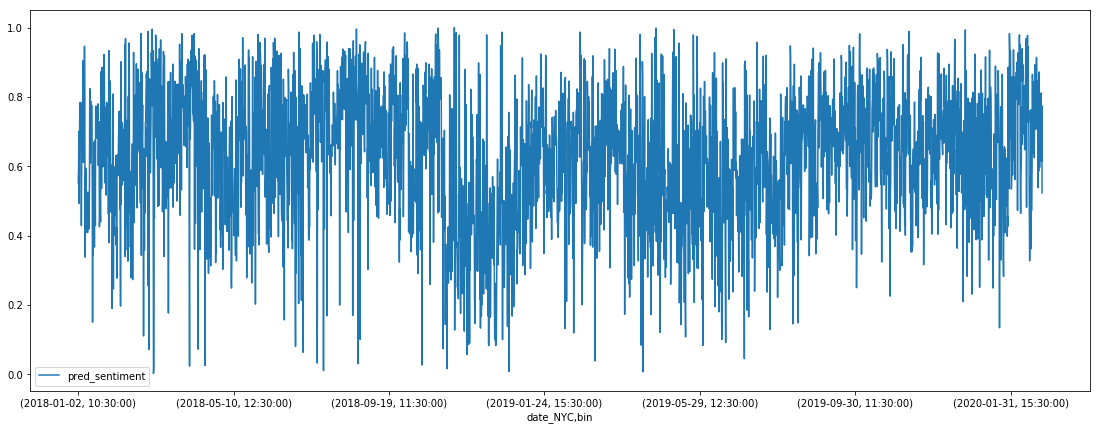

In [9]:
sent_df = get_sentiment_company(TICKER, ind_mat)
print(sent_df.head())
print(sent_df.shape)
print("Excess kurtosis")
print(kurtosis(sent_df['pred_sentiment'].values,fisher=True))
sent_df.plot(figsize=(19,7))

                     pred_sentiment
date_NYC   bin                     
2018-01-02 10:30:00        0.551471
           11:30:00        0.594538
           13:30:00        0.700630
           14:30:00        0.492857
           15:30:00        0.681723
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00        0.043067
           13:30:00        0.106092
           14:30:00       -0.207773
           15:30:00        0.188866
2018-01-03 10:30:00        0.102045


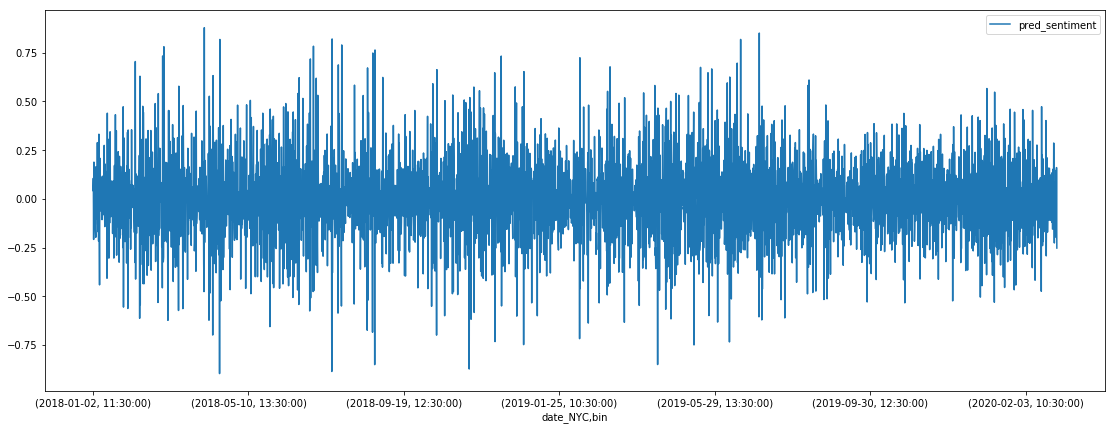

In [10]:
def create_diff_sent_df(sent_df__):
    sent_signal = np.asarray(sent_df__['pred_sentiment'])
    sent_diff_signal = sent_signal[1:]-sent_signal[0:-1]
    sent_diff_signal_index = sent_df.index[1:]

    sent_diff_df = pd.DataFrame(sent_diff_signal, index = sent_diff_signal_index, columns = ['pred_sentiment'] )
    
    return sent_diff_df

sent_df = get_sentiment_company(TICKER, ind_mat)
print(sent_df.head())

sent_diff_df = create_diff_sent_df(sent_df)
print(sent_diff_df.head())

sent_diff_df.plot(figsize=(19,7))


In [11]:
from statsmodels.tsa.stattools import adfuller
print(sent_df['pred_sentiment'])

result = adfuller(sent_df['pred_sentiment'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

date_NYC    bin     
2018-01-02  10:30:00    0.551471
            11:30:00    0.594538
            13:30:00    0.700630
            14:30:00    0.492857
            15:30:00    0.681723
                          ...   
2020-02-26  11:30:00    0.665450
            12:30:00    0.811701
            13:30:00    0.614203
            14:30:00    0.775081
            15:30:00    0.523023
Name: pred_sentiment, Length: 3102, dtype: float64
ADF Statistic: -5.220060
p-value: 0.000008
Critical Values:


In [12]:
def get_hourly_returns(ticker, nbbo_parsed_path):
    
    returns_df = pd.read_csv(nbbo_parsed_path, index_col=0)
    returns_df.dropna(inplace=True)
    
    # filter for ticker
    returns_df = returns_df[returns_df['sym_root'] == ticker]
    
    # calculate returns
    returns_df["return"] = returns_df.groupby(["date"])["close"].pct_change()
    returns_df.dropna(inplace=True)
    
    returns_df.rename({"minute": "bin"}, inplace=True, axis=1)
    returns_df.drop(["sym_root", "close"], axis=1, inplace=True)
    returns_df.set_index(['date', 'bin'], drop=True, inplace=True)
    
    return returns_df

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009121
           11:30:00 -0.000933
           12:30:00  0.000233
           13:30:00  0.000817
           14:30:00  0.002478
(2999, 1)
Excess kurtosis
6.9583355192676635


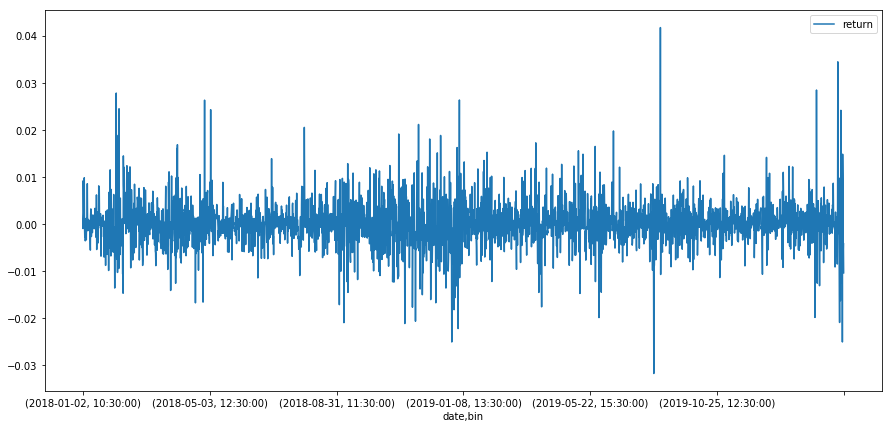

In [13]:

returns_df = get_hourly_returns(TICKER, PATH_NBBO_RETURNS)
print(returns_df.head())
print(returns_df.shape)
print("Excess kurtosis")
print(kurtosis(returns_df['return'].values,fisher=True))
returns_df.plot(figsize=(15,7))

In [14]:
def get_aligned_series(sent_df__, returns_df__):
    # create dictionary -- key (datetime.date(2018, 1, 5), datetime.time(15, 30)) -> value is return 
    ret_ticker_dict = {}
    for idx in range(returns_df__.shape[0]):
        ret_ticker_dict[returns_df__.index[idx]]=returns_df__.values[idx][0]
    
    return_ticker_signal = []
    return_ticker_signal_time = []
    sentiment_ticker_signal = []
    sentiment_ticker_signal_time = []

    for idx in range(sent_df__.shape[0]):
        tmp_key_tupple = (sent_df__.index[idx][0].strftime("%Y-%m-%d"), sent_df__.index[idx][1].strftime("%H:%M:%S") )
        #print(tmp_key_tupple in ret_ticker_dict)
        if tmp_key_tupple in ret_ticker_dict:
            #both sentiment and return exist for period sent_df.index[idx]
            return_ticker_signal.append( ret_ticker_dict[tmp_key_tupple] )
            return_ticker_signal_time.append( tmp_key_tupple )
            sentiment_ticker_signal_time.append( tmp_key_tupple )
            sentiment_ticker_signal.append( sent_df__.values[idx][0])
            
    return (return_ticker_signal, sentiment_ticker_signal, sentiment_ticker_signal_time)

In [15]:
def get_aligned_series_lag(sent_df__, returns_df__, lag__):
    #create dictionary--key(datetime.date(2018, 1, 5), datetime.time(15, 30))->value is return 
    ret_ticker_dict = {}
    for idx in range(returns_df__.shape[0]):
        ret_ticker_dict[returns_df__.index[idx]]=returns_df__.values[idx][0]
    
    return_ticker_signal = []
    return_ticker_signal_time = []
    sentiment_ticker_signal = []
    sentiment_ticker_signal_time = []

    for idx in range(sent_df__.shape[0]):
        tmp_key_tupple_sent = (sent_df__.index[idx][0].strftime("%Y-%m-%d"),\
                                 sent_df__.index[idx][1].strftime("%H:%M:%S") )
        
        #taking return information with lag
        time_lag = datetime.time(sent_df__.index[idx][1].hour + lag__, sent_df__.index[idx][1].minute)
        tmp_key_tupple_return = (sent_df__.index[idx][0].strftime("%Y-%m-%d"), \
                         time_lag.strftime("%H:%M:%S") )
        
        #print(tmp_key_tupple in ret_ticker_dict)
        if tmp_key_tupple_return in ret_ticker_dict:
            #both sentiment and return exist for period sent_df.index[idx]
            return_ticker_signal.append( ret_ticker_dict[tmp_key_tupple_return] )
            return_ticker_signal_time.append( tmp_key_tupple_return )
            sentiment_ticker_signal_time.append( tmp_key_tupple_sent )
            sentiment_ticker_signal.append( sent_df__.values[idx][0])
            
    return (return_ticker_signal, return_ticker_signal_time, sentiment_ticker_signal, sentiment_ticker_signal_time)

In [16]:
ret = get_aligned_series(sent_df, returns_df)
return_ticker_signal = ret[0]
sentiment_ticker_signal = ret[1]
sentiment_ticker_signal_time = ret[2]

print(len(return_ticker_signal))

print(sentiment_ticker_signal_time)
print(sentiment_ticker_signal)

2869
[('2018-01-02', '10:30:00'), ('2018-01-02', '11:30:00'), ('2018-01-02', '13:30:00'), ('2018-01-02', '14:30:00'), ('2018-01-02', '15:30:00'), ('2018-01-03', '10:30:00'), ('2018-01-03', '11:30:00'), ('2018-01-03', '12:30:00'), ('2018-01-03', '13:30:00'), ('2018-01-03', '14:30:00'), ('2018-01-03', '15:30:00'), ('2018-01-04', '10:30:00'), ('2018-01-04', '11:30:00'), ('2018-01-04', '12:30:00'), ('2018-01-04', '13:30:00'), ('2018-01-04', '14:30:00'), ('2018-01-04', '15:30:00'), ('2018-01-05', '10:30:00'), ('2018-01-05', '11:30:00'), ('2018-01-05', '12:30:00'), ('2018-01-05', '13:30:00'), ('2018-01-05', '14:30:00'), ('2018-01-05', '15:30:00'), ('2018-01-08', '10:30:00'), ('2018-01-08', '11:30:00'), ('2018-01-08', '12:30:00'), ('2018-01-08', '13:30:00'), ('2018-01-08', '14:30:00'), ('2018-01-08', '15:30:00'), ('2018-01-09', '10:30:00'), ('2018-01-09', '11:30:00'), ('2018-01-09', '12:30:00'), ('2018-01-09', '13:30:00'), ('2018-01-09', '14:30:00'), ('2018-01-09', '15:30:00'), ('2018-01-10',

In [17]:
ret = get_aligned_series_lag(sent_df, returns_df, +1)
return_ticker_signal = ret[0]
return_ticker_signal_time = ret[1]
sentiment_ticker_signal = ret[2]
sentiment_ticker_signal_time = ret[3]

print(len(return_ticker_signal))

print("---sentiment----")
print(sentiment_ticker_signal_time)
print(sentiment_ticker_signal)
print("---return----")
print(return_ticker_signal_time)

2396
---sentiment----
[('2018-01-02', '10:30:00'), ('2018-01-02', '11:30:00'), ('2018-01-02', '13:30:00'), ('2018-01-02', '14:30:00'), ('2018-01-03', '10:30:00'), ('2018-01-03', '11:30:00'), ('2018-01-03', '12:30:00'), ('2018-01-03', '13:30:00'), ('2018-01-03', '14:30:00'), ('2018-01-04', '10:30:00'), ('2018-01-04', '11:30:00'), ('2018-01-04', '12:30:00'), ('2018-01-04', '13:30:00'), ('2018-01-04', '14:30:00'), ('2018-01-05', '10:30:00'), ('2018-01-05', '11:30:00'), ('2018-01-05', '12:30:00'), ('2018-01-05', '13:30:00'), ('2018-01-05', '14:30:00'), ('2018-01-08', '10:30:00'), ('2018-01-08', '11:30:00'), ('2018-01-08', '12:30:00'), ('2018-01-08', '13:30:00'), ('2018-01-08', '14:30:00'), ('2018-01-09', '10:30:00'), ('2018-01-09', '11:30:00'), ('2018-01-09', '12:30:00'), ('2018-01-09', '13:30:00'), ('2018-01-09', '14:30:00'), ('2018-01-10', '10:30:00'), ('2018-01-10', '11:30:00'), ('2018-01-10', '12:30:00'), ('2018-01-10', '13:30:00'), ('2018-01-10', '14:30:00'), ('2018-01-11', '10:30:00'

In [18]:
sentiment_signal = sentiment_ticker_signal
return_signal = return_ticker_signal

sentiment_signal = np.array(sentiment_signal)
return_signal = np.array(return_signal)

print(sentiment_signal.shape)
print(return_signal.shape)

import rpy2
print(rpy2.__version__)
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
from rpy2.robjects import numpy2ri
utils = importr("RTransferEntropy")
te_fun = robjects.r['transfer_entropy']
numpy2ri.activate()
my_quantiles = np.array([5,25,50,75,95])
res_te = te_fun(return_signal,sentiment_signal,type='quantiles', quantiles = my_quantiles)
print(res_te)

from scipy import stats
pcc = stats.pearsonr(return_signal,sentiment_signal)
print(pcc)

print("finished")

(2396,)
(2396,)
2.9.4
Shannon's entropy on 1 core with 100 shuffles.

  x and y have length 2396 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Done - Total time
 
19.24
 
seconds

Shannon Transfer Entropy Results:
-----------------------------------------------------------
Direction        TE   Eff. TE  Std.Err.   p-value    sig
-----------------------------------------------------------
     X->Y    0.0542    0.0062    0.0050    0.0900      .
     Y->X    0.0527    0.0050    0.0053    0.2167       
-----------------------------------------------------------
Bootstrapped TE Quantiles (300 replications):
-----------------------------------------------------------
Direction      0%     25%     50%     75%    100%
-----------------------------------------------------------
     X->Y  0.0341  0.0445  0.0482  0.0521  0.0626
     Y->X  0.0347  0.0441  0.0472  0.0505  0.0663
------------------------------------------------

In [19]:
def transfer_entropy_stat(sentiment_signal__, return_signal__, ticker_str__, lag__ = 0, lx__ = 1, ly__ = 1):
    utils = importr("future")
    paralel_fun = robjects.r['plan']
    paralel_fun('multiprocess')

    utils = importr("RTransferEntropy")
    te_fun = robjects.r['transfer_entropy']
    numpy2ri.activate()
    
    if (lag__ > 0):
        sentiment_signal__ = sentiment_signal__ [lag:]
        return_signal__ = return_signal__[:-lag]
    elif (lag__ < 0):
        print("Negative lag not implemented or tested!")
        return -1
    
    my_quantiles = np.array([5,25,50,75,95])
    res_te = te_fun(sentiment_signal__, return_signal__,lx = lx__, ly = ly__, type='quantiles', quantiles = my_quantiles, nboot = 300)
    pcc = stats.pearsonr(sentiment_signal__, return_signal__)
    
    column_names = ["ticker", "direction", "TE", "ETE", "p-val", "pcc",  "pcc-p-val" ]
    te_stat1 = [ticker_str__, "sentiment->return", res_te[2][0],res_te[2][2],res_te[2][6],pcc[0],pcc[1]]
    te_stat2 = [ticker_str__, "return->sentiment", res_te[2][1],res_te[2][3],res_te[2][7],pcc[0],pcc[1]]
    df_TE = pd.DataFrame([te_stat1, te_stat2], columns = column_names)
    
    return df_TE

# Renyi entropy 
# In finance, pricing relevant information is readily associated with tail events, 
# i.e. relatively large positive or negative returns. If these are indeed more relevant, 
# Rényi transfer entropy provides a tool to give more weight to their contribution to the overall 
# information flow.
# see Jizba, Petr, Hagen Kleinert, and Mohammad Shefaat. 2012. 
# “Renyi’s Information Transfer Between Financial Time Series.” Physica A 391: 2971–89.

# Additional motivation there is a recent connection 
# Soklakov, A. N. (2018). "Economics of disagreement -- financial intuition for the Rényi divergence". arXiv:1811.08308
# large class of disagreements can be transformed into investment opportunities. 
# The expected financial performance of such investments quantifies the amount of disagreement in a tangible way.
# The Rényi divergence appears connected to the optimized financial performance.

def transfer_renyi_entropy_stat(sentiment_signal__, return_signal__, ticker_str__, q__ = 1.0):
    utils = importr("RTransferEntropy")
    te_fun = robjects.r['transfer_entropy']
    numpy2ri.activate()
    res_te = te_fun(sentiment_signal__, return_signal__, entropy="Renyi", q = q__)
    pcc = stats.pearsonr(sentiment_signal__, return_signal__)
    
    column_names = ["ticker", "direction", "TE", "ETE", "p-val", "pcc",  "pcc-p-val" ]
    te_stat1 = [ticker_str__, "sentiment->return", res_te[2][0],res_te[2][2],res_te[2][6],pcc[0],pcc[1]]
    te_stat2 = [ticker_str__, "return->sentiment", res_te[2][1],res_te[2][3],res_te[2][7],pcc[0],pcc[1]]
    df_TE = pd.DataFrame([te_stat1, te_stat2], columns = column_names)
    
    return df_TE

In [20]:
transfer_entropy_stat(np.array(sentiment_ticker_signal), np.array(return_ticker_signal), TICKER, lag__ = 0, lx__ = 2, ly__ = 1)

Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 2396 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
6.14
 
seconds



ticker          direction        TE       ETE     p-val       pcc  pcc-p-val
0   AAPL  sentiment->return  0.284734  0.000000  0.740000 -0.014156   0.488571
1   AAPL  return->sentiment  0.260210  0.019936  0.036667 -0.014156   0.488571

In [21]:
sentiment_signal__ = np.array(sentiment_ticker_signal)
return_signal__ = np.array(return_ticker_signal)
print(sentiment_signal__.shape)
print(sentiment_signal__)

print(return_signal__.shape)
print(return_signal__)

lag = 1

sentiment_signal__ = sentiment_signal__ [lag:]
print(sentiment_signal__.shape)
print(sentiment_signal__)

return_signal__ = return_signal__[:-lag]
print(return_signal__.shape)
print(return_signal__)



(2396,)
[0.55147059 0.59453782 0.70063025 ... 0.81170098 0.6142027  0.77508126]
(2396,)
[-0.00093303  0.00023347  0.00247806 ...  0.00119271 -0.00711368
  0.00341092]
(2395,)
[0.59453782 0.70063025 0.49285714 ... 0.81170098 0.6142027  0.77508126]
(2395,)
[-0.00093303  0.00023347  0.00247806 ... -0.01241839  0.00119271
 -0.00711368]


In [22]:
## ***********ALL TICKERS ***********
#***********************************
companies = [x for x in set(list(ind_mat['TICKER']))]
print(companies)

['TRV', 'BKNG', 'PM', 'DGX', 'ICE', 'WEC', 'LEG', 'IFF', 'HBI', 'RRC', 'TSCO', 'SBUX', 'HFC', 'CA', 'PNC', 'MKC', 'UA', 'PBCT', 'DLTR', 'TSN', 'NAVI', 'CFG', 'CXO', 'AVGO', 'UHS', 'MO', 'AMCR', 'HRL', 'EIX', 'CELG', 'CMG', 'WU', 'PCAR', 'LIN', 'PG', 'ILMN', 'WCG', 'AMP', 'SLG', 'DTE', 'CNC', 'AMZN', 'HAL', 'ADM', 'AES', 'CMCSA', 'SIVB', 'FRC', 'SWKS', 'MA', 'AEE', 'KSU', 'GPS', 'MSFT', 'CTXS', 'WMB', 'CCI', 'ALGN', 'ANET', 'MTB', 'TWX', 'XLNX', 'REGN', 'XEL', 'LH', 'TMUS', 'PPL', 'STZ', 'AOS', 'HOG', 'ESRX', 'TTWO', 'SRE', 'PSA', 'LUV', 'CMI', 'JNPR', 'PAYX', 'PHM', 'QCOM', 'SNA', 'ESS', 'COF', 'FITB', 'PNR', 'XRX', 'GLW', 'RL', 'WY', 'IP', 'NSC', 'ARNC', 'EXPE', 'DIS', 'MLM', 'LHX', 'MAA', 'UNH', 'AIV', 'GE', 'CB', 'FISV', 'LB', 'BWA', 'MGM', 'LW', 'MOS', 'PKI', 'CSCO', 'EVRG', 'AAL', 'TDC', 'DISCA', 'INTC', 'IEX', 'CBOE', 'MDLZ', 'HOLX', 'DNB', 'SPG', 'M', 'FTV', 'AXP', 'ATVI', 'EW', 'NOV', 'HSIC', 'IPGP', 'ABT', 'AGN', 'EOG', 'CINF', 'REG', 'FBHS', 'ANDV', 'O', 'V', 'FTR', 'COO', 'H

In [54]:
df_TE = pd.DataFrame(columns = ["ticker", "direction", "TE", "ETE", "p-val", "pcc",  "pcc-p-val" ])
for ticker in companies:
    try:
        print(ticker)
        sent_df = get_sentiment_company(ticker, ind_mat)
        
        if (SENT_TYPE==SENT_DIFF_SIGNAL):
            print("Using diff sentiment signal!")
            sent_df = create_diff_sent_df(sent_df)
        
        print(sent_df.head())
        print("Excess kurtosis")
        print(kurtosis(sent_df['pred_sentiment'].values,fisher=True))
        
        result = adfuller(sent_df['pred_sentiment'])
        p_val_adf = result[1]
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')

        returns_df = get_hourly_returns(ticker, PATH_NBBO_RETURNS)
        print("Excess kurtosis")
        print(kurtosis(returns_df['return'].values,fisher=True))
        
        ret = get_aligned_series(sent_df, returns_df)
        return_ticker_signal =  np.array(ret[0])
        sentiment_ticker_signal =  np.array(ret[1])
        sentiment_ticker_signal_time = ret[2]
        print(sentiment_ticker_signal_time[0])
        print(sentiment_ticker_signal_time[-1])
        print("after aligning")
        print(len(sentiment_ticker_signal))
        
        tmp_df_TE = transfer_entropy_stat(sentiment_ticker_signal, return_ticker_signal, ticker, lag__ = 0, lx__ = 1, ly__ =1)
        
        tmp_df_TE['p-val-ADF-sent'] = p_val_adf
        
        df_TE = df_TE.append(tmp_df_TE)
    except:
        print("Something else went wrong with imports or TE calc")
print("FINISHED")

SHW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-28 11:30:00        0.282886
2018-03-14 11:30:00       -0.132371
2018-03-20 12:30:00       -0.111990
2018-04-04 11:30:00       -0.324832
2018-04-09 15:30:00        0.335205
Excess kurtosis
0.7209149522723304
ADF Statistic: -5.824223
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.675542175973981
('2018-02-28', '11:30:00')
('2020-02-24', '14:30:00')
after aligning
142
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

CAH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-08 11:30:00        0.665140
2018-02-16 12:30:00       -0.137003
2018-03-05 14:30:00       -0.280097
2018-05-03 11:30:00       -0.166937
           12:30:00       -0.084257
Excess kurtosis
-0.21240684105760543
ADF Statistic: -6.214971
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.077561173285158
('2018-02-08', '11:30:00')
('2020-02-24', '13:30:00')
after aligning
108
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 108 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

PPG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 10:30:00        0.167640
2018-04-12 11:30:00        0.137544
           14:30:00       -0.287984
2018-06-12 15:30:00       -0.207472
2018-06-15 10:30:00        0.609430
Excess kurtosis
0.10211380644132761
ADF Statistic: -7.484512
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.262082816535241
('2018-04-03', '10:30:00')
('2020-02-21', '11:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

JKHY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-25 12:30:00       -0.448670
2018-07-03 10:30:00        0.002321
2018-07-10 10:30:00        0.164230
2018-07-17 10:30:00        0.021582
2018-07-24 10:30:00        0.113733
Excess kurtosis
1.474531557396963
ADF Statistic: -4.257844
p-value: 0.000525
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2011.7302199840533
('2018-05-25', '12:30:00')
('2020-02-21', '10:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

CNC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00        0.255085
2018-01-10 11:30:00       -0.274281
2018-02-06 12:30:00        0.170743
2018-03-05 10:30:00       -0.205997
2018-03-22 13:30:00        0.134850
Excess kurtosis
-0.07053456534657832
ADF Statistic: -7.203618
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.908674392894962
('2018-01-08', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
110
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 110 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

CELG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00        0.080906
2018-01-08 10:30:00       -0.109073
           11:30:00        0.218695
2018-01-17 12:30:00        0.464784
2018-01-18 13:30:00       -0.481362
Excess kurtosis
0.4789029054884453
ADF Statistic: -8.900591
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
719.1908825361854
('2018-01-03', '14:30:00')
('2019-11-20', '12:30:00')
after aligning
204
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 204 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.18
 
seconds

EMR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 15:30:00       -0.101440
2018-04-06 10:30:00        0.153554
           12:30:00        0.315504
2018-05-09 15:30:00       -0.624966
2018-05-15 11:30:00        0.428748
Excess kurtosis
0.45694820235659384
ADF Statistic: -7.091576
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.965322887885662
('2018-04-03', '15:30:00')
('2020-02-24', '12:30:00')
after aligning
149
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 149 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

HON
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 13:30:00        0.285507
2018-01-26 11:30:00       -0.218650
           14:30:00       -0.127010
2018-02-08 10:30:00        0.159808
2018-02-14 15:30:00       -0.023388
Excess kurtosis
0.5418683867270007
ADF Statistic: -12.202198
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
1428.6098668906686
('2018-01-18', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
346
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 346 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.52
 
seconds

MAC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 11:30:00       -0.612908
2018-04-20 10:30:00        0.034109
2018-05-16 14:30:00        0.127650
2018-06-14 11:30:00       -0.195560
2018-07-30 11:30:00        0.325570
Excess kurtosis
-0.2818427454516903
ADF Statistic: -5.158056
p-value: 0.000011
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.047624545982107
('2018-04-03', '11:30:00')
('2020-02-24', '10:30:00')
after aligning
46
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

MAR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-14 12:30:00       -0.268340
2018-08-15 12:30:00        0.045961
2018-08-23 13:30:00        0.164031
2018-10-04 12:30:00       -0.031941
2018-11-30 14:30:00       -0.425448
Excess kurtosis
-0.2923784713452653
ADF Statistic: -9.253227
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.085310272610238
('2018-08-14', '12:30:00')
('2020-02-26', '15:30:00')
after aligning
119
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 119 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

NFX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-15 15:30:00       -0.394612
2018-07-27 13:30:00        0.220852
2018-07-30 11:30:00       -0.039933
2018-08-01 15:30:00        0.169421
2018-09-12 10:30:00       -0.550421
Excess kurtosis
-0.7200270861338973
ADF Statistic: -6.508835
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2.6474019363506223
('2018-06-15', '15:30:00')
('2018-12-12', '10:30:00')
after aligning
16
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 16 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
PSA


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)
/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Zusätzlich: 
  warnings.warn(x, RRuntimeWarning)
/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warnmeldung:

  warnings.warn(x, RRuntimeWarning)
/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In (function (x, y, lx = 1, ly = 1, q = 0.1, entropy = "Shannon",  :
  warnings.warn(x, RRuntimeWarning)
/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/r

Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-22 12:30:00        0.139432
2018-03-27 15:30:00       -0.204812
2018-03-29 14:30:00        0.552407
2018-04-10 15:30:00       -0.241097
2018-05-17 14:30:00       -0.247170
Excess kurtosis
0.45340390342132375
ADF Statistic: -5.751191
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2.3234300875996867
('2018-03-22', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.03
 
seconds

VRTX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-17 10:30:00       -0.176155
2018-07-23 11:30:00        0.610612
2018-07-24 12:30:00       -0.569686
2018-07-26 12:30:00       -0.220606
           15:30:00        0.587552
Excess kurtosis
0.6102791898626476
ADF Statistic: -6.969938
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.281411068385392
('2018-07-17', '10:30:00')
('2020-02-26', '13:30:00')
after aligning
110
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 110 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

M
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00       -0.690293
           12:30:00        0.360060
           13:30:00        0.023240
           14:30:00       -0.396746
           15:30:00        0.040837
Excess kurtosis
-0.18788038350021097
ADF Statistic: -10.006325
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.061056076814234
('2018-01-04', '10:30:00')
('2020-02-25', '15:30:00')
after aligning
323
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 323 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.59
 
seconds

DRE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 13:30:00        0.017333
2018-07-23 11:30:00       -0.318014
2018-07-27 12:30:00        0.331348
           14:30:00        0.034433
           15:30:00        0.139646
Excess kurtosis
-0.3219518316358867
ADF Statistic: -5.437307
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.675103243815064
('2018-05-15', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

MGM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 13:30:00        0.493064
2018-02-15 11:30:00       -0.460862
2018-02-28 10:30:00        0.260172
2018-03-01 14:30:00       -0.030201
2018-03-09 12:30:00       -0.284628
Excess kurtosis
-0.5967922401586034
ADF Statistic: -8.000895
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.453894461141673
('2018-01-29', '13:30:00')
('2020-02-20', '15:30:00')
after aligning
128
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 128 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

VNO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-15 10:30:00       -0.185980
2018-07-20 11:30:00        0.070137
2018-08-03 15:30:00        0.027496
2018-08-16 14:30:00       -0.084511
2018-08-22 11:30:00       -0.047952
Excess kurtosis
6.171505697220075
ADF Statistic: -6.050259
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.192712977878305
('2018-06-15', '10:30:00')
('2020-02-25', '14:30:00')
after aligning
41
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

VLO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 12:30:00        0.322074
2018-03-28 11:30:00       -0.233225
2018-04-03 14:30:00        0.245871
2018-04-26 14:30:00       -0.092615
2018-04-30 14:30:00        0.130088
Excess kurtosis
1.2566673655591751
ADF Statistic: -5.343072
p-value: 0.000004
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.554602753082034
('2018-03-27', '12:30:00')
('2020-02-21', '11:30:00')
after aligning
143
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 143 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

CHK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-23 12:30:00        0.076245
2018-02-02 14:30:00       -0.127992
2018-02-05 10:30:00        0.221228
2018-02-12 11:30:00        0.091035
2018-02-13 10:30:00       -0.162247
Excess kurtosis
2.685026542269691
ADF Statistic: -8.714054
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
38.00974471514635
('2018-02-05', '10:30:00')
('2020-02-26', '15:30:00')
after aligning
177
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 177 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

EXC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 15:30:00        0.159443
2018-03-12 11:30:00       -0.244122
2018-04-03 10:30:00       -0.057524
2018-04-11 13:30:00        0.249922
2018-04-17 10:30:00        0.105981
Excess kurtosis
0.11806778192823364
ADF Statistic: -10.415941
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.5439792503940275
('2018-02-05', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
134
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 134 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

ACN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 15:30:00       -0.206242
2018-01-23 14:30:00        0.459628
           15:30:00        0.160569
2018-01-30 10:30:00       -0.383793
2018-02-15 14:30:00       -0.008586
Excess kurtosis
0.4149494194465979
ADF Statistic: -9.939042
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.896145560351615
('2018-01-05', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
319
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 319 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.79
 
seconds

DOV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-27 12:30:00       -0.546747
           13:30:00       -0.022272
2018-07-25 10:30:00        0.359407
2018-07-26 14:30:00       -0.216467
2018-08-31 10:30:00        0.227466
Excess kurtosis
0.10549672409672706
ADF Statistic: -3.655310
p-value: 0.004788
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2972.4934738466827
('2018-04-27', '12:30:00')
('2020-02-26', '13:30:00')
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

MAS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 11:30:00        0.063898
           12:30:00       -0.467497
2018-04-10 11:30:00       -0.213583
2018-04-11 12:30:00        0.353096
2018-04-24 13:30:00       -0.322610
Excess kurtosis
-0.46296645185165053
ADF Statistic: -8.227503
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.438927312646273
('2018-03-12', '11:30:00')
('2020-02-24', '15:30:00')
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

ESS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-17 10:30:00       -0.212635
2018-07-30 11:30:00       -0.267151
2018-07-31 10:30:00        0.147664
2018-08-02 10:30:00       -0.095673
           14:30:00        0.278761
Excess kurtosis
0.7529268098170476
ADF Statistic: -6.071855
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.208601081667869
('2018-07-17', '10:30:00')
('2020-02-20', '15:30:00')
after aligning
36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 36 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

WELL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00        0.019515
2018-04-25 13:30:00       -0.483018
           14:30:00        0.147708
2018-04-30 12:30:00        0.127812
2018-07-25 11:30:00       -0.218360
Excess kurtosis
0.7927517663204089
ADF Statistic: -7.098652
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.475835708523478
('2018-04-10', '14:30:00')
('2020-02-25', '11:30:00')
after aligning
82
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 82 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

INTU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-11 13:30:00        0.234804
2018-02-15 12:30:00        0.336513
2018-02-28 12:30:00       -0.546837
2018-03-09 11:30:00        0.326686
2018-03-12 13:30:00       -0.316280
Excess kurtosis
-0.24561279595911945
ADF Statistic: -6.681614
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.958074391658723
('2018-01-11', '13:30:00')
('2020-02-26', '14:30:00')
after aligning
179
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 179 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.34
 
seconds

SPGI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-07 13:30:00       -0.037498
2018-02-20 13:30:00        0.199870
2018-02-21 12:30:00        0.095370
2018-02-22 14:30:00        0.405779
2018-03-02 10:30:00       -0.509075
Excess kurtosis
0.668029785741254
ADF Statistic: -10.497313
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.519192714998788
('2018-02-07', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
649
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 649 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.3
 
seconds

FTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-28 11:30:00       -0.198994
2018-03-27 12:30:00       -0.080902
2018-03-28 15:30:00        0.011963
2018-04-11 15:30:00        0.511466
2018-04-12 15:30:00       -0.518700
Excess kurtosis
-0.5163255252886039
ADF Statistic: -3.362115
p-value: 0.012320
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.21531322559756
('2018-02-28', '11:30:00')
('2020-01-27', '13:30:00')
after aligning
17
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 17 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

HBAN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-09 11:30:00        0.182441
2018-05-14 11:30:00       -0.031481
2018-05-17 10:30:00       -0.032382
2018-07-19 13:30:00       -0.117759
2018-07-23 11:30:00        0.324426
Excess kurtosis
-0.33978560453626816
ADF Statistic: -5.943777
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
741.9913342809026
('2018-02-09', '11:30:00')
('2020-02-24', '10:30:00')
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

TDG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-16 10:30:00        0.487683
2018-03-19 11:30:00       -0.352955
2018-03-27 12:30:00        0.001314
2018-04-03 12:30:00        0.262275
2018-04-04 13:30:00        0.285547
Excess kurtosis
0.4255744380482316
ADF Statistic: -6.067815
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.375780800340149
('2018-03-16', '10:30:00')
('2020-02-20', '12:30:00')
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

ES
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 13:30:00       -0.654176
2018-01-26 10:30:00        0.176522
2018-01-31 14:30:00       -0.074644
2018-02-14 11:30:00       -0.371506
2018-02-23 15:30:00        0.301493
Excess kurtosis
-0.21882895643228695
ADF Statistic: -4.996852
p-value: 0.000023
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
47.88226552515537
('2018-01-04', '13:30:00')
('2020-02-25', '15:30:00')
after aligning
109
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 109 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

CDNS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 12:30:00       -0.112153
2018-04-06 12:30:00        0.166973
2018-04-10 14:30:00       -0.086776
2018-04-11 15:30:00        0.104349
2018-06-15 13:30:00        0.422083
Excess kurtosis
0.1099165342039381
ADF Statistic: -10.120980
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
24.58098116333988
('2018-04-03', '12:30:00')
('2020-02-25', '13:30:00')
after aligning
57
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

DRI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-18 14:30:00        0.421245
2018-06-15 10:30:00       -0.541429
2018-06-21 11:30:00       -0.171328
2018-07-27 12:30:00        0.085397
2018-08-03 13:30:00       -0.167346
Excess kurtosis
-0.3757275586798574
ADF Statistic: -7.084838
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.323635244380343
('2018-05-18', '14:30:00')
('2020-02-25', '14:30:00')
after aligning
57
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

AMCR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-02 11:30:00       -0.355556
2018-08-03 12:30:00        0.394992
2018-08-06 10:30:00       -0.429908
           11:30:00        0.218459
           12:30:00       -0.457669
Excess kurtosis
-0.7135345792085608
ADF Statistic: -4.802057
p-value: 0.000054
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.215955875768049
('2019-06-11', '15:30:00')
('2020-02-24', '12:30:00')
after aligning
23
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 23 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
DG


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 12:30:00        0.115652
2018-02-08 13:30:00        0.264988
2018-02-16 11:30:00       -0.022606
           13:30:00       -0.024931
2018-03-02 12:30:00       -0.056737
Excess kurtosis
0.03574425606134923
ADF Statistic: -6.661154
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.825024597445903
('2018-01-29', '12:30:00')
('2020-02-25', '10:30:00')
after aligning
201
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 201 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.31
 
seconds

TEL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 10:30:00        0.353312
2018-04-05 10:30:00        0.052771
2018-06-15 13:30:00       -0.112535
2018-07-02 13:30:00       -0.279191
2018-07-11 10:30:00        0.557610
Excess kurtosis
-0.4763730773903596
ADF Statistic: -7.236326
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.849559704461065
('2018-04-04', '10:30:00')
('2020-02-20', '10:30:00')
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

DLTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-22 11:30:00       -0.298840
2018-03-02 12:30:00       -0.259405
2018-03-07 12:30:00        0.424089
2018-03-09 15:30:00        0.069677
2018-03-12 10:30:00        0.004431
Excess kurtosis
-0.09004035281937384
ADF Statistic: -6.222622
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
24.363386781208646
('2018-02-22', '11:30:00')
('2020-02-20', '12:30:00')
after aligning
172
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 172 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

AXP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 14:30:00       -0.020059
2018-01-17 13:30:00       -0.248758
2018-01-18 12:30:00        0.025597
2018-01-19 11:30:00       -0.208659
2018-01-24 14:30:00        0.214923
Excess kurtosis
0.44382533172426575
ADF Statistic: -8.445175
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.7936784164686888
('2018-01-12', '14:30:00')
('2020-02-26', '15:30:00')
after aligning
388
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 388 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.72
 
seconds

AMZN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 12:30:00       -0.025910
           13:30:00        0.253221
           14:30:00       -0.302416
           15:30:00        0.236870
2018-01-03 10:30:00       -0.144680
Excess kurtosis
0.82770614095045
ADF Statistic: -16.701559
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.734652524628563
('2018-01-02', '12:30:00')
('2020-02-26', '15:30:00')
after aligning
2921
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 2921 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
6.39
 
seconds

LEG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-20 11:30:00        0.190370
2018-05-15 11:30:00        0.090588
2018-06-14 14:30:00       -0.147936
2018-07-19 13:30:00       -0.096275
2018-07-25 12:30:00        0.147558
Excess kurtosis
-0.7232680431120828
ADF Statistic: -6.288237
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
17.23715516930083
('2018-04-20', '11:30:00')
('2020-02-26', '10:30:00')
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

WCG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-01 12:30:00       -0.072084
2018-05-15 13:30:00       -0.116220
2018-06-15 10:30:00        0.344750
2018-07-24 10:30:00       -0.424078
2018-07-30 11:30:00       -0.180864
Excess kurtosis
-0.7117893154601633
ADF Statistic: -5.145899
p-value: 0.000011
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.678624763798215
('2018-05-01', '12:30:00')
('2020-01-21', '15:30:00')
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

CPRI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-10-16 10:30:00       -0.536965
2018-12-31 10:30:00       -0.074442
           11:30:00        0.248963
2019-01-03 15:30:00        0.572554
2019-02-06 12:30:00       -0.666879
Excess kurtosis
-0.18313404118447574
ADF Statistic: -8.347028
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.350187838073543
('2019-02-06', '12:30:00')
('2020-02-21', '11:30:00')
after aligning
32
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

MHK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00       -0.034529
           15:30:00        0.399345
2018-06-15 11:30:00       -0.026491
2018-07-23 11:30:00        0.297930
2018-07-24 10:30:00       -0.555936
Excess kurtosis
-0.30104894430397966
ADF Statistic: -5.852163
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.427182673425362
('2018-04-10', '14:30:00')
('2020-02-24', '13:30:00')
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

FFIV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 13:30:00        0.473195
2018-01-25 14:30:00       -0.732271
2018-02-26 14:30:00        0.702173
2018-04-24 15:30:00       -0.593883
2018-07-24 11:30:00        0.840497
Excess kurtosis
0.6174853881640936
ADF Statistic: -10.092956
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.834434892979682
('2018-01-18', '13:30:00')
('2020-02-24', '13:30:00')
after aligning
71
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 71 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

ULTA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 15:30:00       -0.351675
2018-03-21 15:30:00        0.310535
2018-03-27 15:30:00       -0.432225
2018-04-02 11:30:00        0.059141
2018-04-05 10:30:00        0.492357
Excess kurtosis
-0.27504224548955536
ADF Statistic: -10.876076
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.690630674768343
('2018-03-19', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
113
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 113 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

CME
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 13:30:00       -0.454226
2018-01-16 12:30:00        0.856918
2018-02-01 12:30:00       -0.549338
           15:30:00        0.019847
2018-02-13 15:30:00        0.001063
Excess kurtosis
0.0927899794417062
ADF Statistic: -8.412665
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.964275128630632
('2018-01-09', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
243
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 243 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.43
 
seconds

EA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00       -0.067930
2018-01-05 13:30:00        0.064834
2018-01-09 11:30:00       -0.048088
           14:30:00        0.304813
2018-01-11 13:30:00        0.130052
Excess kurtosis
0.22427755432694152
ADF Statistic: -9.580852
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.436248880426122
('2018-01-04', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
224
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 224 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.37
 
seconds

ZION
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-03 13:30:00        0.158823
2018-08-23 10:30:00       -0.150543
2018-09-17 12:30:00        0.250516
2018-11-06 15:30:00        0.100896
2018-11-08 10:30:00        0.085941
Excess kurtosis
-1.1738610845021713
ADF Statistic: -7.675341
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2.2804646714832435
('2018-08-03', '13:30:00')
('2018-12-27', '13:30:00')
after aligning
9
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 9 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.49
 
seconds

PH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-26 10:30:00       -0.022500
2018-04-04 12:30:00        0.588878
2018-04-13 11:30:00       -0.365958
2018-05-16 14:30:00        0.303464
2018-06-14 10:30:00        0.119691
Excess kurtosis
0.2429712393209318
ADF Statistic: -6.051908
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
16.25569854464213
('2018-03-26', '10:30:00')
('2020-02-21', '11:30:00')
after aligning
86
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

ILMN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-26 13:30:00        0.396132
2018-03-29 13:30:00       -0.518660
2018-04-02 14:30:00        0.478488
2018-04-12 12:30:00        0.107119
2018-05-15 10:30:00       -0.467276
Excess kurtosis
-0.34682446135356004
ADF Statistic: -6.858161
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.588435262292721
('2018-03-26', '13:30:00')
('2020-02-24', '14:30:00')
after aligning
112
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 112 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

KMB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-23 11:30:00        0.257453
           12:30:00       -0.316396
           13:30:00        0.166667
           14:30:00       -0.086043
           15:30:00       -0.171070
Excess kurtosis
0.0066999386443171716
ADF Statistic: -9.139822
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
17.507648395052723
('2018-03-20', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
195
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 195 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.28
 
seconds

PKI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-12 15:30:00       -0.227870
2018-07-25 10:30:00        0.352394
2018-07-30 11:30:00       -0.331105
2018-08-02 10:30:00       -0.025010
2018-08-03 15:30:00        0.197480
Excess kurtosis
1.1673693036522979
ADF Statistic: -2.434917
p-value: 0.132123
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.4374341088607725
('2018-06-12', '15:30:00')
('2020-02-24', '12:30:00')
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

IPGP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 13:30:00        0.239065
2018-04-11 11:30:00       -0.153763
2018-05-01 15:30:00        0.199559
2018-05-14 11:30:00       -0.556606
2018-07-24 10:30:00        0.394017
Excess kurtosis
0.4190579572610189
ADF Statistic: -5.371020
p-value: 0.000004
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
24.528361784524474
('2018-02-16', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

JNPR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 10:30:00        0.236723
2018-03-28 13:30:00        0.452949
2018-04-04 13:30:00        0.057824
2018-05-16 11:30:00       -0.420620
           12:30:00        0.326824
Excess kurtosis
0.19875028140829754
ADF Statistic: -4.811662
p-value: 0.000052
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.586845072125961
('2018-03-13', '10:30:00')
('2020-02-24', '13:30:00')
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

PG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00       -0.059657
2018-01-23 10:30:00        0.023157
           11:30:00       -0.038618
           12:30:00        0.285230
           13:30:00        0.013957
Excess kurtosis
-0.01769752447573003
ADF Statistic: -8.645741
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.485654387510303
('2018-01-03', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
348
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 348 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.66
 
seconds

NWS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-09 12:30:00       -0.206262
2018-03-02 11:30:00        0.447902
           14:30:00       -0.075397
2018-05-11 14:30:00       -0.340527
2018-05-17 12:30:00        0.381863
Excess kurtosis
-0.5313813459510803
ADF Statistic: -6.423081
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
1103.813028172975
('2018-02-09', '12:30:00')
('2020-02-21', '14:30:00')
after aligning
42
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 42 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

PRU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 10:30:00        0.040837
2018-04-06 10:30:00       -0.069453
2018-04-11 12:30:00        0.260938
2018-05-16 12:30:00       -0.246541
           13:30:00        0.047276
Excess kurtosis
0.914607993667083
ADF Statistic: -6.669627
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.773721868637681
('2018-04-02', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
134
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 134 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

TGT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 12:30:00        0.096639
           14:30:00       -0.294118
2018-01-03 10:30:00        0.305272
2018-01-08 11:30:00       -0.411014
           13:30:00        0.537037
Excess kurtosis
-0.10405243314318557
ADF Statistic: -9.908777
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.639953163973235
('2018-01-02', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
362
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 362 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.7
 
seconds

VZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00        0.620749
2018-01-04 10:30:00       -0.060360
2018-01-05 15:30:00       -0.541641
2018-01-08 11:30:00        0.194838
           15:30:00       -0.243386
Excess kurtosis
-0.09518683454484833
ADF Statistic: -13.892881
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.732689104761853
('2018-01-03', '10:30:00')
('2020-02-26', '12:30:00')
after aligning
768
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 768 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.61
 
seconds

RHI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 10:30:00        0.512652
2018-05-14 11:30:00       -0.086831
2018-05-16 11:30:00        0.119772
2018-05-17 13:30:00        0.038576
2018-07-26 10:30:00       -0.280988
Excess kurtosis
0.5862794124967232
ADF Statistic: -10.034404
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.378179287367496
('2018-04-11', '10:30:00')
('2020-02-25', '14:30:00')
after aligning
46
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

MET
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-30 13:30:00       -0.051463
2018-02-06 14:30:00        0.104595
2018-02-12 13:30:00        0.123072
2018-02-14 10:30:00        0.472399
2018-02-15 14:30:00       -0.683033
Excess kurtosis
0.10640470790567402
ADF Statistic: -6.396031
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
45.351438510604815
('2018-01-30', '13:30:00')
('2020-02-11', '15:30:00')
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

CAG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 11:30:00       -0.057692
2018-03-07 11:30:00        0.002137
2018-03-12 11:30:00        0.057630
2018-03-22 10:30:00       -0.002075
           11:30:00       -0.046460
Excess kurtosis
0.10123579269547989
ADF Statistic: -9.717537
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
29.77365120172402
('2018-03-06', '11:30:00')
('2020-02-26', '10:30:00')
after aligning
101
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 101 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

SIVB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 10:30:00        0.018762
2018-06-15 11:30:00        0.200138
2018-06-21 11:30:00        0.100822
2018-07-24 11:30:00        0.095391
2018-07-27 13:30:00        0.397956
Excess kurtosis
0.3098867083625927
ADF Statistic: -5.488483
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
413.8276569098659
('2018-04-11', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

GM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00        0.241036
2018-01-08 15:30:00        0.011214
2018-01-09 15:30:00       -0.263617
2018-01-16 13:30:00        0.401420
           14:30:00       -0.137931
Excess kurtosis
0.31902759304142725
ADF Statistic: -17.086989
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.755934093857384
('2018-01-04', '11:30:00')
('2020-02-25', '13:30:00')
after aligning
842
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 842 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.57
 
seconds

DOW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-04-10 11:30:00       -0.167558
           13:30:00        0.138655
2019-04-15 12:30:00        0.142908
2019-06-06 13:30:00       -0.096113
2019-06-10 12:30:00       -0.122503
Excess kurtosis
0.13324213039666866
ADF Statistic: -6.446726
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
258.43456362240084
('2019-04-10', '11:30:00')
('2020-02-19', '11:30:00')
after aligning
24
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 24 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

SJM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-07 11:30:00       -0.002216
2018-04-05 11:30:00       -0.339429
           12:30:00        0.522593
2018-05-14 14:30:00        0.305621
2018-05-15 12:30:00       -0.700719
Excess kurtosis
0.272708516759431
ADF Statistic: -5.245466
p-value: 0.000007
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.192853742789485
('2018-03-07', '11:30:00')
('2020-02-24', '13:30:00')
after aligning
27
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 27 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

ORCL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00        0.352249
           11:30:00       -0.607826
           13:30:00       -0.047826
           14:30:00        0.024348
2018-01-10 12:30:00        0.128696
Excess kurtosis
-0.13448850486068942
ADF Statistic: -11.135544
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.732721198893378
('2018-01-03', '10:30:00')
('2020-02-25', '13:30:00')
after aligning
517
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 517 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.06
 
seconds

FRT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-30 11:30:00        0.337150
2018-08-02 12:30:00       -0.497050
2018-08-03 13:30:00        0.485783
2018-08-06 14:30:00       -0.337338
2018-08-17 10:30:00        0.157206
Excess kurtosis
-0.5314238744027371
ADF Statistic: -2.848016
p-value: 0.051736
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
30.21841903830073
('2018-07-30', '11:30:00')
('2020-02-25', '12:30:00')
after aligning
37
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 37 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

MYL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-19 15:30:00        0.320964
2018-04-23 15:30:00       -0.318594
2018-05-09 13:30:00        0.152264
           14:30:00       -0.232773
           15:30:00       -0.004202
Excess kurtosis
-0.2660997949639521
ADF Statistic: -6.782182
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.004322055758081
('2018-04-19', '15:30:00')
('2020-02-24', '15:30:00')
after aligning
41
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

MAA
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
SWKS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.277049
2018-05-15 15:30:00       -0.133205
2018-05-17 15:30:00        0.229784
2018-06-15 15:30:00       -0.154340
2018-07-10 10:30:00       -0.408601
Excess kurtosis
-0.05978592474049149
ADF Statistic: -5.754333
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.185690865501913
('2018-03-12', '12:30:00')
('2020-02-25', '11:30:00')
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

GOOGL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 12:30:00       -0.312150
           13:30:00        0.203256
2018-01-03 10:30:00        0.009582
           11:30:00       -0.064522
           12:30:00       -0.112000
Excess kurtosis
0.44123606458927744
ADF Statistic: -15.956497
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
nan
Something else went wrong with imports or TE calc
ROL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-04-24 15:30:00       -0.319812
Excess kurtosis
-3.0
Something else went wrong with imports or TE calc
MMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00       -0.818561
2018-03-28 10:30:00       -0.026048
2018-04-06 10:30:00        0.288705
2018-04-11 15:30:00       -0.094121
2018-05-16 12:30:00        0.107574
Excess kurtosis
1.5576875329082487
ADF Statistic: -8.167116
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.849611068379765
('2018-03-12', '12:30:00')
('2020-02-24', '13:30:00')
after aligning
94
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 94 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

VRSK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-06 11:30:00       -0.073605
2018-05-15 13:30:00        0.152013
2018-05-17 13:30:00       -0.117978
           14:30:00        0.160880
2018-08-06 13:30:00       -0.193946
Excess kurtosis
-0.06417842365838489
ADF Statistic: -6.838175
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.422353529186939
('2018-04-06', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

COP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 12:30:00        0.254628
2018-01-11 13:30:00        0.003328
2018-01-22 15:30:00       -0.493411
2018-02-01 14:30:00        0.198425
2018-02-06 15:30:00        0.147455
Excess kurtosis
2.1174172323906406
ADF Statistic: -10.960886
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.343549513184322
('2018-01-10', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
240
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 240 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.41
 
seconds

HOLX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 15:30:00        0.338668
2018-05-16 12:30:00       -0.493372
2018-07-03 15:30:00       -0.079204
2018-08-03 14:30:00        0.347660
2018-08-20 10:30:00       -0.034585
Excess kurtosis
-0.26430545810219375
ADF Statistic: -7.039131
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.880618444397207
('2018-04-10', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

JEC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 10:30:00        0.544420
2018-04-04 11:30:00        0.210591
2018-04-05 14:30:00       -0.515387
2018-04-11 11:30:00        0.537897
2018-07-18 13:30:00       -0.508095
Excess kurtosis
-0.7935777577146945
ADF Statistic: -5.630049
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
43.10579887940692
('2018-03-12', '10:30:00')
('2019-11-14', '15:30:00')
after aligning
39
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

NKTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 10:30:00       -0.022474
2018-04-09 15:30:00        0.172208
2018-04-11 12:30:00        0.335929
2018-06-04 13:30:00       -0.561371
           14:30:00       -0.168357
Excess kurtosis
-0.41061552621196684
ADF Statistic: -9.120962
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
13.390589549565306
('2018-03-12', '10:30:00')
('2020-02-24', '13:30:00')
after aligning
45
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 45 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

HPE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 14:30:00       -0.023895
2018-02-15 10:30:00        0.158376
2018-02-22 14:30:00        0.185079
2018-02-26 11:30:00       -0.143752
2018-02-27 14:30:00        0.212212
Excess kurtosis
0.23335378072544755
ADF Statistic: -6.708682
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.67410649341673
('2018-01-24', '14:30:00')
('2020-02-21', '10:30:00')
after aligning
68
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 68 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

K
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 14:30:00       -0.248425
2018-02-08 12:30:00       -0.475854
2018-03-08 10:30:00        0.476918
2018-03-21 15:30:00       -0.019697
2018-03-28 13:30:00        0.029418
Excess kurtosis
-0.2736258101936051
ADF Statistic: -8.583644
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.356211615339053
('2018-02-06', '14:30:00')
('2020-02-25', '11:30:00')
after aligning
223
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 223 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.47
 
seconds

COTY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 13:30:00       -0.590238
2018-04-05 10:30:00        0.729360
2018-04-06 10:30:00       -0.307355
2018-04-09 10:30:00       -0.245847
2018-04-12 10:30:00        0.516901
Excess kurtosis
-0.29826558612590803
ADF Statistic: -5.598299
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
31.801295563368292
('2018-03-19', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

CTAS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 10:30:00       -0.317947
2018-03-23 13:30:00        0.327095
2018-04-05 12:30:00        0.035320
2018-04-12 12:30:00       -0.031502
2018-05-15 11:30:00        0.235837
Excess kurtosis
0.041072170801979
ADF Statistic: -7.068165
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.387756568759807
('2018-03-12', '10:30:00')
('2020-02-24', '12:30:00')
after aligning
102
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 102 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

AAPL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00        0.043067
           13:30:00        0.106092
           14:30:00       -0.207773
           15:30:00        0.188866
2018-01-03 10:30:00        0.102045
Excess kurtosis
0.8864112966924949
ADF Statistic: -17.080394
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.9583355192676635
('2018-01-02', '11:30:00')
('2020-02-26', '15:30:00')
after aligning
2868
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 2868 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
6.37
 
seconds

NDAQ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-17 11:30:00        0.368336
           13:30:00       -0.028668
2018-08-24 10:30:00       -0.028200
           11:30:00        0.048872
2018-11-02 15:30:00       -0.364137
Excess kurtosis
0.7957460439880029
ADF Statistic: -4.595820
p-value: 0.000131
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.9045986688593
('2018-08-17', '11:30:00')
('2020-02-20', '13:30:00')
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

BMY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 10:30:00        0.198217
2018-03-02 10:30:00       -0.279167
2018-03-21 12:30:00        0.160047
2018-03-29 12:30:00        0.531300
2018-04-03 12:30:00       -0.753795
Excess kurtosis
0.3385997668329268
ADF Statistic: -7.303613
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
98.66136234386069
('2018-02-06', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
239
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 239 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.69
 
seconds

AEP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 13:30:00       -0.013023
2018-04-03 11:30:00       -0.093493
2018-04-11 15:30:00       -0.109995
2018-04-12 14:30:00        0.310318
2018-04-26 13:30:00        0.054553
Excess kurtosis
0.5254221061825732
ADF Statistic: -5.454798
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.822152210586337
('2018-04-02', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
96
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 96 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

TROW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00        0.191851
2018-02-28 11:30:00       -0.275216
2018-03-05 15:30:00       -0.032208
2018-03-29 12:30:00        0.324770
2018-04-02 15:30:00        0.117793
Excess kurtosis
0.29900120775257655
ADF Statistic: -5.026646
p-value: 0.000020
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
19.9790971323665
('2018-02-23', '12:30:00')
('2020-02-25', '11:30:00')
after aligning
135
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 135 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.33
 
seconds

DUK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 12:30:00       -0.443780
2018-01-23 14:30:00        0.730702
2018-01-24 12:30:00       -0.574832
           14:30:00        0.606522
           15:30:00       -0.230435
Excess kurtosis
0.06332507356639017
ADF Statistic: -9.338312
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
106.06920353788139
('2018-01-22', '12:30:00')
('2020-02-26', '12:30:00')
after aligning
240
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 240 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.52
 
seconds

LOW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 10:30:00       -0.070361
2018-01-23 14:30:00        0.871700
2018-02-01 10:30:00       -0.401545
           12:30:00        0.303817
           13:30:00       -0.274809
Excess kurtosis
0.18822310455967806
ADF Statistic: -9.033652
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.815280836585252
('2018-01-22', '10:30:00')
('2020-02-26', '15:30:00')
after aligning
281
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 281 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.59
 
seconds

VIAB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 10:30:00        0.379318
2018-01-17 10:30:00        0.216846
           14:30:00       -0.326165
           15:30:00        0.487455
2018-01-18 15:30:00       -0.315801
Excess kurtosis
-0.33461045565144376
ADF Statistic: -13.531684
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.18707502834371
('2018-01-08', '10:30:00')
('2019-12-03', '10:30:00')
after aligning
295
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 295 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.65
 
seconds

ROST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-28 11:30:00       -0.169271
2018-03-05 13:30:00        0.532793
2018-03-08 13:30:00       -0.384346
2018-03-19 14:30:00        0.241522
2018-03-29 12:30:00        0.125205
Excess kurtosis
0.04015432548512354
ADF Statistic: -6.697212
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.730363073335763
('2018-02-28', '11:30:00')
('2020-02-24', '12:30:00')
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

HFC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-21 11:30:00        0.057071
2018-03-29 11:30:00        0.060418
2018-04-12 14:30:00        0.169878
2018-04-16 12:30:00       -0.005064
2018-05-02 11:30:00       -0.091204
Excess kurtosis
0.9927824982018945
ADF Statistic: -7.594591
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.426408365152639
('2018-02-21', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

FCX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 14:30:00       -0.310083
2018-01-19 10:30:00        0.072421
2018-01-24 10:30:00       -0.061360
2018-01-26 11:30:00        0.047183
2018-01-31 11:30:00        0.062213
Excess kurtosis
0.185908157859219
ADF Statistic: -5.094723
p-value: 0.000014
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.223284378447506
('2018-01-05', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
118
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 118 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

DISH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-21 13:30:00        0.029797
           15:30:00        0.128834
2018-02-22 14:30:00       -0.178554
2018-05-07 14:30:00        0.758308
2018-05-08 15:30:00       -0.448214
Excess kurtosis
-0.4680105131450589
ADF Statistic: -10.472903
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2027.8902843109968
('2018-02-21', '13:30:00')
('2020-02-20', '10:30:00')
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

GE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00       -0.056022
2018-01-10 13:30:00        0.042029
2018-01-12 14:30:00       -0.118057
2018-01-16 10:30:00        0.118556
           11:30:00       -0.031609
Excess kurtosis
0.5073949645194005
ADF Statistic: -9.225324
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.729114037861034
('2018-01-08', '15:30:00')
('2020-02-26', '14:30:00')
after aligning
604
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 604 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.4
 
seconds

SBAC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 12:30:00        0.559011
2018-05-17 14:30:00        0.040651
2018-07-19 10:30:00       -0.145694
2018-08-01 13:30:00       -0.231468
2018-11-02 14:30:00       -0.009270
Excess kurtosis
0.3135721886289584
ADF Statistic: -10.407993
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.439206750192742
('2018-03-28', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.17
 
seconds

VFC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 14:30:00        0.392659
2018-03-21 13:30:00       -0.019371
2018-03-22 15:30:00       -0.262509
2018-05-04 13:30:00        0.506084
2018-06-15 11:30:00        0.251723
Excess kurtosis
0.19988434035047842
ADF Statistic: -7.085268
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
31.781760912217187
('2018-02-16', '14:30:00')
('2020-02-24', '12:30:00')
after aligning
124
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 124 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.14
 
seconds

PNR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 12:30:00        0.818776
2018-04-10 12:30:00        0.048392
2018-04-19 13:30:00       -0.285931
2018-05-14 12:30:00        0.372817
2018-05-15 11:30:00       -0.316348
Excess kurtosis
0.1778763068445146
ADF Statistic: -4.943365
p-value: 0.000029
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
1836.008239129573
('2018-04-03', '12:30:00')
('2020-02-19', '15:30:00')
after aligning
68
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 68 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

DNB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 12:30:00        0.658951
2018-03-07 12:30:00       -0.528509
2018-05-10 14:30:00        0.287276
2018-07-30 10:30:00       -0.499273
2018-07-31 15:30:00        0.302985
Excess kurtosis
-0.5223334539463149
ADF Statistic: -3.398882
p-value: 0.010997
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
73.59877471831979
('2018-01-16', '12:30:00')
('2019-01-25', '14:30:00')
after aligning
16
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 16 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

WHR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 12:30:00        0.411550
2018-01-23 10:30:00       -0.229394
2018-02-26 14:30:00        0.360150
2018-03-27 10:30:00       -0.675511
2018-04-02 11:30:00        0.495402
Excess kurtosis
0.08683874504217215
ADF Statistic: -6.598570
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
23.860714152703192
('2018-01-16', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
140
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 140 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

ABC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-13 10:30:00        0.664303
           12:30:00       -0.021144
2018-02-14 12:30:00       -0.465985
2018-03-08 13:30:00        0.301459
2018-03-09 11:30:00       -0.142822
Excess kurtosis
-0.644811229550883
ADF Statistic: -6.792092
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.062167099859298
('2018-02-13', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
78
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

JBHT
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
BAX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 14:30:00        0.374028
2018-03-29 10:30:00       -0.296860
2018-05-14 12:30:00       -0.081343
2018-05-17 10:30:00        0.304207
           15:30:00       -0.395833
Excess kurtosis
0.04196163743892978
ADF Statistic: -7.277531
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.126457626721114
('2018-03-28', '14:30:00')
('2020-02-25', '11:30:00')
after aligning
91
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 91 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

MTD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-17 10:30:00        0.004127
           15:30:00       -0.216435
2018-12-18 14:30:00       -0.022707
2020-02-11 14:30:00       -0.244776
Excess kurtosis
-1.939689999428064
ADF Statistic: -8.667598
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.4389143773673165
('2018-05-17', '10:30:00')
('2020-02-11', '14:30:00')
after aligning
4
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 4 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
WRK


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 15:30:00       -0.111214
2018-04-19 10:30:00        0.182487
2018-05-15 11:30:00       -0.076644
2018-05-16 13:30:00        0.090502
2018-06-12 15:30:00       -0.220232
Excess kurtosis
0.2109061590447996
ADF Statistic: -3.918614
p-value: 0.001902
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.317593303322184
('2018-04-09', '15:30:00')
('2020-02-05', '12:30:00')
after aligning
32
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.94
 
seconds

WLTW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 15:30:00        0.525121
2018-05-07 14:30:00        0.124400
2018-05-14 12:30:00       -0.137389
2018-05-16 12:30:00       -0.138658
2018-07-05 11:30:00        0.290659
Excess kurtosis
-0.22475389582383887
ADF Statistic: -7.346758
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.911112275902202
('2018-04-10', '15:30:00')
('2020-02-24', '10:30:00')
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

UAL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 11:30:00        0.139855
           12:30:00        0.082609
2018-02-13 11:30:00        0.004337
2018-03-05 11:30:00        0.264129
           15:30:00       -0.342733
Excess kurtosis
0.14873384788420996
ADF Statistic: -5.603282
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.737007965705086
('2018-01-24', '11:30:00')
('2020-02-26', '13:30:00')
after aligning
164
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 164 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

CBS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00        0.030462
           13:30:00       -0.174370
           14:30:00        0.260504
           15:30:00        0.002101
2018-01-03 10:30:00       -0.061472
Excess kurtosis
0.34862962058501346
ADF Statistic: -11.761086
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
36.281721254633744
('2018-01-02', '11:30:00')
('2019-12-03', '15:30:00')
after aligning
1189
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.23
 
seconds

WYNN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 14:30:00        0.297753
           15:30:00        0.142322
2018-01-26 13:30:00       -0.146090
           14:30:00        0.036518
           15:30:00        0.000000
Excess kurtosis
0.3438105704439911
ADF Statistic: -7.024685
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.31258441197499
('2018-01-22', '14:30:00')
('2020-02-25', '12:30:00')
after aligning
190
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 190 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.34
 
seconds

MSCI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00       -0.057945
2018-01-05 12:30:00        0.233916
2018-01-16 12:30:00       -0.232327
2018-02-22 15:30:00       -0.107275
2018-03-12 11:30:00        0.452236
Excess kurtosis
0.4779090517712907
ADF Statistic: -15.365530
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.098013456721878
('2018-01-04', '11:30:00')
('2020-02-26', '12:30:00')
after aligning
777
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 777 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.64
 
seconds

MNK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-27 12:30:00       -0.282832
2018-02-28 12:30:00       -0.200599
2018-03-19 12:30:00        0.276854
2018-03-23 14:30:00       -0.317996
2018-03-26 12:30:00        0.905198
Excess kurtosis
0.574073266077094
ADF Statistic: -9.424093
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
67.7526530727316
('2018-02-27', '12:30:00')
('2020-02-25', '15:30:00')
after aligning
89
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 89 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

MKC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 13:30:00        0.103955
2018-01-19 13:30:00        0.263655
2018-02-01 14:30:00       -0.396958
2018-02-27 11:30:00       -0.030245
2018-03-01 11:30:00        0.061288
Excess kurtosis
-0.15812934032823955
ADF Statistic: -6.435488
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.45082500791193
('2018-01-18', '13:30:00')
('2020-01-30', '12:30:00')
after aligning
113
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 113 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

LIN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-08 12:30:00       -0.041782
           14:30:00       -0.022945
2018-03-14 12:30:00        0.382479
2018-03-15 15:30:00       -0.397924
2018-03-23 15:30:00        0.768757
Excess kurtosis
-0.31870419082690304
ADF Statistic: -9.975250
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.369893632394508
('2018-11-05', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
109
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 109 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

R
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
CFG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 14:30:00        0.228199
2018-05-17 15:30:00       -0.213974
2018-07-18 11:30:00        0.513080
2018-07-20 14:30:00        0.099076
2018-07-25 14:30:00       -0.358184
Excess kurtosis
-0.3215897622799728
ADF Statistic: -7.308658
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
195.74278908343368
('2018-05-16', '14:30:00')
('2020-02-24', '11:30:00')
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

STT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 14:30:00       -0.353257
2018-02-07 14:30:00        0.026265
           15:30:00       -0.004963
2018-02-12 14:30:00        0.305977
2018-02-26 11:30:00       -0.070340
Excess kurtosis
-0.0378451645544966
ADF Statistic: -7.927995
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.836849169687742
('2018-01-24', '14:30:00')
('2020-02-26', '12:30:00')
after aligning
200
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.43
 
seconds

GPS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 15:30:00       -0.151394
2018-01-16 10:30:00        0.702226
           11:30:00        0.050575
2018-01-30 12:30:00       -0.727984
2018-01-31 13:30:00       -0.014536
Excess kurtosis
-0.3367221605916977
ADF Statistic: -10.655488
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.886989669064667
('2018-01-04', '15:30:00')
('2020-02-26', '12:30:00')
after aligning
326
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 326 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.7
 
seconds

UNP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 13:30:00        0.024814
           14:30:00        0.585608
           15:30:00        0.063275
2018-01-30 15:30:00        0.081897
2018-03-21 11:30:00       -0.705607
Excess kurtosis
0.27847391065651506
ADF Statistic: -9.128960
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.680030525215297
('2018-01-25', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
248
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 248 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.55
 
seconds

CTL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 14:30:00       -0.007654
2018-01-16 13:30:00        0.858320
2018-01-25 12:30:00       -0.385057
2018-02-02 11:30:00       -0.369969
2018-02-12 10:30:00        0.363082
Excess kurtosis
0.17580063787817268
ADF Statistic: -9.648668
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.482938372080303
('2018-01-09', '14:30:00')
('2020-02-25', '11:30:00')
after aligning
164
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 164 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.19
 
seconds

AMG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 12:30:00        0.050062
2018-05-16 12:30:00       -0.021987
2018-05-17 12:30:00        0.251819
2018-07-26 13:30:00       -0.164800
2018-08-02 15:30:00        0.021599
Excess kurtosis
0.050868893137337334
ADF Statistic: -7.023382
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
15.02734287767909
('2018-04-11', '12:30:00')
('2020-02-21', '11:30:00')
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

COG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-12 15:30:00       -0.216190
2018-07-18 12:30:00        0.052299
2018-07-26 14:30:00       -0.195263
2018-08-01 14:30:00        0.136366
2018-08-02 11:30:00        0.081732
Excess kurtosis
2.7107271731284523
ADF Statistic: -9.943307
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.532615935529357
('2018-06-12', '15:30:00')
('2020-02-25', '11:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

GILD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-01 11:30:00       -0.586442
2018-03-08 14:30:00       -0.019712
2018-03-19 10:30:00        0.011221
2018-03-27 12:30:00       -0.080346
2018-04-05 15:30:00        0.297335
Excess kurtosis
0.05579692062785169
ADF Statistic: -8.282164
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.859369138584453
('2018-03-01', '11:30:00')
('2020-02-26', '12:30:00')
after aligning
242
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 242 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.43
 
seconds

IEX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-10-24 15:30:00       -0.251087
2018-11-15 11:30:00       -0.052923
2018-12-26 10:30:00       -0.347772
2019-01-08 12:30:00        0.362035
2019-03-22 11:30:00        0.365571
Excess kurtosis
3.0733757453614565
ADF Statistic: -10.425895
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.387897282175533
('2018-10-24', '15:30:00')
('2020-02-26', '15:30:00')
after aligning
185
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 185 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.21
 
seconds

MS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00       -0.288696
           15:30:00        0.344348
2018-01-05 11:30:00        0.052726
2018-01-12 11:30:00       -0.382719
           14:30:00        0.108470
Excess kurtosis
-0.07964210557696605
ADF Statistic: -11.597914
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
19.67301390141988
('2018-01-03', '14:30:00')
('2020-02-26', '12:30:00')
after aligning
900
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 900 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.74
 
seconds

TSN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 10:30:00       -0.034376
2018-01-31 10:30:00       -0.078398
           13:30:00       -0.526157
2018-02-08 10:30:00        0.221328
2018-04-04 11:30:00       -0.017019
Excess kurtosis
-0.23800767400847
ADF Statistic: -8.700441
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.053864246396563
('2018-01-29', '10:30:00')
('2020-02-21', '11:30:00')
after aligning
141
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.21
 
seconds

CMG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-30 13:30:00       -0.223431
2018-02-13 12:30:00        0.369443
2018-02-14 15:30:00        0.247756
2018-02-15 14:30:00       -0.415995
2018-02-21 10:30:00       -0.105378
Excess kurtosis
-0.5437560486344779
ADF Statistic: -8.137050
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.867262675415638
('2018-01-30', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
189
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

TRIP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00        0.307231
2018-01-11 10:30:00       -0.106280
2018-01-17 14:30:00       -0.070251
2018-01-23 14:30:00       -0.013015
2018-01-24 12:30:00        0.085198
Excess kurtosis
-0.06632995682616283
ADF Statistic: -7.650641
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
54.01646407646584
('2018-01-10', '11:30:00')
('2020-02-24', '10:30:00')
after aligning
116
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 116 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.06
 
seconds

MMM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-27 14:30:00        0.059862
2018-08-06 10:30:00        0.420374
2018-08-10 11:30:00       -0.024866
2018-09-17 11:30:00       -0.003427
2018-11-23 15:30:00       -0.330185
Excess kurtosis
0.6815730076657789
ADF Statistic: -9.395516
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.55893351867355
('2018-07-27', '14:30:00')
('2020-02-26', '12:30:00')
after aligning
190
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 190 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

PEG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 12:30:00        0.090707
2018-05-17 11:30:00        0.360973
2018-06-15 11:30:00       -0.361484
2018-07-19 10:30:00        0.021861
2018-07-31 11:30:00       -0.083385
Excess kurtosis
0.2976153461863058
ADF Statistic: -5.072749
p-value: 0.000016
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.474881299348693
('2018-04-12', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
61
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 61 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

URBN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 12:30:00        0.096217
2018-03-09 12:30:00        0.266769
2018-03-19 12:30:00        0.057097
2018-03-21 13:30:00        0.100669
2018-03-26 10:30:00        0.193949
Excess kurtosis
-0.06012592275908091
ADF Statistic: -9.422274
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.197603850552889
('2018-03-06', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
128
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 128 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

ARE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-05 10:30:00       -0.247661
2018-07-13 10:30:00        0.146168
2018-07-18 10:30:00       -0.053041
2018-07-31 13:30:00        0.000328
2018-08-17 10:30:00        0.122407
Excess kurtosis
-0.1660735599580323
ADF Statistic: -7.539532
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.721431435830717
('2018-07-05', '10:30:00')
('2020-02-20', '14:30:00')
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

FISV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 15:30:00        0.258172
2018-05-17 12:30:00       -0.097281
2018-05-31 14:30:00       -0.013353
2018-06-14 11:30:00        0.191446
2018-06-15 12:30:00        0.056143
Excess kurtosis
0.774060937245618
ADF Statistic: -12.709709
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
102.56478722869561
('2018-03-28', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
197
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 197 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.45
 
seconds

AMAT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 14:30:00        0.257979
2018-03-07 10:30:00       -0.171380
2018-03-12 10:30:00       -0.063146
           12:30:00        0.164592
2018-03-13 12:30:00       -0.116086
Excess kurtosis
0.4685073371734543
ADF Statistic: -9.723273
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.6112832170991975
('2018-02-16', '14:30:00')
('2020-02-25', '11:30:00')
after aligning
170
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 170 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15
 
seconds

ADI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 14:30:00        0.768489
2018-02-28 15:30:00       -0.445667
2018-03-13 10:30:00       -0.053621
2018-05-17 15:30:00        0.396563
2018-06-14 14:30:00       -0.352514
Excess kurtosis
1.7063015595926405
ADF Statistic: -6.955982
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.717345411375623
('2018-01-31', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
117
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 117 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

MTB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 12:30:00        0.745382
2018-02-15 13:30:00       -0.369278
2018-03-12 12:30:00       -0.314462
2018-04-17 13:30:00        0.081002
2018-05-09 15:30:00       -0.163483
Excess kurtosis
-0.10236004591282777
ADF Statistic: -5.540646
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
225.35386604347693
('2018-01-31', '12:30:00')
('2020-02-25', '12:30:00')
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

LDOS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-03 13:30:00       -0.095433
2018-07-24 13:30:00       -0.059497
2018-07-26 11:30:00       -0.001428
           12:30:00        0.323651
2018-08-09 15:30:00       -0.046654
Excess kurtosis
0.11766679964424798
ADF Statistic: -5.739886
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
16.130361531560446
('2018-05-03', '13:30:00')
('2020-02-26', '12:30:00')
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

SNPS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-10 11:30:00        0.622667
2018-07-24 11:30:00       -0.253728
2018-07-27 11:30:00        0.241314
2018-08-01 10:30:00       -0.197098
2018-08-03 13:30:00        0.040191
Excess kurtosis
0.9389047161495849
ADF Statistic: -6.390043
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
13.036716289084133
('2018-07-10', '11:30:00')
('2020-02-25', '15:30:00')
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

SWN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-27 15:30:00        0.108007
2018-07-31 11:30:00       -0.269115
2018-08-03 13:30:00        0.033058
           14:30:00        0.552113
           15:30:00       -0.369718
Excess kurtosis
0.4005937688917802
ADF Statistic: -6.623629
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.210665421140746
('2018-04-27', '15:30:00')
('2020-02-24', '13:30:00')
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

DTE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 15:30:00       -0.205862
2018-02-16 14:30:00        0.487173
2018-03-01 13:30:00        0.120052
2018-03-09 15:30:00        0.149914
2018-03-19 14:30:00       -0.160926
Excess kurtosis
-0.7879541186127637
ADF Statistic: -6.563334
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.673356066181084
('2018-02-05', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
86
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

AAL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00       -0.060870
2018-01-04 12:30:00        0.392552
2018-01-09 11:30:00       -0.541726
2018-01-10 12:30:00        0.001349
           14:30:00        0.057971
Excess kurtosis
0.15680566800471318
ADF Statistic: -8.589913
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.986471371905441
('2018-01-04', '12:30:00')
('2020-02-26', '12:30:00')
after aligning
329
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 329 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.65
 
seconds

HIG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-27 14:30:00        0.222058
2018-07-11 10:30:00        0.032187
2018-07-20 12:30:00       -0.109393
2018-07-24 11:30:00       -0.013878
2018-07-25 12:30:00       -0.114310
Excess kurtosis
0.03842630941299818
ADF Statistic: -6.878388
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
74.34769532935228
('2018-04-27', '14:30:00')
('2020-02-24', '11:30:00')
after aligning
79
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 79 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

COST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 15:30:00       -0.235630
2018-01-08 15:30:00        0.224426
2018-01-11 13:30:00        0.003880
2018-01-12 11:30:00       -0.609759
           12:30:00       -0.110698
Excess kurtosis
-0.055427375144736946
ADF Statistic: -11.432961
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.865952420798033
('2018-01-05', '15:30:00')
('2020-02-26', '12:30:00')
after aligning
601
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 601 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.19
 
seconds

ABBV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-26 11:30:00        0.478197
           12:30:00       -0.408494
2018-02-15 14:30:00       -0.051992
2018-02-16 13:30:00        0.257930
2018-02-22 13:30:00        0.177030
Excess kurtosis
0.20365927242136372
ADF Statistic: -10.875417
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.70759759786379
('2018-01-26', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
340
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 340 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.75
 
seconds

FBHS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 15:30:00        0.128252
2018-05-15 11:30:00        0.346306
2018-05-17 14:30:00       -0.306790
           15:30:00       -0.120370
2018-07-18 12:30:00       -0.392541
Excess kurtosis
-0.14776858464527098
ADF Statistic: -6.840792
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.340289935000783
('2018-04-04', '15:30:00')
('2020-02-21', '11:30:00')
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

AMT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-07 15:30:00       -0.411437
2018-03-12 12:30:00       -0.053916
2018-03-13 11:30:00       -0.195105
           15:30:00       -0.126307
2018-03-27 10:30:00        0.221323
Excess kurtosis
1.21252530783259
ADF Statistic: -9.277558
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
31.4668954095603
('2018-03-07', '15:30:00')
('2020-02-26', '13:30:00')
after aligning
160
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 160 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.18
 
seconds

MCK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 13:30:00        0.166769
2018-02-01 13:30:00       -0.487662
2018-02-27 10:30:00        0.403303
2018-02-28 15:30:00       -0.176990
2018-03-09 10:30:00        0.232434
Excess kurtosis
0.2440778245679729
ADF Statistic: -9.551139
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.441558481049139
('2018-01-22', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
129
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 129 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

INCY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 13:30:00       -0.747971
2018-04-06 11:30:00        0.038530
           12:30:00       -0.144031
2018-04-09 14:30:00        0.266225
           15:30:00        0.148855
Excess kurtosis
-0.31439311406029846
ADF Statistic: -5.938434
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.92074966185056
('2018-04-02', '13:30:00')
('2020-02-25', '11:30:00')
after aligning
82
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 82 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

FAST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-08 11:30:00       -0.014297
2018-03-26 10:30:00        0.120281
2018-03-27 11:30:00       -0.242154
2018-04-02 11:30:00       -0.037979
2018-04-06 10:30:00        0.568508
Excess kurtosis
0.04037466096124476
ADF Statistic: -8.903534
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.367837081245652
('2018-03-08', '11:30:00')
('2020-02-21', '11:30:00')
after aligning
110
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 110 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

LHX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-07-29 12:30:00        0.453141
2019-10-15 12:30:00       -0.325259
2019-10-18 10:30:00       -0.130328
           11:30:00        0.259681
2019-10-29 11:30:00        0.040465
Excess kurtosis
-0.28287783415335754
ADF Statistic: -11.464861
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.00714492476355
('2019-07-29', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
51
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

MLM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 15:30:00        0.046249
2018-04-02 12:30:00       -0.002731
2018-04-04 15:30:00       -0.166925
2018-04-11 15:30:00        0.005698
2018-05-16 13:30:00        0.075572
Excess kurtosis
0.04304335506718182
ADF Statistic: -7.775127
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.655067005765995
('2018-03-28', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

REG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 15:30:00       -0.181903
2018-04-24 14:30:00        0.386691
2018-07-31 11:30:00        0.012384
2018-08-03 14:30:00       -0.111972
2018-08-17 10:30:00       -0.302446
Excess kurtosis
0.8176447955627069
ADF Statistic: -9.799003
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.107362557573259
('2018-04-11', '15:30:00')
('2020-02-24', '10:30:00')
after aligning
38
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 38 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

WMT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 10:30:00        0.416505
           15:30:00       -0.187246
2018-01-08 13:30:00        0.239215
2018-01-09 10:30:00       -0.104448
           14:30:00       -0.834225
Excess kurtosis
0.08131379435445929
ADF Statistic: -16.449039
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.432905208943957
('2018-01-05', '10:30:00')
('2020-02-26', '15:30:00')
after aligning
1868
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1868 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.34
 
seconds

CSRA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 10:30:00       -0.018717
2018-02-12 11:30:00       -0.046022
           12:30:00        0.107438
2018-02-13 10:30:00       -0.122302
2018-02-15 10:30:00        0.072184
Excess kurtosis
2.2235238466332348
ADF Statistic: -2.166275
p-value: 0.218713
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.420394111377272
('2018-01-09', '10:30:00')
('2018-03-28', '13:30:00')
after aligning
11
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 11 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

FIS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-03-18 10:30:00       -0.071944
           11:30:00       -0.122596
           12:30:00        0.302484
           13:30:00       -0.634615
2019-04-30 12:30:00        0.419098
Excess kurtosis
-0.6056022578720821
ADF Statistic: -3.976576
p-value: 0.001538
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.284880413806297
('2019-03-18', '10:30:00')
('2019-11-05', '14:30:00')
after aligning
6
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.6
 
seconds

YUM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00        0.203782
2018-01-05 14:30:00       -0.113961
2018-02-08 12:30:00        0.562911
           13:30:00       -0.069544
2018-04-06 12:30:00       -0.181425
Excess kurtosis
0.045960697639896075
ADF Statistic: -6.122941
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
15.687335270121398
('2018-01-02', '14:30:00')
('2020-02-20', '15:30:00')
after aligning
120
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.13
 
seconds

PHM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-24 11:30:00        0.331016
2018-08-22 11:30:00       -0.391436
2018-12-17 13:30:00       -0.155658
2018-12-18 15:30:00        0.237071
2018-12-20 14:30:00       -0.136588
Excess kurtosis
-0.9717248081875578
ADF Statistic: -1.939226
p-value: 0.313839
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.937544896768465
('2018-07-24', '11:30:00')
('2020-02-19', '15:30:00')
after aligning
23
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 23 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

F
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00       -0.408076
           11:30:00        0.404382
2018-01-09 10:30:00       -0.589620
2018-01-16 10:30:00        0.093343
2018-01-17 15:30:00       -0.266086
Excess kurtosis
-0.3133689355422753
ADF Statistic: -10.823308
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.911918893568743
('2018-01-04', '10:30:00')
('2020-02-26', '14:30:00')
after aligning
467
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 467 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.93
 
seconds

BWA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 10:30:00       -0.302126
2018-04-10 11:30:00        0.350998
           12:30:00       -0.068740
2018-04-23 14:30:00        0.044707
2018-06-07 10:30:00        0.143726
Excess kurtosis
-0.491757712282181
ADF Statistic: -5.101678
p-value: 0.000014
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
19.150305823533593
('2018-03-13', '10:30:00')
('2020-02-25', '10:30:00')
after aligning
88
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 88 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

BKNG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-16 14:30:00        0.161414
2018-05-16 10:30:00        0.249147
2018-05-18 15:30:00       -0.065949
2018-06-13 10:30:00        0.437468
2018-07-12 12:30:00       -0.863519
Excess kurtosis
0.205190852549765
ADF Statistic: -6.127928
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.531176837794547
('2018-03-16', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
132
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 132 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.06
 
seconds

EFX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 15:30:00        0.070363
2018-01-16 10:30:00        0.272364
           11:30:00       -0.308046
2018-01-17 12:30:00        0.042071
2018-01-18 14:30:00        0.178774
Excess kurtosis
0.9751132436929635
ADF Statistic: -9.461720
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
19.046681391774115
('2018-01-10', '15:30:00')
('2020-02-20', '14:30:00')
after aligning
278
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 278 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.54
 
seconds

CINF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 15:30:00       -0.091812
2018-05-15 13:30:00        0.132551
2018-07-20 11:30:00       -0.199065
2018-07-24 11:30:00        0.342780
2018-07-31 12:30:00       -0.367896
Excess kurtosis
-0.16850586741872187
ADF Statistic: -5.737779
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
17.214574225531067
('2018-04-12', '15:30:00')
('2020-02-24', '12:30:00')
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

MU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00        0.257439
2018-01-04 13:30:00       -0.416324
2018-01-22 12:30:00       -0.093931
2018-01-26 11:30:00        0.070463
2018-01-30 11:30:00       -0.100670
Excess kurtosis
-0.294061250130214
ADF Statistic: -8.737240
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.923234078355455
('2018-01-03', '10:30:00')
('2020-02-26', '14:30:00')
after aligning
274
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 274 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.52
 
seconds

KMI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 11:30:00        0.060347
2018-01-16 11:30:00        0.106581
2018-01-17 11:30:00       -0.244395
           14:30:00        0.684588
2018-01-18 11:30:00       -0.601950
Excess kurtosis
0.24613889678329048
ADF Statistic: -9.307687
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.475778712845454
('2018-01-12', '11:30:00')
('2020-02-26', '12:30:00')
after aligning
286
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 286 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.57
 
seconds

CTVA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-06-03 13:30:00       -0.032085
2019-06-04 12:30:00        0.457777
2019-06-07 14:30:00       -0.549003
2019-06-26 12:30:00        0.194161
2019-06-28 15:30:00        0.063494
Excess kurtosis
0.053226051239041894
ADF Statistic: -4.251986
p-value: 0.000537
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.079113058086403
('2019-06-03', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

CSCO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 10:30:00        0.344167
2018-01-08 12:30:00        0.001529
2018-01-09 15:30:00       -0.131228
2018-01-10 13:30:00       -0.300380
2018-01-12 10:30:00        0.282430
Excess kurtosis
-0.06965824255896402
ADF Statistic: -9.591029
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.729712590780013
('2018-01-05', '10:30:00')
('2020-02-26', '14:30:00')
after aligning
520
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 520 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.06
 
seconds

AIZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-14 14:30:00       -0.033949
2018-04-11 15:30:00        0.116851
2018-08-08 12:30:00        0.252964
           15:30:00        0.148796
2018-08-13 11:30:00       -0.212647
Excess kurtosis
-0.36781077870889156
ADF Statistic: -5.536230
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.317246257330616
('2018-03-14', '14:30:00')
('2020-02-19', '13:30:00')
after aligning
31
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

TMO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 11:30:00       -0.204519
2018-04-03 10:30:00       -0.157546
2018-04-05 12:30:00        0.609695
2018-04-06 11:30:00       -0.461365
2018-04-10 10:30:00       -0.255281
Excess kurtosis
-0.17707458978744084
ADF Statistic: -10.707641
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.604849183466894
('2018-03-19', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
180
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 180 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.33
 
seconds

PBI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-01 10:30:00        0.218169
2018-03-06 13:30:00       -0.317362
2018-03-28 10:30:00        0.034654
2018-05-02 13:30:00       -0.056767
2018-05-04 11:30:00        0.277202
Excess kurtosis
-0.3537867865057822
ADF Statistic: -7.803682
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
20.246395037567392
('2018-02-01', '10:30:00')
('2020-02-07', '14:30:00')
after aligning
39
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

PDCO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-13 10:30:00       -0.325003
2018-08-24 10:30:00        0.330225
2018-08-28 11:30:00       -0.096805
2018-08-30 13:30:00       -0.472851
           15:30:00        0.486425
Excess kurtosis
-0.9942950987521315
ADF Statistic: -9.043318
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.438205295382968
('2018-08-13', '10:30:00')
('2020-02-26', '13:30:00')
after aligning
24
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 24 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

JNJ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 12:30:00        0.666949
2018-01-23 10:30:00       -0.126875
           11:30:00        0.042683
           12:30:00       -0.790650
           13:30:00        0.176829
Excess kurtosis
0.090922549214699
ADF Statistic: -9.655883
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
30.632213774020876
('2018-01-19', '12:30:00')
('2020-02-25', '15:30:00')
after aligning
411
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 411 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.81
 
seconds

WBA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00       -0.029880
           15:30:00        0.271580
2018-02-05 11:30:00        0.001323
2018-02-13 10:30:00        0.624853
           11:30:00       -0.052239
Excess kurtosis
0.1332738731912304
ADF Statistic: -8.432746
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.449104292085194
('2018-01-04', '12:30:00')
('2020-02-26', '12:30:00')
after aligning
243
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 243 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.48
 
seconds

SYK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 14:30:00        0.360810
2018-05-15 11:30:00       -0.131427
2018-06-11 11:30:00        0.117760
           13:30:00       -0.028626
           14:30:00        0.064885
Excess kurtosis
2.3192757639776254
ADF Statistic: -6.694403
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.098152460721526
('2018-04-12', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
169
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 169 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

BDX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 10:30:00       -0.206781
2018-04-05 14:30:00        0.081682
2018-05-17 12:30:00        0.334209
2018-06-15 11:30:00       -0.167389
2018-07-20 11:30:00        0.038745
Excess kurtosis
1.9527100442959542
ADF Statistic: -9.118459
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.301265700972921
('2018-03-29', '10:30:00')
('2020-02-26', '14:30:00')
after aligning
157
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 157 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
seconds

APTV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00       -0.476481
2018-02-01 12:30:00        0.241507
           13:30:00       -0.032061
2018-03-28 11:30:00        0.337828
2018-04-12 12:30:00       -0.599922
Excess kurtosis
-0.1756854518013653
ADF Statistic: -6.543157
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.056402068811272
('2018-01-04', '10:30:00')
('2020-02-25', '11:30:00')
after aligning
97
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 97 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

XLNX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 13:30:00        0.431942
2018-04-05 15:30:00        0.153260
2018-04-27 12:30:00       -0.261312
2018-05-02 11:30:00       -0.368785
2018-07-03 15:30:00        0.024993
Excess kurtosis
0.12806893262416574
ADF Statistic: -9.893093
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
21.86125023536184
('2018-03-28', '13:30:00')
('2020-02-26', '13:30:00')
after aligning
118
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 118 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.14
 
seconds

AGN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 12:30:00        0.169130
           13:30:00       -0.007391
           14:30:00       -0.258261
2018-01-04 10:30:00        0.155521
2018-02-02 15:30:00        0.714362
Excess kurtosis
0.21206010528448038
ADF Statistic: -9.871783
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
44.234127432588046
('2018-01-03', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
251
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.68
 
seconds

EMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2020-02-18 12:30:00        0.337381
Excess kurtosis
-3.0
Something else went wrong with imports or TE calc
PGR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 12:30:00       -0.049831
2018-03-29 10:30:00       -0.337300
2018-06-14 10:30:00        0.192084
2018-08-16 11:30:00        0.262602
2018-08-22 11:30:00       -0.277648
Excess kurtosis
-0.44288903665359713
ADF Statistic: -4.074439
p-value: 0.001067
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.911542160089258
('2018-03-13', '12:30:00')
('2020-02-21', '11:30:00')
after aligning
76
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 76 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

LYB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-15 10:30:00        0.670827
           12:30:00       -0.494560
           15:30:00        0.070227
2018-02-16 11:30:00        0.420132
2018-03-12 10:30:00       -0.403551
Excess kurtosis
-0.34363160063003173
ADF Statistic: -8.867156
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.021571933708723
('2018-02-15', '10:30:00')
('2020-02-25', '14:30:00')
after aligning
123
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 123 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

KEY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 11:30:00        0.203168
2018-02-01 12:30:00        0.087932
2018-02-08 11:30:00       -0.194168
2018-02-14 12:30:00       -0.015366
2018-03-05 13:30:00       -0.085931
Excess kurtosis
0.14022153600491816
ADF Statistic: -12.433330
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
30.98979021620775
('2018-01-25', '11:30:00')
('2020-02-26', '12:30:00')
after aligning
178
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 178 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.35
 
seconds

IR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 13:30:00        0.159664
2018-03-13 12:30:00       -0.306262
2018-04-12 15:30:00        0.036764
2018-04-25 13:30:00        0.457507
2018-05-07 13:30:00       -0.145536
Excess kurtosis
0.074897501109501
ADF Statistic: -8.149132
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.41623960797935
('2018-01-02', '13:30:00')
('2020-02-24', '14:30:00')
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

FTV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 11:30:00        0.480222
2018-03-20 11:30:00       -0.148002
2018-04-06 10:30:00        0.059599
2018-04-11 14:30:00        0.035330
2018-05-14 12:30:00        0.012319
Excess kurtosis
-0.25561194164046697
ADF Statistic: -7.478322
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.314253070846293
('2018-03-12', '11:30:00')
('2020-02-21', '10:30:00')
after aligning
78
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

TRV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 11:30:00       -0.092196
2018-04-12 11:30:00       -0.034875
2018-04-25 15:30:00        0.107105
2018-05-15 12:30:00        0.359775
2018-06-12 15:30:00        0.179186
Excess kurtosis
0.6679597186844095
ADF Statistic: -5.987023
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.1133396228657375
('2018-04-09', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
111
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 111 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

HBI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 14:30:00        0.084560
2018-04-03 14:30:00       -0.442836
2018-05-16 14:30:00        0.255838
           15:30:00        0.168551
2018-07-30 11:30:00        0.005653
Excess kurtosis
-0.07416655833246866
ADF Statistic: -5.919039
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.302751689062475
('2018-03-27', '14:30:00')
('2020-02-25', '11:30:00')
after aligning
80
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 80 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

VAR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-06 13:30:00        0.169712
2018-04-09 10:30:00       -0.227608
2018-05-16 11:30:00       -0.076739
2018-07-23 11:30:00       -0.242194
2018-07-25 12:30:00        0.296077
Excess kurtosis
1.354471726338219
ADF Statistic: -5.168565
p-value: 0.000010
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.28748058922281
('2018-04-06', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

SRCL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 13:30:00        0.051419
2018-04-11 15:30:00        0.168541
2018-05-15 11:30:00       -0.253915
2018-06-15 15:30:00       -0.286463
2018-07-30 12:30:00        0.051002
Excess kurtosis
1.6841085410821357
ADF Statistic: -10.943851
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.519296157420965
('2018-04-04', '13:30:00')
('2020-02-24', '10:30:00')
after aligning
61
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 61 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

MUR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 12:30:00       -0.024844
2018-08-06 11:30:00        0.061446
2018-08-09 15:30:00        0.211960
2018-10-11 12:30:00       -0.183330
           15:30:00       -0.175355
Excess kurtosis
0.7884502119234424
ADF Statistic: -7.877870
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.157586336882856
('2018-04-05', '12:30:00')
('2020-02-25', '14:30:00')
after aligning
40
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

TAP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 13:30:00       -0.141055
2018-04-05 13:30:00        0.355675
2018-04-10 14:30:00       -0.379369
2018-05-02 14:30:00        0.255098
2018-05-15 10:30:00       -0.044268
Excess kurtosis
-0.279124724877144
ADF Statistic: -9.528896
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
459.4413289363545
('2018-03-29', '13:30:00')
('2020-02-25', '11:30:00')
after aligning
86
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

GL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-02-26 13:30:00       -0.050802
2019-03-26 14:30:00        0.147175
2019-03-29 14:30:00       -0.761889
2019-09-03 11:30:00        0.704296
2019-09-16 12:30:00       -0.000516
Excess kurtosis
0.3177991802223943
ADF Statistic: -6.157120
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
76.99560665548788
('2019-09-03', '11:30:00')
('2020-02-21', '13:30:00')
after aligning
26
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 26 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
BLL


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-23 15:30:00        0.261686
2018-06-22 11:30:00       -0.226088
2018-09-14 11:30:00       -0.017463
2018-09-25 11:30:00        0.098529
2019-01-31 15:30:00        0.205727
Excess kurtosis
1.0521315777597824
ADF Statistic: -14.971588
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.385459162071134
('2018-04-23', '15:30:00')
('2019-11-08', '14:30:00')
after aligning
8
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
PKG


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-25 14:30:00        0.339609
2018-09-07 13:30:00       -0.322744
2018-10-25 14:30:00        0.406879
2018-12-17 15:30:00       -0.444830
2018-12-20 10:30:00        0.487634
Excess kurtosis
-0.7236236519594859
ADF Statistic: -6.897461
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.128653174295785
('2018-04-25', '14:30:00')
('2020-02-25', '13:30:00')
after aligning
39
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.88
 
seconds

COF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 11:30:00        0.002336
           15:30:00        0.130708
2018-04-05 15:30:00        0.019585
2018-05-08 12:30:00        0.102200
2018-06-05 14:30:00        0.430718
Excess kurtosis
-0.19733977763048172
ADF Statistic: -7.734205
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.798071611347298
('2018-03-29', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
224
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 224 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.19
 
seconds

DVN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-22 11:30:00        0.301874
2018-03-08 11:30:00       -0.169115
2018-03-28 11:30:00        0.055168
2018-04-04 13:30:00       -0.064996
2018-04-10 14:30:00       -0.106358
Excess kurtosis
0.3549278605471726
ADF Statistic: -12.619093
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2.9716111896454906
('2018-02-22', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
103
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 103 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

SNI
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
WU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 13:30:00        0.192313
2018-02-05 14:30:00        0.039045
2018-02-14 15:30:00       -0.207952
2018-03-09 12:30:00        0.205236
2018-03-28 15:30:00       -0.115951
Excess kurtosis
-0.20151586321605697
ADF Statistic: -8.785960
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.270356645065423
('2018-01-17', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
120
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

HAL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 10:30:00        0.328376
           11:30:00        0.092697
           13:30:00       -0.359551
           14:30:00        0.234082
2018-01-26 13:30:00        0.031883
Excess kurtosis
0.7292711196730988
ADF Statistic: -8.452444
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.593891324137374
('2018-01-22', '10:30:00')
('2020-02-13', '13:30:00')
after aligning
180
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 180 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.14
 
seconds

OKE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 10:30:00       -0.075352
           13:30:00        0.122634
2018-04-04 13:30:00        0.227076
2018-04-06 10:30:00       -0.077899
2018-04-10 15:30:00        0.204476
Excess kurtosis
0.7413690359031446
ADF Statistic: -8.048764
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.5250373256708745
('2018-04-03', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
98
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 98 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

HUM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 13:30:00       -0.056568
           15:30:00        0.500000
2018-02-07 10:30:00       -0.180728
           11:30:00       -0.188586
           13:30:00        0.007444
Excess kurtosis
0.19923508756095787
ADF Statistic: -6.597862
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.434798756923319
('2018-01-17', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
173
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 173 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.18
 
seconds

AME
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-13 10:30:00        0.310433
           11:30:00       -0.420635
2018-08-02 12:30:00        0.160802
2018-08-03 10:30:00        0.247000
2018-08-09 11:30:00       -0.314518
Excess kurtosis
0.9894676608084998
ADF Statistic: -7.829203
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.376175868894133
('2018-07-13', '10:30:00')
('2020-02-26', '12:30:00')
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

CDW
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
WEC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-10-21 13:30:00        0.016687
2019-10-29 11:30:00        0.014326
2019-10-30 15:30:00       -0.247655
2019-10-31 12:30:00       -0.286217
2019-11-01 15:30:00       -0.009653
Excess kurtosis
0.6243012918931812
ADF Statistic: -1.394947
p-value: 0.584696
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.676122454028324
('2019-10-21', '13:30:00')
('2020-02-24', '12:30:00')
after aligning
36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 36 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

AJG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00       -0.373362
2018-03-13 12:30:00        0.108561
2018-06-14 11:30:00       -0.271870
2018-06-22 11:30:00        0.479187
2018-07-10 11:30:00       -0.217813
Excess kurtosis
-0.3933347911194951
ADF Statistic: -9.415106
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
42.65894859998422
('2018-03-09', '10:30:00')
('2020-02-25', '12:30:00')
after aligning
118
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 118 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

EXPE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-09 12:30:00        0.153846
2018-02-21 12:30:00        0.525237
2018-03-02 11:30:00       -0.244328
           12:30:00       -0.430556
2018-03-20 12:30:00       -0.035617
Excess kurtosis
-0.5994670166470151
ADF Statistic: -5.633546
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
55.28091058013195
('2018-02-09', '12:30:00')
('2020-02-25', '15:30:00')
after aligning
177
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 177 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.24
 
seconds

HOG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 13:30:00        0.117161
2018-01-30 10:30:00       -0.298903
           11:30:00        0.057321
           12:30:00       -0.003738
2018-01-31 12:30:00        0.269012
Excess kurtosis
0.009082622241880056
ADF Statistic: -8.792357
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.26831956473805
('2018-01-29', '13:30:00')
('2020-02-25', '12:30:00')
after aligning
327
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 327 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.83
 
seconds

DISCK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-25 11:30:00        0.421969
2018-07-20 12:30:00       -0.418901
2018-07-25 13:30:00        0.072284
2018-08-09 14:30:00       -0.248914
2018-09-20 15:30:00       -0.037300
Excess kurtosis
-0.3761031032418831
ADF Statistic: -2.651160
p-value: 0.082878
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
nan
Something else went wrong with imports or TE calc
LW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 12:30:00       -0.045192
2018-04-05 13:30:00        0.144547
2018-04-06 10:30:00       -0.056336
           13:30:00       -0.068115
2018-04-12 13:30:00       -0.353508
Excess kurtosis
-0.6188298249004935
ADF Statistic: -6.016511
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.960685961079777
('2018-01-05', '12:30:00')
('2020-02-24', '14:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

PBCT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 10:30:00        0.358084
2018-05-17 15:30:00       -0.193498
2018-06-15 10:30:00       -0.041693
2018-06-21 12:30:00        0.199778
2018-06-26 10:30:00       -0.295167
Excess kurtosis
-0.14858979352945845
ADF Statistic: -8.135937
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
24.688316222178642
('2018-05-16', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

EW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.087719
2018-04-03 12:30:00        0.114823
2018-04-12 11:30:00       -0.356504
2018-05-16 13:30:00        0.114677
2018-06-12 15:30:00        0.325319
Excess kurtosis
0.027933461347413147
ADF Statistic: -8.669220
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.589931072374561
('2018-03-12', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
131
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 131 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

SBUX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 14:30:00       -0.327001
2018-01-08 11:30:00        0.289444
2018-01-09 12:30:00        0.588759
           14:30:00       -0.151070
2018-01-10 13:30:00       -0.055472
Excess kurtosis
-0.08445537576966888
ADF Statistic: -11.712530
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.554244179401675
('2018-01-05', '14:30:00')
('2020-02-26', '14:30:00')
after aligning
979
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 979 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.82
 
seconds

DHR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-20 14:30:00        0.082173
2018-05-08 12:30:00        0.232605
2018-06-15 10:30:00        0.117220
           15:30:00       -0.148410
2018-07-09 10:30:00       -0.426554
Excess kurtosis
0.016861588297315766
ADF Statistic: -7.907925
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.529626044367198
('2018-04-20', '14:30:00')
('2020-02-26', '12:30:00')
after aligning
180
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 180 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.39
 
seconds

LM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 10:30:00        0.162664
2018-04-04 12:30:00       -0.341555
2018-04-10 10:30:00        0.258046
           12:30:00        0.100655
2018-05-15 10:30:00       -0.259944
Excess kurtosis
0.1417828433085906
ADF Statistic: -6.857456
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.375163455168481
('2018-04-03', '10:30:00')
('2020-02-21', '10:30:00')
after aligning
56
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 56 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

PYPL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 13:30:00       -0.060710
2018-01-29 12:30:00        0.125822
           13:30:00       -0.544586
2018-01-30 11:30:00        0.653354
2018-02-01 10:30:00       -0.174724
Excess kurtosis
-0.12224337506276672
ADF Statistic: -10.996345
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.43604976811236
('2018-01-16', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
387
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 387 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.02
 
seconds

SWK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00       -0.093349
2018-03-16 13:30:00        0.289274
2018-04-03 12:30:00        0.454137
2018-04-04 12:30:00       -0.119466
2018-04-11 14:30:00        0.228602
Excess kurtosis
0.5671626371407648
ADF Statistic: -5.938859
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.961176917501472
('2018-01-04', '12:30:00')
('2020-02-14', '12:30:00')
after aligning
105
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 105 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.21
 
seconds

PLD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 15:30:00       -0.494455
2018-04-30 15:30:00        0.479946
2018-05-01 14:30:00       -0.185096
2018-05-04 11:30:00        0.163221
2018-05-11 10:30:00       -0.273051
Excess kurtosis
-0.262605723459473
ADF Statistic: -9.275336
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2147.5902283357623
('2018-04-11', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
112
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 112 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.22
 
seconds

CVS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00       -0.137450
2018-02-05 12:30:00        0.369433
           13:30:00       -0.369565
2018-02-07 10:30:00       -0.189798
2018-02-08 10:30:00       -0.061773
Excess kurtosis
0.24601536127868995
ADF Statistic: -10.344756
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.617860983650793
('2018-01-04', '11:30:00')
('2020-02-25', '12:30:00')
after aligning
302
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 302 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.75
 
seconds

NVR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 15:30:00       -0.384211
2018-03-28 11:30:00        0.382669
2018-04-04 11:30:00       -0.391743
2018-04-06 10:30:00        0.889105
2018-04-23 11:30:00       -0.642464
Excess kurtosis
0.3291110659371075
ADF Statistic: -8.655888
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.925606063276325
('2018-01-19', '15:30:00')
('2020-02-20', '14:30:00')
after aligning
57
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

CF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 13:30:00       -0.030832
2018-04-04 15:30:00        0.110278
2018-04-05 14:30:00       -0.293236
2018-04-10 13:30:00        0.222224
2018-04-12 14:30:00       -0.238951
Excess kurtosis
-0.6467921669387913
ADF Statistic: -8.741242
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.939024315900337
('2018-04-03', '13:30:00')
('2020-02-20', '12:30:00')
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

ETR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00       -0.542017
2018-02-21 11:30:00        0.136928
2018-03-22 12:30:00        0.231351
2018-03-28 12:30:00       -0.653510
2018-04-19 11:30:00        0.284098
Excess kurtosis
0.09035006845565086
ADF Statistic: -7.694762
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.040219752761319
('2018-01-02', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
112
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 112 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

AZO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00       -0.358688
2018-02-28 11:30:00        0.020836
           14:30:00        0.172260
2018-03-05 13:30:00        0.071496
2018-03-09 10:30:00       -0.154850
Excess kurtosis
-0.285399305232529
ADF Statistic: -6.178829
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
24.81298096418888
('2018-02-23', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
90
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 90 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

XOM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 15:30:00       -0.357375
2018-01-11 13:30:00       -0.103382
2018-01-12 13:30:00       -0.197243
2018-01-16 13:30:00        0.106821
2018-01-18 10:30:00        0.292305
Excess kurtosis
1.4967343092234229
ADF Statistic: -11.967569
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.3974270873103816
('2018-01-10', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
479
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 479 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.84
 
seconds

DE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 15:30:00        0.360379
2018-02-16 12:30:00       -0.167386
           13:30:00       -0.006233
           15:30:00        0.145891
2018-02-20 12:30:00        0.426571
Excess kurtosis
-0.006696236232524466
ADF Statistic: -11.493090
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.247463327223725
('2018-02-02', '15:30:00')
('2020-02-26', '14:30:00')
after aligning
243
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 243 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.37
 
seconds

PM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 14:30:00       -0.473876
           15:30:00        0.351530
2018-02-07 15:30:00       -0.378412
2018-03-13 13:30:00       -0.194162
2018-03-28 13:30:00        0.301394
Excess kurtosis
0.21570227314832113
ADF Statistic: -7.902036
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.542378033233167
('2018-01-25', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
227
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 227 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.32
 
seconds

AIV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 10:30:00       -0.113655
2018-03-29 14:30:00        0.767054
2018-06-14 11:30:00       -0.589339
2018-08-06 10:30:00        0.247989
2018-08-22 10:30:00       -0.385400
Excess kurtosis
1.510244794604822
ADF Statistic: -3.771806
p-value: 0.003209
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
123.48906665188507
('2018-01-08', '10:30:00')
('2020-02-21', '11:30:00')
after aligning
37
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 37 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

DXC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 11:30:00       -0.178949
2018-03-26 14:30:00        0.401224
2018-03-29 12:30:00        0.283650
2018-04-02 14:30:00       -0.119478
2018-04-05 15:30:00       -0.035459
Excess kurtosis
-0.1246861624893767
ADF Statistic: -4.429026
p-value: 0.000264
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
129.41648997993005
('2018-02-02', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
87
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 87 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

WAT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-23 10:30:00       -0.103397
2018-08-02 10:30:00       -0.095092
2018-08-10 13:30:00       -0.065143
2018-09-04 10:30:00       -0.556703
2018-09-13 10:30:00        0.365984
Excess kurtosis
-0.6352360029277069
ADF Statistic: -3.347535
p-value: 0.012883
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.427784553275492
('2018-07-23', '10:30:00')
('2020-02-07', '11:30:00')
after aligning
9
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 9 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
COO


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 11:30:00        0.388567
2018-04-06 12:30:00       -0.206639
2018-05-14 11:30:00       -0.044868
2018-07-25 13:30:00        0.067669
2018-08-10 14:30:00       -0.033773
Excess kurtosis
1.137635029894045
ADF Statistic: -5.695892
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.786315895338994
('2018-04-04', '11:30:00')
('2020-02-24', '11:30:00')
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.03
 
seconds

DLR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00       -0.528476
2018-04-10 14:30:00        0.388347
2018-04-12 10:30:00       -0.022823
2018-05-01 15:30:00       -0.029779
2018-05-15 11:30:00       -0.248224
Excess kurtosis
-0.6858153231240176
ADF Statistic: -2.788765
p-value: 0.059897
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
13.13400538352321
('2018-02-23', '12:30:00')
('2020-02-19', '12:30:00')
after aligning
35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 35 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

LUV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 15:30:00        0.287815
2018-01-03 10:30:00       -0.256767
           11:30:00       -0.424348
           15:30:00        0.497391
2018-01-17 10:30:00        0.251379
Excess kurtosis
-0.0895999081665475
ADF Statistic: -8.278974
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.50636535514619
('2018-01-02', '15:30:00')
('2020-02-26', '15:30:00')
after aligning
443
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 443 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.88
 
seconds

URI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 11:30:00       -0.616199
2018-03-12 12:30:00        0.130468
           14:30:00        0.035961
2018-04-10 11:30:00       -0.221948
2018-04-19 10:30:00        0.494348
Excess kurtosis
-0.20748925991558131
ADF Statistic: -4.683326
p-value: 0.000090
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.472508189354885
('2018-03-09', '11:30:00')
('2020-02-24', '10:30:00')
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

MDLZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 12:30:00       -0.051737
2018-02-01 12:30:00        0.844967
2018-02-13 11:30:00       -0.903764
2018-03-09 12:30:00        0.643951
2018-03-12 10:30:00       -0.304239
Excess kurtosis
1.5087780629451322
ADF Statistic: -9.692378
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.552283692981059
('2018-02-01', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
141
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.06
 
seconds

UNH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-12-21 14:30:00       -0.544952
2019-02-25 14:30:00        0.130013
2019-06-03 10:30:00        0.153114
2019-10-15 10:30:00        0.183438
           11:30:00       -0.202613
Excess kurtosis
1.589332751105819
ADF Statistic: -7.819884
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.054540179451813
('2018-12-21', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
113
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 113 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

AMGN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00        0.258213
2018-01-04 15:30:00        0.028162
2018-01-05 10:30:00        0.517585
2018-02-02 14:30:00       -0.794120
2018-02-16 11:30:00        0.002363
Excess kurtosis
-0.15836774735555936
ADF Statistic: -8.210802
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.519011179121858
('2018-01-03', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
296
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 296 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.6
 
seconds

OXY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 11:30:00       -0.438760
2018-03-29 11:30:00        0.509731
2018-04-05 11:30:00        0.156339
           14:30:00       -0.153242
2018-04-10 10:30:00       -0.408210
Excess kurtosis
1.144282339182915
ADF Statistic: -7.127969
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.331384299661211
('2018-03-13', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
170
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 170 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

TSCO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 10:30:00       -0.035641
2018-03-28 14:30:00        0.399479
2018-04-05 14:30:00       -0.253941
2018-04-11 10:30:00        0.530092
2018-04-17 12:30:00       -0.371776
Excess kurtosis
0.4998004846224364
ADF Statistic: -7.977816
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.922178729340056
('2018-03-12', '10:30:00')
('2020-02-24', '14:30:00')
after aligning
111
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 111 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

CA
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
NEM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-04-29 15:30:00        0.185142
2019-06-17 10:30:00       -0.008827
2019-07-01 10:30:00       -0.143090
           11:30:00       -0.015050
2019-07-03 14:30:00        0.224624
Excess kurtosis
0.2626730802861643
ADF Statistic: -5.958206
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.591739305847916
('2019-04-29', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

APA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 14:30:00        0.332609
2018-01-30 12:30:00       -0.128139
2018-02-06 10:30:00        0.504498
2018-02-22 11:30:00       -0.344958
2018-02-26 10:30:00        0.391107
Excess kurtosis
-0.3324047088953135
ADF Statistic: -9.613002
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.433277571076374
('2018-01-24', '14:30:00')
('2020-02-25', '15:30:00')
after aligning
221
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 221 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15
 
seconds

NEE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 13:30:00        0.722634
2018-04-05 10:30:00       -0.409117
           11:30:00       -0.305501
2018-04-11 15:30:00       -0.020123
2018-04-12 10:30:00        0.095364
Excess kurtosis
0.40226327129524053
ADF Statistic: -8.549404
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.80485802504283
('2018-04-03', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
195
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 195 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

XEL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 14:30:00       -0.055683
2018-02-05 12:30:00       -0.604329
2018-02-09 14:30:00        0.622778
2018-02-27 13:30:00       -0.578758
2018-03-13 12:30:00        0.293621
Excess kurtosis
-0.45771309566970153
ADF Statistic: -7.447026
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.233164444578007
('2018-01-25', '14:30:00')
('2020-02-26', '14:30:00')
after aligning
133
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 133 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

HSIC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 12:30:00        0.450639
2018-04-03 10:30:00        0.167115
           12:30:00       -0.192593
           13:30:00       -0.060905
2018-04-23 13:30:00       -0.245545
Excess kurtosis
0.0077338577314183254
ADF Statistic: -4.570761
p-value: 0.000146
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.994074362060665
('2018-03-13', '12:30:00')
('2020-02-21', '10:30:00')
after aligning
76
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 76 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

FSLR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-23 10:30:00       -0.250222
2018-02-01 14:30:00       -0.117197
2018-02-20 15:30:00        0.288923
2018-02-23 11:30:00       -0.214705
           13:30:00       -0.495495
Excess kurtosis
-0.47768389966497704
ADF Statistic: -7.250080
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.893824693812778
('2018-02-01', '14:30:00')
('2020-02-26', '15:30:00')
after aligning
92
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 92 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

GPC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 12:30:00        0.220132
2018-05-16 11:30:00       -0.087176
2018-05-17 10:30:00       -0.123241
2018-06-29 12:30:00        0.200062
2018-07-19 10:30:00       -0.185452
Excess kurtosis
-0.020054526645755466
ADF Statistic: -11.294501
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.926115015908115
('2018-05-15', '12:30:00')
('2020-02-24', '10:30:00')
after aligning
83
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 83 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

GD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 14:30:00       -0.027696
2018-01-24 11:30:00        0.350957
2018-01-25 15:30:00       -0.312658
2018-01-29 11:30:00        0.799603
2018-02-12 10:30:00       -0.324174
Excess kurtosis
-0.007424319453086525
ADF Statistic: -10.007657
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.781308746842122
('2018-01-22', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
190
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 190 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.12
 
seconds

NFLX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00       -0.073529
           12:30:00        0.034314
           13:30:00        0.335434
           14:30:00       -0.021008
           15:30:00       -0.109244
Excess kurtosis
0.2748237022396034
ADF Statistic: -17.186542
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.759635698186016
('2018-01-02', '11:30:00')
('2020-02-26', '15:30:00')
after aligning
2169
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 2169 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.34
 
seconds

CTSH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00        0.037131
2018-03-12 12:30:00        0.184629
           13:30:00        0.352697
2018-03-14 12:30:00       -0.787004
2018-04-03 15:30:00        0.243961
Excess kurtosis
0.009337197849924816
ADF Statistic: -7.538374
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.095708418942312
('2018-02-23', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
191
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 191 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

AET
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 13:30:00        0.321304
           14:30:00        0.248886
2018-01-17 13:30:00       -0.559608
2018-01-29 11:30:00        0.247574
2018-02-02 13:30:00       -0.256657
Excess kurtosis
1.205957878853595
ADF Statistic: -6.277043
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
13.229108490675547
('2018-01-12', '13:30:00')
('2018-11-28', '12:30:00')
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

HOT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-18 10:30:00        0.092334
2018-11-30 10:30:00       -0.450095
           11:30:00       -0.092470
2018-12-03 11:30:00        0.014765
Excess kurtosis
-0.9251441897503181
ADF Statistic: -2.165327
p-value: 0.219070
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
nan
Something else went wrong with imports or TE calc
GWW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-25 12:30:00       -0.296192
2018-10-16 12:30:00       -0.045880
2018-10-17 15:30:00        0.192372
2018-12-18 14:30:00        0.051582
2018-12-20 14:30:00        0.052689
Excess kurtosis
0.5596070956163408
ADF Statistic: -6.217953
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.055008849365791
('2018-07-25', '12:30:00')
('2020-02-05', '12:30:00')
after aligning
12
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 12 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.52
 
seconds

PCAR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 12:30:00       -0.141975
2018-07-27 13:30:00       -0.053729
2018-07-31 14:30:00        0.229505
2018-08-13 12:30:00       -0.002860
2018-08-15 10:30:00       -0.218272
Excess kurtosis
-0.03434254251884061
ADF Statistic: -4.398629
p-value: 0.000298
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.454265619688988
('2018-04-04', '12:30:00')
('2020-02-21', '10:30:00')
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

CPRT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 10:30:00        0.145012
2018-04-09 10:30:00       -0.249735
           13:30:00        0.039864
2018-04-11 15:30:00        0.076019
2018-05-14 15:30:00       -0.327452
Excess kurtosis
0.6317512932634823
ADF Statistic: -6.349463
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
37.3562106017695
('2018-04-03', '10:30:00')
('2020-02-24', '11:30:00')
after aligning
71
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 71 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

MRK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 12:30:00       -0.173309
2018-01-16 12:30:00        0.046272
           14:30:00        0.211494
2018-01-18 11:30:00       -0.135379
2018-01-19 11:30:00       -0.101351
Excess kurtosis
-0.3847425706133931
ADF Statistic: -12.077255
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.867341479669967
('2018-01-09', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
460
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 460 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.76
 
seconds

TIF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 14:30:00       -0.033333
2018-03-13 13:30:00       -0.081105
2018-03-16 12:30:00       -0.324340
2018-03-29 14:30:00        0.260688
2018-04-02 12:30:00       -0.033716
Excess kurtosis
0.05078473600539768
ADF Statistic: -6.398336
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.91178074693101
('2018-02-06', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
148
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 148 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

NOV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-02 14:30:00        0.436949
2018-05-16 15:30:00       -0.203735
2018-06-14 11:30:00        0.034296
2018-06-29 10:30:00       -0.123966
2018-07-18 11:30:00        0.292155
Excess kurtosis
0.5373217563498307
ADF Statistic: -2.710281
p-value: 0.072276
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.585984943981217
('2018-05-02', '14:30:00')
('2020-02-19', '13:30:00')
after aligning
24
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 24 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

DO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 12:30:00        0.151465
2018-04-30 14:30:00        0.134387
2018-07-30 12:30:00       -0.367230
           15:30:00        0.683871
2018-07-31 12:30:00       -0.291171
Excess kurtosis
0.6668142301512257
ADF Statistic: -2.547787
p-value: 0.104276
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.4350641336097745
('2018-03-13', '12:30:00')
('2020-02-13', '14:30:00')
after aligning
27
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 27 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

AMD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00        0.031513
           12:30:00        0.128151
           13:30:00       -0.318277
2018-01-03 10:30:00       -0.062998
           11:30:00        0.495652
Excess kurtosis
-0.1647593863611263
ADF Statistic: -13.318058
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.483187534332004
('2018-01-02', '11:30:00')
('2020-02-26', '14:30:00')
after aligning
1272
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1272 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.61
 
seconds

HES
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 13:30:00       -0.034483
2018-01-19 10:30:00        0.017561
2018-01-31 12:30:00        0.056772
2018-02-05 10:30:00        0.137997
           12:30:00       -0.211670
Excess kurtosis
0.651493888178273
ADF Statistic: -6.316144
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.2710546191478533
('2018-01-16', '13:30:00')
('2020-02-25', '11:30:00')
after aligning
150
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 150 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.33
 
seconds

SLB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 15:30:00        0.258251
2018-01-19 10:30:00        0.310855
2018-02-06 14:30:00       -0.171523
2018-02-28 10:30:00       -0.353607
2018-03-05 13:30:00       -0.075216
Excess kurtosis
1.2923893950182563
ADF Statistic: -9.518874
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.6666049415604336
('2018-01-12', '15:30:00')
('2020-02-26', '12:30:00')
after aligning
241
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 241 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.68
 
seconds

AES
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-27 15:30:00        0.105707
2018-04-18 10:30:00       -0.066874
2018-08-08 15:30:00        0.143390
2018-08-20 11:30:00       -0.126655
2018-08-23 10:30:00        0.269163
Excess kurtosis
1.288032425735329
ADF Statistic: -7.468178
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.740769938465653
('2018-02-27', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
46
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

NUE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 11:30:00        0.626556
2018-04-04 10:30:00       -0.657303
2018-04-18 15:30:00        0.862006
2018-04-19 10:30:00       -0.329053
           12:30:00       -0.263242
Excess kurtosis
-0.014143878363129136
ADF Statistic: -10.348829
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.3994838870249184
('2018-03-12', '11:30:00')
('2020-02-24', '10:30:00')
after aligning
97
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 97 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

CMA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 10:30:00       -0.371036
2018-01-22 12:30:00        0.308766
2018-01-26 11:30:00       -0.228615
           13:30:00        0.109325
2018-04-09 15:30:00       -0.125804
Excess kurtosis
-0.016527639593071353
ADF Statistic: -6.113957
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.148792153375284
('2018-01-19', '10:30:00')
('2020-02-21', '10:30:00')
after aligning
89
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 89 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

FLS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-19 10:30:00       -0.204233
2018-08-06 11:30:00        0.254717
2018-08-08 15:30:00       -0.029540
2018-08-20 14:30:00       -0.208616
2018-09-14 11:30:00        0.286073
Excess kurtosis
0.44299339547587646
ADF Statistic: -5.485000
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
64.7547218923149
('2018-07-19', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
39
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

AAP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 12:30:00       -0.087799
2018-04-04 12:30:00        0.760086
2018-05-16 11:30:00       -0.141415
2018-06-15 10:30:00        0.310951
           12:30:00       -0.644876
Excess kurtosis
-0.3494820964620091
ADF Statistic: -6.244927
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.382687691948089
('2018-04-03', '12:30:00')
('2020-02-24', '11:30:00')
after aligning
75
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

FE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00        0.784861
2018-01-08 10:30:00       -0.861306
2018-01-12 10:30:00        0.507811
2018-01-22 11:30:00       -0.366053
           12:30:00        0.161049
Excess kurtosis
-0.0397988519697674
ADF Statistic: -6.382482
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.272640673279955
('2018-01-04', '12:30:00')
('2020-02-19', '15:30:00')
after aligning
134
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 134 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.16
 
seconds

LEN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 14:30:00       -0.205217
2018-02-13 12:30:00        0.309842
2018-02-20 13:30:00       -0.053692
2018-02-22 13:30:00        0.380052
2018-03-09 10:30:00       -0.134380
Excess kurtosis
0.4029704737140225
ADF Statistic: -7.227957
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
0.13877169004150636
('2018-01-10', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
101
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 101 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

INFO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 15:30:00       -0.182207
2018-01-04 13:30:00       -0.190404
2018-02-28 14:30:00       -0.227591
2018-03-01 11:30:00        0.094980
2018-03-02 13:30:00        0.180175
Excess kurtosis
-0.23198738984583445
ADF Statistic: -8.063966
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.3307812750424466
('2018-01-03', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
150
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 150 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.29
 
seconds

APD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 13:30:00       -0.438678
2018-05-14 12:30:00        0.565477
2018-06-13 10:30:00        0.152724
2018-06-21 10:30:00       -0.850265
2018-07-24 11:30:00        0.450333
Excess kurtosis
1.8151182019240748
ADF Statistic: -4.989523
p-value: 0.000023
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2967.479513499601
('2018-04-03', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

MXIM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 12:30:00       -0.001987
2018-04-06 11:30:00        0.097584
2018-04-11 12:30:00        0.058074
2018-07-24 11:30:00        0.054823
2018-07-31 11:30:00        0.006823
Excess kurtosis
1.1825887299885967
ADF Statistic: -5.101157
p-value: 0.000014
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.5906312145294255
('2018-04-04', '12:30:00')
('2020-02-18', '12:30:00')
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

AVY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 10:30:00       -0.208072
2018-03-27 13:30:00       -0.043777
2018-04-03 10:30:00       -0.257152
           11:30:00        0.205761
           13:30:00        0.075720
Excess kurtosis
-0.19871755930914725
ADF Statistic: -5.579001
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.403638023307819
('2018-03-13', '10:30:00')
('2020-02-18', '15:30:00')
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

BSX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 13:30:00        0.182472
2018-04-03 13:30:00        0.356459
2018-04-04 13:30:00       -0.220791
2018-04-06 12:30:00       -0.280254
2018-04-24 15:30:00        0.137268
Excess kurtosis
1.7113467480916444
ADF Statistic: -11.616551
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.145073377085868
('2018-03-19', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
141
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.16
 
seconds

IFF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 13:30:00       -0.011911
2018-06-14 11:30:00        0.222408
2018-06-15 11:30:00        0.340107
2018-08-08 15:30:00       -0.175522
2018-08-22 10:30:00       -0.350588
Excess kurtosis
0.031089872254939976
ADF Statistic: -4.996780
p-value: 0.000023
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.596006874226845
('2018-03-13', '13:30:00')
('2020-02-26', '12:30:00')
after aligning
62
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

IP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 14:30:00        0.479167
2018-03-06 13:30:00       -0.052350
2018-03-26 10:30:00       -0.368769
           14:30:00        0.326972
           15:30:00       -0.307888
Excess kurtosis
-0.15467683295333812
ADF Statistic: -7.193729
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.593273286154284
('2018-02-06', '14:30:00')
('2020-02-21', '13:30:00')
after aligning
96
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 96 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

MOS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 11:30:00        0.170942
2018-05-17 11:30:00        0.403781
2018-07-24 14:30:00       -0.601662
2018-08-07 13:30:00        0.605349
2018-08-24 10:30:00       -0.523625
Excess kurtosis
-0.5743156266671332
ADF Statistic: -10.876263
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
39.883087634720944
('2018-05-15', '11:30:00')
('2020-02-26', '10:30:00')
after aligning
42
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 42 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

SCG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00       -0.299130
           12:30:00       -0.394783
           13:30:00        0.248696
2018-01-04 10:30:00       -0.416255
2018-01-08 10:30:00        0.883345
Excess kurtosis
0.03305093976647733
ADF Statistic: -7.826683
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.04233822478089
('2018-01-03', '11:30:00')
('2018-12-28', '11:30:00')
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

EXPD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 11:30:00        0.355976
2018-03-26 14:30:00       -0.217404
2018-04-05 12:30:00       -0.298820
2018-05-14 15:30:00        0.317890
2018-05-15 10:30:00        0.140632
Excess kurtosis
0.12203649090821322
ADF Statistic: -5.684532
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.82381521816084
('2018-03-12', '11:30:00')
('2020-02-24', '10:30:00')
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

HPQ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 15:30:00       -0.599602
2018-01-05 12:30:00        0.896704
           14:30:00       -0.001357
           15:30:00        0.004071
2018-01-08 10:30:00       -0.299889
Excess kurtosis
-0.22203651703672422
ADF Statistic: -12.691027
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.545035548529242
('2018-01-04', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
537
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 537 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.19
 
seconds

ANDV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 12:30:00       -0.316156
2018-04-04 15:30:00        0.077575
2018-04-05 10:30:00        0.331943
2018-04-30 11:30:00       -0.331734
           12:30:00        0.369518
Excess kurtosis
-0.9893472345919725
ADF Statistic: -6.951747
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.201030206385335
('2018-04-03', '12:30:00')
('2018-09-24', '14:30:00')
after aligning
34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

AIG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 13:30:00        0.225241
2018-01-17 10:30:00       -0.187468
           11:30:00        0.224014
2018-01-23 10:30:00       -0.303676
2018-02-09 12:30:00       -0.249878
Excess kurtosis
0.8750130554607431
ADF Statistic: -8.492096
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.074691167330025
('2018-01-16', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
94
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 94 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

DGX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-19 15:30:00        0.277721
2018-05-15 11:30:00       -0.285851
2018-05-17 12:30:00        0.046528
2018-07-11 12:30:00       -0.000994
2018-07-17 10:30:00        0.238229
Excess kurtosis
0.3502507977452347
ADF Statistic: -7.691750
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.835933925153029
('2018-04-19', '15:30:00')
('2020-02-26', '13:30:00')
after aligning
79
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 79 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

FANG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-09 14:30:00        0.262977
2018-06-15 11:30:00        0.200003
2018-07-24 15:30:00       -0.219528
2018-07-30 11:30:00       -0.140139
2018-08-06 11:30:00        0.334548
Excess kurtosis
1.2913391816366673
ADF Statistic: -4.985112
p-value: 0.000024
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2.6850857855304584
('2018-05-09', '14:30:00')
('2020-02-25', '11:30:00')
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

LMT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 12:30:00        0.101773
2018-01-26 12:30:00       -0.427557
2018-01-29 12:30:00       -0.243957
2018-01-30 11:30:00        0.098415
2018-02-05 12:30:00        0.485819
Excess kurtosis
-0.052411208283237976
ADF Statistic: -9.873630
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.156707120721293
('2018-01-25', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
387
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 387 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.86
 
seconds

BIIB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 10:30:00       -0.584180
2018-01-25 12:30:00        0.151276
           13:30:00        0.732010
           15:30:00       -0.766749
2018-01-26 10:30:00       -0.047489
Excess kurtosis
0.2586002795201825
ADF Statistic: -10.602011
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
54.25619765454597
('2018-01-22', '10:30:00')
('2020-02-24', '13:30:00')
after aligning
276
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 276 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.68
 
seconds

ANTM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 10:30:00        0.064402
           11:30:00       -0.165785
           12:30:00        0.055556
           13:30:00        0.724868
2018-01-10 10:30:00       -0.850702
Excess kurtosis
-0.13433195787374208
ADF Statistic: -9.008761
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.640951806417206
('2018-01-08', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
286
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 286 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.72
 
seconds

CL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-26 11:30:00       -0.275642
           12:30:00        0.073955
           14:30:00       -0.136656
2018-01-29 15:30:00        0.178859
2018-03-06 10:30:00       -0.015937
Excess kurtosis
0.8242147481599593
ADF Statistic: -6.904311
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.89514069454045
('2018-01-26', '11:30:00')
('2020-02-26', '13:30:00')
after aligning
172
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 172 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.31
 
seconds

BXP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-17 10:30:00       -0.085867
2018-06-12 15:30:00        0.309854
2018-06-15 15:30:00       -0.426199
2018-06-22 11:30:00       -0.022087
2018-07-30 14:30:00        0.185614
Excess kurtosis
0.7227058578897543
ADF Statistic: -4.763646
p-value: 0.000064
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
65.73760892946018
('2018-05-17', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

AMP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-06 12:30:00       -0.298161
2018-04-10 15:30:00       -0.018533
2018-04-12 12:30:00       -0.136633
2018-07-23 11:30:00        0.525508
2018-07-25 13:30:00       -0.280997
Excess kurtosis
-0.40948248840346446
ADF Statistic: -5.694697
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.676360272806077
('2018-04-06', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

FITB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 14:30:00        0.053240
2018-02-12 11:30:00        0.378917
2018-03-07 10:30:00       -0.235214
2018-05-17 15:30:00        0.045782
2018-05-21 10:30:00       -0.117902
Excess kurtosis
-0.2186865821842776
ADF Statistic: -8.684416
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
70.62842272309604
('2018-01-12', '14:30:00')
('2020-02-25', '12:30:00')
after aligning
106
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

TFX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 12:30:00        0.222437
2018-05-14 12:30:00        0.027823
2018-06-08 10:30:00       -0.008228
2018-06-14 11:30:00        0.071696
2018-06-15 10:30:00       -0.134399
Excess kurtosis
2.3708876591591155
ADF Statistic: -6.202784
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.75118844514898
('2018-04-11', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

UA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 13:30:00       -0.232620
2018-01-10 12:30:00        0.073161
2018-01-11 11:30:00        0.158132
2018-01-16 15:30:00       -0.037292
2018-01-17 10:30:00       -0.147176
Excess kurtosis
-0.2806437776803672
ADF Statistic: -11.499529
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.665772830749212
('2018-01-09', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
372
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 372 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.77
 
seconds

XRX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 15:30:00       -0.482437
2018-01-18 10:30:00       -0.163608
           11:30:00        0.109322
           14:30:00       -0.094915
2018-01-22 10:30:00        0.013942
Excess kurtosis
0.7643769509159766
ADF Statistic: -6.870366
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.808429107612161
('2018-01-17', '15:30:00')
('2020-02-25', '12:30:00')
after aligning
210
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 210 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.36
 
seconds

SIG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-14 12:30:00        0.208793
           14:30:00       -0.187259
2018-04-02 12:30:00        0.150137
2018-04-09 15:30:00        0.255313
2018-05-15 11:30:00       -0.098652
Excess kurtosis
-0.2930629435556633
ADF Statistic: -5.731373
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.587890191318044
('2018-03-14', '12:30:00')
('2020-02-26', '12:30:00')
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

ADM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 14:30:00       -0.521516
2018-03-05 11:30:00       -0.088451
2018-03-14 12:30:00       -0.004200
2018-04-05 11:30:00       -0.159466
2018-04-11 15:30:00       -0.108108
Excess kurtosis
-0.1887319491343673
ADF Statistic: -4.755982
p-value: 0.000066
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.81698676692592
('2018-02-05', '14:30:00')
('2020-02-24', '11:30:00')
after aligning
84
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

INTC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00       -0.151261
           12:30:00       -0.191176
           13:30:00       -0.174370
2018-01-03 10:30:00        0.079959
           11:30:00        0.086812
Excess kurtosis
-0.05754059501757247
ADF Statistic: -13.032025
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.370211017859917
('2018-01-02', '11:30:00')
('2020-02-26', '14:30:00')
after aligning
1353
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1353 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.65
 
seconds

CHTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 13:30:00       -0.143478
2018-02-16 14:30:00        0.032940
2018-03-07 13:30:00       -0.116765
2018-03-08 10:30:00        0.122025
2018-03-12 11:30:00       -0.181533
Excess kurtosis
-0.001987383213631677
ADF Statistic: -6.364266
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.714054012370185
('2018-01-24', '13:30:00')
('2020-02-26', '14:30:00')
after aligning
115
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 115 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.19
 
seconds

ECL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 14:30:00       -0.136872
2018-03-27 11:30:00       -0.198462
2018-04-06 11:30:00        0.073929
2018-04-10 15:30:00        0.576061
2018-04-11 10:30:00       -0.124061
Excess kurtosis
0.6286940111146029
ADF Statistic: -6.794933
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
27.39919540713149
('2018-03-13', '14:30:00')
('2020-02-24', '14:30:00')
after aligning
152
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 152 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.27
 
seconds

HCA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-25 14:30:00        0.222282
           15:30:00        0.318789
2018-07-26 11:30:00       -0.161034
2018-07-27 11:30:00       -0.251295
2018-07-30 10:30:00        0.037459
Excess kurtosis
-0.6042044680426604
ADF Statistic: -10.908952
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.604459832424444
('2018-07-25', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
84
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

ICE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 15:30:00       -0.308877
2018-03-12 12:30:00       -0.029737
2018-04-03 14:30:00        0.055663
2018-04-05 11:30:00       -0.032475
2018-05-03 14:30:00        0.358729
Excess kurtosis
0.9632785407977167
ADF Statistic: -6.864342
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
28.56947402244133
('2018-03-06', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
128
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 128 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

ED
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 13:30:00        0.187246
2018-03-16 11:30:00       -0.155493
2018-05-03 12:30:00        0.522651
2018-05-07 13:30:00       -0.232169
2018-05-15 12:30:00       -0.034936
Excess kurtosis
0.9732180183012651
ADF Statistic: -10.627183
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.233369202804337
('2018-01-10', '13:30:00')
('2020-02-21', '10:30:00')
after aligning
94
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 94 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

NWL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 13:30:00       -0.169975
2018-01-26 11:30:00        0.144312
2018-01-29 11:30:00        0.008834
2018-02-07 11:30:00        0.045366
2018-02-22 13:30:00       -0.168187
Excess kurtosis
-0.269893339499895
ADF Statistic: -7.444250
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
15.02643243663232
('2018-01-25', '13:30:00')
('2020-02-18', '15:30:00')
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

SCHW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00       -0.252618
2018-04-20 14:30:00        0.965766
2018-07-20 12:30:00       -0.768254
2018-08-02 15:30:00        0.041853
2018-08-03 14:30:00        0.174993
Excess kurtosis
1.6313389054999172
ADF Statistic: -8.535412
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
60.80427111960439
('2018-02-23', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
118
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 118 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

EMN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 11:30:00        0.492303
           12:30:00       -0.373663
2018-04-10 11:30:00       -0.386043
           12:30:00        0.216039
2018-05-17 13:30:00        0.479932
Excess kurtosis
-0.7456564138833142
ADF Statistic: -8.543612
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.274215101119385
('2018-04-03', '11:30:00')
('2020-02-20', '13:30:00')
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

GS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00        0.131976
2018-01-05 10:30:00        0.066740
           12:30:00        0.101764
2018-01-08 10:30:00       -0.240723
2018-01-09 14:30:00        0.373016
Excess kurtosis
0.1261712807953308
ADF Statistic: -12.872600
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
16.82534308273718
('2018-01-04', '11:30:00')
('2020-02-26', '14:30:00')
after aligning
1246
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1246 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.33
 
seconds

FTNT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 11:30:00        0.537455
2018-03-26 15:30:00       -0.355463
2018-04-10 10:30:00        0.218017
2018-05-15 10:30:00        0.179485
2018-05-17 12:30:00        0.037886
Excess kurtosis
0.04630930998147065
ADF Statistic: -8.917878
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.223243918145746
('2018-03-13', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
96
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 96 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

LRCX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-01 12:30:00        0.191404
2018-03-06 11:30:00       -0.014667
           12:30:00       -0.299145
2018-03-08 15:30:00        0.194939
2018-03-12 15:30:00        0.080002
Excess kurtosis
0.4783902786260654
ADF Statistic: -8.847882
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.524886014423904
('2018-03-01', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
133
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 133 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.19
 
seconds

XYL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 10:30:00       -0.039606
2018-07-25 11:30:00        0.111786
2018-07-30 11:30:00        0.345410
           12:30:00       -0.489401
2018-08-09 11:30:00        0.185756
Excess kurtosis
0.29637007287713324
ADF Statistic: -6.695949
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.291822150835966
('2018-03-29', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

AKAM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-10 12:30:00       -0.121409
2018-08-01 13:30:00       -0.209381
2018-08-02 14:30:00        0.310324
2018-08-06 10:30:00        0.004589
2018-08-13 10:30:00       -0.183723
Excess kurtosis
1.1494445200747965
ADF Statistic: -8.262103
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.725150852713295
('2018-07-10', '12:30:00')
('2020-02-21', '10:30:00')
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

QRVO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-20 11:30:00       -0.187127
2018-04-03 12:30:00        0.588720
2018-04-10 15:30:00        0.107837
2018-04-12 11:30:00       -0.070613
2018-05-17 12:30:00        0.152308
Excess kurtosis
0.12661928166165737
ADF Statistic: -10.176906
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
17.44397458138918
('2018-03-20', '11:30:00')
('2020-02-24', '11:30:00')
after aligning
82
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 82 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

LB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 10:30:00        0.202134
2018-03-12 10:30:00        0.312555
2018-03-22 14:30:00       -0.482209
2018-03-23 14:30:00        0.207352
2018-03-27 11:30:00       -0.131381
Excess kurtosis
0.392358470925418
ADF Statistic: -8.565345
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.692608663453843
('2018-01-05', '10:30:00')
('2020-02-26', '13:30:00')
after aligning
176
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 176 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.29
 
seconds

HAR
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
FOX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-04-26 11:30:00       -0.790063
           13:30:00        0.002990
2019-06-06 11:30:00        0.682777
2019-06-26 11:30:00       -0.162149
2019-09-16 11:30:00       -0.391027
Excess kurtosis
0.19463363021007973
ADF Statistic: -10.370591
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.373861735107727
('2019-06-06', '11:30:00')
('2020-02-26', '14:30:00')
after aligning
364
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 364 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.83
 
seconds

MRO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 12:30:00        0.004369
2018-02-02 11:30:00        0.341472
2018-02-15 11:30:00       -0.105727
           15:30:00       -0.231454
2018-03-28 12:30:00        0.079692
Excess kurtosis
1.611108057875521
ADF Statistic: -6.436553
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.1668133973940495
('2018-01-16', '12:30:00')
('2020-02-25', '15:30:00')
after aligning
75
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

XL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-23 13:30:00        0.067334
2018-05-16 15:30:00       -0.456980
2018-06-07 12:30:00       -0.027573
2018-06-15 10:30:00        0.644864
2018-07-26 11:30:00       -0.568538
Excess kurtosis
-1.053799547481211
ADF Statistic: -4.442823
p-value: 0.000249
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
20.61796104881657
('2018-03-23', '13:30:00')
('2018-08-30', '12:30:00')
after aligning
11
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 11 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
seconds

V
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 14:30:00       -0.280441
2018-01-05 13:30:00        0.300378
           14:30:00       -0.151967
2018-01-08 15:30:00        0.631175
2018-01-12 14:30:00       -0.512286
Excess kurtosis
0.4374101764952041
ADF Statistic: -9.905661
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.062491574401555
('2018-01-04', '14:30:00')
('2020-02-26', '15:30:00')
after aligning
597
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 597 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.24
 
seconds

WY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 14:30:00       -0.049838
2018-04-11 15:30:00        0.129096
2018-04-27 12:30:00        0.141716
           13:30:00       -0.001114
2018-05-16 11:30:00        0.478503
Excess kurtosis
0.08941714976474024
ADF Statistic: -9.331798
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.18181853338862
('2018-03-28', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
113
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 113 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

L
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 12:30:00       -0.492963
2018-04-09 12:30:00       -0.004848
2018-05-10 12:30:00       -0.306680
           14:30:00        0.265504
2018-05-17 12:30:00       -0.107370
Excess kurtosis
0.28454656752467766
ADF Statistic: -6.624677
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
16.03630771211241
('2018-04-05', '12:30:00')
('2020-02-24', '11:30:00')
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

APH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00        0.508919
2018-05-16 14:30:00       -0.461730
2018-05-17 14:30:00        0.325726
2018-06-15 10:30:00        0.056185
           13:30:00       -0.056184
Excess kurtosis
-0.2487481890876948
ADF Statistic: -5.505337
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
36.17087282360514
('2018-04-10', '14:30:00')
('2020-02-24', '13:30:00')
after aligning
78
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

RSG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 12:30:00        0.330292
2018-04-09 15:30:00        0.008797
2018-04-27 15:30:00        0.050507
2018-05-16 11:30:00       -0.289390
2018-06-07 13:30:00        0.692632
Excess kurtosis
0.20496155121428217
ADF Statistic: -7.659445
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.872634244306054
('2018-03-29', '12:30:00')
('2020-02-24', '13:30:00')
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

AVGO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 12:30:00       -0.188993
2018-01-16 10:30:00       -0.533101
           11:30:00        0.462069
           14:30:00       -0.248276
           15:30:00       -0.112644
Excess kurtosis
0.5517883239454378
ADF Statistic: -12.464492
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.082674069621017
('2018-01-12', '12:30:00')
('2020-02-26', '12:30:00')
after aligning
347
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 347 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.77
 
seconds

NLSN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-26 14:30:00        0.463257
2018-05-16 13:30:00       -0.411211
2018-06-14 14:30:00       -0.034061
2018-08-01 13:30:00        0.091334
2018-08-15 11:30:00       -0.048778
Excess kurtosis
-0.908460529225231
ADF Statistic: -11.304882
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
17.365451634663646
('2018-04-26', '14:30:00')
('2020-02-21', '10:30:00')
after aligning
31
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

KO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 15:30:00        0.434783
2018-01-05 14:30:00       -0.548847
2018-01-08 11:30:00       -0.074169
2018-01-10 11:30:00        0.312871
           14:30:00        0.008696
Excess kurtosis
-0.19939738134646934
ADF Statistic: -10.875427
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.812361297563849
('2018-01-04', '15:30:00')
('2020-02-26', '13:30:00')
after aligning
658
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 658 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.38
 
seconds

ADSK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-13 10:30:00        0.411918
           11:30:00       -0.174129
           12:30:00        0.052239
2018-02-14 10:30:00        0.196274
2018-03-07 13:30:00       -0.532586
Excess kurtosis
0.21888957685860433
ADF Statistic: -6.273273
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.592558902480745
('2018-02-13', '10:30:00')
('2020-02-25', '12:30:00')
after aligning
139
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 139 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.27
 
seconds

CI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00       -0.168872
2018-02-01 10:30:00        0.380949
           12:30:00       -0.345038
           13:30:00        0.090076
           14:30:00       -0.080153
Excess kurtosis
0.5017761193085835
ADF Statistic: -9.394883
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.5509268933516775
('2018-01-10', '11:30:00')
('2020-02-26', '12:30:00')
after aligning
211
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 211 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.39
 
seconds

BAC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 13:30:00       -0.327731
           14:30:00        0.073529
2018-01-03 10:30:00        0.298075
2018-01-05 10:30:00        0.324769
2018-01-08 10:30:00       -0.436336
Excess kurtosis
0.12930361401435242
ADF Statistic: -11.240622
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
792.2917990271283
('2018-01-02', '13:30:00')
('2020-02-26', '14:30:00')
after aligning
973
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 973 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.2
 
seconds

RCL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00        0.005325
2018-05-17 10:30:00        0.149869
2018-06-15 10:30:00        0.418797
2018-07-31 11:30:00       -0.586893
2018-08-01 14:30:00       -0.026922
Excess kurtosis
0.3758984089279114
ADF Statistic: -8.738227
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.645368699907493
('2018-03-09', '10:30:00')
('2020-02-25', '11:30:00')
after aligning
82
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 82 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

BK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 14:30:00        0.144915
2018-01-19 12:30:00        0.033459
2018-01-24 14:30:00       -0.163893
2018-02-01 15:30:00        0.204862
2018-03-09 11:30:00        0.176755
Excess kurtosis
0.4391705412243829
ADF Statistic: -7.419996
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
74.91577981793787
('2018-01-18', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
107
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 107 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

ALLE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-12 15:30:00        0.143002
2018-07-12 11:30:00       -0.120172
2018-07-24 11:30:00       -0.044369
2018-07-26 13:30:00        0.069295
2018-07-30 13:30:00        0.168033
Excess kurtosis
2.3878238136148218
ADF Statistic: -8.974261
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2962.332704815434
('2018-06-12', '15:30:00')
('2020-02-21', '12:30:00')
after aligning
45
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 45 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

DFS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-22 12:30:00        0.083439
2018-06-14 11:30:00        0.035166
2018-06-15 15:30:00       -0.031075
2018-07-24 11:30:00        0.436292
2018-08-03 11:30:00       -0.176955
Excess kurtosis
0.4770929530787349
ADF Statistic: -4.544687
p-value: 0.000163
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.068816850828567
('2018-05-22', '12:30:00')
('2020-02-25', '11:30:00')
after aligning
80
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 80 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

OI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 12:30:00        0.347333
           15:30:00        0.038729
2018-05-14 14:30:00       -0.018756
2018-05-16 15:30:00        0.209020
2018-07-24 15:30:00        0.028097
Excess kurtosis
-0.828839039895767
ADF Statistic: -6.677530
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
188.2320183484291
('2018-04-12', '12:30:00')
('2020-02-06', '15:30:00')
after aligning
32
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

BHF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 14:30:00       -0.135632
2018-02-22 12:30:00       -0.155350
2018-03-27 15:30:00       -0.016257
2018-04-02 15:30:00        0.220814
2018-04-18 12:30:00       -0.046045
Excess kurtosis
0.9922827731183324
ADF Statistic: -3.343989
p-value: 0.013023
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.433480479794541
('2018-01-16', '14:30:00')
('2020-02-20', '12:30:00')
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

FLR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-26 12:30:00        0.168461
2018-03-12 10:30:00        0.242793
2018-06-08 12:30:00       -0.557443
2018-06-18 13:30:00        0.058243
2018-07-05 13:30:00        0.323609
Excess kurtosis
0.48771208878189
ADF Statistic: -8.171392
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
36.98592833149135
('2018-02-26', '12:30:00')
('2020-02-26', '12:30:00')
after aligning
65
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

CAT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00       -0.230698
2018-01-05 10:30:00        0.285479
2018-01-08 12:30:00       -0.284785
2018-01-25 10:30:00       -0.110159
           11:30:00       -0.025641
Excess kurtosis
0.3724825724705365
ADF Statistic: -10.362997
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.469866427606886
('2018-01-03', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
377
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 377 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.79
 
seconds

MKTX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 11:30:00       -0.086433
2018-04-04 13:30:00       -0.090842
2018-04-05 14:30:00        0.008978
2018-04-11 13:30:00        0.131119
2018-05-04 14:30:00       -0.046155
Excess kurtosis
0.9553235573422896
ADF Statistic: -7.878847
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
1314.9100610445753
('2018-04-02', '11:30:00')
('2020-02-26', '12:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

ALK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 14:30:00        0.228839
2018-05-02 13:30:00        0.437525
2018-05-25 11:30:00       -0.773673
2018-06-15 14:30:00        0.056256
2018-06-19 11:30:00       -0.173456
Excess kurtosis
-0.2031871470898876
ADF Statistic: -12.603777
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.547188471099814
('2018-03-06', '14:30:00')
('2020-02-25', '13:30:00')
after aligning
80
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 80 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

DHI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 11:30:00        0.426304
2018-07-20 13:30:00       -0.198413
2018-07-24 10:30:00       -0.170596
           11:30:00       -0.141791
2018-07-27 15:30:00        0.228527
Excess kurtosis
1.227683578510887
ADF Statistic: -5.277923
p-value: 0.000006
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.812408997287069
('2018-05-15', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
62
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

SPG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 15:30:00       -0.031812
2018-04-02 12:30:00       -0.084429
2018-05-15 11:30:00        0.362652
2018-07-25 12:30:00       -0.066000
2018-07-31 13:30:00       -0.325650
Excess kurtosis
0.7388987162543685
ADF Statistic: -6.797632
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
570.9297632225496
('2018-03-12', '15:30:00')
('2020-02-25', '11:30:00')
after aligning
87
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 87 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

NOC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 11:30:00        0.799961
2018-02-15 14:30:00       -0.464370
2018-03-09 11:30:00       -0.145937
2018-03-26 11:30:00        0.699965
2018-04-03 13:30:00       -0.451654
Excess kurtosis
-0.2759333369193926
ADF Statistic: -6.501000
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.806580975329451
('2018-01-29', '11:30:00')
('2020-02-24', '12:30:00')
after aligning
166
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 166 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.22
 
seconds

CNP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-23 11:30:00       -0.401126
           13:30:00       -0.138693
           15:30:00        0.127208
2018-04-25 13:30:00       -0.184831
2018-07-24 13:30:00        0.051393
Excess kurtosis
0.24552689393930294
ADF Statistic: -6.095259
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.520352632582004
('2018-04-23', '11:30:00')
('2020-02-24', '11:30:00')
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

DAL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00        0.360754
2018-01-11 11:30:00       -0.401288
           12:30:00        0.155556
           13:30:00       -0.094650
           14:30:00       -0.248560
Excess kurtosis
0.0799051392644774
ADF Statistic: -8.816201
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.813033772233284
('2018-01-10', '11:30:00')
('2020-02-26', '13:30:00')
after aligning
244
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.59
 
seconds

NTAP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 15:30:00       -0.534861
2018-02-05 15:30:00        0.552793
2018-02-13 14:30:00       -0.511669
2018-02-16 13:30:00        0.084956
           15:30:00        0.163435
Excess kurtosis
-0.45298850198525953
ADF Statistic: -6.265537
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.433964700007628
('2018-01-04', '15:30:00')
('2020-02-25', '15:30:00')
after aligning
101
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 101 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

JPM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 15:30:00       -0.621849
2018-01-03 12:30:00       -0.062579
           13:30:00        0.179130
2018-01-04 15:30:00       -0.077949
2018-01-08 11:30:00       -0.033622
Excess kurtosis
0.24622688796835002
ADF Statistic: -11.911111
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
38.39208405352558
('2018-01-02', '15:30:00')
('2020-02-26', '13:30:00')
after aligning
699
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 699 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.49
 
seconds

KLAC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 10:30:00        0.393344
           11:30:00       -0.624402
           12:30:00        0.784689
           14:30:00        0.162679
2018-03-21 12:30:00       -0.901478
Excess kurtosis
0.1822340353102163
ADF Statistic: -7.037466
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.69825844325934
('2018-03-19', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
97
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 97 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

MAT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 11:30:00       -0.673714
           12:30:00       -0.109907
2018-02-07 13:30:00        0.292670
2018-02-08 12:30:00       -0.307960
2018-02-12 15:30:00        0.375409
Excess kurtosis
-0.23133173323407608
ADF Statistic: -10.779200
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
28.757853224534024
('2018-02-02', '11:30:00')
('2020-02-24', '12:30:00')
after aligning
146
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 146 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.28
 
seconds

WM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-23 12:30:00       -0.039906
2019-02-25 15:30:00       -0.222926
2019-05-30 12:30:00        0.069845
2019-10-15 10:30:00        0.370984
           14:30:00       -0.117316
Excess kurtosis
-0.019158284993167296
ADF Statistic: -8.548779
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.727083280392145
('2018-03-23', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
99
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 99 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

KSS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 12:30:00        0.412629
2018-01-19 11:30:00        0.506919
2018-02-06 10:30:00       -0.328477
2018-02-28 15:30:00       -0.103216
2018-03-01 10:30:00        0.198049
Excess kurtosis
0.05109590080210724
ADF Statistic: -5.336480
p-value: 0.000005
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.520273226729191
('2018-01-10', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
159
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 159 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.24
 
seconds

IVZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-15 15:30:00        0.250941
2018-02-21 15:30:00       -0.266289
2018-02-28 13:30:00        0.010362
2018-03-06 12:30:00       -0.057764
           14:30:00        0.160256
Excess kurtosis
0.140120731825649
ADF Statistic: -9.901435
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.702774196178826
('2018-02-15', '15:30:00')
('2020-02-26', '12:30:00')
after aligning
667
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 667 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.52
 
seconds

HII
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 12:30:00        0.280073
2018-04-05 15:30:00       -0.055110
2018-04-09 15:30:00       -0.093072
2018-04-12 15:30:00        0.069825
2018-04-17 11:30:00        0.122104
Excess kurtosis
1.332752345827811
ADF Statistic: -6.825210
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.820997117150821
('2018-04-02', '12:30:00')
('2020-02-26', '13:30:00')
after aligning
69
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 69 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

ISRG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 15:30:00        0.077004
2018-04-11 15:30:00        0.042666
2018-04-12 15:30:00       -0.243098
2018-04-19 14:30:00        0.525490
2018-05-14 12:30:00       -0.417802
Excess kurtosis
0.789521376961059
ADF Statistic: -10.044282
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.851777583182522
('2018-03-27', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
134
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 134 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.22
 
seconds

STX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 13:30:00       -0.144374
2018-04-02 10:30:00        0.867667
2018-04-03 11:30:00       -0.230211
2018-04-05 13:30:00       -0.067745
2018-04-09 10:30:00        0.288152
Excess kurtosis
1.175929154738375
ADF Statistic: -7.910583
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.363006616695689
('2018-01-29', '13:30:00')
('2020-02-26', '13:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

IDXX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-30 11:30:00        0.105084
2018-08-01 13:30:00        0.366043
           15:30:00       -0.439853
2018-08-03 10:30:00        0.033335
           11:30:00        0.172535
Excess kurtosis
-0.877552860782226
ADF Statistic: -4.707698
p-value: 0.000081
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.712368037963133
('2018-07-30', '11:30:00')
('2020-02-19', '13:30:00')
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

JCI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 14:30:00       -0.009640
2018-04-06 12:30:00       -0.499718
           14:30:00        0.484747
2018-04-30 15:30:00       -0.466450
2018-05-01 10:30:00        0.122723
Excess kurtosis
0.6797975624977006
ADF Statistic: -7.802099
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.564120732991854
('2018-04-05', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
136
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 136 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.12
 
seconds

ALB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.721537
2018-03-23 13:30:00       -0.281115
2018-05-08 10:30:00        0.345791
2018-05-10 10:30:00       -0.212043
           13:30:00       -0.310078
Excess kurtosis
-0.6467286596582213
ADF Statistic: -9.051589
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
20.354343450714218
('2018-03-12', '12:30:00')
('2020-02-21', '12:30:00')
after aligning
130
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 130 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

NCLH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-12 11:30:00        0.440240
2018-07-19 10:30:00       -0.031718
2018-08-06 13:30:00       -0.540923
2018-08-08 11:30:00        0.317520
           13:30:00        0.315098
Excess kurtosis
-0.7496319955383983
ADF Statistic: -9.413394
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.006956382499212
('2018-07-12', '11:30:00')
('2020-02-25', '15:30:00')
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

ADBE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 11:30:00        0.705090
           13:30:00       -0.032950
2018-01-23 11:30:00       -0.144846
           14:30:00       -0.241870
2018-01-24 14:30:00        0.187557
Excess kurtosis
0.039785281488428303
ADF Statistic: -10.496257
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.595196288510916
('2018-01-16', '11:30:00')
('2020-02-26', '15:30:00')
after aligning
378
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 378 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.72
 
seconds

MA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 12:30:00       -0.310719
2018-01-18 10:30:00        0.003328
2018-01-23 12:30:00        0.128662
2018-01-24 10:30:00       -0.517055
2018-01-25 11:30:00        0.247573
Excess kurtosis
0.5258346427606901
ADF Statistic: -9.405681
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.322230133938692
('2018-01-05', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
548
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 548 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.02
 
seconds

CBRE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00        0.242394
2018-01-09 13:30:00        0.151022
2018-01-16 12:30:00       -0.264540
2018-01-24 10:30:00        0.164168
2018-02-12 11:30:00       -0.048712
Excess kurtosis
-0.5373599497346868
ADF Statistic: -6.434530
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.77013540680073
('2018-03-29', '15:30:00')
('2020-02-26', '14:30:00')
after aligning
168
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

KIM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-18 12:30:00       -0.044943
2018-04-30 12:30:00       -0.420301
2018-06-15 11:30:00       -0.082779
2018-07-24 11:30:00        0.047429
2018-07-25 10:30:00       -0.051893
Excess kurtosis
-0.30453767144957533
ADF Statistic: -7.520017
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.144568106998788
('2018-04-18', '12:30:00')
('2020-02-07', '13:30:00')
after aligning
41
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

CB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 11:30:00        0.105308
2018-02-27 11:30:00       -0.042163
2018-03-01 11:30:00        0.045298
2018-03-13 10:30:00       -0.291345
2018-03-16 13:30:00       -0.006023
Excess kurtosis
0.28866598719950387
ADF Statistic: -9.115222
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.543460484709778
('2018-02-23', '11:30:00')
('2020-02-26', '10:30:00')
after aligning
190
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 190 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

IPG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-27 10:30:00       -0.074666
           11:30:00        0.001670
           12:30:00        0.135301
2018-05-17 10:30:00        0.389946
2018-06-15 11:30:00       -0.530812
Excess kurtosis
0.2610884377144784
ADF Statistic: -5.706849
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.605528888839135
('2018-04-27', '10:30:00')
('2020-02-21', '12:30:00')
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

MCHP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-07 12:30:00        0.016065
2018-03-14 13:30:00       -0.061713
2018-03-26 15:30:00       -0.056215
2018-05-08 13:30:00        0.315385
2018-05-16 14:30:00        0.480601
Excess kurtosis
-0.5179043790089519
ADF Statistic: -7.128103
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.247994717276871
('2018-03-07', '12:30:00')
('2020-02-20', '12:30:00')
after aligning
87
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 87 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

EOG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 11:30:00       -0.009790
2018-03-09 11:30:00        0.214448
2018-03-12 10:30:00       -0.307312
           13:30:00        0.464730
2018-04-05 11:30:00       -0.147175
Excess kurtosis
0.11384147290116342
ADF Statistic: -10.776621
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.1405350554433937
('2018-03-06', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
120
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

AEE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-14 10:30:00        0.227528
2018-02-22 14:30:00       -0.085347
2018-04-05 13:30:00       -0.284495
2018-04-09 12:30:00       -0.323329
2018-05-29 15:30:00        0.443172
Excess kurtosis
0.17337242297381783
ADF Statistic: -4.693011
p-value: 0.000087
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.887868681296011
('2018-02-14', '10:30:00')
('2020-02-26', '15:30:00')
after aligning
78
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

JWN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00       -0.571722
2018-01-10 14:30:00        0.669219
2018-01-12 10:30:00       -0.157323
           14:30:00        0.407132
2018-01-29 11:30:00       -0.950114
Excess kurtosis
-0.17201449072759045
ADF Statistic: -9.907223
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.214372009968692
('2018-01-04', '12:30:00')
('2020-02-26', '14:30:00')
after aligning
436
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 436 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.23
 
seconds

UDR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-01 12:30:00        0.105065
2018-08-10 12:30:00       -0.215760
2018-08-20 15:30:00        0.049424
2018-09-14 11:30:00        0.464034
2018-10-05 15:30:00       -0.243442
Excess kurtosis
-0.11901383093165174
ADF Statistic: -4.654231
p-value: 0.000102
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.171119371422682
('2018-08-01', '12:30:00')
('2020-02-24', '10:30:00')
after aligning
38
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 38 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

EQR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 12:30:00       -0.220861
2018-05-16 10:30:00        0.111330
           11:30:00        0.610483
2018-06-14 11:30:00       -0.642515
2018-06-15 15:30:00       -0.193600
Excess kurtosis
-0.01037013031384637
ADF Statistic: -6.285086
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.970315466425767
('2018-04-04', '12:30:00')
('2020-02-25', '11:30:00')
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

TDC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-20 12:30:00       -0.178305
2018-07-16 10:30:00        0.078426
2018-07-23 10:30:00        0.143711
2018-07-31 11:30:00       -0.260260
2018-10-08 11:30:00        0.477286
Excess kurtosis
-0.3737533683881318
ADF Statistic: -6.882034
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
27.483732213236422
('2018-06-20', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

CBOE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00       -0.002101
           15:30:00        0.317227
2018-01-04 14:30:00        0.090763
2018-01-12 11:30:00       -0.219754
2018-01-17 14:30:00       -0.063443
Excess kurtosis
-0.034909551448968124
ADF Statistic: -7.350707
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
21.98241092772116
('2018-01-02', '11:30:00')
('2020-02-24', '14:30:00')
after aligning
133
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 133 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

ORLY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 13:30:00       -0.394105
2018-06-06 14:30:00       -0.038328
2018-12-20 14:30:00       -0.202374
2019-08-01 12:30:00        0.250695
2019-10-24 13:30:00       -0.398877
Excess kurtosis
-1.0541723293757708
ADF Statistic: -3.596385
p-value: 0.005831
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.883268175364758
('2018-03-13', '13:30:00')
('2019-10-24', '13:30:00')
after aligning
5
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
CVX


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 11:30:00       -0.058306
2018-01-10 12:30:00        0.204210
           15:30:00        0.150725
2018-01-11 10:30:00        0.117552
           11:30:00       -0.587654
Excess kurtosis
2.6595751366780442
ADF Statistic: -9.339381
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.3749726096759405
('2018-01-08', '11:30:00')
('2020-02-26', '13:30:00')
after aligning
514
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 514 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.67
 
seconds

JEF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-14 14:30:00        0.079428
2018-07-20 10:30:00       -0.295618
2018-07-25 10:30:00        0.182289
2018-07-26 11:30:00        0.036095
2018-07-27 15:30:00        0.130860
Excess kurtosis
0.04746177173241861
ADF Statistic: -9.916117
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
22.457030966295626
('2018-06-14', '14:30:00')
('2020-02-26', '14:30:00')
after aligning
178
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 178 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.06
 
seconds

BBBY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 14:30:00       -0.032685
2018-01-26 13:30:00       -0.121021
2018-03-07 15:30:00        0.230062
2018-03-26 14:30:00       -0.074592
2018-04-03 11:30:00        0.178982
Excess kurtosis
0.5854705263803734
ADF Statistic: -9.207145
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.071227520593576
('2018-01-19', '14:30:00')
('2020-02-19', '14:30:00')
after aligning
166
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 166 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
seconds

T
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00        0.470588
2018-01-03 10:30:00       -0.549485
           15:30:00        0.556522
2018-01-04 10:30:00        0.112067
           12:30:00       -0.092961
Excess kurtosis
-0.10539911644343869
ADF Statistic: -13.512195
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
189.61099652882672
('2018-01-02', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
1053
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1053 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.95
 
seconds

D
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00       -0.426522
           12:30:00       -0.273478
           13:30:00        0.257391
           14:30:00        0.313043
2018-01-04 10:30:00       -0.751180
Excess kurtosis
-0.07345330183606702
ADF Statistic: -10.194719
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.789807872785861
('2018-01-03', '11:30:00')
('2020-02-26', '14:30:00')
after aligning
229
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 229 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.75
 
seconds

RRC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 12:30:00        0.143860
2018-02-08 12:30:00       -0.154370
2018-04-03 14:30:00        0.078622
2018-04-05 13:30:00       -0.127973
2018-04-10 13:30:00       -0.058299
Excess kurtosis
0.6073346024355684
ADF Statistic: -10.283540
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.643284181555579
('2018-01-31', '12:30:00')
('2020-02-20', '12:30:00')
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

MNST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 12:30:00        0.005797
2018-01-17 12:30:00        0.046003
2018-02-08 10:30:00       -0.102035
2018-02-13 10:30:00        0.064641
2018-03-02 10:30:00       -0.414475
Excess kurtosis
-0.017690718998237376
ADF Statistic: -7.401164
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.392893821218477
('2018-01-10', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
129
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 129 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.17
 
seconds

FLIR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 15:30:00        0.200510
2018-04-26 12:30:00       -0.031201
2018-05-17 15:30:00        0.196706
2018-06-14 14:30:00       -0.280573
2018-07-24 11:30:00        0.335801
Excess kurtosis
-0.8579571831557558
ADF Statistic: -5.419254
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
69.10065031955655
('2018-04-05', '15:30:00')
('2020-02-20', '14:30:00')
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

NRG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 12:30:00        0.045361
           15:30:00       -0.111293
2018-05-03 13:30:00       -0.238628
2018-06-15 15:30:00        0.247644
2018-07-26 10:30:00       -0.267959
Excess kurtosis
-0.5145056552778033
ADF Statistic: -5.926928
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.300019003538701
('2018-04-10', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

TXT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 12:30:00       -0.603904
2018-02-07 13:30:00        0.586005
2018-03-26 12:30:00       -0.474110
2018-04-05 13:30:00        0.212313
2018-04-18 11:30:00       -0.189156
Excess kurtosis
-0.319332764326548
ADF Statistic: -5.460100
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
17.79773510771224
('2018-01-31', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
95
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 95 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

AWK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 10:30:00        0.633649
2018-04-02 13:30:00       -0.192271
2018-04-03 10:30:00       -0.114144
2018-06-12 15:30:00       -0.357063
2018-06-15 12:30:00        0.342543
Excess kurtosis
1.9365110311179494
ADF Statistic: -5.198394
p-value: 0.000009
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.930847566003642
('2018-03-29', '10:30:00')
('2020-02-24', '14:30:00')
after aligning
75
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

ENDP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 15:30:00       -0.512451
2018-05-08 13:30:00        0.339879
2018-07-20 10:30:00        0.369484
2018-07-25 10:30:00       -0.664356
2018-07-27 10:30:00        0.195242
Excess kurtosis
-0.2976174369408189
ADF Statistic: -3.939279
p-value: 0.001764
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
20.183235097262113
('2018-05-08', '13:30:00')
('2020-02-24', '10:30:00')
after aligning
22
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 22 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.58
 
seconds

VTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 11:30:00        0.023212
2018-03-26 10:30:00        0.165581
2018-05-16 12:30:00        0.126651
2018-06-14 10:30:00       -0.121814
2018-07-24 15:30:00        0.145131
Excess kurtosis
1.2032652265433779
ADF Statistic: -5.480340
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.998866238811688
('2018-03-13', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
75
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

DVA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 13:30:00        0.413604
2018-05-17 11:30:00       -0.182349
           15:30:00       -0.173611
2018-07-31 11:30:00        0.099537
2018-08-28 12:30:00       -0.249333
Excess kurtosis
-0.3116154331721619
ADF Statistic: -7.979328
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.918351817279014
('2018-05-16', '13:30:00')
('2020-02-25', '12:30:00')
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

PEP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 11:30:00        0.120383
2018-01-10 15:30:00        0.162802
2018-01-11 10:30:00        0.033494
           14:30:00       -0.439506
2018-01-31 13:30:00        0.546921
Excess kurtosis
0.008943957314505813
ADF Statistic: -9.379417
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.399181211741563
('2018-01-08', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
398
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.59
 
seconds

ADS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 13:30:00       -0.171657
2018-06-07 14:30:00       -0.105933
2018-07-18 11:30:00        0.475069
2018-07-23 13:30:00        0.101686
2018-07-26 12:30:00       -0.395047
Excess kurtosis
0.6800972867435329
ADF Statistic: -4.727200
p-value: 0.000075
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
45.400511312948986
('2018-04-03', '13:30:00')
('2020-02-24', '11:30:00')
after aligning
52
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 52 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

VMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 15:30:00        0.041954
2018-06-15 12:30:00        0.074565
2018-07-19 10:30:00       -0.185862
2018-07-23 10:30:00        0.015400
           13:30:00       -0.041096
Excess kurtosis
-0.409712635619476
ADF Statistic: -8.905845
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
36.758177913562214
('2018-02-16', '15:30:00')
('2020-02-20', '14:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

RTN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 10:30:00       -0.213175
           12:30:00        0.003722
2018-02-13 12:30:00        0.422163
2018-03-13 10:30:00       -0.405360
           11:30:00        0.301394
Excess kurtosis
-0.3847916384801988
ADF Statistic: -7.104841
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.753180255710268
('2018-01-25', '10:30:00')
('2020-02-25', '14:30:00')
after aligning
253
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 253 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.38
 
seconds

ATO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 12:30:00        0.585074
2018-02-22 10:30:00        0.163324
2018-04-11 15:30:00       -0.497509
2018-04-18 14:30:00       -0.237244
2018-06-08 13:30:00        0.756311
Excess kurtosis
0.024414202477510916
ADF Statistic: -5.318741
p-value: 0.000005
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.37308189606794
('2018-01-19', '12:30:00')
('2020-02-24', '10:30:00')
after aligning
71
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 71 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

FL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-23 11:30:00        0.263611
2018-02-06 12:30:00        0.321291
2018-03-02 12:30:00       -0.484425
           13:30:00       -0.003968
2018-03-06 10:30:00       -0.067002
Excess kurtosis
-0.3593242585327405
ADF Statistic: -6.571139
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.722162412048675
('2018-02-06', '12:30:00')
('2020-02-21', '11:30:00')
after aligning
126
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 126 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

REGN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-01 14:30:00        0.080000
2018-06-12 15:30:00       -0.337025
2018-06-15 10:30:00        0.078689
2018-07-31 11:30:00       -0.116223
           13:30:00        0.036705
Excess kurtosis
-0.5178677737493751
ADF Statistic: -7.676912
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.028513101496781
('2018-05-01', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
68
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 68 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

KR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00       -0.059710
           13:30:00       -0.063768
2018-01-12 14:30:00       -0.155953
2018-01-17 13:30:00        0.199042
2018-01-19 13:30:00        0.066163
Excess kurtosis
0.14528051183034574
ADF Statistic: -10.805910
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.315955074995106
('2018-01-10', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
420
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 420 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.68
 
seconds

ALXN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 15:30:00       -0.227502
2018-04-12 15:30:00        0.065139
2018-06-15 11:30:00       -0.051771
2018-07-18 10:30:00        0.287375
2018-07-24 11:30:00       -0.073241
Excess kurtosis
-0.22915935672068244
ADF Statistic: -8.855092
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.732281290389469
('2018-04-11', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
86
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

GT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 10:30:00       -0.170339
2018-01-18 14:30:00        0.337073
2018-01-26 13:30:00       -0.574734
2018-01-29 11:30:00        0.203893
           14:30:00        0.507431
Excess kurtosis
0.06376815688445614
ADF Statistic: -9.817770
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.232228991755091
('2018-01-08', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
152
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 152 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

EQIX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-28 11:30:00       -0.098889
2018-04-12 13:30:00        0.117209
2018-05-16 13:30:00       -0.186029
2018-07-05 10:30:00        0.658859
2018-07-06 10:30:00       -0.419166
Excess kurtosis
1.1099191582660293
ADF Statistic: -8.012608
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
1139.4504568758866
('2018-02-28', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
107
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 107 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

TJX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 10:30:00        0.598890
2018-02-28 10:30:00       -0.458567
           13:30:00        0.165548
2018-03-06 15:30:00       -0.103640
2018-03-13 12:30:00        0.257951
Excess kurtosis
0.1916117114834659
ADF Statistic: -8.036651
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.02555580275363
('2018-02-05', '10:30:00')
('2020-02-26', '15:30:00')
after aligning
206
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 206 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.3
 
seconds

HRL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-24 13:30:00       -0.418356
2018-07-23 10:30:00        0.100043
2018-07-24 10:30:00        0.097729
2018-07-25 10:30:00       -0.373854
2018-07-27 14:30:00        0.580288
Excess kurtosis
-0.043211089042528794
ADF Statistic: -4.637556
p-value: 0.000110
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.727867990174854
('2018-05-24', '13:30:00')
('2020-02-21', '14:30:00')
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

EQT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-26 14:30:00        0.080240
2018-05-15 12:30:00       -0.074276
2018-07-25 13:30:00       -0.065397
2018-07-26 15:30:00        0.455823
2018-07-30 12:30:00       -0.412528
Excess kurtosis
0.5505841638054827
ADF Statistic: -5.825793
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
266.65466715433416
('2018-04-26', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

GRMN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 13:30:00       -0.126344
2018-01-23 10:30:00        0.135571
2018-01-31 12:30:00       -0.216731
2018-02-20 10:30:00        0.224742
2018-02-22 11:30:00       -0.292490
Excess kurtosis
1.2908993445652932
ADF Statistic: -10.051422
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
46.44788043533031
('2018-01-19', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
268
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 268 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.33
 
seconds

ANET
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 11:30:00        0.227715
2018-03-02 10:30:00       -0.208822
2018-03-09 10:30:00        0.270780
2018-03-12 12:30:00       -0.095798
2018-04-05 13:30:00        0.458044
Excess kurtosis
-0.021427539739042434
ADF Statistic: -5.946017
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.2357369164726215
('2018-02-16', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

CRM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 13:30:00       -0.445035
2018-01-16 10:30:00        0.568086
           11:30:00       -0.536782
2018-01-23 10:30:00        0.234202
2018-01-24 12:30:00       -0.278455
Excess kurtosis
-0.3650070673008132
ADF Statistic: -10.244125
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.950967218983186
('2018-01-04', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
398
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.63
 
seconds

EL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00       -0.370289
2018-02-02 13:30:00        0.400143
2018-03-13 12:30:00       -0.349387
2018-03-27 10:30:00        0.068284
2018-04-30 10:30:00       -0.090124
Excess kurtosis
0.4411448100676365
ADF Statistic: -6.637718
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.717386089244888
('2018-01-03', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
141
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

HST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-12 15:30:00       -0.056309
2018-08-24 11:30:00        0.257586
2018-08-31 10:30:00       -0.159562
2018-10-31 13:30:00        0.455755
2018-11-01 15:30:00       -0.058966
Excess kurtosis
-0.0903905057258485
ADF Statistic: -5.282981
p-value: 0.000006
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.398302811770102
('2018-08-24', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
39
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

TGNA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 11:30:00        0.255628
2018-04-06 13:30:00        0.160189
2018-08-15 14:30:00        0.266272
2018-12-21 11:30:00       -0.808302
2019-02-25 11:30:00        0.438355
Excess kurtosis
-0.7457276731003439
ADF Statistic: -2.666384
p-value: 0.080038
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.846476319076642
('2018-04-05', '11:30:00')
('2020-02-26', '12:30:00')
after aligning
16
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 16 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.57
 
seconds

CERN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 13:30:00        0.678692
2018-04-20 10:30:00       -0.308438
2018-05-03 12:30:00        0.255452
2018-05-11 13:30:00       -0.055745
2018-05-14 11:30:00       -0.396234
Excess kurtosis
-0.0473670829421704
ADF Statistic: -4.732282
p-value: 0.000073
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.179281893027184
('2018-04-11', '13:30:00')
('2020-02-20', '12:30:00')
after aligning
121
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 121 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

WAB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 15:30:00       -0.219753
2018-04-20 13:30:00       -0.200857
           14:30:00       -0.333565
2018-05-21 10:30:00        0.119302
           11:30:00       -0.013263
Excess kurtosis
-0.15750397608413014
ADF Statistic: -8.941150
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.202832384183353
('2018-04-03', '15:30:00')
('2020-02-18', '12:30:00')
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

LNT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-23 15:30:00        0.539898
2018-06-19 13:30:00       -0.057093
2018-06-29 13:30:00       -0.519440
2018-07-27 10:30:00        0.266437
2018-07-31 11:30:00        0.105376
Excess kurtosis
-0.636377044943107
ADF Statistic: -6.113179
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.167155496350807
('2018-04-23', '15:30:00')
('2020-02-24', '10:30:00')
after aligning
51
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

TPR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 13:30:00       -0.316840
2018-01-18 14:30:00        0.222143
2018-02-06 11:30:00       -0.119085
2018-02-16 12:30:00        0.021477
2018-02-23 11:30:00        0.401243
Excess kurtosis
0.6571040201315865
ADF Statistic: -7.701596
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.492423637839096
('2018-01-17', '13:30:00')
('2020-02-20', '12:30:00')
after aligning
113
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 113 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

SNA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 12:30:00       -0.210755
2018-04-12 10:30:00        0.043485
2018-04-19 12:30:00        0.225548
2018-07-19 13:30:00       -0.207474
2018-07-25 11:30:00        0.177617
Excess kurtosis
2.2036856387118045
ADF Statistic: -9.992346
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.487514720256822
('2018-04-11', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
61
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 61 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

AVB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 13:30:00        0.189609
           15:30:00       -0.093504
2018-04-12 12:30:00        0.018105
2018-05-29 14:30:00        0.399383
2018-06-18 15:30:00       -0.520088
Excess kurtosis
0.9987907482532843
ADF Statistic: -6.355590
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
23.71333358035262
('2018-03-27', '13:30:00')
('2020-02-25', '11:30:00')
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

RMD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 11:30:00       -0.039849
2018-08-01 11:30:00        0.342062
           13:30:00        0.187787
2018-08-22 10:30:00       -0.077003
2018-08-23 11:30:00        0.219317
Excess kurtosis
0.8667356506036579
ADF Statistic: -9.708463
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.03574782229143
('2018-04-10', '11:30:00')
('2020-02-21', '12:30:00')
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

EVHC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 14:30:00       -0.290505
2018-04-06 10:30:00        0.174735
2018-05-14 12:30:00        0.262781
2018-06-11 12:30:00       -0.401868
2018-08-29 11:30:00       -0.025047
Excess kurtosis
-1.4881835580298761
ADF Statistic: -4.168953
p-value: 0.000743
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
36.34962734099325
('2018-04-03', '14:30:00')
('2018-08-29', '11:30:00')
after aligning
5
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
DIS


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 13:30:00       -0.004892
2018-01-05 12:30:00       -0.364243
           13:30:00        0.614654
2018-01-08 12:30:00        0.319140
2018-01-09 12:30:00       -0.075545
Excess kurtosis
0.07857279916980886
ADF Statistic: -13.996341
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.503700920359437
('2018-01-03', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
996
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 996 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
5
 
seconds

NI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 14:30:00        0.431718
2018-04-05 10:30:00        0.037579
2018-04-10 15:30:00       -0.256824
2018-04-12 10:30:00       -0.178559
2018-05-02 14:30:00        0.245540
Excess kurtosis
-0.34073868144101205
ADF Statistic: -8.346735
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
56.83095026055016
('2018-04-03', '14:30:00')
('2020-02-26', '13:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

ETN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00        0.073058
2018-01-10 15:30:00        0.760580
2018-01-23 15:30:00       -0.373895
2018-01-30 14:30:00       -0.467172
2018-01-31 12:30:00        0.339303
Excess kurtosis
-0.5818671706068685
ADF Statistic: -10.190933
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.493950837149525
('2018-01-03', '14:30:00')
('2020-02-26', '13:30:00')
after aligning
341
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 341 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.52
 
seconds

LNC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00       -0.012465
2018-07-30 11:30:00        0.232757
2018-07-31 12:30:00       -0.318666
2018-08-07 15:30:00        0.247078
2018-08-09 14:30:00       -0.028459
Excess kurtosis
0.29637846283758496
ADF Statistic: -6.319948
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
17.137949815444507
('2018-01-04', '12:30:00')
('2020-02-25', '11:30:00')
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

O
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 11:30:00       -0.167771
2018-02-12 13:30:00       -0.050330
2018-03-06 12:30:00        0.182136
2018-03-07 10:30:00        0.080405
2018-03-13 10:30:00       -0.082326
Excess kurtosis
0.4037324671403275
ADF Statistic: -9.050826
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.484718405764929
('2018-01-22', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
110
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 110 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

CE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-17 15:30:00        0.406840
2018-05-14 12:30:00        0.373628
2018-06-15 15:30:00       -0.718063
2018-07-17 11:30:00       -0.120491
2018-07-25 10:30:00        0.154657
Excess kurtosis
-0.29880184710863844
ADF Statistic: -5.421928
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.258893642206866
('2018-04-17', '15:30:00')
('2020-02-24', '11:30:00')
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

BLK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 13:30:00        0.038458
           14:30:00       -0.067826
2018-01-05 10:30:00       -0.019690
2018-01-09 14:30:00        0.242717
           15:30:00       -0.219251
Excess kurtosis
0.4132582033491863
ADF Statistic: -9.632175
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
15.917799054103643
('2018-01-03', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
645
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 645 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.13
 
seconds

CCL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-22 13:30:00        0.552918
2018-07-18 13:30:00       -0.454966
2018-07-19 10:30:00        0.635000
           12:30:00       -0.384906
2018-07-25 12:30:00        0.054951
Excess kurtosis
-0.39143425268898646
ADF Statistic: -7.448965
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.581605119771734
('2018-06-22', '13:30:00')
('2020-02-21', '11:30:00')
after aligning
69
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 69 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

RF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 13:30:00        0.048160
           14:30:00        0.237594
2018-02-02 13:30:00        0.055816
2018-02-07 12:30:00       -0.099179
2018-04-12 12:30:00       -0.127470
Excess kurtosis
0.38443456934784903
ADF Statistic: -8.703416
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
16.19858396504263
('2018-01-19', '13:30:00')
('2020-02-25', '12:30:00')
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

GPN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 12:30:00        0.340716
2018-05-16 13:30:00        0.100765
2018-06-14 11:30:00       -0.127594
2018-06-15 12:30:00        0.155470
2018-06-21 10:30:00       -0.332891
Excess kurtosis
4.261120919612182
ADF Statistic: -7.106223
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.33071110290679
('2018-04-09', '12:30:00')
('2020-02-24', '13:30:00')
after aligning
108
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 108 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

SYF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-20 12:30:00       -0.049970
2018-03-12 12:30:00        0.132932
2018-04-03 11:30:00       -0.115117
2018-04-12 12:30:00        0.134949
2018-04-20 15:30:00        0.148599
Excess kurtosis
0.402697454684402
ADF Statistic: -8.044505
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
129.22193118302303
('2018-02-20', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
84
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

ROK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 10:30:00       -0.074227
2018-05-17 13:30:00        0.259701
           14:30:00        0.001157
2018-06-11 13:30:00       -0.173593
2018-06-14 11:30:00       -0.046573
Excess kurtosis
0.4719326680616258
ADF Statistic: -5.254827
p-value: 0.000007
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.093221795438565
('2018-05-16', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

CMI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00        0.018687
2018-01-16 10:30:00        0.389327
2018-01-30 13:30:00       -0.349318
2018-02-08 14:30:00        0.228405
2018-02-27 11:30:00       -0.320902
Excess kurtosis
0.10096586109871675
ADF Statistic: -9.461849
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.97878008409076
('2018-01-08', '15:30:00')
('2020-02-24', '13:30:00')
after aligning
225
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 225 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.29
 
seconds

FRC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 12:30:00       -0.155395
2018-04-13 14:30:00        0.314711
2018-05-14 12:30:00       -0.193608
2018-06-11 13:30:00       -0.132977
2018-07-12 11:30:00        0.466921
Excess kurtosis
-0.29701608912306376
ADF Statistic: -6.855617
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.810795681309719
('2018-04-09', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
62
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

KMX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-09-13 11:30:00       -0.151376
2018-09-20 14:30:00        0.312217
2018-12-17 15:30:00        0.299135
2018-12-20 13:30:00       -0.464415
2018-12-21 14:30:00        0.243521
Excess kurtosis
-1.333021555044922
ADF Statistic: -3.822819
p-value: 0.002682
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.3904216552514
('2018-09-13', '11:30:00')
('2019-09-05', '10:30:00')
after aligning
7
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 7 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.49
 
seconds

NTRS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-13 15:30:00        0.001446
2018-05-17 11:30:00       -0.130622
           13:30:00        0.265046
2018-07-02 10:30:00       -0.408743
2018-07-12 10:30:00        0.259935
Excess kurtosis
-0.5895295199600024
ADF Statistic: -6.398903
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
48.64589686822194
('2018-04-13', '15:30:00')
('2020-02-25', '12:30:00')
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

GLW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 10:30:00       -0.196265
2018-02-08 11:30:00       -0.229342
2018-04-24 11:30:00       -0.060078
2018-05-17 15:30:00        0.014498
2018-07-16 10:30:00        0.229429
Excess kurtosis
0.006761499655990821
ADF Statistic: -7.070105
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.970958412801494
('2018-01-31', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
98
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 98 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

BBY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 15:30:00       -0.429565
2018-01-08 15:30:00        0.017078
2018-01-16 12:30:00       -0.220617
2018-01-17 11:30:00        0.188444
2018-01-25 13:30:00        0.676868
Excess kurtosis
0.9713841899396316
ADF Statistic: -11.204031
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
24.81323713895259
('2018-01-03', '15:30:00')
('2020-02-26', '13:30:00')
after aligning
1008
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1008 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.76
 
seconds

AON
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-27 11:30:00       -0.070404
2018-03-27 11:30:00        0.041315
2018-04-02 15:30:00        0.175071
2018-04-06 12:30:00        0.201378
2018-04-10 14:30:00        0.316898
Excess kurtosis
-0.12515121268310514
ADF Statistic: -8.120588
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.801713930071978
('2018-02-27', '11:30:00')
('2020-02-21', '11:30:00')
after aligning
112
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 112 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

TTWO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.602899
2018-03-23 13:30:00       -0.275788
2018-03-28 14:30:00        0.060878
2018-04-10 12:30:00        0.444362
2018-05-11 10:30:00       -0.235411
Excess kurtosis
-0.34489909686012954
ADF Statistic: -6.067695
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.024003802573734
('2018-03-12', '12:30:00')
('2020-02-21', '10:30:00')
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

ESRX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 12:30:00       -0.292447
2018-02-28 11:30:00        0.200867
           15:30:00        0.279642
2018-03-08 10:30:00       -0.074510
           11:30:00        0.224984
Excess kurtosis
0.16816984472874053
ADF Statistic: -9.179239
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.35559658881715
('2018-02-06', '12:30:00')
('2018-12-20', '15:30:00')
after aligning
96
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 96 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

KSU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 12:30:00       -0.039098
           14:30:00        0.181955
2018-04-20 10:30:00       -0.208375
           11:30:00       -0.004178
           15:30:00        0.387187
Excess kurtosis
0.6684833462199093
ADF Statistic: -8.914184
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
751.647980747226
('2018-01-19', '12:30:00')
('2020-02-24', '10:30:00')
after aligning
88
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 88 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

NAVI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 13:30:00       -0.072629
2018-04-05 11:30:00        0.179369
2018-04-06 11:30:00       -0.142182
2018-04-12 11:30:00        0.301294
2018-06-20 11:30:00        0.323830
Excess kurtosis
0.07896878361357329
ADF Statistic: -6.673071
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.356661040564003
('2018-01-16', '13:30:00')
('2020-02-26', '10:30:00')
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

ABMD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 13:30:00       -0.074057
2018-04-12 10:30:00        0.208615
2018-05-16 10:30:00        0.231835
           15:30:00       -0.416238
2018-07-27 12:30:00        0.461850
Excess kurtosis
0.4757331499221351
ADF Statistic: 1.273343
p-value: 0.996455
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
22.92345526844738
('2018-04-04', '13:30:00')
('2019-12-17', '11:30:00')
after aligning
28
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 28 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
seconds

PPL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-25 10:30:00        0.524746
2018-07-26 11:30:00       -0.519451
2018-07-30 13:30:00        0.151278
2018-08-02 14:30:00       -0.008245
2018-08-07 10:30:00        0.407064
Excess kurtosis
0.020227573148943634
ADF Statistic: -5.984259
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.485887717255287
('2018-07-25', '10:30:00')
('2020-02-24', '10:30:00')
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

AN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-01 13:30:00       -0.200629
2018-03-23 11:30:00        0.435059
           12:30:00        0.041960
           14:30:00        0.001174
2018-04-09 14:30:00       -0.183027
Excess kurtosis
-0.4234896959763974
ADF Statistic: -7.811460
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.818349488367474
('2018-02-01', '13:30:00')
('2020-02-20', '12:30:00')
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

RE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-14 12:30:00        0.018940
2018-07-20 10:30:00        0.007717
2018-08-02 11:30:00        0.051683
2018-08-14 11:30:00       -0.035259
2018-08-15 10:30:00        0.172609
Excess kurtosis
1.0989161421775355
ADF Statistic: -5.696804
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.9538117083989555
('2018-05-14', '12:30:00')
('2020-02-13', '12:30:00')
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

DD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 12:30:00       -0.325155
2018-02-06 12:30:00        0.137003
2018-02-08 13:30:00       -0.403372
           15:30:00        0.745803
2018-02-13 11:30:00       -0.397437
Excess kurtosis
0.06651990202767477
ADF Statistic: -9.247784
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
108.74888641883138
('2018-02-26', '11:30:00')
('2020-02-26', '10:30:00')
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

NSC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 13:30:00        0.094709
2018-01-24 11:30:00       -0.256448
           12:30:00        0.015217
2018-04-03 10:30:00       -0.040195
2018-04-10 14:30:00        0.213080
Excess kurtosis
-0.14667401698792393
ADF Statistic: -6.648104
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.402545287850133
('2018-01-18', '13:30:00')
('2020-02-24', '11:30:00')
after aligning
142
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

QCOM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-09 10:30:00         0.00000
2018-02-20 10:30:00         0.00000
2018-02-21 14:30:00         0.00000
2018-02-26 12:30:00         0.00000
2018-03-28 12:30:00        -0.18037
Excess kurtosis
1.764003938380152
ADF Statistic: -7.465976
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
249.23885853862987
('2018-02-09', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
145
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 145 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

MSFT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00        0.707506
           11:30:00        0.034493
           12:30:00        0.013768
           15:30:00       -0.638696
2018-01-04 10:30:00        0.565252
Excess kurtosis
0.3001222123157081
ADF Statistic: -14.548086
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.6083083623589225
('2018-01-03', '10:30:00')
('2020-02-26', '15:30:00')
after aligning
1826
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1826 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.98
 
seconds

WFC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00        0.065839
           12:30:00        0.446957
2018-01-04 10:30:00       -0.581947
           15:30:00        0.705179
2018-01-05 10:30:00       -0.651340
Excess kurtosis
0.6960737903235272
ADF Statistic: -12.013513
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
493.69293324966225
('2018-01-03', '11:30:00')
('2020-02-26', '14:30:00')
after aligning
1084
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1084 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.22
 
seconds

EBAY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 13:30:00        0.081739
           14:30:00        0.008696
2018-01-04 11:30:00       -0.106932
2018-01-09 13:30:00       -0.348041
2018-01-10 10:30:00        0.185988
Excess kurtosis
-0.061140137922604865
ADF Statistic: -11.740317
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.02443553786911
('2018-01-03', '13:30:00')
('2020-02-26', '13:30:00')
after aligning
807
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 807 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.69
 
seconds

SO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 12:30:00        0.093092
2018-04-11 15:30:00        0.224809
2018-05-22 15:30:00       -0.529781
2018-05-23 15:30:00        0.097043
2018-06-14 10:30:00        0.165864
Excess kurtosis
0.06572009494815667
ADF Statistic: -8.393755
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.590362596894823
('2018-02-05', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
134
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 134 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

ALL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00       -0.086885
2018-04-03 10:30:00       -0.198286
2018-05-02 15:30:00        0.161787
2018-05-15 10:30:00        0.163316
2018-06-15 12:30:00       -0.309401
Excess kurtosis
-0.043533538952364115
ADF Statistic: -6.406821
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.328702459503406
('2018-03-09', '10:30:00')
('2020-02-25', '15:30:00')
after aligning
127
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

BR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 10:30:00       -0.017814
2018-05-15 12:30:00        0.532629
2018-07-02 14:30:00       -0.318234
2018-07-10 10:30:00       -0.111925
2018-07-20 11:30:00        0.023280
Excess kurtosis
-0.15065685466874568
ADF Statistic: -5.626331
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
22.860981414739825
('2018-03-28', '10:30:00')
('2020-02-24', '11:30:00')
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

ATVI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-11 10:30:00       -0.063558
2018-01-18 14:30:00        0.016593
2018-01-23 15:30:00        0.028559
2018-01-26 15:30:00       -0.178267
2018-02-08 11:30:00        0.310644
Excess kurtosis
0.2164961946779589
ADF Statistic: -11.592487
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.145935330532428
('2018-01-11', '10:30:00')
('2020-02-26', '15:30:00')
after aligning
262
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 262 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.4
 
seconds

A
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 13:30:00       -0.062693
2018-04-04 12:30:00        0.413427
2018-05-14 12:30:00        0.255971
2018-05-16 10:30:00       -0.176079
2018-05-17 10:30:00        0.106825
Excess kurtosis
-0.11387510110905064
ADF Statistic: -7.274334
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.4321174075525
('2018-03-28', '13:30:00')
('2020-02-21', '14:30:00')
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

FMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-16 11:30:00       -0.114416
2018-03-29 12:30:00        0.073530
2018-04-02 12:30:00       -0.074111
2018-04-11 15:30:00        0.480663
2018-04-19 15:30:00       -0.430586
Excess kurtosis
-0.34927131905368913
ADF Statistic: -4.806812
p-value: 0.000053
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.692458392750405
('2018-03-16', '11:30:00')
('2020-02-24', '10:30:00')
after aligning
99
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 99 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

CMCSA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 12:30:00        0.025210
           14:30:00        0.741597
2018-01-04 10:30:00       -0.564892
2018-01-05 11:30:00        0.170609
           14:30:00        0.465400
Excess kurtosis
0.22786723427861277
ADF Statistic: -12.789372
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
nan
Something else went wrong with imports or TE calc
MPC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00        0.178238
2018-04-03 14:30:00        0.428995
2018-04-30 10:30:00       -0.606671
           13:30:00        0.108553
           14:30:00        0.115132
Excess kurtosis
0.47424466196432213
ADF Statistic: -7.086123
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.083368318291722
('2018-03-09', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
134
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 134 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

FLT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 13:30:00        0.113416
2018-07-31 11:30:00       -0.560430
2018-08-17 11:30:00        0.358912
2018-08-30 11:30:00       -0.275858
2018-09-13 10:30:00        0.070324
Excess kurtosis
2.845592962079717
ADF Statistic: -10.461852
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.05596300999905
('2018-04-05', '13:30:00')
('2020-02-25', '11:30:00')
after aligning
52
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 52 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

BEN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 10:30:00       -0.461152
2018-03-29 11:30:00        0.489986
2018-04-02 11:30:00       -0.636742
2018-04-05 11:30:00        0.224238
           14:30:00       -0.129666
Excess kurtosis
-0.07091329256760304
ADF Statistic: -6.458791
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.521838847274726
('2018-03-13', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

WMB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-21 11:30:00        0.241605
2018-03-26 13:30:00       -0.392179
2018-04-10 14:30:00        0.065856
2018-04-25 15:30:00        0.391315
2018-05-16 10:30:00       -0.207225
Excess kurtosis
-0.17125132265706178
ADF Statistic: -9.753781
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.961792158773454
('2018-03-21', '11:30:00')
('2020-02-26', '13:30:00')
after aligning
107
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 107 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

PAYX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 10:30:00        0.137133
           14:30:00       -0.295652
2018-01-17 14:30:00        0.387518
2018-03-07 14:30:00       -0.692420
2018-03-26 11:30:00        0.603320
Excess kurtosis
0.917347232671136
ADF Statistic: -5.661329
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
13.640558895714925
('2018-01-10', '10:30:00')
('2020-02-25', '12:30:00')
after aligning
137
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 137 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

AOS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-16 12:30:00        0.259621
2018-07-23 11:30:00        0.143267
2018-08-14 13:30:00        0.090883
2018-10-04 12:30:00        0.032565
2018-12-21 11:30:00       -0.203548
Excess kurtosis
1.4507168201029375
ADF Statistic: -5.099483
p-value: 0.000014
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.827708308541162
('2018-07-16', '12:30:00')
('2020-02-26', '14:30:00')
after aligning
32
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
TWX


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00        0.060290
2018-02-01 10:30:00        0.769786
           11:30:00       -0.535878
           13:30:00       -0.341221
           15:30:00        0.459542
Excess kurtosis
0.742979152414811
ADF Statistic: -6.306764
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.09058211468646
('2018-01-10', '11:30:00')
('2018-06-14', '13:30:00')
after aligning
87
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 87 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.09
 
seconds

UTX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 14:30:00       -0.087093
2018-01-24 12:30:00        0.340572
2018-02-22 10:30:00       -0.169690
2018-02-23 12:30:00       -0.099660
2018-02-26 11:30:00        0.352771
Excess kurtosis
0.7122898524229258
ADF Statistic: -9.506287
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.509784698417828
('2018-01-22', '14:30:00')
('2020-02-24', '12:30:00')
after aligning
260
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 260 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.32
 
seconds

EXR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-17 11:30:00        0.216404
2018-07-27 14:30:00       -0.131033
2018-08-09 11:30:00        0.047326
2018-08-17 10:30:00       -0.000229
2018-08-23 10:30:00        0.122266
Excess kurtosis
0.5773319345507062
ADF Statistic: -12.357811
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.998832052928199
('2018-05-17', '11:30:00')
('2020-02-25', '12:30:00')
after aligning
58
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 58 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

OMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-17 10:30:00       -0.017061
           12:30:00        0.069282
2018-04-27 10:30:00        0.024263
           11:30:00       -0.002784
2018-05-16 14:30:00        0.595264
Excess kurtosis
0.16846635914920594
ADF Statistic: -7.893600
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.803519159085662
('2018-04-17', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
92
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 92 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

CSX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 12:30:00       -0.665026
2018-02-05 11:30:00        0.430633
2018-03-01 10:30:00       -0.173864
2018-03-05 14:30:00        0.004344
2018-03-06 11:30:00       -0.141165
Excess kurtosis
-0.08382603914477915
ADF Statistic: -6.525802
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.369102460508325
('2018-01-18', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
199
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 199 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

ITW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 10:30:00        0.622976
2018-04-11 10:30:00       -0.045738
2018-04-12 15:30:00       -0.228435
2018-04-13 11:30:00       -0.047787
2018-05-14 13:30:00       -0.127745
Excess kurtosis
0.1512570547680041
ADF Statistic: -13.309731
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.301419334447763
('2018-04-04', '10:30:00')
('2020-02-25', '11:30:00')
after aligning
124
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 124 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

SYY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00        0.704545
2018-04-12 15:30:00       -0.315059
2018-05-17 15:30:00       -0.156989
2018-08-13 14:30:00        0.457984
2018-10-04 12:30:00       -0.208027
Excess kurtosis
-0.17144613771822703
ADF Statistic: -5.957074
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.992672217158379
('2018-04-10', '14:30:00')
('2020-02-03', '15:30:00')
after aligning
41
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

PNC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 14:30:00        0.154910
2018-04-05 15:30:00       -0.328723
2018-04-09 10:30:00        0.143789
2018-04-13 14:30:00        0.074175
2018-05-17 10:30:00       -0.315066
Excess kurtosis
0.1938877803434309
ADF Statistic: -8.361016
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
30.96801315780867
('2018-03-12', '14:30:00')
('2020-02-25', '12:30:00')
after aligning
146
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 146 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

MCO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 13:30:00       -0.178343
2018-02-08 10:30:00        0.130220
2018-02-09 13:30:00        0.085489
2018-02-15 14:30:00       -0.080387
2018-02-21 15:30:00        0.202163
Excess kurtosis
1.8204699005677538
ADF Statistic: -10.343027
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.841520449200571
('2018-01-31', '13:30:00')
('2020-02-26', '15:30:00')
after aligning
491
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 491 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.75
 
seconds

BA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00       -0.120798
           15:30:00        0.129202
2018-01-03 14:30:00        0.035532
           15:30:00       -0.587826
2018-01-05 15:30:00        0.098179
Excess kurtosis
0.7791142547151768
ADF Statistic: -14.256124
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.234420110372676
('2018-01-02', '14:30:00')
('2020-02-26', '14:30:00')
after aligning
1539
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1539 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.64
 
seconds

AYI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 14:30:00       -0.098436
2018-04-06 11:30:00       -0.067724
2018-04-30 12:30:00       -0.239467
2018-07-03 12:30:00        0.001175
           14:30:00       -0.150376
Excess kurtosis
0.17428638117632067
ADF Statistic: -5.118848
p-value: 0.000013
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
36.75268254117213
('2018-04-04', '14:30:00')
('2020-02-24', '13:30:00')
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

LKQ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 11:30:00        0.131082
           15:30:00       -0.502483
2018-04-26 15:30:00        0.047582
2018-06-14 11:30:00        0.176921
2018-07-17 10:30:00       -0.278030
Excess kurtosis
-0.7137618593687534
ADF Statistic: -7.373400
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.556803434219301
('2018-04-12', '11:30:00')
('2020-02-25', '11:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

IRM
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
IT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 11:30:00       -0.529605
2018-01-16 15:30:00        0.819340
2018-01-19 10:30:00       -0.207277
2018-02-07 10:30:00       -0.117021
2018-02-13 15:30:00        0.086126
Excess kurtosis
-0.09133186188549347
ADF Statistic: -9.596233
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
32.83568389496022
('2018-01-12', '11:30:00')
('2020-02-26', '15:30:00')
after aligning
244
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.36
 
seconds

RL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 12:30:00        0.165536
           13:30:00        0.017639
2018-01-08 11:30:00       -0.470910
2018-01-16 12:30:00        0.866247
2018-01-24 11:30:00       -0.713843
Excess kurtosis
-0.21602451669850087
ADF Statistic: -8.012180
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
17.30261516594178
('2018-01-05', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
175
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 175 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

HD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 12:30:00        0.394054
2018-01-22 11:30:00       -0.010269
2018-01-25 10:30:00       -0.177903
           11:30:00        0.280397
           12:30:00       -0.276179
Excess kurtosis
-0.2643907341893721
ADF Statistic: -10.493438
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.741937580204064
('2018-01-17', '12:30:00')
('2020-02-26', '14:30:00')
after aligning
601
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 601 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.98
 
seconds

DISCA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-08 14:30:00       -0.002262
2018-06-14 12:30:00        0.027512
2018-08-06 11:30:00        0.132309
2018-08-07 14:30:00       -0.432178
2018-09-06 10:30:00        0.452888
Excess kurtosis
-0.5560882472423643
ADF Statistic: -5.571418
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
nan
Something else went wrong with imports or TE calc
XRAY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 10:30:00        0.121319
2018-08-07 15:30:00       -0.592477
2018-09-13 13:30:00        0.508505
2019-01-23 10:30:00       -0.434862
2019-08-02 15:30:00        0.450073
Excess kurtosis
-0.8648715786637164
ADF Statistic: -4.643842
p-value: 0.000107
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.677640396178639
('2018-05-16', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
24
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 24 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

EVRG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-03 14:30:00       -0.582816
2018-08-06 11:30:00        0.312745
2018-08-16 10:30:00        0.170975
2018-08-20 11:30:00       -0.393892
2018-08-24 10:30:00        0.062683
Excess kurtosis
1.0469486826871028
ADF Statistic: -4.507170
p-value: 0.000191
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
25.868650994623525
('2018-08-03', '14:30:00')
('2020-02-24', '13:30:00')
after aligning
56
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 56 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

CMS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-13 10:30:00        0.044822
2018-07-19 11:30:00        0.110403
2018-07-25 11:30:00       -0.201089
2018-07-26 15:30:00        0.492766
2018-07-31 14:30:00       -0.308373
Excess kurtosis
0.4448887350963453
ADF Statistic: -7.764367
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
1045.0374996731211
('2018-06-13', '10:30:00')
('2020-02-24', '12:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

PCG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 13:30:00       -0.323188
           14:30:00        0.776812
2018-01-17 11:30:00       -0.659716
2018-01-18 14:30:00        0.158636
2018-01-30 12:30:00       -0.357215
Excess kurtosis
1.6848231147025992
ADF Statistic: -10.690015
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.56171587944751
('2018-01-10', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
588
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 588 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.86
 
seconds

MDT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00       -0.193351
2018-01-12 13:30:00        0.275632
2018-02-08 11:30:00       -0.094576
2018-02-21 12:30:00       -0.257742
           14:30:00       -0.082822
Excess kurtosis
0.26550844742549895
ADF Statistic: -8.806188
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.2870763602779247
('2018-01-08', '15:30:00')
('2020-02-26', '12:30:00')
after aligning
271
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 271 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.48
 
seconds

CTXS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-12 13:30:00        0.322314
2018-03-13 11:30:00       -0.196317
2018-03-26 11:30:00        0.320841
2018-05-15 10:30:00       -0.404985
2018-06-05 11:30:00       -0.138272
Excess kurtosis
-0.38797368163279655
ADF Statistic: -6.580767
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.939704282869874
('2018-02-12', '13:30:00')
('2020-02-25', '11:30:00')
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

ARNC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 12:30:00       -0.595238
2018-02-05 13:30:00        0.289334
2018-03-13 12:30:00        0.034385
2018-03-26 13:30:00        0.116747
           14:30:00       -0.267176
Excess kurtosis
0.017928170747627092
ADF Statistic: -7.311396
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
157.01414224638367
('2018-01-08', '12:30:00')
('2020-02-21', '12:30:00')
after aligning
80
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 80 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

NKE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 13:30:00       -0.566114
2018-01-11 10:30:00        0.224559
2018-01-17 15:30:00        0.066706
2018-01-19 10:30:00       -0.379117
           14:30:00        0.587469
Excess kurtosis
-0.23126089786554527
ADF Statistic: -12.916632
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.125603878292726
('2018-01-04', '13:30:00')
('2020-02-26', '14:30:00')
after aligning
1025
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1025 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.74
 
seconds

HLT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 13:30:00       -0.223267
2018-03-15 14:30:00       -0.391669
2018-03-23 10:30:00        0.470447
2018-04-04 11:30:00       -0.475223
2018-04-05 10:30:00        0.124597
Excess kurtosis
-0.42428081841445087
ADF Statistic: -9.472678
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.346216431620551
('2018-02-23', '13:30:00')
('2020-02-26', '13:30:00')
after aligning
166
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 166 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.17
 
seconds

UPS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00       -0.020308
2018-01-11 11:30:00       -0.214109
2018-01-23 10:30:00       -0.217495
2018-02-01 10:30:00        0.088970
           11:30:00       -0.354389
Excess kurtosis
-0.3033036499620838
ADF Statistic: -9.578769
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
10.147465149147568
('2018-01-08', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
481
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 481 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.86
 
seconds

HP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 15:30:00        0.182011
2018-04-02 13:30:00       -0.115860
2018-04-09 14:30:00       -0.154410
2018-04-12 15:30:00        0.190328
2018-05-15 10:30:00       -0.178057
Excess kurtosis
2.698429988294774
ADF Statistic: -4.783381
p-value: 0.000059
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2.7997582577057774
('2018-03-29', '15:30:00')
('2020-02-25', '11:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

FTI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-26 10:30:00        0.353278
2018-04-10 11:30:00       -0.400563
2018-04-11 13:30:00        0.476113
           15:30:00        0.010093
2018-06-12 15:30:00       -0.570930
Excess kurtosis
0.5987350431965814
ADF Statistic: -10.369293
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
2.6605856245207002
('2018-03-26', '10:30:00')
('2020-02-26', '10:30:00')
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

WDC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 10:30:00        0.213668
2018-02-21 15:30:00       -0.205463
2018-02-27 14:30:00        0.473003
           15:30:00        0.307692
2018-03-09 11:30:00        0.171293
Excess kurtosis
-0.18493314228607538
ADF Statistic: -8.754508
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
14.535188304662562
('2018-01-29', '10:30:00')
('2020-02-24', '13:30:00')
after aligning
191
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 191 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.13
 
seconds

GIS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-20 10:30:00        0.207372
           12:30:00        0.281174
2018-02-23 10:30:00        0.035203
           11:30:00        0.319520
           12:30:00       -0.597898
Excess kurtosis
-0.04026925561426653
ADF Statistic: -7.638601
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.87414294190542
('2018-02-20', '10:30:00')
('2020-02-25', '12:30:00')
after aligning
217
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 217 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
seconds

AFL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-14 10:30:00        0.342657
           11:30:00        0.065411
2018-07-19 13:30:00       -0.120365
2018-07-20 13:30:00        0.080961
2018-07-25 11:30:00       -0.161335
Excess kurtosis
0.5841098293020033
ADF Statistic: -6.828235
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.86395566146907
('2018-06-14', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
88
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 88 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

RIG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00       -0.025234
2018-01-19 12:30:00       -0.062548
2018-01-26 11:30:00        0.056541
2018-01-31 12:30:00        0.101163
2018-02-07 12:30:00       -0.109800
Excess kurtosis
-0.5137291176471104
ADF Statistic: -5.675719
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.7656233941863793
('2018-01-10', '11:30:00')
('2020-02-21', '11:30:00')
after aligning
95
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 95 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

CCI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 13:30:00       -0.122919
2018-05-15 12:30:00        0.291409
2018-05-16 11:30:00        0.000358
2018-05-17 13:30:00       -0.022812
2018-10-18 13:30:00        0.148282
Excess kurtosis
-0.551923119888801
ADF Statistic: -4.752775
p-value: 0.000067
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
0.6257550266747551
('2018-03-12', '13:30:00')
('2019-12-30', '12:30:00')
after aligning
14
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 14 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.5
 
seconds

PRGO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00       -0.045237
2018-04-02 12:30:00        0.060019
2018-04-06 12:30:00       -0.009308
2018-07-26 10:30:00       -0.091462
2018-08-01 11:30:00       -0.263502
Excess kurtosis
-0.1404049935423899
ADF Statistic: -7.933618
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
22.73856021278728
('2018-03-09', '10:30:00')
('2020-02-26', '13:30:00')
after aligning
51
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

ABT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 14:30:00        0.306312
2018-03-08 12:30:00       -0.139373
2018-04-06 15:30:00       -0.049187
2018-04-18 10:30:00        0.597015
           13:30:00       -0.624060
Excess kurtosis
0.5082068052082871
ADF Statistic: -11.412170
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.632602405766729
('2018-03-06', '14:30:00')
('2020-02-26', '11:30:00')
after aligning
198
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 198 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

CHRW
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
USB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 11:30:00       -0.034648
2018-02-15 11:30:00        0.350012
           12:30:00       -0.320475
           13:30:00        0.004946
2018-02-23 14:30:00        0.241907
Excess kurtosis
0.5446539790605467
ADF Statistic: -7.204452
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
864.0448932200629
('2018-01-17', '11:30:00')
('2020-02-26', '12:30:00')
after aligning
217
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 217 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.14
 
seconds

COL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 11:30:00       -0.444503
2018-05-04 10:30:00       -0.298212
2018-06-15 11:30:00        0.597598
2018-07-23 10:30:00       -0.344854
2018-07-30 14:30:00        0.320290
Excess kurtosis
-0.830768875538149
ADF Statistic: -2.760569
p-value: 0.064131
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.324442021175008
('2018-04-10', '11:30:00')
('2018-11-23', '11:30:00')
after aligning
9
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 9 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
PVH


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 14:30:00       -0.320658
2018-04-04 12:30:00        0.522129
           14:30:00       -0.032199
2018-04-05 14:30:00        0.071369
2018-05-15 11:30:00       -0.074569
Excess kurtosis
-0.5450575614140947
ADF Statistic: -5.831713
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.707948787493493
('2018-03-28', '14:30:00')
('2020-02-25', '14:30:00')
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.03
 
seconds

C
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 14:30:00       -0.089065
2018-01-16 11:30:00       -0.054068
           12:30:00       -0.004598
2018-01-17 12:30:00        0.266834
2018-01-18 10:30:00       -0.175123
Excess kurtosis
0.12484056104826458
ADF Statistic: -11.589679
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
1327.304965287976
('2018-01-12', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
556
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 556 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.81
 
seconds

TMUS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 14:30:00        0.123489
           15:30:00        0.440239
2018-01-08 15:30:00       -0.159900
2018-01-09 12:30:00       -0.485188
2018-01-10 11:30:00        0.809688
Excess kurtosis
0.14960559383908434
ADF Statistic: -10.052186
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.276345585374491
('2018-01-04', '14:30:00')
('2020-02-26', '13:30:00')
after aligning
690
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 690 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.02
 
seconds

PNW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 14:30:00        0.677366
2018-04-11 12:30:00       -0.532895
2018-07-17 10:30:00       -0.156316
2018-07-20 13:30:00        0.252738
2018-08-01 11:30:00        0.190794
Excess kurtosis
0.11379953168466006
ADF Statistic: -6.707050
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
15.273368558632349
('2018-04-03', '14:30:00')
('2020-02-24', '12:30:00')
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

SLG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 11:30:00       -0.064227
2018-08-10 15:30:00        0.178828
2018-08-20 12:30:00       -0.194291
2018-08-22 10:30:00        0.101994
2018-09-14 13:30:00       -0.030025
Excess kurtosis
0.13661923477444704
ADF Statistic: -4.757636
p-value: 0.000065
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
238.29410642600416
('2018-05-16', '11:30:00')
('2020-02-24', '10:30:00')
after aligning
26
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 26 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
MO


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 11:30:00        0.142902
2018-03-05 10:30:00       -0.219546
2018-03-06 10:30:00        0.074022
           12:30:00        0.151709
2018-03-07 12:30:00        0.032368
Excess kurtosis
0.542701889762784
ADF Statistic: -8.702902
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
18.262841113826013
('2018-02-02', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
378
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 378 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.54
 
seconds

ROP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 11:30:00        0.457231
2018-03-12 14:30:00       -0.350788
2018-03-19 11:30:00       -0.163477
2018-04-10 13:30:00        0.747492
2018-04-20 14:30:00       -0.434062
Excess kurtosis
0.3226193418010257
ADF Statistic: -5.667812
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.615882283814177
('2018-03-09', '11:30:00')
('2020-02-24', '12:30:00')
after aligning
97
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 97 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

NVDA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00       -0.076109
           13:30:00       -0.048696
2018-01-04 11:30:00       -0.280641
2018-01-05 12:30:00       -0.004338
2018-01-08 10:30:00        0.526419
Excess kurtosis
-0.1968404237024446
ADF Statistic: -11.595192
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.940258477993048
('2018-01-03', '10:30:00')
('2020-02-26', '13:30:00')
after aligning
867
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 867 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.32
 
seconds

UHS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 13:30:00       -0.288245
2018-05-17 14:30:00        0.461651
2018-06-15 15:30:00       -0.485610
2018-07-20 14:30:00        0.371754
2018-07-23 11:30:00        0.179611
Excess kurtosis
0.5316198306961191
ADF Statistic: -2.291384
p-value: 0.174762
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
16.040738991810557
('2018-05-15', '13:30:00')
('2020-02-26', '13:30:00')
after aligning
37
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 37 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

PFE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 15:30:00       -0.197861
2018-01-10 12:30:00        0.056041
           13:30:00        0.530435
2018-01-17 12:30:00       -0.509693
2018-01-22 12:30:00       -0.090633
Excess kurtosis
-0.07353060062605543
ADF Statistic: -8.913044
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.08812926298228
('2018-01-09', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
450
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 450 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.75
 
seconds

HAS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 15:30:00       -0.035744
2018-01-31 12:30:00       -0.329574
2018-02-05 14:30:00       -0.091906
2018-02-07 11:30:00       -0.117909
           12:30:00       -0.271712
Excess kurtosis
-0.07279837193193117
ADF Statistic: -8.551910
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
23.309441332693137
('2018-01-29', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
210
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 210 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.29
 
seconds

TXN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 10:30:00       -0.008173
2018-03-09 11:30:00        0.295278
2018-03-26 13:30:00       -0.103000
2018-03-28 11:30:00        0.245007
2018-04-04 11:30:00       -0.296811
Excess kurtosis
0.9875377922818198
ADF Statistic: -6.278844
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.9342466360573916
('2018-01-24', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
186
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 186 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.23
 
seconds

PSX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-20 15:30:00        0.292835
2018-03-01 15:30:00        0.081708
2018-03-08 14:30:00       -0.201550
2018-03-13 10:30:00       -0.114719
2018-03-27 10:30:00        0.192272
Excess kurtosis
1.5573028571130516
ADF Statistic: -8.714107
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.610426116778027
('2018-02-20', '15:30:00')
('2020-02-26', '11:30:00')
after aligning
202
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 202 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.23
 
seconds

UNM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-05 15:30:00        0.376425
2018-03-06 13:30:00       -0.019374
2018-03-12 12:30:00       -0.185055
2018-03-20 12:30:00        0.241662
2018-04-02 12:30:00       -0.333996
Excess kurtosis
-0.8946319872298041
ADF Statistic: -10.112111
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.186579399557825
('2018-03-05', '15:30:00')
('2020-02-24', '11:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

MCD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 13:30:00        0.211134
           14:30:00       -0.064076
           15:30:00       -0.006303
2018-01-03 11:30:00        0.047874
2018-01-04 12:30:00        0.012364
Excess kurtosis
-0.17304157198120684
ADF Statistic: -11.327055
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.826205158682834
('2018-01-02', '13:30:00')
('2020-02-26', '14:30:00')
after aligning
648
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 648 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.07
 
seconds

SRE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 13:30:00       -0.342806
2018-03-12 15:30:00        0.104754
2018-03-14 14:30:00        0.764327
2018-04-03 13:30:00       -0.502113
2018-04-05 15:30:00       -0.209775
Excess kurtosis
1.0976710877464413
ADF Statistic: -8.762920
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.4446149912661665
('2018-03-06', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

LLY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 10:30:00        0.593943
2018-01-24 13:30:00       -0.620465
2018-01-29 11:30:00        0.531132
2018-01-31 13:30:00       -0.418084
2018-02-13 14:30:00        0.285990
Excess kurtosis
-0.16419037359398336
ADF Statistic: -6.316893
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.386489889329996
('2018-01-16', '10:30:00')
('2020-02-26', '11:30:00')
after aligning
235
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 235 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.31
 
seconds

SE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-15 10:30:00       -0.110967
2018-05-10 15:30:00        0.258176
2018-07-31 11:30:00        0.178295
2018-08-03 13:30:00        0.224648
2018-08-24 10:30:00       -0.496264
Excess kurtosis
0.17224279758515326
ADF Statistic: -2.344989
p-value: 0.157868
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
3.8133557587864475
('2018-03-15', '10:30:00')
('2019-02-22', '10:30:00')
after aligning
9
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 9 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.5
 
seconds

FDX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-26 10:30:00        0.196106
           11:30:00       -0.096739
           12:30:00       -0.016766
           13:30:00       -0.067524
           14:30:00       -0.126206
Excess kurtosis
0.09247511503949513
ADF Statistic: -9.961429
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.591619123792405
('2018-01-26', '10:30:00')
('2020-02-25', '10:30:00')
after aligning
505
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 505 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.79
 
seconds

RJF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 12:30:00       -0.131202
           14:30:00       -0.130342
2018-03-09 10:30:00       -0.198361
2018-03-12 11:30:00        0.326938
           12:30:00       -0.049793
Excess kurtosis
0.40005275552796915
ADF Statistic: -8.766854
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.663538463689514
('2018-03-06', '12:30:00')
('2020-02-26', '12:30:00')
after aligning
332
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 332 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.54
 
seconds

ZBH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00        0.123017
2018-04-26 15:30:00       -0.160014
2018-05-16 12:30:00        0.411054
           13:30:00       -0.327852
2018-05-17 11:30:00        0.277735
Excess kurtosis
0.48269821539877045
ADF Statistic: -6.755655
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
40.720557240207654
('2018-04-10', '14:30:00')
('2020-02-26', '10:30:00')
after aligning
71
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 71 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

ADP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.064414
2018-03-13 12:30:00       -0.040756
           15:30:00       -0.059233
2018-03-29 11:30:00        0.599482
2018-04-16 10:30:00        0.157244
Excess kurtosis
0.17615780082168175
ADF Statistic: -8.503542
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.022508728582358
('2018-03-12', '12:30:00')
('2020-02-24', '12:30:00')
after aligning
173
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 173 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

IQV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 13:30:00       -0.184462
           14:30:00       -0.195272
2018-05-24 10:30:00        0.371612
2018-05-30 14:30:00       -0.611385
2018-06-15 15:30:00        0.010010
Excess kurtosis
-0.8027095117132315
ADF Statistic: -8.384070
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
16.05678392427213
('2018-05-24', '10:30:00')
('2020-01-08', '14:30:00')
after aligning
10
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 10 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.51
 
seconds

PFG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 13:30:00       -0.026447
2018-06-14 11:30:00        0.554963
2018-06-15 10:30:00       -0.072566
2018-07-25 10:30:00       -0.212567
           11:30:00       -0.017809
Excess kurtosis
-0.7781046269408658
ADF Statistic: -8.777432
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.96641424275542
('2018-04-04', '13:30:00')
('2020-02-26', '11:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

STZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 10:30:00       -0.275670
           13:30:00       -0.208955
2018-02-14 11:30:00        0.406256
2018-02-22 14:30:00        0.378194
2018-03-16 15:30:00       -0.606364
Excess kurtosis
-0.14139952740645967
ADF Statistic: -11.404614
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.40982538990257
('2018-01-05', '10:30:00')
('2020-02-24', '14:30:00')
after aligning
194
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 194 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

KEYS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-16 14:30:00        0.038501
2018-08-17 13:30:00        0.169164
2018-08-21 15:30:00       -0.113687
2018-08-22 10:30:00        0.011834
2018-11-06 10:30:00        0.061194
Excess kurtosis
1.3346245328065205
ADF Statistic: -8.186826
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
13.205033949162974
('2018-08-16', '14:30:00')
('2020-02-24', '13:30:00')
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

VRSN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 14:30:00        0.158929
2018-07-02 13:30:00       -0.293885
2018-07-26 12:30:00        0.201700
2018-08-08 14:30:00        0.373780
2018-08-09 12:30:00       -0.705964
Excess kurtosis
0.04823218059668921
ADF Statistic: -6.331459
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
42.46048052794026
('2018-03-27', '14:30:00')
('2020-02-20', '12:30:00')
after aligning
51
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

SEE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 13:30:00       -0.250198
2018-04-03 13:30:00        0.314908
           14:30:00       -0.551440
2018-06-15 10:30:00        0.526106
2018-08-01 11:30:00       -0.661467
Excess kurtosis
-0.7631130494606491
ADF Statistic: -7.588670
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.092561179121505
('2018-03-27', '13:30:00')
('2020-02-25', '14:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

ETFC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 10:30:00        0.020529
2018-04-18 13:30:00        0.054540
2018-04-20 14:30:00        0.828682
2018-05-15 11:30:00       -0.757867
           12:30:00        0.144444
Excess kurtosis
0.2997534824379535
ADF Statistic: -15.015771
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.151776902422522
('2018-04-10', '10:30:00')
('2020-02-24', '10:30:00')
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

XEC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 12:30:00       -0.390651
2018-06-12 15:30:00        0.186076
2018-06-15 15:30:00        0.236367
2018-08-10 12:30:00       -0.099466
           14:30:00       -0.211210
Excess kurtosis
0.3018235893170562
ADF Statistic: -10.363447
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.060370257285829
('2018-04-11', '12:30:00')
('2020-02-25', '11:30:00')
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

EIX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 11:30:00        0.173401
2018-04-09 15:30:00       -0.242861
2018-04-11 13:30:00        0.071894
2018-05-16 14:30:00        0.094885
2018-05-17 12:30:00       -0.140362
Excess kurtosis
1.6898627809808318
ADF Statistic: -9.072196
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
13.990761571135753
('2018-03-27', '11:30:00')
('2020-02-24', '12:30:00')
after aligning
45
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 45 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

ALGN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.187594
2018-04-05 12:30:00        0.148920
2018-04-09 12:30:00        0.139362
2018-04-24 11:30:00       -0.151797
2018-05-14 12:30:00        0.118290
Excess kurtosis
1.1178931334597548
ADF Statistic: -6.108235
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.954215236108718
('2018-03-12', '12:30:00')
('2020-02-26', '11:30:00')
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

NBL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-11 13:30:00       -0.141363
2018-01-24 10:30:00        0.595276
2018-04-02 11:30:00       -0.639755
2018-05-01 15:30:00        0.280357
2018-05-16 11:30:00       -0.135200
Excess kurtosis
1.3178209323371322
ADF Statistic: -4.263595
p-value: 0.000513
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
9.101523696084756
('2018-01-11', '13:30:00')
('2020-02-26', '14:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

IBM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00       -0.099790
2018-01-03 11:30:00        0.613615
           15:30:00        0.008696
2018-01-05 14:30:00        0.168738
2018-01-08 13:30:00       -0.703553
Excess kurtosis
-0.22884389202038546
ADF Statistic: -11.714590
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
8.264292267451545
('2018-01-02', '14:30:00')
('2020-02-25', '15:30:00')
after aligning
702
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 702 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.1
 
seconds

MON
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00        0.303776
           11:30:00        0.001992
           14:30:00       -0.067729
           15:30:00       -0.141434
2018-01-05 13:30:00        0.235271
Excess kurtosis
0.1467391347220599
ADF Statistic: -8.716521
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
184.59450429185046
('2018-01-04', '10:30:00')
('2018-06-05', '12:30:00')
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

CLX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-05 10:30:00        0.700500
2018-03-07 13:30:00       -0.607514
2018-03-12 13:30:00        0.560823
2018-03-14 10:30:00       -0.153877
2018-03-15 13:30:00       -0.341263
Excess kurtosis
-0.512516900262475
ADF Statistic: -10.323972
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.695580598821641
('2018-03-05', '10:30:00')
('2020-02-26', '13:30:00')
after aligning
136
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 136 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

PXD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 11:30:00       -0.243571
2018-05-14 12:30:00       -0.040313
2018-05-16 11:30:00        0.107062
           14:30:00       -0.091470
2018-06-15 15:30:00        0.058117
Excess kurtosis
1.9999262249516478
ADF Statistic: -5.575530
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.248889356830793
('2018-04-05', '11:30:00')
('2020-02-21', '11:30:00')
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

PWR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-14 10:30:00       -0.304994
2018-03-27 10:30:00        0.163747
2018-05-15 15:30:00        0.103716
2018-07-23 13:30:00       -0.298711
           15:30:00        0.272919
Excess kurtosis
-0.644848763301316
ADF Statistic: -11.831139
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
7.109971702823428
('2018-03-14', '10:30:00')
('2020-02-25', '12:30:00')
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

CXO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00        0.252881
2018-03-26 12:30:00       -0.081542
           13:30:00        0.248092
2018-03-28 10:30:00       -0.360818
           11:30:00        0.426516
Excess kurtosis
0.6517038094988061
ADF Statistic: -8.642495
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
4.2422301062952394
('2018-02-23', '12:30:00')
('2020-02-24', '10:30:00')
after aligning
99
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 99 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

ANSS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 11:30:00        0.231205
2018-06-14 14:30:00       -0.113569
2018-07-03 11:30:00        0.019710
2018-08-06 11:30:00       -0.057013
           14:30:00       -0.130478
Excess kurtosis
0.853681286619504
ADF Statistic: -7.128490
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
13.604262274177856
('2018-04-05', '11:30:00')
('2020-02-26', '11:30:00')
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

CHD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 12:30:00        0.132860
2018-03-29 10:30:00       -0.008892
           13:30:00        0.213766
2018-04-03 12:30:00       -0.234075
2018-04-04 15:30:00        0.207812
Excess kurtosis
0.08765990902314513
ADF Statistic: -3.092360
p-value: 0.027124
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
5.281918785076334
('2018-03-27', '12:30:00')
('2020-02-25', '11:30:00')
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

KHC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 15:30:00        0.179754
2018-02-16 10:30:00        0.276969
           11:30:00       -0.518006
           12:30:00        0.509695
           13:30:00       -0.231302
Excess kurtosis
-0.21337251312103955
ADF Statistic: -8.423440
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.0126815543512
('2018-01-19', '15:30:00')
('2020-02-26', '10:30:00')
after aligning
256
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 256 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.3
 
seconds

MSI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 11:30:00        0.073726
2018-01-18 10:30:00        0.464152
           11:30:00        0.030508
           13:30:00        0.064407
           14:30:00       -0.189831
Excess kurtosis
0.6098188254136643
ADF Statistic: -10.052527
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
11.378993095109848
('2018-01-17', '11:30:00')
('2020-02-25', '13:30:00')
after aligning
341
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 341 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.47
 
seconds

LH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 12:30:00        0.018321
           15:30:00        0.006785
2018-04-10 11:30:00        0.170751
2018-05-08 12:30:00        0.304752
2018-06-15 15:30:00       -0.638932
Excess kurtosis
-0.19049954472985808
ADF Statistic: -5.615138
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
26.570725939706968
('2018-04-09', '12:30:00')
('2020-02-26', '10:30:00')
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

CPB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 12:30:00       -0.436288
2018-02-21 11:30:00        0.511701
2018-04-09 13:30:00       -0.272798
2018-05-15 13:30:00        0.505730
2018-05-18 10:30:00       -0.702781
Excess kurtosis
-0.0915507640184039
ADF Statistic: -8.004985
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
12.305654392076043
('2018-02-16', '12:30:00')
('2020-02-20', '15:30:00')
after aligning
109
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 109 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

HSY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 14:30:00        0.402967
2018-01-16 13:30:00       -0.393872
           15:30:00        0.163218
2018-01-19 12:30:00       -0.018495
2018-01-31 10:30:00        0.249073
Excess kurtosis
-0.5763914345499592
ADF Statistic: -9.571799
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Excess kurtosis
6.913026294222478
('2018-01-12', '14:30:00')
('2020-02-25', '13:30:00')
after aligning
246
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 246 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.3
 
seconds

FINISHED


In [56]:
print(df_TE)

   ticker          direction        TE       ETE     p-val       pcc  \
0     SHW  sentiment->return  0.710748  0.121572  0.003333 -0.055646   
1     SHW  return->sentiment  0.480585  0.000000  0.443333 -0.055646   
0     CAH  sentiment->return  0.643433  0.000000  0.220000  0.097177   
1     CAH  return->sentiment  0.566561  0.051647  0.080000  0.097177   
0     PPG  sentiment->return  0.827726  0.015083  0.106667 -0.030469   
..    ...                ...       ...       ...       ...       ...   
1      LH  return->sentiment  0.782111  0.123148  0.026667  0.080200   
0     CPB  sentiment->return  0.691645  0.024954  0.093333 -0.059534   
1     CPB  return->sentiment  0.663463  0.059928  0.076667 -0.059534   
0     HSY  sentiment->return  0.442681  0.047812  0.033333 -0.011664   
1     HSY  return->sentiment  0.307630  0.000000  0.696667 -0.011664   

    pcc-p-val  p-val-ADF-sent  
0    0.510702    4.115149e-07  
1    0.510702    4.115149e-07  
0    0.317065    5.393448e-08  
1    0.

In [57]:
df_TE.to_pickle("TEDataFrame_all_tickers_2018_2020_quantiles_5_25_50_75_95_sent_diff_adf")
#df_TE = pd.read_pickle("TEDataFrame_all_tickers_2018_2020_quantiles_5_25_50_75_95_adf")
print(df_TE)

   ticker          direction        TE       ETE     p-val       pcc  \
0     SHW  sentiment->return  0.710748  0.121572  0.003333 -0.055646   
1     SHW  return->sentiment  0.480585  0.000000  0.443333 -0.055646   
0     CAH  sentiment->return  0.643433  0.000000  0.220000  0.097177   
1     CAH  return->sentiment  0.566561  0.051647  0.080000  0.097177   
0     PPG  sentiment->return  0.827726  0.015083  0.106667 -0.030469   
..    ...                ...       ...       ...       ...       ...   
1      LH  return->sentiment  0.782111  0.123148  0.026667  0.080200   
0     CPB  sentiment->return  0.691645  0.024954  0.093333 -0.059534   
1     CPB  return->sentiment  0.663463  0.059928  0.076667 -0.059534   
0     HSY  sentiment->return  0.442681  0.047812  0.033333 -0.011664   
1     HSY  return->sentiment  0.307630  0.000000  0.696667 -0.011664   

    pcc-p-val  p-val-ADF-sent  
0    0.510702    4.115149e-07  
1    0.510702    4.115149e-07  
0    0.317065    5.393448e-08  
1    0.

In [58]:
idx_filter = df_TE['p-val']<0.01
idx_filterNot0 = df_TE['ETE']>0.01
idx_filterADF = df_TE['p-val-ADF-sent']<0.01
idx_filter_direction = df_TE['direction'] == "sentiment->return"
df_TE_direction = df_TE[idx_filterNot0 & idx_filter & idx_filter_direction & idx_filterADF]
df_TE_sort = df_TE_direction.sort_values(by=['TE'], ascending=False)

ticker_pval  = df_TE_sort['ticker']

print(len(ticker_pval))

51


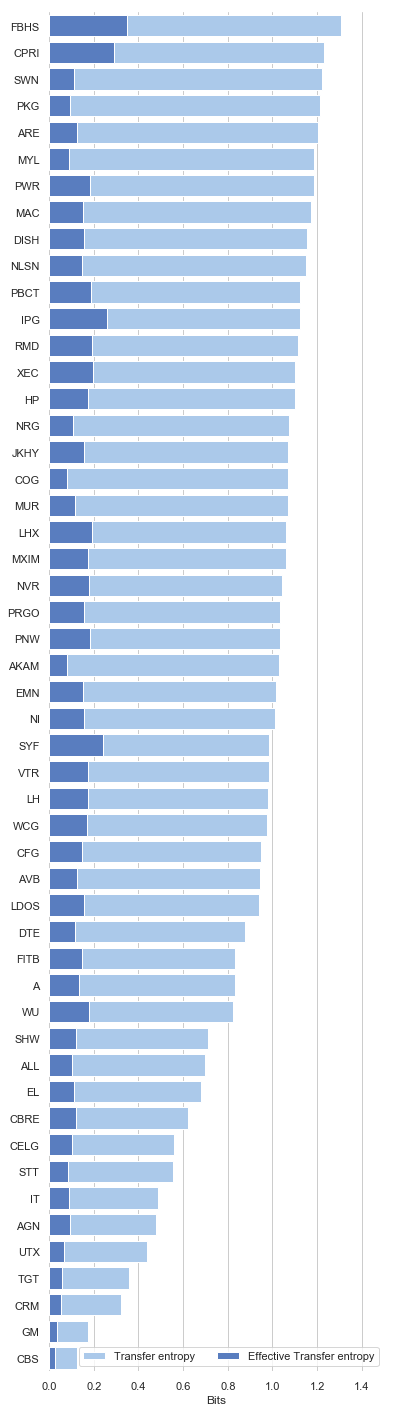

In [59]:

import matplotlib.pyplot as plt
sns.set(style="whitegrid" )

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 25))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="TE", y="ticker", data=df_TE_sort,
            label="Transfer entropy", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="ETE", y="ticker", data=df_TE_sort,
            label="Effective Transfer entropy", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0,1.5), ylabel="",
       xlabel="Bits")
sns.despine(left=True, bottom=True)



In [60]:
# get distribution of p-val 

df_TE_bootstrap_tickers_columns = pd.DataFrame(columns = ticker_pval)
for ticker in ticker_pval:
    df_TE_bootstrap = pd.DataFrame(columns = ["ticker", "direction", "TE", "ETE", "p-val", "pcc",  "pcc-p-val" ])

    sent_df = get_sentiment_company(ticker, ind_mat)
    
    if (SENT_TYPE==SENT_DIFF_SIGNAL):
        print("Using diff sentiment signal!")
        sent_df = create_diff_sent_df(sent_df)
    
    print(sent_df.head())
    print("Excess kurtosis")
    print(kurtosis(sent_df['pred_sentiment'].values,fisher=True))

    returns_df = get_hourly_returns(ticker, PATH_NBBO_RETURNS)
    print(returns_df.head())
    print(returns_df.shape)
    print("Excess kurtosis")
    print(kurtosis(returns_df['return'].values,fisher=True))

    ret = get_aligned_series(sent_df, returns_df)
    return_ticker_signal =  np.array(ret[0])
    sentiment_ticker_signal =  np.array(ret[1])
    sentiment_ticker_signal_time = ret[2]
    print("after aligning")
    print(len(sentiment_ticker_signal))

    ticker_TE_list = []
    for sim_idx in range(0,50):
        print(sim_idx)
        try:
            tmp_df_TE = transfer_entropy_stat(sentiment_ticker_signal, return_ticker_signal, ticker)
            df_TE_bootstrap = df_TE_bootstrap.append(tmp_df_TE)
            ticker_TE_list.append(float(tmp_df_TE[tmp_df_TE['direction'] == "sentiment->return"]["p-val"]))
        except:
            print("Something else went wrong with importa or TE calc")
    print("****************")
    print(ticker_TE_list)
         
    df_TE_bootstrap_tickers_columns[ticker] = ticker_TE_list
print("FINISHED") 

Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 15:30:00        0.128252
2018-05-15 11:30:00        0.346306
2018-05-17 14:30:00       -0.306790
           15:30:00       -0.120370
2018-07-18 12:30:00       -0.392541
Excess kurtosis
-0.14776858464527098


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000510
           11:30:00  0.000073
           12:30:00  0.000146
           13:30:00 -0.000510
           14:30:00 -0.000875
(2985, 1)
Excess kurtosis
18.340289935000783
after aligning
49
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
s

















Done - Total time
 
0.69
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times



















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-01-08 10:30:00 -0.007609
           11:30:00 -0.002350
           12:30:00  0.006818
           13:30:00  0.006033
           14:30:00 -0.005630
(1495, 1)
Excess kurtosis
6.350187838073543
after aligning
32
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
se
















Done - Total time
 
0.72
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















D

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.037070
           12:30:00  0.005106
2018-01-03 10:30:00 -0.016736
           12:30:00  0.005106
           13:30:00 -0.001693
(2535, 1)
Excess kurtosis
3.210665421140746
after aligning
33
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.6
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
sec

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005352
           11:30:00  0.005078
           12:30:00  0.002567
           13:30:00 -0.002804
           14:30:00  0.003994
(2976, 1)
Excess kurtosis
6.128653174295785
after aligning
39
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
se

















Done - Total time
 
0.62
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















D

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000573
           11:30:00 -0.712242
           12:30:00  2.462121
           13:30:00 -0.000921
           14:30:00  0.001268
(2975, 1)
Excess kurtosis
4.721431435830717
after aligning
33
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
sec

















Done - Total time
 
0.62
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times



















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008789
           11:30:00 -0.001510
           12:30:00  0.004188
           13:30:00  0.001506
           14:30:00  0.006594
(2929, 1)
Excess kurtosis
7.004322055758081
after aligning
41
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
sec

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004197
           11:30:00 -0.002280
           12:30:00 -0.001523
           13:30:00 -0.001907
           14:30:00  0.000127
(2983, 1)
Excess kurtosis
7.109971702823428
after aligning
47
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
se

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005066
           11:30:00  0.003235
           12:30:00  0.002475
           13:30:00 -0.000150
           14:30:00 -0.001047
(2983, 1)
Excess kurtosis
10.047624545982107
after aligning
46
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
s

















Done - Total time
 
0.73
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















D

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013612
           11:30:00  0.002137
           12:30:00  0.007513
           13:30:00  0.003930
           14:30:00  0.005822
(2948, 1)
Excess kurtosis
2027.8902843109968
after aligning
53
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
se

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000549
           11:30:00  0.003436
           12:30:00  0.007122
           13:30:00 -0.002448
           14:30:00 -0.003954
(2965, 1)
Excess kurtosis
17.365451634663646
after aligning
31
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
s

















Done - Total time
 
0.7
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















D

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000795
           11:30:00 -0.002653
           12:30:00 -0.000532
           13:30:00  0.000000
           14:30:00  0.474315
(2913, 1)
Excess kurtosis
24.688316222178642
after aligning
55
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
s

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.030936
           11:30:00  0.007002
           12:30:00  0.002980
           13:30:00 -0.003466
           14:30:00 -0.000994
(2960, 1)
Excess kurtosis
12.605528888839135
after aligning
54
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
s

















Done - Total time
 
0.79
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times



















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004108
           11:30:00  0.002981
           12:30:00  0.003030
           14:30:00 -0.005694
           15:30:00 -0.002805
(2960, 1)
Excess kurtosis
10.03574782229143
after aligning
48
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
se

















Done - Total time
 
0.73
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times



















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017440
           11:30:00 -0.003662
           12:30:00  0.007471
           13:30:00  0.004890
           14:30:00  0.001795
(2987, 1)
Excess kurtosis
7.060370257285829
after aligning
59
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
secon

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002837
           11:30:00 -0.002523
           12:30:00  0.002376
           13:30:00  0.002676
           14:30:00 -0.005339
(2986, 1)
Excess kurtosis
2.7997582577057774
after aligning
60
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
s

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000349
           11:30:00 -0.003845
           12:30:00  0.005966
           13:30:00 -0.002791
           14:30:00 -0.003149
(2982, 1)
Excess kurtosis
6.300019003538701
after aligning
53
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
se

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 12:30:00 -0.013169
           13:30:00  0.001641
           15:30:00 -0.000561
2018-01-03 10:30:00  0.001807
           11:30:00 -0.002920
(2913, 1)
Excess kurtosis
2011.7302199840533
after aligning
60
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
se

















Done - Total time
 
0.83
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Don

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005097
           11:30:00 -0.002798
           12:30:00  0.007365
           13:30:00  0.001741
           14:30:00 -0.002433
(2973, 1)
Excess kurtosis
5.532615935529357
after aligning
60
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
se

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010420
           11:30:00  0.004125
           12:30:00  0.007900
           13:30:00 -0.001568
           14:30:00 -0.000314
(2987, 1)
Excess kurtosis
7.157586336882856
after aligning
40
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
sec

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-07-01 11:30:00 -0.014520
           12:30:00  0.000680
           13:30:00 -0.008367
           14:30:00 -0.001644
           15:30:00 -0.010537
(861, 1)
Excess kurtosis
11.00714492476355
after aligning
51
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seco

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000666
           11:30:00 -0.000951
           12:30:00 -0.001237
           13:30:00  0.000286
           14:30:00  0.002381
(2980, 1)
Excess kurtosis
6.5906312145294255
after aligning
53
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
se

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004501
           11:30:00 -0.000064
           12:30:00  0.007630
           14:30:00  0.018451
           15:30:00 -0.004186
(2607, 1)
Excess kurtosis
11.925606063276325
after aligning
57
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
s

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.19
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y-

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.023141
           11:30:00 -0.000721
           12:30:00 -0.004660
           13:30:00 -0.004403
           14:30:00  0.002855
(2980, 1)
Excess kurtosis
22.73856021278728
after aligning
51
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
se

















Done - Total time
 
0.84
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times



















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003754
           11:30:00 -0.006123
           12:30:00 -0.000711
           13:30:00 -0.002608
           14:30:00 -0.002377
(2983, 1)
Excess kurtosis
15.273368558632349
after aligning
44
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
s

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007236
           11:30:00 -0.004968
           12:30:00  0.003456
           13:30:00  0.002220
           14:30:00  0.000229
(2971, 1)
Excess kurtosis
5.725150852713295
after aligning
64
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
se

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.22
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.16
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y-

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003704
           11:30:00  0.001337
           12:30:00  0.002083
           13:30:00  0.002398
           14:30:00 -0.000797
(2985, 1)
Excess kurtosis
12.274215101119385
after aligning
74
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
s

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X 

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005649
           11:30:00 -0.001959
           12:30:00 -0.000393
           13:30:00 -0.001178
           14:30:00 -0.001573
(2912, 1)
Excess kurtosis
56.83095026055016
after aligning
60
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
se

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.06
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002191
           11:30:00 -0.003601
           12:30:00  0.000516
           13:30:00  0.000258
           14:30:00 -0.003869
(2977, 1)
Excess kurtosis
129.22193118302303
after aligning
84
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
se

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 ti

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001328
           11:30:00 -0.001244
           12:30:00 -0.002159
           13:30:00  0.000166
           14:30:00 -0.003827
(2992, 1)
Excess kurtosis
8.998866238811688
after aligning
75
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
se

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y-

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001057
           11:30:00  0.000404
           12:30:00  0.005279
           13:30:00 -0.001853
           14:30:00  0.001362
(2983, 1)
Excess kurtosis
26.570725939706968
after aligning
64
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
s

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000938
           11:30:00 -0.001998
           12:30:00 -0.000297
           14:30:00 -0.000321
           15:30:00  0.000865
(2818, 1)
Excess kurtosis
8.678624763798215
after aligning
48
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
se

















Done - Total time
 
0.79
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















D

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002842
           11:30:00 -0.001653
           12:30:00  0.002602
           13:30:00 -0.002359
           14:30:00 -0.000709
(2987, 1)
Excess kurtosis
195.74278908343368
after aligning
66
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
s

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004200
           11:30:00  0.001040
           12:30:00  0.000899
           13:30:00 -0.000982
           14:30:00 -0.001770
(2973, 1)
Excess kurtosis
23.71333358035262
after aligning
64
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
se

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000619
           11:30:00 -0.003250
           12:30:00 -0.002484
           14:30:00 -0.002646
           15:30:00 -0.000780
(2969, 1)
Excess kurtosis
16.130361531560446
after aligning
64
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
s

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003059
           11:30:00 -0.002473
           12:30:00 -0.002204
           13:30:00  0.000782
           14:30:00 -0.000874
(2989, 1)
Excess kurtosis
5.673356066181084
after aligning
86
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
se

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y-

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001473
           11:30:00 -0.005571
           12:30:00 -0.001648
           14:30:00 -0.001981
           15:30:00  0.002977
(2954, 1)
Excess kurtosis
70.62842272309604
after aligning
106
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
s

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004973
           11:30:00  0.001108
           12:30:00 -0.003836
           13:30:00  0.000074
           14:30:00 -0.000148
(2988, 1)
Excess kurtosis
5.4321174075525
after aligning
100
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 


  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000262
           11:30:00 -0.003149
           12:30:00  0.003159
           13:30:00  0.000000
           14:30:00 -0.002624
(2879, 1)
Excess kurtosis
14.270356645065423
after aligning
120
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 120 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003685
           11:30:00 -0.001079
           12:30:00 -0.001783
           13:30:00  0.001264
           14:30:00  0.001578
(2983, 1)
Excess kurtosis
4.675542175973981
after aligning
142
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02


  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.23
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 142 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010077
           11:30:00 -0.003054
           12:30:00 -0.007342
           13:30:00  0.000539
           14:30:00 -0.003084
(2993, 1)
Excess kurtosis
10.328702459503406
after aligning
127
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000039
           11:30:00  0.001414
           12:30:00  0.001373
           13:30:00  0.000705
           14:30:00 -0.001174
(2987, 1)
Excess kurtosis
9.717386089244888
after aligning
141
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96


  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.06
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.06
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-03-20 10:30:00  0.006592
           12:30:00  0.003274
           13:30:00 -0.002948
           14:30:00 -0.001267
           15:30:00  0.008458
(2664, 1)
Excess kurtosis
3.77013540680073
after aligning
168
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.12
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002901
           11:30:00  0.008155
           12:30:00  0.001082
           13:30:00 -0.002819
           14:30:00  0.001225
(2615, 1)
Excess kurtosis
719.1908825361854
after aligning
204
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 204 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.14
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 204 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 204 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15


  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.23
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 204 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.24
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 204 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.24
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 204 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.24
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 204 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009062
           11:30:00 -0.004418
           12:30:00  0.000206
           13:30:00  0.001135
           14:30:00 -0.003401
(2987, 1)
Excess kurtosis
18.836849169687742
after aligning
200
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.12
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.13
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.17

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.21
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.21
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.22
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.21
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004946
           11:30:00  0.002380
           12:30:00  0.001771
           13:30:00  0.001165
           14:30:00 -0.000281
(2956, 1)
Excess kurtosis
32.83568389496022
after aligning
244
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
s

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.33
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.42
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.31
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.32
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 244 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.718367
           11:30:00  0.012098
           12:30:00  0.011536
           13:30:00  2.580303
           14:30:00 -0.719813
(2988, 1)
Excess kurtosis
44.234127432588046
after aligning
251
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.18
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.18
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.23

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.34
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.42
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.36
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.27
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002459
           11:30:00 -0.002465
           12:30:00 -0.001020
           13:30:00  0.001060
           14:30:00  0.002157
(2989, 1)
Excess kurtosis
7.509784698417828
after aligning
260
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 260 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.41
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 260 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 260 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.36
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 260 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.35
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 260 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.37
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 260 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.58
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 260 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012318
           11:30:00  0.006644
           12:30:00 -0.001483
           13:30:00  0.001931
           14:30:00  0.005633
(2992, 1)
Excess kurtosis
10.639953163973235
after aligning
362
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 362 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.53
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 362 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.54
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 362 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.66

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.63
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 362 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.64
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 362 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.59
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 362 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.64
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 362 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011003
           11:30:00  0.003371
           12:30:00  0.000096
           13:30:00  0.004847
           14:30:00 -0.004919
(2990, 1)
Excess kurtosis
7.950967218983186
after aligning
398
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.51
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.54
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.6
 

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.69
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.71
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.71
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.72
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 398 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009587
           11:30:00  0.001683
           12:30:00  0.002640
           13:30:00 -0.001197
           14:30:00 -0.000479
(2983, 1)
Excess kurtosis
5.755934093857384
after aligning
842
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 842 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.31
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 842 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.45
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 842 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.54


  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.51
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 842 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.67
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 842 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.52
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 842 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.46
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 842 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011893
           11:30:00  0.002029
           12:30:00  0.001603
           13:30:00  0.000674
           14:30:00 -0.003283
(2652, 1)
Excess kurtosis
36.281721254633744
after aligning
1189
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.75
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.93
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 


  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.27
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.13
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.09
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.13
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1189 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calcu

In [61]:
df_TE_bootstrap_tickers_columns.to_pickle("df_TE_bootstrap_tickers_columns_2018_2020_quantiles_5_25_50_75_95_pval_01_sent_diff_adf_01.pkl")
df_TE_bootstrap.to_pickle("df_TE_bootstrap_2018_2020_quantiles_5_25_50_75_95_pval_01_sent_diff_adf_01.pkl")

#df_TE_bootstrap_tickers_columns = pd.read_pickle("df_TE_bootstrap_tickers_columns_2018_2020_quantiles_5_25_50_75_95_pval_01_adf_01.pkl")
#df_TE_bootstrap = pd.read_pickle("df_TE_bootstrap_2018_2020_quantiles_5_25_50_75_95_pval_01_adf_01.pkl")

print(df_TE_bootstrap_tickers_columns)

ticker  FBHS      CPRI       SWN       PKG       ARE       MYL       PWR  \
0        0.0  0.000000  0.010000  0.000000  0.003333  0.000000  0.003333   
1        0.0  0.003333  0.010000  0.003333  0.003333  0.006667  0.003333   
2        0.0  0.000000  0.016667  0.006667  0.010000  0.010000  0.000000   
3        0.0  0.000000  0.010000  0.003333  0.010000  0.010000  0.003333   
4        0.0  0.000000  0.013333  0.003333  0.003333  0.010000  0.003333   
5        0.0  0.000000  0.003333  0.003333  0.000000  0.006667  0.000000   
6        0.0  0.000000  0.006667  0.013333  0.003333  0.006667  0.003333   
7        0.0  0.000000  0.010000  0.010000  0.003333  0.016667  0.000000   
8        0.0  0.000000  0.010000  0.013333  0.006667  0.003333  0.000000   
9        0.0  0.000000  0.006667  0.006667  0.003333  0.023333  0.000000   
10       0.0  0.000000  0.016667  0.010000  0.000000  0.016667  0.000000   
11       0.0  0.003333  0.000000  0.006667  0.000000  0.010000  0.000000   
12       0.0

/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


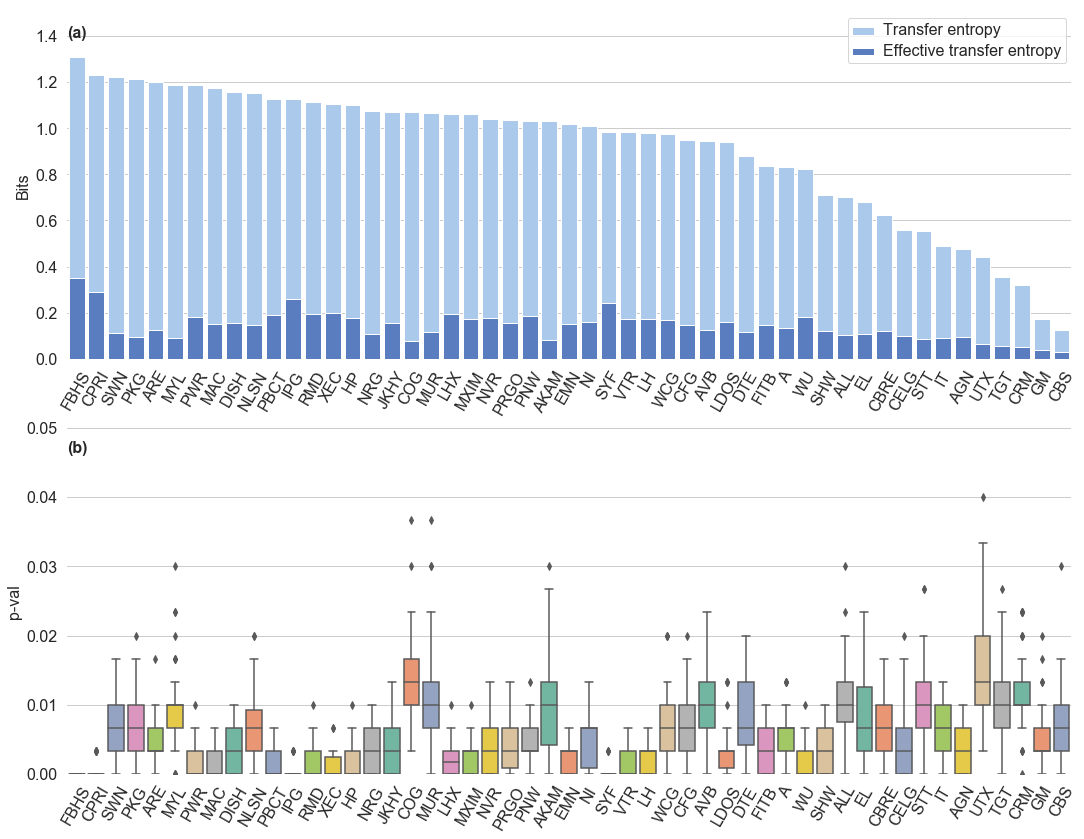

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
my_font_size = 16     
    
fig, ax =plt.subplots(2,1, figsize=(18, 14))
sns.boxplot(data=df_TE_bootstrap_tickers_columns, orient="v", palette="Set2",  ax=ax[1])
#sns.swarmplot( data=df_TE_bootstrap_tickers_columns, color=".25", ax=ax[1])
ax[1].set(ylim=(0,0.05), ylabel="p-val")
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=60)

ax[1].set_xlabel("",fontsize=my_font_size)
ax[1].set_ylabel("p-val",fontsize=my_font_size)
ax[1].tick_params(labelsize=my_font_size)
ax[1].set_title('(b)',fontsize=my_font_size, loc = 'left',fontweight="bold", pad = -25)

sns.set_color_codes("pastel")
sns.barplot(y="TE", x="ticker", data=df_TE_sort,
            label="Transfer entropy", color="b",orient="v", ax=ax[0])


sns.set_color_codes("muted")
sns.barplot(y="ETE", x="ticker", data=df_TE_sort,
            label="Effective transfer entropy", color="b", orient="v", ax=ax[0])

# Add a legend and informative axis label
ax[0].legend(ncol=1, loc="upper right", frameon=True)
ax[0].set(ylim=(0,1.5), ylabel="Bits")
sns.despine(left=True, bottom=True)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=60)

ax[0].set_xlabel("",fontsize=my_font_size)
ax[0].set_ylabel("Bits",fontsize=my_font_size)
ax[0].tick_params(labelsize=my_font_size)
ax[0].set_title('(a)',fontsize=my_font_size, loc = 'left',fontweight="bold", pad = -25)


plt.setp(ax[0].get_legend().get_texts(), fontsize=my_font_size)


fig.show()
fig.savefig("TransEntropyStat_p_val_01_sent_diff_adf_01.pdf",bbox_inches = 'tight', pad_inches = 0) 

In [63]:
# Multiple trial correction .....

In [64]:
#The Benjamini–Yekutieli procedure controls the false discovery rate under arbitrary dependence assumptions
#Benjamini, Yoav; Yekutieli, Daniel (2001). "The control of the false discovery rate in multiple testing under dependency" (PDF). Annals of Statistics. 29 (4): 1165–1188.

idx_filter = df_TE['pcc'].notnull()
idx_filter_direction = df_TE['direction'] == "sentiment->return"
idx_filter_adf = df_TE['p-val-ADF-sent']<0.01
df_TE_direction = df_TE[idx_filter&idx_filter_direction&idx_filter_adf]

s = np.array(df_TE_direction['p-val'])
sort_index = np.argsort(s) 
pval_sort = s[sort_index]

m = s.shape[0]
print(m)
alpha = 0.05; #FDR ....
c_m = np.sum(np.array([1/i for i in range(1,m+1)]))
print("corr c(m)")
print(c_m)
correction = np.array([(alpha*k)/(m*c_m) for k in range(1,m+1)])
bh_corr_idx = pval_sort <= correction #rejection 
#print(pval_sort)
#print(correction)


print(df_TE_direction.iloc[sort_index[bh_corr_idx]])
ticker_pval_BY = df_TE_direction.iloc[sort_index[bh_corr_idx]]['ticker']
print(len(ticker_pval))

df_TE_sort = df_TE_direction.iloc[sort_index[bh_corr_idx]]

497
corr c(m)
6.786811389845979
  ticker          direction        TE       ETE  p-val       pcc  pcc-p-val  \
0    VTR  sentiment->return  0.983453  0.171662    0.0 -0.014729   0.900187   
0    RMD  sentiment->return  1.115520  0.192622    0.0  0.135212   0.359511   
0   DISH  sentiment->return  1.156495  0.155864    0.0  0.167904   0.229454   
0    CRM  sentiment->return  0.320719  0.051268    0.0  0.027320   0.586839   
0   PRGO  sentiment->return  1.033379  0.156967    0.0  0.182324   0.200356   
0    SYF  sentiment->return  0.985267  0.239903    0.0  0.009323   0.932923   
0   FBHS  sentiment->return  1.306977  0.349280    0.0  0.010596   0.942398   
0    XEC  sentiment->return  1.102929  0.198182    0.0 -0.119546   0.367141   
0    CBS  sentiment->return  0.125749  0.027578    0.0 -0.017736   0.541217   
0    IPG  sentiment->return  1.124992  0.257567    0.0  0.022562   0.871356   
0    PWR  sentiment->return  1.185177  0.181271    0.0 -0.108610   0.467411   
0    EMN  sentiment-

/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


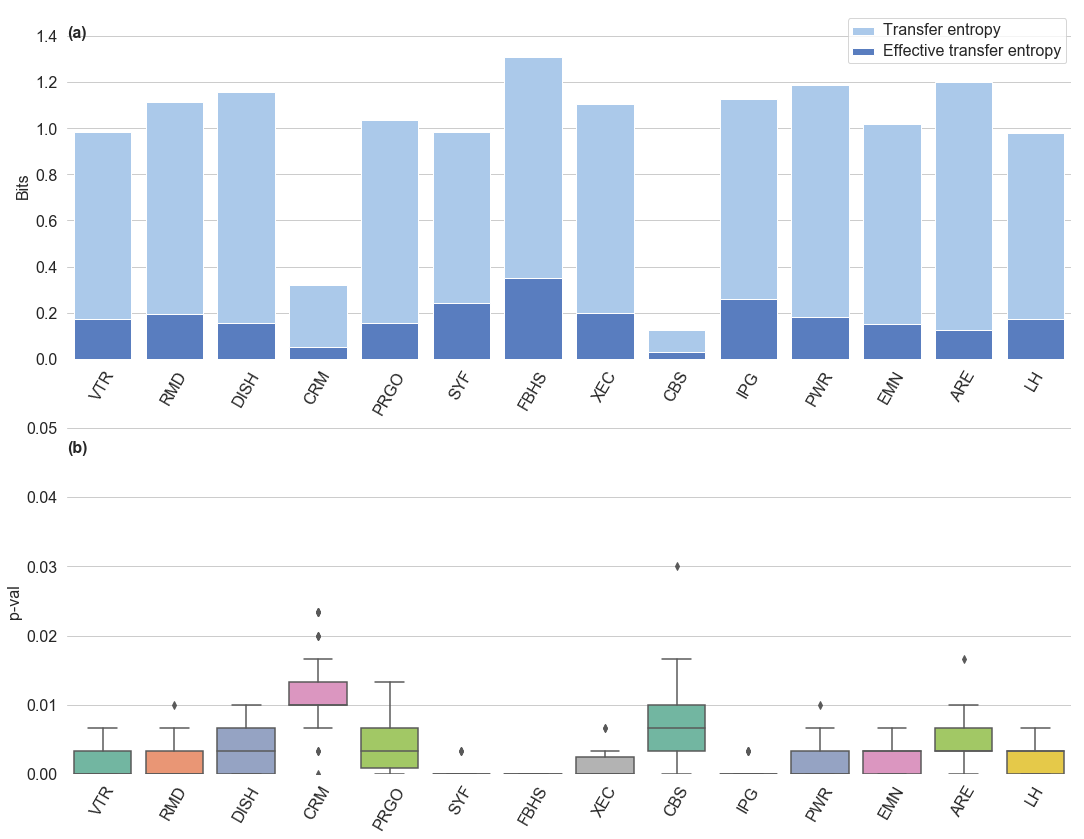

In [65]:
# select distribution of p-val based on correction

df_TE_bootstrap_tickers_columns_BY = df_TE_bootstrap_tickers_columns[ticker_pval_BY]

sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
my_font_size = 16     
    
fig, ax =plt.subplots(2,1, figsize=(18, 14))
sns.boxplot(data=df_TE_bootstrap_tickers_columns_BY, orient="v", palette="Set2",  ax=ax[1])
#sns.swarmplot( data=df_TE_bootstrap_tickers_columns_BY, color=".25", ax=ax[1])
ax[1].set(ylim=(0,0.05), ylabel="p-val")
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=60)

ax[1].set_xlabel("",fontsize=my_font_size)
ax[1].set_ylabel("p-val",fontsize=my_font_size)
ax[1].tick_params(labelsize=my_font_size)
ax[1].set_title('(b)',fontsize=my_font_size, loc = 'left',fontweight="bold", pad = -25)

sns.set_color_codes("pastel")
sns.barplot(y="TE", x="ticker", data=df_TE_sort,
            label="Transfer entropy", color="b",orient="v", ax=ax[0])


sns.set_color_codes("muted")
sns.barplot(y="ETE", x="ticker", data=df_TE_sort,
            label="Effective transfer entropy", color="b", orient="v", ax=ax[0])

# Add a legend and informative axis label
ax[0].legend(ncol=1, loc="upper right", frameon=True)
ax[0].set(ylim=(0,1.5), ylabel="Bits")
sns.despine(left=True, bottom=True)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=60)

ax[0].set_xlabel("",fontsize=my_font_size)
ax[0].set_ylabel("Bits",fontsize=my_font_size)
ax[0].tick_params(labelsize=my_font_size)
ax[0].set_title('(a)',fontsize=my_font_size, loc = 'left',fontweight="bold", pad = -25)


plt.setp(ax[0].get_legend().get_texts(), fontsize=my_font_size)


fig.show()
fig.savefig("TransEntropyStat_p_val_01_BY_05_sent_diff_adf_01.pdf", bbox_inches = 'tight', pad_inches = 0) 

In [66]:

##lagged data experiments


In [67]:
#speed of information transfer by having a lag with contraint on intraday *** time_series_safe
lag = +1
df_TE_lag = pd.DataFrame(columns = ["ticker", "direction", "TE", "ETE", "p-val", "pcc",  "pcc-p-val" ])
#for ticker in ticker_pval:
for ticker in companies:
    try:
        print(ticker)
        sent_df = get_sentiment_company(ticker, ind_mat)
        
        if (SENT_TYPE==SENT_DIFF_SIGNAL):
            print("Using diff sentiment signal!")
            sent_df = create_diff_sent_df(sent_df)
        
        print(sent_df.head())
        print("Excess kurtosis")
        print(kurtosis(sent_df['pred_sentiment'].values,fisher=True))
        
        result = adfuller(sent_df['pred_sentiment'])
        p_val_adf = result[1]
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')

        returns_df = get_hourly_returns(ticker, PATH_NBBO_RETURNS)
        print(returns_df.head())
        print(returns_df.shape)
        print("Excess kurtosis")
        print(kurtosis(returns_df['return'].values,fisher=True))
        
        ret = get_aligned_series_lag(sent_df, returns_df, lag)
        return_ticker_signal =  np.array(ret[0])
        return_ticker_signal_time = ret[1]
        sentiment_ticker_signal =  np.array(ret[2])
        sentiment_ticker_signal_time = ret[3]
        print("after aligning")
        print(len(sentiment_ticker_signal))
        
        #CAUTION -- do not use lag in transfer_entropy_stat fun together with get_aligned_series_lag function!!!
        #get_aligned_series_lag function -- is intraday lag i.e. there is not offset to next day
        tmp_df_TE = transfer_entropy_stat(sentiment_ticker_signal, return_ticker_signal, ticker)
        
        tmp_df_TE['p-val-ADF-sent'] = p_val_adf
        
        df_TE_lag = df_TE_lag.append(tmp_df_TE)
    except:
        print("Something else went wrong with imports or TE calc")
print("FINISHED")

SHW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-28 11:30:00        0.282886
2018-03-14 11:30:00       -0.132371
2018-03-20 12:30:00       -0.111990
2018-04-04 11:30:00       -0.324832
2018-04-09 15:30:00        0.335205
Excess kurtosis
0.7209149522723304
ADF Statistic: -5.824223
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003685
           11:30:00 -0.001079
           12:30:00 -0.001783
           13:30:00  0.001264
           14:30:00  0.001578
(2983, 1)
Excess kurtosis
4.675542175973981
after aligning
127
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

CAH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-08 11:30:00        0.665140
2018-02-16 12:30:00       -0.137003
2018-03-05 14:30:00       -0.280097
2018-05-03 11:30:00       -0.166937
           12:30:00       -0.084257
Excess kurtosis
-0.21240684105760543
ADF Statistic: -6.214971
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010821
           11:30:00 -0.002557
           12:30:00  0.007449
           13:30:00  0.000318
           14:30:00 -0.000397
(2989, 1)
Excess kurtosis
8.077561173285158
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

PPG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 10:30:00        0.167640
2018-04-12 11:30:00        0.137544
           14:30:00       -0.287984
2018-06-12 15:30:00       -0.207472
2018-06-15 10:30:00        0.609430
Excess kurtosis
0.10211380644132761
ADF Statistic: -7.484512
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002945
           11:30:00 -0.003277
           12:30:00  0.002178
           13:30:00  0.000128
           14:30:00  0.002002
(2979, 1)
Excess kurtosis
4.262082816535241
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

JKHY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-25 12:30:00       -0.448670
2018-07-03 10:30:00        0.002321
2018-07-10 10:30:00        0.164230
2018-07-17 10:30:00        0.021582
2018-07-24 10:30:00        0.113733
Excess kurtosis
1.474531557396963
ADF Statistic: -4.257844
p-value: 0.000525
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 12:30:00 -0.013169
           13:30:00  0.001641
           15:30:00 -0.000561
2018-01-03 10:30:00  0.001807
           11:30:00 -0.002920
(2913, 1)
Excess kurtosis
2011.7302199840533
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

CNC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00        0.255085
2018-01-10 11:30:00       -0.274281
2018-02-06 12:30:00        0.170743
2018-03-05 10:30:00       -0.205997
2018-03-22 13:30:00        0.134850
Excess kurtosis
-0.07053456534657832
ADF Statistic: -7.203618
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017028
           11:30:00 -0.007566
           12:30:00  0.003295
           13:30:00 -0.001226
           14:30:00 -0.002012
(2989, 1)
Excess kurtosis
6.908674392894962
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

CELG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00        0.080906
2018-01-08 10:30:00       -0.109073
           11:30:00        0.218695
2018-01-17 12:30:00        0.464784
2018-01-18 13:30:00       -0.481362
Excess kurtosis
0.4789029054884453
ADF Statistic: -8.900591
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002901
           11:30:00  0.008155
           12:30:00  0.001082
           13:30:00 -0.002819
           14:30:00  0.001225
(2615, 1)
Excess kurtosis
719.1908825361854
after aligning
181
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 181 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

EMR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 15:30:00       -0.101440
2018-04-06 10:30:00        0.153554
           12:30:00        0.315504
2018-05-09 15:30:00       -0.624966
2018-05-15 11:30:00        0.428748
Excess kurtosis
0.45694820235659384
ADF Statistic: -7.091576
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003270
           11:30:00 -0.003281
           12:30:00  0.002362
           13:30:00  0.004355
           14:30:00 -0.001493
(2990, 1)
Excess kurtosis
7.965322887885662
after aligning
131
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 131 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

HON
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 13:30:00        0.285507
2018-01-26 11:30:00       -0.218650
           14:30:00       -0.127010
2018-02-08 10:30:00        0.159808
2018-02-14 15:30:00       -0.023388
Excess kurtosis
0.5418683867270007
ADF Statistic: -12.202198
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003477
           11:30:00 -0.001337
           12:30:00  0.000033
           13:30:00  0.000457
           14:30:00  0.000849
(2987, 1)
Excess kurtosis
1428.6098668906686
after aligning
285
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 285 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
seconds

MAC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 11:30:00       -0.612908
2018-04-20 10:30:00        0.034109
2018-05-16 14:30:00        0.127650
2018-06-14 11:30:00       -0.195560
2018-07-30 11:30:00        0.325570
Excess kurtosis
-0.2818427454516903
ADF Statistic: -5.158056
p-value: 0.000011
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005066
           11:30:00  0.003235
           12:30:00  0.002475
           13:30:00 -0.000150
           14:30:00 -0.001047
(2983, 1)
Excess kurtosis
10.047624545982107
after aligning
37
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 37 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

MAR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-14 12:30:00       -0.268340
2018-08-15 12:30:00        0.045961
2018-08-23 13:30:00        0.164031
2018-10-04 12:30:00       -0.031941
2018-11-30 14:30:00       -0.425448
Excess kurtosis
-0.2923784713452653
ADF Statistic: -9.253227
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009816
           11:30:00 -0.008870
           12:30:00 -0.001166
           13:30:00 -0.003689
           14:30:00  0.005668
(2991, 1)
Excess kurtosis
6.085310272610238
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

NFX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-15 15:30:00       -0.394612
2018-07-27 13:30:00        0.220852
2018-07-30 11:30:00       -0.039933
2018-08-01 15:30:00        0.169421
2018-09-12 10:30:00       -0.550421
Excess kurtosis
-0.7200270861338973
ADF Statistic: -6.508835
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013488
           11:30:00 -0.002476
           12:30:00  0.007912
           13:30:00 -0.000462
           14:30:00 -0.001386
(1636, 1)
Excess kurtosis
2.6474019363506223
after aligning
13
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 13 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

PSA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-22 12:30:00        0.139432
2018-03-27 15:30:00       -0.204812
2018-03-29 14:30:00        0.552407
2018-04-10 15:30:00       -0.241097
2018-05-17 14:30:00       -0.247170
Excess kurtosis
0.45340390342132375
ADF Statistic: -5.751191
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.018246
           11:30:00  7.285172
           12:30:00  0.002557
           13:30:00  0.001347
           14:30:00 -0.004757
(2990, 1)
Excess kurtosis
2.3234300875996867
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

VRTX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-17 10:30:00       -0.176155
2018-07-23 11:30:00        0.610612
2018-07-24 12:30:00       -0.569686
2018-07-26 12:30:00       -0.220606
           15:30:00        0.587552
Excess kurtosis
0.6102791898626476
ADF Statistic: -6.969938
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012456
           11:30:00  0.005192
           12:30:00  0.002632
           13:30:00  0.001214
           14:30:00 -0.001049
(2982, 1)
Excess kurtosis
5.281411068385392
after aligning
96
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 96 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15
 
seconds

M
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00       -0.690293
           12:30:00        0.360060
           13:30:00        0.023240
           14:30:00       -0.396746
           15:30:00        0.040837
Excess kurtosis
-0.18788038350021097
ADF Statistic: -10.006325
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007756
           11:30:00 -0.002309
           12:30:00  0.005014
           13:30:00 -0.001919
           14:30:00  0.003076
(2987, 1)
Excess kurtosis
8.061056076814234
after aligning
280
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 280 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.37
 
seconds

DRE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 13:30:00        0.017333
2018-07-23 11:30:00       -0.318014
2018-07-27 12:30:00        0.331348
           14:30:00        0.034433
           15:30:00        0.139646
Excess kurtosis
-0.3219518316358867
ADF Statistic: -5.437307
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002570
           11:30:00 -0.002945
           12:30:00 -0.000369
           13:30:00 -0.005910
           14:30:00  0.001115
(2968, 1)
Excess kurtosis
3.675103243815064
after aligning
41
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

MGM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 13:30:00        0.493064
2018-02-15 11:30:00       -0.460862
2018-02-28 10:30:00        0.260172
2018-03-01 14:30:00       -0.030201
2018-03-09 12:30:00       -0.284628
Excess kurtosis
-0.5967922401586034
ADF Statistic: -8.000895
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010008
           11:30:00  0.005104
           12:30:00 -0.003286
           13:30:00 -0.000899
           14:30:00  0.003000
(2976, 1)
Excess kurtosis
4.453894461141673
after aligning
107
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 107 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

VNO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-15 10:30:00       -0.185980
2018-07-20 11:30:00        0.070137
2018-08-03 15:30:00        0.027496
2018-08-16 14:30:00       -0.084511
2018-08-22 11:30:00       -0.047952
Excess kurtosis
6.171505697220075
ADF Statistic: -6.050259
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.012893
           11:30:00 -0.672616
           12:30:00  2.055303
           13:30:00  0.001422
           14:30:00  0.002518
(2985, 1)
Excess kurtosis
14.192712977878305
after aligning
38
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 38 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

VLO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 12:30:00        0.322074
2018-03-28 11:30:00       -0.233225
2018-04-03 14:30:00        0.245871
2018-04-26 14:30:00       -0.092615
2018-04-30 14:30:00        0.130088
Excess kurtosis
1.2566673655591751
ADF Statistic: -5.343072
p-value: 0.000004
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009366
           11:30:00  0.002320
           12:30:00 -0.000700
           13:30:00 -0.001346
           14:30:00 -0.000701
(2989, 1)
Excess kurtosis
4.554602753082034
after aligning
126
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 126 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.17
 
seconds

CHK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-23 12:30:00        0.076245
2018-02-02 14:30:00       -0.127992
2018-02-05 10:30:00        0.221228
2018-02-12 11:30:00        0.091035
2018-02-13 10:30:00       -0.162247
Excess kurtosis
2.685026542269691
ADF Statistic: -8.714054
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.019876
           12:30:00  0.007308
           13:30:00  0.002418
           14:30:00 -0.007238
2018-01-03 10:30:00 -0.007273
(2583, 1)
Excess kurtosis
38.00974471514635
after aligning
148
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 148 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

EXC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 15:30:00        0.159443
2018-03-12 11:30:00       -0.244122
2018-04-03 10:30:00       -0.057524
2018-04-11 13:30:00        0.249922
2018-04-17 10:30:00        0.105981
Excess kurtosis
0.11806778192823364
ADF Statistic: -10.415941
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003292
           11:30:00 -0.004796
           12:30:00  0.001015
           13:30:00  0.001774
           14:30:00 -0.000253
(2967, 1)
Excess kurtosis
4.5439792503940275
after aligning
109
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 109 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

ACN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 15:30:00       -0.206242
2018-01-23 14:30:00        0.459628
           15:30:00        0.160569
2018-01-30 10:30:00       -0.383793
2018-02-15 14:30:00       -0.008586
Excess kurtosis
0.4149494194465979
ADF Statistic: -9.939042
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001043
           11:30:00  0.001726
           12:30:00 -0.003512
           13:30:00  0.001664
           14:30:00  0.001238
(2988, 1)
Excess kurtosis
5.896145560351615
after aligning
268
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 268 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.16
 
seconds

DOV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-27 12:30:00       -0.546747
           13:30:00       -0.022272
2018-07-25 10:30:00        0.359407
2018-07-26 14:30:00       -0.216467
2018-08-31 10:30:00        0.227466
Excess kurtosis
0.10549672409672706
ADF Statistic: -3.655310
p-value: 0.004788
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000839
           11:30:00 -0.001137
           12:30:00  0.001534
           13:30:00  0.003211
           14:30:00 -0.001723
(2981, 1)
Excess kurtosis
2972.4934738466827
after aligning
45
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 45 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

MAS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 11:30:00        0.063898
           12:30:00       -0.467497
2018-04-10 11:30:00       -0.213583
2018-04-11 12:30:00        0.353096
2018-04-24 13:30:00       -0.322610
Excess kurtosis
-0.46296645185165053
ADF Statistic: -8.227503
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006902
           11:30:00 -0.003190
           12:30:00 -0.001600
           13:30:00  0.000000
           14:30:00 -0.001145
(2985, 1)
Excess kurtosis
8.438927312646273
after aligning
84
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

ESS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-17 10:30:00       -0.212635
2018-07-30 11:30:00       -0.267151
2018-07-31 10:30:00        0.147664
2018-08-02 10:30:00       -0.095673
           14:30:00        0.278761
Excess kurtosis
0.7529268098170476
ADF Statistic: -6.071855
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003643
           11:30:00  0.005173
           12:30:00 -0.000434
           13:30:00 -0.002460
           14:30:00 -0.000497
(2960, 1)
Excess kurtosis
14.208601081667869
after aligning
29
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 29 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

WELL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00        0.019515
2018-04-25 13:30:00       -0.483018
           14:30:00        0.147708
2018-04-30 12:30:00        0.127812
2018-07-25 11:30:00       -0.218360
Excess kurtosis
0.7927517663204089
ADF Statistic: -7.098652
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-02-28 10:30:00 -0.011873
           11:30:00  0.006152
           12:30:00  0.003535
           13:30:00 -0.000762
           14:30:00  0.000000
(2761, 1)
Excess kurtosis
8.475835708523478
after aligning
71
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 71 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

INTU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-11 13:30:00        0.234804
2018-02-15 12:30:00        0.336513
2018-02-28 12:30:00       -0.546837
2018-03-09 11:30:00        0.326686
2018-03-12 13:30:00       -0.316280
Excess kurtosis
-0.24561279595911945
ADF Statistic: -6.681614
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003790
           11:30:00 -0.000888
           12:30:00 -0.001872
           13:30:00  0.000477
           14:30:00  0.001398
(2987, 1)
Excess kurtosis
6.958074391658723
after aligning
145
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 145 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.17
 
seconds

SPGI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-07 13:30:00       -0.037498
2018-02-20 13:30:00        0.199870
2018-02-21 12:30:00        0.095370
2018-02-22 14:30:00        0.405779
2018-03-02 10:30:00       -0.509075
Excess kurtosis
0.668029785741254
ADF Statistic: -10.497313
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003260
           11:30:00 -0.006070
           12:30:00 -0.000534
           13:30:00 -0.000949
           14:30:00  0.000891
(2974, 1)
Excess kurtosis
12.519192714998788
after aligning
548
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 548 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.77
 
seconds

FTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-28 11:30:00       -0.198994
2018-03-27 12:30:00       -0.080902
2018-03-28 15:30:00        0.011963
2018-04-11 15:30:00        0.511466
2018-04-12 15:30:00       -0.518700
Excess kurtosis
-0.5163255252886039
ADF Statistic: -3.362115
p-value: 0.012320
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.028634
           11:30:00  0.004283
           12:30:00  0.019900
           13:30:00  0.006969
2018-01-03 10:30:00 -0.025034
(2153, 1)
Excess kurtosis
7.21531322559756
after aligning
14
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 14 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

HBAN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-09 11:30:00        0.182441
2018-05-14 11:30:00       -0.031481
2018-05-17 10:30:00       -0.032382
2018-07-19 13:30:00       -0.117759
2018-07-23 11:30:00        0.324426
Excess kurtosis
-0.33978560453626816
ADF Statistic: -5.943777
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.476711
           11:30:00 -0.002739
           12:30:00  0.000687
           13:30:00 -0.000686
           14:30:00 -0.002746
(2973, 1)
Excess kurtosis
741.9913342809026
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

TDG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-16 10:30:00        0.487683
2018-03-19 11:30:00       -0.352955
2018-03-27 12:30:00        0.001314
2018-04-03 12:30:00        0.262275
2018-04-04 13:30:00        0.285547
Excess kurtosis
0.4255744380482316
ADF Statistic: -6.067815
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006622
           11:30:00 -0.003434
           12:30:00  0.006744
           13:30:00 -0.001984
           14:30:00  0.000584
(2968, 1)
Excess kurtosis
9.375780800340149
after aligning
62
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

ES
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 13:30:00       -0.654176
2018-01-26 10:30:00        0.176522
2018-01-31 14:30:00       -0.074644
2018-02-14 11:30:00       -0.371506
2018-02-23 15:30:00        0.301493
Excess kurtosis
-0.21882895643228695
ADF Statistic: -4.996852
p-value: 0.000023
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003955
           11:30:00 -0.005560
           12:30:00  0.002715
           13:30:00  0.003027
           14:30:00 -0.000953
(2990, 1)
Excess kurtosis
47.88226552515537
after aligning
91
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 91 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

CDNS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 12:30:00       -0.112153
2018-04-06 12:30:00        0.166973
2018-04-10 14:30:00       -0.086776
2018-04-11 15:30:00        0.104349
2018-06-15 13:30:00        0.422083
Excess kurtosis
0.1099165342039381
ADF Statistic: -10.120980
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003818
           11:30:00 -0.000119
           12:30:00 -0.003804
           15:30:00  0.001909
2018-01-03 10:30:00  0.007358
(2956, 1)
Excess kurtosis
24.58098116333988
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

DRI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-18 14:30:00        0.421245
2018-06-15 10:30:00       -0.541429
2018-06-21 11:30:00       -0.171328
2018-07-27 12:30:00        0.085397
2018-08-03 13:30:00       -0.167346
Excess kurtosis
-0.3757275586798574
ADF Statistic: -7.084838
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006363
           11:30:00  0.000260
           12:30:00 -0.001093
           13:30:00 -0.002032
           14:30:00  0.001514
(2983, 1)
Excess kurtosis
6.323635244380343
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

AMCR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-02 11:30:00       -0.355556
2018-08-03 12:30:00        0.394992
2018-08-06 10:30:00       -0.429908
           11:30:00        0.218459
           12:30:00       -0.457669
Excess kurtosis
-0.7135345792085608
ADF Statistic: -4.802057
p-value: 0.000054
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-06-11 10:30:00  0.003589
           11:30:00  0.000000
           12:30:00 -0.001788
           13:30:00 -0.002687
           14:30:00  0.007185
(790, 1)
Excess kurtosis
5.215955875768049
after aligning
21
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
DG


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 12:30:00        0.115652
2018-02-08 13:30:00        0.264988
2018-02-16 11:30:00       -0.022606
           13:30:00       -0.024931
2018-03-02 12:30:00       -0.056737
Excess kurtosis
0.03574425606134923
ADF Statistic: -6.661154
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003415
           11:30:00  0.003829
           12:30:00 -0.001377
           13:30:00 -0.001167
           14:30:00  0.002868
(2987, 1)
Excess kurtosis
5.825024597445903
after aligning
173
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 173 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.3
 
seconds

TEL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 10:30:00        0.353312
2018-04-05 10:30:00        0.052771
2018-06-15 13:30:00       -0.112535
2018-07-02 13:30:00       -0.279191
2018-07-11 10:30:00        0.557610
Excess kurtosis
-0.4763730773903596
ADF Statistic: -7.236326
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001886
           11:30:00 -0.007348
           12:30:00 -0.000582
           13:30:00 -0.002487
           14:30:00  0.005410
(2986, 1)
Excess kurtosis
5.849559704461065
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

DLTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-22 11:30:00       -0.298840
2018-03-02 12:30:00       -0.259405
2018-03-07 12:30:00        0.424089
2018-03-09 15:30:00        0.069677
2018-03-12 10:30:00        0.004431
Excess kurtosis
-0.09004035281937384
ADF Statistic: -6.222622
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003360
           11:30:00  0.004896
           12:30:00 -0.001563
           13:30:00 -0.000276
           14:30:00  0.003454
(2985, 1)
Excess kurtosis
24.363386781208646
after aligning
151
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 151 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

AXP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 14:30:00       -0.020059
2018-01-17 13:30:00       -0.248758
2018-01-18 12:30:00        0.025597
2018-01-19 11:30:00       -0.208659
2018-01-24 14:30:00        0.214923
Excess kurtosis
0.44382533172426575
ADF Statistic: -8.445175
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002712
           11:30:00 -0.007656
           12:30:00  0.000203
           13:30:00  0.003856
           14:30:00 -0.000809
(2990, 1)
Excess kurtosis
3.7936784164686888
after aligning
326
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 326 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.32
 
seconds

AMZN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 12:30:00       -0.025910
           13:30:00        0.253221
           14:30:00       -0.302416
           15:30:00        0.236870
2018-01-03 10:30:00       -0.144680
Excess kurtosis
0.82770614095045
ADF Statistic: -16.701559
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008025
           11:30:00  0.000697
           12:30:00  0.002635
           13:30:00  0.000547
           14:30:00 -0.000130
(2997, 1)
Excess kurtosis
6.734652524628563
after aligning
2440
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 2440 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.19
 
seconds

LEG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-20 11:30:00        0.190370
2018-05-15 11:30:00        0.090588
2018-06-14 14:30:00       -0.147936
2018-07-19 13:30:00       -0.096275
2018-07-25 12:30:00        0.147558
Excess kurtosis
-0.7232680431120828
ADF Statistic: -6.288237
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000628
           11:30:00 -0.003352
           12:30:00  0.003994
           13:30:00 -0.001047
           14:30:00  0.002410
(2979, 1)
Excess kurtosis
17.23715516930083
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

WCG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-01 12:30:00       -0.072084
2018-05-15 13:30:00       -0.116220
2018-06-15 10:30:00        0.344750
2018-07-24 10:30:00       -0.424078
2018-07-30 11:30:00       -0.180864
Excess kurtosis
-0.7117893154601633
ADF Statistic: -5.145899
p-value: 0.000011
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000938
           11:30:00 -0.001998
           12:30:00 -0.000297
           14:30:00 -0.000321
           15:30:00  0.000865
(2818, 1)
Excess kurtosis
8.678624763798215
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

CPRI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-10-16 10:30:00       -0.536965
2018-12-31 10:30:00       -0.074442
           11:30:00        0.248963
2019-01-03 15:30:00        0.572554
2019-02-06 12:30:00       -0.666879
Excess kurtosis
-0.18313404118447574
ADF Statistic: -8.347028
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-01-08 10:30:00 -0.007609
           11:30:00 -0.002350
           12:30:00  0.006818
           13:30:00  0.006033
           14:30:00 -0.005630
(1495, 1)
Excess kurtosis
6.350187838073543
after aligning
26
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 26 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

MHK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00       -0.034529
           15:30:00        0.399345
2018-06-15 11:30:00       -0.026491
2018-07-23 11:30:00        0.297930
2018-07-24 10:30:00       -0.555936
Excess kurtosis
-0.30104894430397966
ADF Statistic: -5.852163
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004379
           11:30:00  0.001072
           12:30:00 -0.002596
           13:30:00 -0.000582
           14:30:00  0.003843
(2977, 1)
Excess kurtosis
10.427182673425362
after aligning
71
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 71 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

FFIV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 13:30:00        0.473195
2018-01-25 14:30:00       -0.732271
2018-02-26 14:30:00        0.702173
2018-04-24 15:30:00       -0.593883
2018-07-24 11:30:00        0.840497
Excess kurtosis
0.6174853881640936
ADF Statistic: -10.092956
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007629
           11:30:00 -0.004181
           12:30:00 -0.002005
           14:30:00  0.000531
           15:30:00  0.000909
(2959, 1)
Excess kurtosis
4.834434892979682
after aligning
58
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 58 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

ULTA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 15:30:00       -0.351675
2018-03-21 15:30:00        0.310535
2018-03-27 15:30:00       -0.432225
2018-04-02 11:30:00        0.059141
2018-04-05 10:30:00        0.492357
Excess kurtosis
-0.27504224548955536
ADF Statistic: -10.876076
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013519
           11:30:00  0.009155
           12:30:00  0.001780
           13:30:00 -0.003726
           14:30:00 -0.002414
(2982, 1)
Excess kurtosis
6.690630674768343
after aligning
95
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 95 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

CME
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 13:30:00       -0.454226
2018-01-16 12:30:00        0.856918
2018-02-01 12:30:00       -0.549338
           15:30:00        0.019847
2018-02-13 15:30:00        0.001063
Excess kurtosis
0.0927899794417062
ADF Statistic: -8.412665
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004721
           11:30:00 -0.000412
           12:30:00 -0.001341
           13:30:00 -0.003306
           14:30:00  0.000069
(2983, 1)
Excess kurtosis
5.964275128630632
after aligning
212
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 212 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

EA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00       -0.067930
2018-01-05 13:30:00        0.064834
2018-01-09 11:30:00       -0.048088
           14:30:00        0.304813
2018-01-11 13:30:00        0.130052
Excess kurtosis
0.22427755432694152
ADF Statistic: -9.580852
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.026342
           11:30:00 -0.004147
           12:30:00  0.006339
           13:30:00  0.001563
           14:30:00  0.004499
(2987, 1)
Excess kurtosis
7.436248880426122
after aligning
193
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 193 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.06
 
seconds

ZION
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-03 13:30:00        0.158823
2018-08-23 10:30:00       -0.150543
2018-09-17 12:30:00        0.250516
2018-11-06 15:30:00        0.100896
2018-11-08 10:30:00        0.085941
Excess kurtosis
-1.1738610845021713
ADF Statistic: -7.675341
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  2.407643
           11:30:00 -0.002459
           12:30:00 -0.006213
           13:30:00 -0.000794
           14:30:00 -0.002284
(2985, 1)
Excess kurtosis
2.2804646714832435
after aligning
8
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times




/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Something else went wrong with imports or TE calc
PH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-26 10:30:00       -0.022500
2018-04-04 12:30:00        0.588878
2018-04-13 11:30:00       -0.365958
2018-05-16 14:30:00        0.303464
2018-06-14 10:30:00        0.119691
Excess kurtosis
0.2429712393209318
ADF Statistic: -6.051908
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002672
           11:30:00 -0.004157
           12:30:00  0.000377
           13:30:00 -0.001282
           14:30:00  0.001107
(2984, 1)
Excess kurtosis
16.25569854464213
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.05
 
seconds

ILMN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-26 13:30:00        0.396132
2018-03-29 13:30:00       -0.518660
2018-04-02 14:30:00        0.478488
2018-04-12 12:30:00        0.107119
2018-05-15 10:30:00       -0.467276
Excess kurtosis
-0.34682446135356004
ADF Statistic: -6.858161
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000313
           11:30:00 -0.000179
           12:30:00 -0.000537
           13:30:00 -0.000090
           14:30:00  0.002824
(2987, 1)
Excess kurtosis
5.588435262292721
after aligning
96
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 96 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

KMB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-23 11:30:00        0.257453
           12:30:00       -0.316396
           13:30:00        0.166667
           14:30:00       -0.086043
           15:30:00       -0.171070
Excess kurtosis
0.0066999386443171716
ADF Statistic: -9.139822
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005637
           11:30:00 -0.005836
           12:30:00  0.002893
           13:30:00  0.000962
           14:30:00 -0.002214
(2987, 1)
Excess kurtosis
17.507648395052723
after aligning
164
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 164 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

PKI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-12 15:30:00       -0.227870
2018-07-25 10:30:00        0.352394
2018-07-30 11:30:00       -0.331105
2018-08-02 10:30:00       -0.025010
2018-08-03 15:30:00        0.197480
Excess kurtosis
1.1673693036522979
ADF Statistic: -2.434917
p-value: 0.132123
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000953
           11:30:00  0.004147
           12:30:00 -0.002640
           13:30:00  0.002512
           14:30:00 -0.001828
(2969, 1)
Excess kurtosis
4.4374341088607725
after aligning
37
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 37 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

IPGP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 13:30:00        0.239065
2018-04-11 11:30:00       -0.153763
2018-05-01 15:30:00        0.199559
2018-05-14 11:30:00       -0.556606
2018-07-24 10:30:00        0.394017
Excess kurtosis
0.4190579572610189
ADF Statistic: -5.371020
p-value: 0.000004
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017938
           11:30:00  0.001602
           12:30:00  0.003450
           13:30:00  0.003256
           14:30:00  0.005356
(2970, 1)
Excess kurtosis
24.528361784524474
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

JNPR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 10:30:00        0.236723
2018-03-28 13:30:00        0.452949
2018-04-04 13:30:00        0.057824
2018-05-16 11:30:00       -0.420620
           12:30:00        0.326824
Excess kurtosis
0.19875028140829754
ADF Statistic: -4.811662
p-value: 0.000052
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.006792
           11:30:00 -0.005881
           12:30:00 -0.000696
           14:30:00 -0.000697
           15:30:00  0.001045
(2873, 1)
Excess kurtosis
7.586845072125961
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

PG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00       -0.059657
2018-01-23 10:30:00        0.023157
           11:30:00       -0.038618
           12:30:00        0.285230
           13:30:00        0.013957
Excess kurtosis
-0.01769752447573003
ADF Statistic: -8.645741
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007022
           11:30:00 -0.003070
           12:30:00  0.000220
           13:30:00 -0.000440
           14:30:00 -0.002090
(2985, 1)
Excess kurtosis
4.485654387510303
after aligning
301
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 301 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.27
 
seconds

NWS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-09 12:30:00       -0.206262
2018-03-02 11:30:00        0.447902
           14:30:00       -0.075397
2018-05-11 14:30:00       -0.340527
2018-05-17 12:30:00        0.381863
Excess kurtosis
-0.5313813459510803
ADF Statistic: -6.423081
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00  0.000000
           13:30:00  0.000000
           14:30:00  0.000000
           15:30:00  0.002999
2018-01-03 11:30:00  0.002972
(2310, 1)
Excess kurtosis
1103.813028172975
after aligning
35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 35 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

PRU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 10:30:00        0.040837
2018-04-06 10:30:00       -0.069453
2018-04-11 12:30:00        0.260938
2018-05-16 12:30:00       -0.246541
           13:30:00        0.047276
Excess kurtosis
0.914607993667083
ADF Statistic: -6.669627
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002562
           11:30:00 -0.003768
           12:30:00 -0.001522
           13:30:00 -0.000087
           14:30:00 -0.001089
(2991, 1)
Excess kurtosis
5.773721868637681
after aligning
123
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 123 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

TGT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 12:30:00        0.096639
           14:30:00       -0.294118
2018-01-03 10:30:00        0.305272
2018-01-08 11:30:00       -0.411014
           13:30:00        0.537037
Excess kurtosis
-0.10405243314318557
ADF Statistic: -9.908777
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012318
           11:30:00  0.006644
           12:30:00 -0.001483
           13:30:00  0.001931
           14:30:00  0.005633
(2992, 1)
Excess kurtosis
10.639953163973235
after aligning
311
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 311 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.3
 
seconds

VZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00        0.620749
2018-01-04 10:30:00       -0.060360
2018-01-05 15:30:00       -0.541641
2018-01-08 11:30:00        0.194838
           15:30:00       -0.243386
Excess kurtosis
-0.09518683454484833
ADF Statistic: -13.892881
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000938
           11:30:00 -0.001312
           12:30:00  0.003755
           13:30:00 -0.002244
           14:30:00  0.000750
(2982, 1)
Excess kurtosis
5.732689104761853
after aligning
647
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 647 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.1
 
seconds

RHI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 10:30:00        0.512652
2018-05-14 11:30:00       -0.086831
2018-05-16 11:30:00        0.119772
2018-05-17 13:30:00        0.038576
2018-07-26 10:30:00       -0.280988
Excess kurtosis
0.5862794124967232
ADF Statistic: -10.034404
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000359
           11:30:00  0.000269
           12:30:00 -0.003229
           13:30:00  0.000630
           14:30:00 -0.001259
(2978, 1)
Excess kurtosis
11.378179287367496
after aligning
38
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 38 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

MET
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-30 13:30:00       -0.051463
2018-02-06 14:30:00        0.104595
2018-02-12 13:30:00        0.123072
2018-02-14 10:30:00        0.472399
2018-02-15 14:30:00       -0.683033
Excess kurtosis
0.10640470790567402
ADF Statistic: -6.396031
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007294
           11:30:00 -0.509383
           12:30:00  1.014370
           13:30:00  0.001808
           14:30:00 -0.001003
(2990, 1)
Excess kurtosis
45.351438510604815
after aligning
75
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 75 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

CAG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 11:30:00       -0.057692
2018-03-07 11:30:00        0.002137
2018-03-12 11:30:00        0.057630
2018-03-22 10:30:00       -0.002075
           11:30:00       -0.046460
Excess kurtosis
0.10123579269547989
ADF Statistic: -9.717537
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003845
           11:30:00 -0.001331
           12:30:00  0.002399
           13:30:00  0.001330
           14:30:00 -0.000531
(2981, 1)
Excess kurtosis
29.77365120172402
after aligning
88
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 88 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

SIVB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 10:30:00        0.018762
2018-06-15 11:30:00        0.200138
2018-06-21 11:30:00        0.100822
2018-07-24 11:30:00        0.095391
2018-07-27 13:30:00        0.397956
Excess kurtosis
0.3098867083625927
ADF Statistic: -5.488483
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000552
           11:30:00  0.001338
           12:30:00 -0.000106
           13:30:00  0.000975
           14:30:00 -0.002479
(2983, 1)
Excess kurtosis
413.8276569098659
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

GM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00        0.241036
2018-01-08 15:30:00        0.011214
2018-01-09 15:30:00       -0.263617
2018-01-16 13:30:00        0.401420
           14:30:00       -0.137931
Excess kurtosis
0.31902759304142725
ADF Statistic: -17.086989
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009587
           11:30:00  0.001683
           12:30:00  0.002640
           13:30:00 -0.001197
           14:30:00 -0.000479
(2983, 1)
Excess kurtosis
5.755934093857384
after aligning
708
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 708 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.9
 
seconds

DOW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-04-10 11:30:00       -0.167558
           13:30:00        0.138655
2019-04-15 12:30:00        0.142908
2019-06-06 13:30:00       -0.096113
2019-06-10 12:30:00       -0.122503
Excess kurtosis
0.13324213039666866
ADF Statistic: -6.446726
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-03-20 12:30:00 -0.003931
           13:30:00 -0.010360
           15:30:00 -0.003490
2019-03-21 11:30:00 -0.007813
           13:30:00 -0.001413
(1197, 1)
Excess kurtosis
258.43456362240084
after aligning
20
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 20 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
SJM


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-07 11:30:00       -0.002216
2018-04-05 11:30:00       -0.339429
           12:30:00        0.522593
2018-05-14 14:30:00        0.305621
2018-05-15 12:30:00       -0.700719
Excess kurtosis
0.272708516759431
ADF Statistic: -5.245466
p-value: 0.000007
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003335
           12:30:00  0.000605
           13:30:00  0.000766
           14:30:00 -0.004187
           15:30:00  0.000040
(2985, 1)
Excess kurtosis
9.192853742789485
after aligning
25
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 25 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.99
 
seconds

ORCL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00        0.352249
           11:30:00       -0.607826
           13:30:00       -0.047826
           14:30:00        0.024348
2018-01-10 12:30:00        0.128696
Excess kurtosis
-0.13448850486068942
ADF Statistic: -11.135544
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009763
           11:30:00 -0.012297
           12:30:00 -0.004079
           13:30:00  0.002371
           14:30:00  0.000215
(2974, 1)
Excess kurtosis
5.732721198893378
after aligning
452
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 452 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.55
 
seconds

FRT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-30 11:30:00        0.337150
2018-08-02 12:30:00       -0.497050
2018-08-03 13:30:00        0.485783
2018-08-06 14:30:00       -0.337338
2018-08-17 10:30:00        0.157206
Excess kurtosis
-0.5314238744027371
ADF Statistic: -2.848016
p-value: 0.051736
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001278
           11:30:00  0.003575
           12:30:00  0.002625
           13:30:00  0.000449
           14:30:00  0.000486
(2977, 1)
Excess kurtosis
30.21841903830073
after aligning
31
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

MYL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-19 15:30:00        0.320964
2018-04-23 15:30:00       -0.318594
2018-05-09 13:30:00        0.152264
           14:30:00       -0.232773
           15:30:00       -0.004202
Excess kurtosis
-0.2660997949639521
ADF Statistic: -6.782182
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008789
           11:30:00 -0.001510
           12:30:00  0.004188
           13:30:00  0.001506
           14:30:00  0.006594
(2929, 1)
Excess kurtosis
7.004322055758081
after aligning
32
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
MAA


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
SWKS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.277049
2018-05-15 15:30:00       -0.133205
2018-05-17 15:30:00        0.229784
2018-06-15 15:30:00       -0.154340
2018-07-10 10:30:00       -0.408601
Excess kurtosis
-0.05978592474049149
ADF Statistic: -5.754333
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008856
           11:30:00  0.004131
           12:30:00  0.002520
           13:30:00 -0.002001
           14:30:00  0.002621
(2989, 1)
Excess kurtosis
9.185690865501913
after aligning
70
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 70 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.09
 
seconds

GOOGL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 12:30:00       -0.312150
           13:30:00        0.203256
2018-01-03 10:30:00        0.009582
           11:30:00       -0.064522
           12:30:00       -0.112000
Excess kurtosis
0.44123606458927744
ADF Statistic: -15.956497
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Empty DataFrame
Columns: [return]
Index: []
(0, 1)
Excess kurtosis
nan
after aligning
0
Something else went wrong with imports or TE calc
ROL


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in (function (x, y, lx = 1, ly = 1, q = 0.1, entropy = "Shannon",  : 
  x and y must have non-missing values.

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-04-24 15:30:00       -0.319812
Excess kurtosis
-3.0
Something else went wrong with imports or TE calc
MMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00       -0.818561
2018-03-28 10:30:00       -0.026048
2018-04-06 10:30:00        0.288705
2018-04-11 15:30:00       -0.094121
2018-05-16 12:30:00        0.107574
Excess kurtosis
1.5576875329082487
ADF Statistic: -8.167116
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000307
           11:30:00 -0.007853
           12:30:00  0.000247
           13:30:00  0.001360
           14:30:00 -0.004754
(2984, 1)
Excess kurtosis
9.849611068379765
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

VRSK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-06 11:30:00       -0.073605
2018-05-15 13:30:00        0.152013
2018-05-17 13:30:00       -0.117978
           14:30:00        0.160880
2018-08-06 13:30:00       -0.193946
Excess kurtosis
-0.06417842365838489
ADF Statistic: -6.838175
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009374
           11:30:00  0.001987
           12:30:00  0.001096
           13:30:00 -0.000990
           14:30:00  0.000626
(2968, 1)
Excess kurtosis
9.422353529186939
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

COP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 12:30:00        0.254628
2018-01-11 13:30:00        0.003328
2018-01-22 15:30:00       -0.493411
2018-02-01 14:30:00        0.198425
2018-02-06 15:30:00        0.147455
Excess kurtosis
2.1174172323906406
ADF Statistic: -10.960886
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007183
           11:30:00 -0.008305
           12:30:00  0.004916
           13:30:00 -0.000725
           14:30:00  0.001088
(2990, 1)
Excess kurtosis
3.343549513184322
after aligning
198
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 198 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.21
 
seconds

HOLX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 15:30:00        0.338668
2018-05-16 12:30:00       -0.493372
2018-07-03 15:30:00       -0.079204
2018-08-03 14:30:00        0.347660
2018-08-20 10:30:00       -0.034585
Excess kurtosis
-0.26430545810219375
ADF Statistic: -7.039131
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008528
           11:30:00  0.000000
           12:30:00 -0.000927
           13:30:00 -0.000928
           14:30:00 -0.005222
(2947, 1)
Excess kurtosis
14.880618444397207
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

JEC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 10:30:00        0.544420
2018-04-04 11:30:00        0.210591
2018-04-05 14:30:00       -0.515387
2018-04-11 11:30:00        0.537897
2018-07-18 13:30:00       -0.508095
Excess kurtosis
-0.7935777577146945
ADF Statistic: -5.630049
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012674
           11:30:00 -0.004321
           12:30:00 -0.000673
           13:30:00  0.001123
           14:30:00 -0.003216
(2671, 1)
Excess kurtosis
43.10579887940692
after aligning
35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 35 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

NKTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 10:30:00       -0.022474
2018-04-09 15:30:00        0.172208
2018-04-11 12:30:00        0.335929
2018-06-04 13:30:00       -0.561371
           14:30:00       -0.168357
Excess kurtosis
-0.41061552621196684
ADF Statistic: -9.120962
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010795
           11:30:00 -0.001279
           12:30:00 -0.012037
           13:30:00 -0.008122
           14:30:00 -0.016116
(2978, 1)
Excess kurtosis
13.390589549565306
after aligning
39
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

HPE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 14:30:00       -0.023895
2018-02-15 10:30:00        0.158376
2018-02-22 14:30:00        0.185079
2018-02-26 11:30:00       -0.143752
2018-02-27 14:30:00        0.212212
Excess kurtosis
0.23335378072544755
ADF Statistic: -6.708682
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00  0.005546
           15:30:00  0.006205
2018-01-03 15:30:00  0.010299
2018-01-04 10:30:00 -0.000680
           12:30:00  0.004764
(2568, 1)
Excess kurtosis
12.67410649341673
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

K
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 14:30:00       -0.248425
2018-02-08 12:30:00       -0.475854
2018-03-08 10:30:00        0.476918
2018-03-21 15:30:00       -0.019697
2018-03-28 13:30:00        0.029418
Excess kurtosis
-0.2736258101936051
ADF Statistic: -8.583644
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000809
           11:30:00 -0.000662
           12:30:00  0.000074
           13:30:00  0.000883
           14:30:00 -0.000735
(2982, 1)
Excess kurtosis
8.356211615339053
after aligning
192
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 192 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15
 
seconds

COTY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 13:30:00       -0.590238
2018-04-05 10:30:00        0.729360
2018-04-06 10:30:00       -0.307355
2018-04-09 10:30:00       -0.245847
2018-04-12 10:30:00        0.516901
Excess kurtosis
-0.29826558612590803
ADF Statistic: -5.598299
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003002
           11:30:00 -0.004490
           12:30:00  0.001503
           13:30:00 -0.002502
2018-01-03 10:30:00 -0.005557
(2792, 1)
Excess kurtosis
31.801295563368292
after aligning
79
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 79 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

CTAS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 10:30:00       -0.317947
2018-03-23 13:30:00        0.327095
2018-04-05 12:30:00        0.035320
2018-04-12 12:30:00       -0.031502
2018-05-15 11:30:00        0.235837
Excess kurtosis
0.041072170801979
ADF Statistic: -7.068165
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000764
           11:30:00 -0.001752
           12:30:00 -0.001850
           13:30:00 -0.001087
           14:30:00  0.001824
(2963, 1)
Excess kurtosis
7.387756568759807
after aligning
84
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

AAPL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00        0.043067
           13:30:00        0.106092
           14:30:00       -0.207773
           15:30:00        0.188866
2018-01-03 10:30:00        0.102045
Excess kurtosis
0.8864112966924949
ADF Statistic: -17.080394
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009121
           11:30:00 -0.000933
           12:30:00  0.000233
           13:30:00  0.000817
           14:30:00  0.002478
(2999, 1)
Excess kurtosis
6.9583355192676635
after aligning
2395
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 2395 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.26
 
seconds

NDAQ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-17 11:30:00        0.368336
           13:30:00       -0.028668
2018-08-24 10:30:00       -0.028200
           11:30:00        0.048872
2018-11-02 15:30:00       -0.364137
Excess kurtosis
0.7957460439880029
ADF Statistic: -4.595820
p-value: 0.000131
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000974
           11:30:00 -0.001105
           12:30:00 -0.001823
           13:30:00  0.000978
           14:30:00  0.000456
(2960, 1)
Excess kurtosis
4.9045986688593
after aligning
30
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 30 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

BMY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 10:30:00        0.198217
2018-03-02 10:30:00       -0.279167
2018-03-21 12:30:00        0.160047
2018-03-29 12:30:00        0.531300
2018-04-03 12:30:00       -0.753795
Excess kurtosis
0.3385997668329268
ADF Statistic: -7.303613
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005447
           11:30:00  0.003270
           12:30:00 -0.005052
           13:30:00 -0.001802
           14:30:00  0.000820
(2988, 1)
Excess kurtosis
98.66136234386069
after aligning
206
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 206 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.17
 
seconds

AEP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 13:30:00       -0.013023
2018-04-03 11:30:00       -0.093493
2018-04-11 15:30:00       -0.109995
2018-04-12 14:30:00        0.310318
2018-04-26 13:30:00        0.054553
Excess kurtosis
0.5254221061825732
ADF Statistic: -5.454798
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005385
           11:30:00 -0.007950
           12:30:00  0.000138
           13:30:00  0.000345
           14:30:00  0.000207
(2991, 1)
Excess kurtosis
10.822152210586337
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

TROW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00        0.191851
2018-02-28 11:30:00       -0.275216
2018-03-05 15:30:00       -0.032208
2018-03-29 12:30:00        0.324770
2018-04-02 15:30:00        0.117793
Excess kurtosis
0.29900120775257655
ADF Statistic: -5.026646
p-value: 0.000020
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000239
           11:30:00 -0.003055
           12:30:00 -0.007997
           13:30:00 -0.002076
           14:30:00 -0.005369
(2985, 1)
Excess kurtosis
19.9790971323665
after aligning
118
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 118 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

DUK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 12:30:00       -0.443780
2018-01-23 14:30:00        0.730702
2018-01-24 12:30:00       -0.574832
           14:30:00        0.606522
           15:30:00       -0.230435
Excess kurtosis
0.06332507356639017
ADF Statistic: -9.338312
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004397
           11:30:00 -0.005670
           12:30:00 -0.000180
           13:30:00 -0.001741
           14:30:00 -0.002405
(2988, 1)
Excess kurtosis
106.06920353788139
after aligning
198
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 198 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

LOW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 10:30:00       -0.070361
2018-01-23 14:30:00        0.871700
2018-02-01 10:30:00       -0.401545
           12:30:00        0.303817
           13:30:00       -0.274809
Excess kurtosis
0.18822310455967806
ADF Statistic: -9.033652
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005818
           11:30:00 -0.003374
           12:30:00 -0.001182
           13:30:00 -0.004196
           14:30:00 -0.002972
(2989, 1)
Excess kurtosis
11.815280836585252
after aligning
243
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 243 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

VIAB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 10:30:00        0.379318
2018-01-17 10:30:00        0.216846
           14:30:00       -0.326165
           15:30:00        0.487455
2018-01-18 15:30:00       -0.315801
Excess kurtosis
-0.33461045565144376
ADF Statistic: -13.531684
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000162
           11:30:00  0.007314
           12:30:00  0.000484
           13:30:00  0.001290
           14:30:00  0.005476
(2596, 1)
Excess kurtosis
6.18707502834371
after aligning
241
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 241 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.12
 
seconds

ROST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-28 11:30:00       -0.169271
2018-03-05 13:30:00        0.532793
2018-03-08 13:30:00       -0.384346
2018-03-19 14:30:00        0.241522
2018-03-29 12:30:00        0.125205
Excess kurtosis
0.04015432548512354
ADF Statistic: -6.697212
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003405
           11:30:00 -0.004689
           12:30:00  0.001860
           13:30:00  0.000433
           14:30:00  0.001299
(2988, 1)
Excess kurtosis
8.730363073335763
after aligning
70
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 70 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

HFC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-21 11:30:00        0.057071
2018-03-29 11:30:00        0.060418
2018-04-12 14:30:00        0.169878
2018-04-16 12:30:00       -0.005064
2018-05-02 11:30:00       -0.091204
Excess kurtosis
0.9927824982018945
ADF Statistic: -7.594591
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010234
           11:30:00 -0.006946
           12:30:00 -0.001457
           13:30:00 -0.004476
           14:30:00 -0.001759
(2985, 1)
Excess kurtosis
5.426408365152639
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

FCX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 14:30:00       -0.310083
2018-01-19 10:30:00        0.072421
2018-01-24 10:30:00       -0.061360
2018-01-26 11:30:00        0.047183
2018-01-31 11:30:00        0.062213
Excess kurtosis
0.185908157859219
ADF Statistic: -5.094723
p-value: 0.000014
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.023885
           11:30:00  0.004102
           12:30:00  0.006127
           13:30:00 -0.005075
           14:30:00  0.002550
(2791, 1)
Excess kurtosis
5.223284378447506
after aligning
98
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 98 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

DISH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-21 13:30:00        0.029797
           15:30:00        0.128834
2018-02-22 14:30:00       -0.178554
2018-05-07 14:30:00        0.758308
2018-05-08 15:30:00       -0.448214
Excess kurtosis
-0.4680105131450589
ADF Statistic: -10.472903
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013612
           11:30:00  0.002137
           12:30:00  0.007513
           13:30:00  0.003930
           14:30:00  0.005822
(2948, 1)
Excess kurtosis
2027.8902843109968
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

GE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00       -0.056022
2018-01-10 13:30:00        0.042029
2018-01-12 14:30:00       -0.118057
2018-01-16 10:30:00        0.118556
           11:30:00       -0.031609
Excess kurtosis
0.5073949645194005
ADF Statistic: -9.225324
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.022229
           11:30:00 -0.009479
           12:30:00  0.008444
           13:30:00 -0.000558
           14:30:00  0.002234
(2803, 1)
Excess kurtosis
9.729114037861034
after aligning
521
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 521 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.64
 
seconds

SBAC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 12:30:00        0.559011
2018-05-17 14:30:00        0.040651
2018-07-19 10:30:00       -0.145694
2018-08-01 13:30:00       -0.231468
2018-11-02 14:30:00       -0.009270
Excess kurtosis
0.3135721886289584
ADF Statistic: -10.407993
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007622
           11:30:00 -0.006579
           12:30:00 -0.006622
           13:30:00 -0.002356
           14:30:00  0.001367
(2970, 1)
Excess kurtosis
14.439206750192742
after aligning
84
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

VFC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 14:30:00        0.392659
2018-03-21 13:30:00       -0.019371
2018-03-22 15:30:00       -0.262509
2018-05-04 13:30:00        0.506084
2018-06-15 11:30:00        0.251723
Excess kurtosis
0.19988434035047842
ADF Statistic: -7.085268
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002431
           11:30:00  0.001819
           12:30:00  0.000067
           13:30:00  0.000941
           14:30:00  0.001478
(2988, 1)
Excess kurtosis
31.781760912217187
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

PNR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 12:30:00        0.818776
2018-04-10 12:30:00        0.048392
2018-04-19 13:30:00       -0.285931
2018-05-14 12:30:00        0.372817
2018-05-15 11:30:00       -0.316348
Excess kurtosis
0.1778763068445146
ADF Statistic: -4.943365
p-value: 0.000029
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                           return
date       bin                   
2018-01-02 10:30:00 -2.817497e-04
           11:30:00 -8.877616e-03
           12:30:00 -2.220446e-16
           13:30:00 -3.127888e-03
           14:30:00 -1.140983e-03
(2981, 1)
Excess kurtosis
1836.008239129573
after aligning
57
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

DNB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 12:30:00        0.658951
2018-03-07 12:30:00       -0.528509
2018-05-10 14:30:00        0.287276
2018-07-30 10:30:00       -0.499273
2018-07-31 15:30:00        0.302985
Excess kurtosis
-0.5223334539463149
ADF Statistic: -3.398882
p-value: 0.010997
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001729
           11:30:00 -0.000084
           12:30:00 -0.001014
           13:30:00 -0.002665
           14:30:00  0.002290
(1502, 1)
Excess kurtosis
73.59877471831979
after aligning
13
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 13 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
seconds

WHR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 12:30:00        0.411550
2018-01-23 10:30:00       -0.229394
2018-02-26 14:30:00        0.360150
2018-03-27 10:30:00       -0.675511
2018-04-02 11:30:00        0.495402
Excess kurtosis
0.08683874504217215
ADF Statistic: -6.598570
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005104
           11:30:00  0.002254
           12:30:00 -0.003195
           13:30:00 -0.005105
           14:30:00 -0.000418
(2976, 1)
Excess kurtosis
23.860714152703192
after aligning
126
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 126 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

ABC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-13 10:30:00        0.664303
           12:30:00       -0.021144
2018-02-14 12:30:00       -0.465985
2018-03-08 13:30:00        0.301459
2018-03-09 11:30:00       -0.142822
Excess kurtosis
-0.644811229550883
ADF Statistic: -6.792092
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007918
           11:30:00 -0.000908
           12:30:00  0.001177
           13:30:00  0.000748
           14:30:00  0.000694
(2987, 1)
Excess kurtosis
14.062167099859298
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

JBHT
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
BAX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 14:30:00        0.374028
2018-03-29 10:30:00       -0.296860
2018-05-14 12:30:00       -0.081343
2018-05-17 10:30:00        0.304207
           15:30:00       -0.395833
Excess kurtosis
0.04196163743892978
ADF Sta

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017300
           11:30:00  0.006787
           12:30:00  0.005927
           13:30:00 -0.004934
           14:30:00 -0.004589
(2986, 1)
Excess kurtosis
9.126457626721114
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

MTD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-17 10:30:00        0.004127
           15:30:00       -0.216435
2018-12-18 14:30:00       -0.022707
2020-02-11 14:30:00       -0.244776
Excess kurtosis
-1.939689999428064
ADF Statistic: -8.667598
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002068
           11:30:00  0.005790
           12:30:00 -0.000088
           13:30:00 -0.002156
           14:30:00 -0.001184
(2951, 1)
Excess kurtosis
4.4389143773673165
after aligning
3
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 3 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
WRK


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 15:30:00       -0.111214
2018-04-19 10:30:00        0.182487
2018-05-15 11:30:00       -0.076644
2018-05-16 13:30:00        0.090502
2018-06-12 15:30:00       -0.220232
Excess kurtosis
0.2109061590447996
ADF Statistic: -3.918614
p-value: 0.001902
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004726
           11:30:00  0.006899
           12:30:00 -0.003114
           13:30:00  0.000859
           14:30:00  0.005462
(2989, 1)
Excess kurtosis
6.317593303322184
after aligning
25
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 25 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.95
 
seconds

WLTW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 15:30:00        0.525121
2018-05-07 14:30:00        0.124400
2018-05-14 12:30:00       -0.137389
2018-05-16 12:30:00       -0.138658
2018-07-05 11:30:00        0.290659
Excess kurtosis
-0.22475389582383887
ADF Statistic: -7.346758
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.018920
           11:30:00 -0.002419
           12:30:00 -0.001718
           13:30:00 -0.001856
           14:30:00 -0.005746
(2963, 1)
Excess kurtosis
6.911112275902202
after aligning
57
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

UAL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 11:30:00        0.139855
           12:30:00        0.082609
2018-02-13 11:30:00        0.004337
2018-03-05 11:30:00        0.264129
           15:30:00       -0.342733
Excess kurtosis
0.14873384788420996
ADF Statistic: -5.603282
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002143
           11:30:00  0.007667
           12:30:00 -0.001756
           13:30:00  0.000073
           14:30:00  0.004544
(2986, 1)
Excess kurtosis
4.737007965705086
after aligning
127
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 127 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

CBS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00        0.030462
           13:30:00       -0.174370
           14:30:00        0.260504
           15:30:00        0.002101
2018-01-03 10:30:00       -0.061472
Excess kurtosis
0.34862962058501346
ADF Statistic: -11.761086
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011893
           11:30:00  0.002029
           12:30:00  0.001603
           13:30:00  0.000674
           14:30:00 -0.003283
(2652, 1)
Excess kurtosis
36.281721254633744
after aligning
1003
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1003 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.48
 
seconds

WYNN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 14:30:00        0.297753
           15:30:00        0.142322
2018-01-26 13:30:00       -0.146090
           14:30:00        0.036518
           15:30:00        0.000000
Excess kurtosis
0.3438105704439911
ADF Statistic: -7.024685
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005591
           11:30:00 -0.000997
           12:30:00 -0.001512
           13:30:00  0.001121
           14:30:00 -0.001150
(2986, 1)
Excess kurtosis
7.31258441197499
after aligning
169
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 169 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.02
 
seconds

MSCI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00       -0.057945
2018-01-05 12:30:00        0.233916
2018-01-16 12:30:00       -0.232327
2018-02-22 15:30:00       -0.107275
2018-03-12 11:30:00        0.452236
Excess kurtosis
0.4779090517712907
ADF Statistic: -15.365530
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002003
           11:30:00  0.003856
           13:30:00  0.000392
           14:30:00 -0.000901
           15:30:00  0.003530
(2959, 1)
Excess kurtosis
5.098013456721878
after aligning
687
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 687 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.9
 
seconds

MNK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-27 12:30:00       -0.282832
2018-02-28 12:30:00       -0.200599
2018-03-19 12:30:00        0.276854
2018-03-23 14:30:00       -0.317996
2018-03-26 12:30:00        0.905198
Excess kurtosis
0.574073266077094
ADF Statistic: -9.424093
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.006299
           11:30:00 -0.010576
           12:30:00  0.005236
           13:30:00 -0.002604
           14:30:00  0.007180
(2947, 1)
Excess kurtosis
67.7526530727316
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

MKC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 13:30:00        0.103955
2018-01-19 13:30:00        0.263655
2018-02-01 14:30:00       -0.396958
2018-02-27 11:30:00       -0.030245
2018-03-01 11:30:00        0.061288
Excess kurtosis
-0.15812934032823955
ADF Statistic: -6.435488
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006808
           11:30:00  0.000049
           12:30:00  0.002318
           13:30:00 -0.001181
           14:30:00 -0.003153
(2980, 1)
Excess kurtosis
14.45082500791193
after aligning
95
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 95 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

LIN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-08 12:30:00       -0.041782
           14:30:00       -0.022945
2018-03-14 12:30:00        0.382479
2018-03-15 15:30:00       -0.397924
2018-03-23 15:30:00        0.768757
Excess kurtosis
-0.31870419082690304
ADF Statistic: -9.975250
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-10-31 11:30:00  0.001252
           12:30:00 -0.003323
           13:30:00  0.005812
           14:30:00  0.000852
           15:30:00 -0.002583
(1731, 1)
Excess kurtosis
5.369893632394508
after aligning
94
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 94 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

R
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
CFG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 14:30:00        0.228199
2018-05-17 15:30:00       -0.213974
2018-07-18 11:30:00        0.513080
2018-07-20 14:30:00        0.099076
2018-07-25 14:30:00       -0.358184
Excess kurtosis
-0.3215897622799728
ADF Statist

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002842
           11:30:00 -0.001653
           12:30:00  0.002602
           13:30:00 -0.002359
           14:30:00 -0.000709
(2987, 1)
Excess kurtosis
195.74278908343368
after aligning
56
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 56 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

STT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 14:30:00       -0.353257
2018-02-07 14:30:00        0.026265
           15:30:00       -0.004963
2018-02-12 14:30:00        0.305977
2018-02-26 11:30:00       -0.070340
Excess kurtosis
-0.0378451645544966
ADF Statistic: -7.927995
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009062
           11:30:00 -0.004418
           12:30:00  0.000206
           13:30:00  0.001135
           14:30:00 -0.003401
(2987, 1)
Excess kurtosis
18.836849169687742
after aligning
167
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 167 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

GPS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 15:30:00       -0.151394
2018-01-16 10:30:00        0.702226
           11:30:00        0.050575
2018-01-30 12:30:00       -0.727984
2018-01-31 13:30:00       -0.014536
Excess kurtosis
-0.3367221605916977
ADF Statistic: -10.655488
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006470
           11:30:00  0.000592
           12:30:00 -0.004141
           13:30:00  0.004159
           14:30:00  0.005325
(2982, 1)
Excess kurtosis
9.886989669064667
after aligning
283
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 283 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.19
 
seconds

UNP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 13:30:00        0.024814
           14:30:00        0.585608
           15:30:00        0.063275
2018-01-30 15:30:00        0.081897
2018-03-21 11:30:00       -0.705607
Excess kurtosis
0.27847391065651506
ADF Statistic: -9.128960
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001708
           11:30:00  0.002232
           12:30:00 -0.000520
           13:30:00  0.002154
           14:30:00  0.001556
(2990, 1)
Excess kurtosis
5.680030525215297
after aligning
207
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 207 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

CTL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 14:30:00       -0.007654
2018-01-16 13:30:00        0.858320
2018-01-25 12:30:00       -0.385057
2018-02-02 11:30:00       -0.369969
2018-02-12 10:30:00        0.363082
Excess kurtosis
0.17580063787817268
ADF Statistic: -9.648668
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.018639
           11:30:00  0.000581
           12:30:00  0.008128
           13:30:00 -0.006335
           14:30:00 -0.001159
(2931, 1)
Excess kurtosis
6.482938372080303
after aligning
140
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 140 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

AMG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 12:30:00        0.050062
2018-05-16 12:30:00       -0.021987
2018-05-17 12:30:00        0.251819
2018-07-26 13:30:00       -0.164800
2018-08-02 15:30:00        0.021599
Excess kurtosis
0.050868893137337334
ADF Statistic: -7.023382
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006383
           11:30:00 -0.006864
           12:30:00 -0.000812
           13:30:00  0.004874
           14:30:00 -0.006100
(2965, 1)
Excess kurtosis
15.02734287767909
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

COG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-12 15:30:00       -0.216190
2018-07-18 12:30:00        0.052299
2018-07-26 14:30:00       -0.195263
2018-08-01 14:30:00        0.136366
2018-08-02 11:30:00        0.081732
Excess kurtosis
2.7107271731284523
ADF Statistic: -9.943307
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005097
           11:30:00 -0.002798
           12:30:00  0.007365
           13:30:00  0.001741
           14:30:00 -0.002433
(2973, 1)
Excess kurtosis
5.532615935529357
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

GILD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-01 11:30:00       -0.586442
2018-03-08 14:30:00       -0.019712
2018-03-19 10:30:00        0.011221
2018-03-27 12:30:00       -0.080346
2018-04-05 15:30:00        0.297335
Excess kurtosis
0.05579692062785169
ADF Statistic: -8.282164
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.025250
           11:30:00 -0.000474
           12:30:00 -0.001625
           13:30:00 -0.001559
           14:30:00  0.003803
(2987, 1)
Excess kurtosis
5.859369138584453
after aligning
210
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 210 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

IEX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-10-24 15:30:00       -0.251087
2018-11-15 11:30:00       -0.052923
2018-12-26 10:30:00       -0.347772
2019-01-08 12:30:00        0.362035
2019-03-22 11:30:00        0.365571
Excess kurtosis
3.0733757453614565
ADF Statistic: -10.425895
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000529
           11:30:00 -0.000416
           12:30:00 -0.005631
           13:30:00 -0.001064
           14:30:00 -0.001788
(2924, 1)
Excess kurtosis
7.387897282175533
after aligning
150
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 150 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

MS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00       -0.288696
           15:30:00        0.344348
2018-01-05 11:30:00        0.052726
2018-01-12 11:30:00       -0.382719
           14:30:00        0.108470
Excess kurtosis
-0.07964210557696605
ADF Statistic: -11.597914
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001997
           11:30:00 -0.004954
           12:30:00  0.002489
           13:30:00 -0.000191
           14:30:00 -0.000573
(2988, 1)
Excess kurtosis
19.67301390141988
after aligning
775
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 775 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.01
 
seconds

TSN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 10:30:00       -0.034376
2018-01-31 10:30:00       -0.078398
           13:30:00       -0.526157
2018-02-08 10:30:00        0.221328
2018-04-04 11:30:00       -0.017019
Excess kurtosis
-0.23800767400847
ADF Statistic: -8.700441
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000805
           11:30:00 -0.002970
           12:30:00  0.000124
           13:30:00  0.001675
           14:30:00 -0.000681
(2989, 1)
Excess kurtosis
9.053864246396563
after aligning
117
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 117 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

CMG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-30 13:30:00       -0.223431
2018-02-13 12:30:00        0.369443
2018-02-14 15:30:00        0.247756
2018-02-15 14:30:00       -0.415995
2018-02-21 10:30:00       -0.105378
Excess kurtosis
-0.5437560486344779
ADF Statistic: -8.137050
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002792
           11:30:00 -0.004143
           12:30:00  0.004419
           13:30:00 -0.002165
           14:30:00  0.004788
(2948, 1)
Excess kurtosis
14.867262675415638
after aligning
164
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 164 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

TRIP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00        0.307231
2018-01-11 10:30:00       -0.106280
2018-01-17 14:30:00       -0.070251
2018-01-23 14:30:00       -0.013015
2018-01-24 12:30:00        0.085198
Excess kurtosis
-0.06632995682616283
ADF Statistic: -7.650641
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004770
           11:30:00 -0.005810
           12:30:00  0.007012
           13:30:00 -0.004642
           14:30:00  0.009911
(2976, 1)
Excess kurtosis
54.01646407646584
after aligning
102
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 102 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

MMM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-27 14:30:00        0.059862
2018-08-06 10:30:00        0.420374
2018-08-10 11:30:00       -0.024866
2018-09-17 11:30:00       -0.003427
2018-11-23 15:30:00       -0.330185
Excess kurtosis
0.6815730076657789
ADF Statistic: -9.395516
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003945
           11:30:00 -0.007048
           12:30:00  0.001158
           13:30:00  0.002185
           14:30:00  0.002116
(2988, 1)
Excess kurtosis
4.55893351867355
after aligning
164
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 164 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

PEG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 12:30:00        0.090707
2018-05-17 11:30:00        0.360973
2018-06-15 11:30:00       -0.361484
2018-07-19 10:30:00        0.021861
2018-07-31 11:30:00       -0.083385
Excess kurtosis
0.2976153461863058
ADF Statistic: -5.072749
p-value: 0.000016
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001649
           11:30:00 -0.006196
           12:30:00 -0.000779
           13:30:00 -0.001755
           14:30:00 -0.001367
(2990, 1)
Excess kurtosis
9.474881299348693
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

URBN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 12:30:00        0.096217
2018-03-09 12:30:00        0.266769
2018-03-19 12:30:00        0.057097
2018-03-21 13:30:00        0.100669
2018-03-26 10:30:00        0.193949
Excess kurtosis
-0.06012592275908091
ADF Statistic: -9.422274
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.015814
           11:30:00 -0.003506
           12:30:00  0.004504
           13:30:00  0.001401
           14:30:00  0.005317
(2951, 1)
Excess kurtosis
7.197603850552889
after aligning
108
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 108 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

ARE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-05 10:30:00       -0.247661
2018-07-13 10:30:00        0.146168
2018-07-18 10:30:00       -0.053041
2018-07-31 13:30:00        0.000328
2018-08-17 10:30:00        0.122407
Excess kurtosis
-0.1660735599580323
ADF Statistic: -7.539532
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000573
           11:30:00 -0.712242
           12:30:00  2.462121
           13:30:00 -0.000921
           14:30:00  0.001268
(2975, 1)
Excess kurtosis
4.721431435830717
after aligning
31
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

FISV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 15:30:00        0.258172
2018-05-17 12:30:00       -0.097281
2018-05-31 14:30:00       -0.013353
2018-06-14 11:30:00        0.191446
2018-06-15 12:30:00        0.056143
Excess kurtosis
0.774060937245618
ADF Statistic: -12.709709
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001745
           11:30:00 -0.003269
           12:30:00 -0.007055
           13:30:00 -0.001613
           14:30:00  0.002077
(2979, 1)
Excess kurtosis
102.56478722869561
after aligning
174
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 174 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15
 
seconds

AMAT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 14:30:00        0.257979
2018-03-07 10:30:00       -0.171380
2018-03-12 10:30:00       -0.063146
           12:30:00        0.164592
2018-03-13 12:30:00       -0.116086
Excess kurtosis
0.4685073371734543
ADF Statistic: -9.723273
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.015118
           11:30:00  0.004582
           12:30:00  0.001330
           13:30:00  0.000380
           14:30:00  0.002087
(2982, 1)
Excess kurtosis
5.6112832170991975
after aligning
147
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 147 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

ADI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 14:30:00        0.768489
2018-02-28 15:30:00       -0.445667
2018-03-13 10:30:00       -0.053621
2018-05-17 15:30:00        0.396563
2018-06-14 14:30:00       -0.352514
Excess kurtosis
1.7063015595926405
ADF Statistic: -6.955982
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009299
           11:30:00  0.004274
           12:30:00 -0.002597
           13:30:00 -0.001662
           14:30:00 -0.000666
(2989, 1)
Excess kurtosis
6.717345411375623
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

MTB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 12:30:00        0.745382
2018-02-15 13:30:00       -0.369278
2018-03-12 12:30:00       -0.314462
2018-04-17 13:30:00        0.081002
2018-05-09 15:30:00       -0.163483
Excess kurtosis
-0.10236004591282777
ADF Statistic: -5.540646
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.740891
           11:30:00 -0.000554
           12:30:00 -0.002508
           14:30:00 -0.004093
           15:30:00  0.001732
(2982, 1)
Excess kurtosis
225.35386604347693
after aligning
79
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 79 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

LDOS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-03 13:30:00       -0.095433
2018-07-24 13:30:00       -0.059497
2018-07-26 11:30:00       -0.001428
           12:30:00        0.323651
2018-08-09 15:30:00       -0.046654
Excess kurtosis
0.11766679964424798
ADF Statistic: -5.739886
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000619
           11:30:00 -0.003250
           12:30:00 -0.002484
           14:30:00 -0.002646
           15:30:00 -0.000780
(2969, 1)
Excess kurtosis
16.130361531560446
after aligning
56
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 56 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

SNPS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-10 11:30:00        0.622667
2018-07-24 11:30:00       -0.253728
2018-07-27 11:30:00        0.241314
2018-08-01 10:30:00       -0.197098
2018-08-03 13:30:00        0.040191
Excess kurtosis
0.9389047161495849
ADF Statistic: -6.390043
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001341
           11:30:00  0.001804
           12:30:00 -0.002905
           13:30:00  0.001632
           14:30:00 -0.000524
(2983, 1)
Excess kurtosis
13.036716289084133
after aligning
70
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 70 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

SWN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-27 15:30:00        0.108007
2018-07-31 11:30:00       -0.269115
2018-08-03 13:30:00        0.033058
           14:30:00        0.552113
           15:30:00       -0.369718
Excess kurtosis
0.4005937688917802
ADF Statistic: -6.623629
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.037070
           12:30:00  0.005106
2018-01-03 10:30:00 -0.016736
           12:30:00  0.005106
           13:30:00 -0.001693
(2535, 1)
Excess kurtosis
3.210665421140746
after aligning
21
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
seconds

DTE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 15:30:00       -0.205862
2018-02-16 14:30:00        0.487173
2018-03-01 13:30:00        0.120052
2018-03-09 15:30:00        0.149914
2018-03-19 14:30:00       -0.160926
Excess kurtosis
-0.7879541186127637
ADF Statistic: -6.563334
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003059
           11:30:00 -0.002473
           12:30:00 -0.002204
           13:30:00  0.000782
           14:30:00 -0.000874
(2989, 1)
Excess kurtosis
5.673356066181084
after aligning
78
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

AAL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00       -0.060870
2018-01-04 12:30:00        0.392552
2018-01-09 11:30:00       -0.541726
2018-01-10 12:30:00        0.001349
           14:30:00        0.057971
Excess kurtosis
0.15680566800471318
ADF Statistic: -8.589913
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001340
           11:30:00  0.001629
           12:30:00  0.006123
           13:30:00  0.003138
           14:30:00  0.000569
(2956, 1)
Excess kurtosis
5.986471371905441
after aligning
283
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 283 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.3
 
seconds

HIG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-27 14:30:00        0.222058
2018-07-11 10:30:00        0.032187
2018-07-20 12:30:00       -0.109393
2018-07-24 11:30:00       -0.013878
2018-07-25 12:30:00       -0.114310
Excess kurtosis
0.03842630941299818
ADF Statistic: -6.878388
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.084991
           11:30:00 -0.003756
           12:30:00 -0.004757
           13:30:00  0.003247
           14:30:00 -0.009079
(2983, 1)
Excess kurtosis
74.34769532935228
after aligning
69
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 69 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

COST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 15:30:00       -0.235630
2018-01-08 15:30:00        0.224426
2018-01-11 13:30:00        0.003880
2018-01-12 11:30:00       -0.609759
           12:30:00       -0.110698
Excess kurtosis
-0.055427375144736946
ADF Statistic: -11.432961
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007809
           11:30:00 -0.000635
           12:30:00 -0.000079
           13:30:00 -0.000159
           14:30:00 -0.002488
(2992, 1)
Excess kurtosis
5.865952420798033
after aligning
511
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 511 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.64
 
seconds

ABBV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-26 11:30:00        0.478197
           12:30:00       -0.408494
2018-02-15 14:30:00       -0.051992
2018-02-16 13:30:00        0.257930
2018-02-22 13:30:00        0.177030
Excess kurtosis
0.20365927242136372
ADF Statistic: -10.875417
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008328
           11:30:00  0.003620
           12:30:00 -0.002387
           13:30:00  0.000560
           14:30:00 -0.003155
(2991, 1)
Excess kurtosis
8.70759759786379
after aligning
294
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 294 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
seconds

FBHS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 15:30:00        0.128252
2018-05-15 11:30:00        0.346306
2018-05-17 14:30:00       -0.306790
           15:30:00       -0.120370
2018-07-18 12:30:00       -0.392541
Excess kurtosis
-0.14776858464527098
ADF Statistic: -6.840792
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000510
           11:30:00  0.000073
           12:30:00  0.000146
           13:30:00 -0.000510
           14:30:00 -0.000875
(2985, 1)
Excess kurtosis
18.340289935000783
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

AMT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-07 15:30:00       -0.411437
2018-03-12 12:30:00       -0.053916
2018-03-13 11:30:00       -0.195105
           15:30:00       -0.126307
2018-03-27 10:30:00        0.221323
Excess kurtosis
1.21252530783259
ADF Statistic: -9.277558
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.125059
           11:30:00 -0.121641
           12:30:00  0.001402
           13:30:00 -0.000160
           14:30:00  0.129075
(2993, 1)
Excess kurtosis
31.4668954095603
after aligning
141
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

MCK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 13:30:00        0.166769
2018-02-01 13:30:00       -0.487662
2018-02-27 10:30:00        0.403303
2018-02-28 15:30:00       -0.176990
2018-03-09 10:30:00        0.232434
Excess kurtosis
0.2440778245679729
ADF Statistic: -9.551139
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010524
           11:30:00 -0.004608
           12:30:00  0.003392
           13:30:00 -0.000379
           14:30:00  0.002434
(2983, 1)
Excess kurtosis
8.441558481049139
after aligning
110
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 110 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

INCY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 13:30:00       -0.747971
2018-04-06 11:30:00        0.038530
           12:30:00       -0.144031
2018-04-09 14:30:00        0.266225
           15:30:00        0.148855
Excess kurtosis
-0.31439311406029846
ADF Statistic: -5.938434
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.027147
           11:30:00  0.007451
           12:30:00  0.008495
           13:30:00 -0.000446
           14:30:00  0.001933
(2979, 1)
Excess kurtosis
4.92074966185056
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

FAST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-08 11:30:00       -0.014297
2018-03-26 10:30:00        0.120281
2018-03-27 11:30:00       -0.242154
2018-04-02 11:30:00       -0.037979
2018-04-06 10:30:00        0.568508
Excess kurtosis
0.04037466096124476
ADF Statistic: -8.903534
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005726
           11:30:00 -0.003291
           12:30:00 -0.004219
           13:30:00 -0.000184
           14:30:00  0.000184
(2952, 1)
Excess kurtosis
9.367837081245652
after aligning
99
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 99 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

LHX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-07-29 12:30:00        0.453141
2019-10-15 12:30:00       -0.325259
2019-10-18 10:30:00       -0.130328
           11:30:00        0.259681
2019-10-29 11:30:00        0.040465
Excess kurtosis
-0.28287783415335754
ADF Statistic: -11.464861
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-07-01 11:30:00 -0.014520
           12:30:00  0.000680
           13:30:00 -0.008367
           14:30:00 -0.001644
           15:30:00 -0.010537
(861, 1)
Excess kurtosis
11.00714492476355
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

MLM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 15:30:00        0.046249
2018-04-02 12:30:00       -0.002731
2018-04-04 15:30:00       -0.166925
2018-04-11 15:30:00        0.005698
2018-05-16 13:30:00        0.075572
Excess kurtosis
0.04304335506718182
ADF Statistic: -7.775127
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00  0.007385
           12:30:00  0.005615
           13:30:00 -0.002216
           14:30:00 -0.002021
           15:30:00  0.000712
(2960, 1)
Excess kurtosis
5.655067005765995
after aligning
52
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 52 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

REG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 15:30:00       -0.181903
2018-04-24 14:30:00        0.386691
2018-07-31 11:30:00        0.012384
2018-08-03 14:30:00       -0.111972
2018-08-17 10:30:00       -0.302446
Excess kurtosis
0.8176447955627069
ADF Statistic: -9.799003
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000794
           11:30:00  0.004047
           12:30:00  0.002303
           13:30:00  0.000287
           14:30:00  0.000072
(2967, 1)
Excess kurtosis
6.107362557573259
after aligning
34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

WMT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 10:30:00        0.416505
           15:30:00       -0.187246
2018-01-08 13:30:00        0.239215
2018-01-09 10:30:00       -0.104448
           14:30:00       -0.834225
Excess kurtosis
0.08131379435445929
ADF Statistic: -16.449039
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007774
           11:30:00  0.005308
           12:30:00 -0.002112
           13:30:00 -0.002016
           14:30:00 -0.002626
(2990, 1)
Excess kurtosis
7.432905208943957
after aligning
1573
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1573 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.04
 
seconds

CSRA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 10:30:00       -0.018717
2018-02-12 11:30:00       -0.046022
           12:30:00        0.107438
2018-02-13 10:30:00       -0.122302
2018-02-15 10:30:00        0.072184
Excess kurtosis
2.2235238466332348
ADF Statistic: -2.166275
p-value: 0.218713
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008148
           11:30:00  0.002144
           12:30:00  0.001646
           14:30:00 -0.002465
           15:30:00  0.001318
(327, 1)
Excess kurtosis
4.420394111377272
after aligning
9
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 9 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.58
 
seconds

FIS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-03-18 10:30:00       -0.071944
           11:30:00       -0.122596
           12:30:00        0.302484
           13:30:00       -0.634615
2019-04-30 12:30:00        0.419098
Excess kurtosis
-0.6056022578720821
ADF Statistic: -3.976576
p-value: 0.001538
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003081
           11:30:00 -0.000847
           12:30:00 -0.007314
           13:30:00 -0.002082
           14:30:00 -0.000696
(2987, 1)
Excess kurtosis
6.284880413806297
after aligning
6
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.55
 
seconds

YUM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00        0.203782
2018-01-05 14:30:00       -0.113961
2018-02-08 12:30:00        0.562911
           13:30:00       -0.069544
2018-04-06 12:30:00       -0.181425
Excess kurtosis
0.045960697639896075
ADF Statistic: -6.122941
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001343
           11:30:00 -0.002256
           12:30:00  0.002933
           13:30:00 -0.001584
           14:30:00 -0.002197
(2978, 1)
Excess kurtosis
15.687335270121398
after aligning
99
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 99 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

PHM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-24 11:30:00        0.331016
2018-08-22 11:30:00       -0.391436
2018-12-17 13:30:00       -0.155658
2018-12-18 15:30:00        0.237071
2018-12-20 14:30:00       -0.136588
Excess kurtosis
-0.9717248081875578
ADF Statistic: -1.939226
p-value: 0.313839
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007739
           11:30:00 -0.009600
           12:30:00 -0.001514
           13:30:00  0.003944
           15:30:00  0.005741
(2982, 1)
Excess kurtosis
8.937544896768465
after aligning
16
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 16 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

F
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00       -0.408076
           11:30:00        0.404382
2018-01-09 10:30:00       -0.589620
2018-01-16 10:30:00        0.093343
2018-01-17 15:30:00       -0.266086
Excess kurtosis
-0.3133689355422753
ADF Statistic: -10.823308
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 12:30:00  0.008789
2018-01-03 13:30:00  0.006302
2018-01-04 10:30:00  0.014815
           11:30:00 -0.002689
           12:30:00  0.000385
(1976, 1)
Excess kurtosis
10.911918893568743
after aligning
393
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 393 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.66
 
seconds

BWA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 10:30:00       -0.302126
2018-04-10 11:30:00        0.350998
           12:30:00       -0.068740
2018-04-23 14:30:00        0.044707
2018-06-07 10:30:00        0.143726
Excess kurtosis
-0.491757712282181
ADF Statistic: -5.101678
p-value: 0.000014
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003502
           11:30:00 -0.002036
           12:30:00  0.001457
           13:30:00 -0.000194
           14:30:00  0.001455
(2988, 1)
Excess kurtosis
19.150305823533593
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

BKNG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-16 14:30:00        0.161414
2018-05-16 10:30:00        0.249147
2018-05-18 15:30:00       -0.065949
2018-06-13 10:30:00        0.437468
2018-07-12 12:30:00       -0.863519
Excess kurtosis
0.205190852549765
ADF Statistic: -6.127928
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-02-27 10:30:00 -0.000243
           11:30:00  0.002809
           12:30:00 -0.004798
           13:30:00  0.003529
           14:30:00  0.007346
(2759, 1)
Excess kurtosis
7.531176837794547
after aligning
113
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 113 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

EFX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 15:30:00        0.070363
2018-01-16 10:30:00        0.272364
           11:30:00       -0.308046
2018-01-17 12:30:00        0.042071
2018-01-18 14:30:00        0.178774
Excess kurtosis
0.9751132436929635
ADF Statistic: -9.461720
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003425
           11:30:00 -0.000885
           12:30:00  0.002573
           13:30:00  0.001010
           14:30:00  0.002396
(2963, 1)
Excess kurtosis
19.046681391774115
after aligning
228
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 228 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

CINF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 15:30:00       -0.091812
2018-05-15 13:30:00        0.132551
2018-07-20 11:30:00       -0.199065
2018-07-24 11:30:00        0.342780
2018-07-31 12:30:00       -0.367896
Excess kurtosis
-0.16850586741872187
ADF Statistic: -5.737779
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.014739
           11:30:00 -0.006739
           12:30:00 -0.005292
           13:30:00  0.000068
           14:30:00 -0.008457
(2947, 1)
Excess kurtosis
17.214574225531067
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

MU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00        0.257439
2018-01-04 13:30:00       -0.416324
2018-01-22 12:30:00       -0.093931
2018-01-26 11:30:00        0.070463
2018-01-30 11:30:00       -0.100670
Excess kurtosis
-0.294061250130214
ADF Statistic: -8.737240
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.025323
           11:30:00  0.011055
           12:30:00  0.001396
           13:30:00  0.000465
           14:30:00  0.005109
(2994, 1)
Excess kurtosis
4.923234078355455
after aligning
232
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 232 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.23
 
seconds

KMI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 11:30:00        0.060347
2018-01-16 11:30:00        0.106581
2018-01-17 11:30:00       -0.244395
           14:30:00        0.684588
2018-01-18 11:30:00       -0.601950
Excess kurtosis
0.24613889678329048
ADF Statistic: -9.307687
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.514379
           11:30:00 -0.003230
           12:30:00  0.013503
           14:30:00  1.087397
           15:30:00 -0.519658
(2787, 1)
Excess kurtosis
6.475778712845454
after aligning
233
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 233 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.2
 
seconds

CTVA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-06-03 13:30:00       -0.032085
2019-06-04 12:30:00        0.457777
2019-06-07 14:30:00       -0.549003
2019-06-26 12:30:00        0.194161
2019-06-28 15:30:00        0.063494
Excess kurtosis
0.053226051239041894
ADF Statistic: -4.251986
p-value: 0.000537
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-05-24 13:30:00  0.008927
2019-05-28 11:30:00 -0.000840
           14:30:00 -0.005719
2019-05-30 11:30:00  0.000176
           12:30:00  0.003862
(967, 1)
Excess kurtosis
12.079113058086403
after aligning
61
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 61 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

CSCO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 10:30:00        0.344167
2018-01-08 12:30:00        0.001529
2018-01-09 15:30:00       -0.131228
2018-01-10 13:30:00       -0.300380
2018-01-12 10:30:00        0.282430
Excess kurtosis
-0.06965824255896402
ADF Statistic: -9.591029
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007012
           11:30:00 -0.003868
           12:30:00 -0.001036
           13:30:00  0.002851
           14:30:00  0.002067
(2957, 1)
Excess kurtosis
5.729712590780013
after aligning
452
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 452 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.91
 
seconds

AIZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-14 14:30:00       -0.033949
2018-04-11 15:30:00        0.116851
2018-08-08 12:30:00        0.252964
           15:30:00        0.148796
2018-08-13 11:30:00       -0.212647
Excess kurtosis
-0.36781077870889156
ADF Statistic: -5.536230
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.011020
           11:30:00 -0.005422
           12:30:00 -0.002051
           13:30:00 -0.003358
           14:30:00 -0.003470
(2966, 1)
Excess kurtosis
5.317246257330616
after aligning
26
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 26 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

TMO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 11:30:00       -0.204519
2018-04-03 10:30:00       -0.157546
2018-04-05 12:30:00        0.609695
2018-04-06 11:30:00       -0.461365
2018-04-10 10:30:00       -0.255281
Excess kurtosis
-0.17707458978744084
ADF Statistic: -10.707641
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005648
           11:30:00  0.001794
           12:30:00 -0.000779
           13:30:00 -0.001351
           14:30:00  0.002159
(2988, 1)
Excess kurtosis
3.604849183466894
after aligning
160
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 160 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

PBI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-01 10:30:00        0.218169
2018-03-06 13:30:00       -0.317362
2018-03-28 10:30:00        0.034654
2018-05-02 13:30:00       -0.056767
2018-05-04 11:30:00        0.277202
Excess kurtosis
-0.3537867865057822
ADF Statistic: -7.803682
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005293
           11:30:00 -0.005265
           12:30:00  1.161006
           13:30:00 -0.536028
           15:30:00  0.005279
(2695, 1)
Excess kurtosis
20.246395037567392
after aligning
29
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 29 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

PDCO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-13 10:30:00       -0.325003
2018-08-24 10:30:00        0.330225
2018-08-28 11:30:00       -0.096805
2018-08-30 13:30:00       -0.472851
           15:30:00        0.486425
Excess kurtosis
-0.9942950987521315
ADF Statistic: -9.043318
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003120
           12:30:00  0.014199
           13:30:00 -0.002933
           14:30:00  0.011500
           15:30:00  0.003570
(2874, 1)
Excess kurtosis
10.438205295382968
after aligning
20
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 20 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

JNJ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 12:30:00        0.666949
2018-01-23 10:30:00       -0.126875
           11:30:00        0.042683
           12:30:00       -0.790650
           13:30:00        0.176829
Excess kurtosis
0.090922549214699
ADF Statistic: -9.655883
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003196
           11:30:00 -0.000573
           12:30:00 -0.003725
           13:30:00  0.000467
           14:30:00 -0.002012
(2991, 1)
Excess kurtosis
30.632213774020876
after aligning
342
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 342 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.61
 
seconds

WBA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00       -0.029880
           15:30:00        0.271580
2018-02-05 11:30:00        0.001323
2018-02-13 10:30:00        0.624853
           11:30:00       -0.052239
Excess kurtosis
0.1332738731912304
ADF Statistic: -8.432746
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005302
           11:30:00  0.008384
           12:30:00 -0.004224
           13:30:00  0.006262
           14:30:00  0.003547
(2982, 1)
Excess kurtosis
9.449104292085194
after aligning
210
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 210 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

SYK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 14:30:00        0.360810
2018-05-15 11:30:00       -0.131427
2018-06-11 11:30:00        0.117760
           13:30:00       -0.028626
           14:30:00        0.064885
Excess kurtosis
2.3192757639776254
ADF Statistic: -6.694403
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00  0.002583
           12:30:00  0.000986
           13:30:00  0.004067
           14:30:00 -0.000633
           15:30:00 -0.003515
(2982, 1)
Excess kurtosis
4.098152460721526
after aligning
147
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 147 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

BDX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 10:30:00       -0.206781
2018-04-05 14:30:00        0.081682
2018-05-17 12:30:00        0.334209
2018-06-15 11:30:00       -0.167389
2018-07-20 11:30:00        0.038745
Excess kurtosis
1.9527100442959542
ADF Statistic: -9.118459
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.014903
           11:30:00  0.000023
           12:30:00  0.004506
           13:30:00 -0.001890
           14:30:00 -0.002441
(2988, 1)
Excess kurtosis
8.301265700972921
after aligning
137
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 137 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

APTV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00       -0.476481
2018-02-01 12:30:00        0.241507
           13:30:00       -0.032061
2018-03-28 11:30:00        0.337828
2018-04-12 12:30:00       -0.599922
Excess kurtosis
-0.1756854518013653
ADF Statistic: -6.543157
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007298
           11:30:00  0.003681
           12:30:00  0.003318
           13:30:00 -0.002901
           14:30:00  0.001804
(2981, 1)
Excess kurtosis
7.056402068811272
after aligning
89
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 89 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

XLNX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 13:30:00        0.431942
2018-04-05 15:30:00        0.153260
2018-04-27 12:30:00       -0.261312
2018-05-02 11:30:00       -0.368785
2018-07-03 15:30:00        0.024993
Excess kurtosis
0.12806893262416574
ADF Statistic: -9.893093
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002949
           11:30:00  0.004631
           12:30:00 -0.001902
           13:30:00 -0.003519
           14:30:00 -0.004267
(2988, 1)
Excess kurtosis
21.86125023536184
after aligning
104
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 104 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

AGN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 12:30:00        0.169130
           13:30:00       -0.007391
           14:30:00       -0.258261
2018-01-04 10:30:00        0.155521
2018-02-02 15:30:00        0.714362
Excess kurtosis
0.21206010528448038
ADF Statistic: -9.871783
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.718367
           11:30:00  0.012098
           12:30:00  0.011536
           13:30:00  2.580303
           14:30:00 -0.719813
(2988, 1)
Excess kurtosis
44.234127432588046
after aligning
223
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 223 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

EMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2020-02-18 12:30:00        0.337381
Excess kurtosis
-3.0
Something else went wrong with imports or TE calc
PGR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 12:30:00       -0.049831
2018-03-29 10:30:00       -0.337300
2018-06-14 10:30:00        0.192084
2018-08-16 11:30:00        0.262602
2018-08-22 11:30:00  

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005324
           11:30:00 -0.004639
           12:30:00 -0.002689
           13:30:00 -0.002067
           14:30:00 -0.004593
(2989, 1)
Excess kurtosis
7.911542160089258
after aligning
65
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

LYB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-15 10:30:00        0.670827
           12:30:00       -0.494560
           15:30:00        0.070227
2018-02-16 11:30:00        0.420132
2018-03-12 10:30:00       -0.403551
Excess kurtosis
-0.34363160063003173
ADF Statistic: -8.867156
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003651
           11:30:00 -0.002156
           12:30:00  0.000315
           13:30:00  0.002384
           14:30:00  0.001616
(2987, 1)
Excess kurtosis
6.021571933708723
after aligning
108
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 108 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

KEY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 11:30:00        0.203168
2018-02-01 12:30:00        0.087932
2018-02-08 11:30:00       -0.194168
2018-02-14 12:30:00       -0.015366
2018-03-05 13:30:00       -0.085931
Excess kurtosis
0.14022153600491816
ADF Statistic: -12.433330
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003453
           11:30:00 -0.001485
           12:30:00 -0.001487
           14:30:00 -0.003971
           15:30:00  0.002990
(2975, 1)
Excess kurtosis
30.98979021620775
after aligning
160
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 160 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

IR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 13:30:00        0.159664
2018-03-13 12:30:00       -0.306262
2018-04-12 15:30:00        0.036764
2018-04-25 13:30:00        0.457507
2018-05-07 13:30:00       -0.145536
Excess kurtosis
0.074897501109501
ADF Statistic: -8.149132
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.011381
           11:30:00 -0.005756
           12:30:00 -0.000965
           13:30:00  0.000455
           14:30:00  0.002328
(2984, 1)
Excess kurtosis
5.41623960797935
after aligning
78
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

FTV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 11:30:00        0.480222
2018-03-20 11:30:00       -0.148002
2018-04-06 10:30:00        0.059599
2018-04-11 14:30:00        0.035330
2018-05-14 12:30:00        0.012319
Excess kurtosis
-0.25561194164046697
ADF Statistic: -7.478322
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010750
           11:30:00 -0.001938
           12:30:00 -0.000832
           13:30:00  0.002152
           14:30:00 -0.001177
(2988, 1)
Excess kurtosis
5.314253070846293
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

TRV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 11:30:00       -0.092196
2018-04-12 11:30:00       -0.034875
2018-04-25 15:30:00        0.107105
2018-05-15 12:30:00        0.359775
2018-06-12 15:30:00        0.179186
Excess kurtosis
0.6679597186844095
ADF Statistic: -5.987023
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.012418
           11:30:00 -0.008246
           12:30:00 -0.000903
           13:30:00 -0.000941
           14:30:00 -0.007613
(2988, 1)
Excess kurtosis
3.1133396228657375
after aligning
90
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 90 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

HBI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 14:30:00        0.084560
2018-04-03 14:30:00       -0.442836
2018-05-16 14:30:00        0.255838
           15:30:00        0.168551
2018-07-30 11:30:00        0.005653
Excess kurtosis
-0.07416655833246866
ADF Statistic: -5.919039
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.020442
           11:30:00  0.004659
           12:30:00 -0.004637
           13:30:00 -0.003261
           14:30:00  0.000935
(2962, 1)
Excess kurtosis
18.302751689062475
after aligning
70
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 70 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

VAR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-06 13:30:00        0.169712
2018-04-09 10:30:00       -0.227608
2018-05-16 11:30:00       -0.076739
2018-07-23 11:30:00       -0.242194
2018-07-25 12:30:00        0.296077
Excess kurtosis
1.354471726338219
ADF Statistic: -5.168565
p-value: 0.000010
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005029
           11:30:00 -0.003708
           12:30:00  0.000986
           13:30:00 -0.002598
           14:30:00 -0.004401
(2978, 1)
Excess kurtosis
6.28748058922281
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

SRCL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 13:30:00        0.051419
2018-04-11 15:30:00        0.168541
2018-05-15 11:30:00       -0.253915
2018-06-15 15:30:00       -0.286463
2018-07-30 12:30:00        0.051002
Excess kurtosis
1.6841085410821357
ADF Statistic: -10.943851
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00  0.271198
           12:30:00 -0.001397
           13:30:00  0.002062
           14:30:00  0.000220
           15:30:00  0.006613
(2938, 1)
Excess kurtosis
3.519296157420965
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

MUR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 12:30:00       -0.024844
2018-08-06 11:30:00        0.061446
2018-08-09 15:30:00        0.211960
2018-10-11 12:30:00       -0.183330
           15:30:00       -0.175355
Excess kurtosis
0.7884502119234424
ADF Statistic: -7.877870
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010420
           11:30:00  0.004125
           12:30:00  0.007900
           13:30:00 -0.001568
           14:30:00 -0.000314
(2987, 1)
Excess kurtosis
7.157586336882856
after aligning
36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 36 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

TAP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 13:30:00       -0.141055
2018-04-05 13:30:00        0.355675
2018-04-10 14:30:00       -0.379369
2018-05-02 14:30:00        0.255098
2018-05-15 10:30:00       -0.044268
Excess kurtosis
-0.279124724877144
ADF Statistic: -9.528896
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003463
           11:30:00  0.002560
           12:30:00  0.001094
           13:30:00 -0.000425
           14:30:00  0.000668
(2979, 1)
Excess kurtosis
459.4413289363545
after aligning
76
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 76 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

GL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-02-26 13:30:00       -0.050802
2019-03-26 14:30:00        0.147175
2019-03-29 14:30:00       -0.761889
2019-09-03 11:30:00        0.704296
2019-09-16 12:30:00       -0.000516
Excess kurtosis
0.3177991802223943
ADF Statistic: -6.157120
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-08-13 10:30:00  0.020776
           11:30:00 -0.008040
           12:30:00  0.006178
           13:30:00 -0.001972
           14:30:00  0.000056
(718, 1)
Excess kurtosis
76.99560665548788
after aligning
22
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 22 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
BLL


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-23 15:30:00        0.261686
2018-06-22 11:30:00       -0.226088
2018-09-14 11:30:00       -0.017463
2018-09-25 11:30:00        0.098529
2019-01-31 15:30:00        0.205727
Excess kurtosis
1.0521315777597824
ADF Statistic: -14.971588
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004724
           11:30:00  0.004702
           12:30:00 -0.001820
           13:30:00  0.001823
           14:30:00  0.003380
(2984, 1)
Excess kurtosis
7.385459162071134
after aligning
6
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
PKG


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-25 14:30:00        0.339609
2018-09-07 13:30:00       -0.322744
2018-10-25 14:30:00        0.406879
2018-12-17 15:30:00       -0.444830
2018-12-20 10:30:00        0.487634
Excess kurtosis
-0.7236236519594859
ADF Statistic: -6.897461
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005352
           11:30:00  0.005078
           12:30:00  0.002567
           13:30:00 -0.002804
           14:30:00  0.003994
(2976, 1)
Excess kurtosis
6.128653174295785
after aligning
34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4
 
seconds

COF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 11:30:00        0.002336
           15:30:00        0.130708
2018-04-05 15:30:00        0.019585
2018-05-08 12:30:00        0.102200
2018-06-05 14:30:00        0.430718
Excess kurtosis
-0.19733977763048172
ADF Statistic: -7.734205
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.422713
           11:30:00  0.714137
           12:30:00 -0.000253
           13:30:00  0.001820
           14:30:00 -0.424492
(2993, 1)
Excess kurtosis
9.798071611347298
after aligning
188
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 188 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

DVN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-22 11:30:00        0.301874
2018-03-08 11:30:00       -0.169115
2018-03-28 11:30:00        0.055168
2018-04-04 13:30:00       -0.064996
2018-04-10 14:30:00       -0.106358
Excess kurtosis
0.3549278605471726
ADF Statistic: -12.619093
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008758
           11:30:00 -0.004638
           12:30:00  0.006930
           13:30:00  0.000000
           14:30:00 -0.000712
(2987, 1)
Excess kurtosis
2.9716111896454906
after aligning
92
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 92 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

SNI
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
WU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 13:30:00        0.192313
2018-02-05 14:30:00        0.039045
2018-02-14 15:30:00       -0.207952
2018-03-09 12:30:00        0.205236
2018-03-28 15:30:00       -0.115951
Excess kurtosis
-0.20151586321605697
ADF Stat

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000262
           11:30:00 -0.003149
           12:30:00  0.003159
           13:30:00  0.000000
           14:30:00 -0.002624
(2879, 1)
Excess kurtosis
14.270356645065423
after aligning
98
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 98 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

HAL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 10:30:00        0.328376
           11:30:00        0.092697
           13:30:00       -0.359551
           14:30:00        0.234082
2018-01-26 13:30:00        0.031883
Excess kurtosis
0.7292711196730988
ADF Statistic: -8.452444
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008098
           11:30:00 -0.001423
           12:30:00  0.008553
           13:30:00 -0.000606
           14:30:00  0.003839
(2986, 1)
Excess kurtosis
6.593891324137374
after aligning
156
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 156 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

OKE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 10:30:00       -0.075352
           13:30:00        0.122634
2018-04-04 13:30:00        0.227076
2018-04-06 10:30:00       -0.077899
2018-04-10 15:30:00        0.204476
Excess kurtosis
0.7413690359031446
ADF Statistic: -8.048764
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012394
           11:30:00 -0.007824
           12:30:00  0.009092
           13:30:00  0.001655
           14:30:00 -0.000826
(2990, 1)
Excess kurtosis
6.5250373256708745
after aligning
82
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 82 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

HUM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 13:30:00       -0.056568
           15:30:00        0.500000
2018-02-07 10:30:00       -0.180728
           11:30:00       -0.188586
           13:30:00        0.007444
Excess kurtosis
0.19923508756095787
ADF Statistic: -6.597862
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008283
           11:30:00  0.001256
           12:30:00  0.003306
           13:30:00  0.001310
           14:30:00 -0.000476
(2945, 1)
Excess kurtosis
7.434798756923319
after aligning
157
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 157 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

AME
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-13 10:30:00        0.310433
           11:30:00       -0.420635
2018-08-02 12:30:00        0.160802
2018-08-03 10:30:00        0.247000
2018-08-09 11:30:00       -0.314518
Excess kurtosis
0.9894676608084998
ADF Statistic: -7.829203
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009369
           11:30:00 -0.001933
           12:30:00  0.002421
           13:30:00 -0.000138
           14:30:00 -0.000759
(2984, 1)
Excess kurtosis
4.376175868894133
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

CDW
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
WEC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-10-21 13:30:00        0.016687
2019-10-29 11:30:00        0.014326
2019-10-30 15:30:00       -0.247655
2019-10-31 12:30:00       -0.286217
2019-11-01 15:30:00       -0.009653
Excess kurtosis
0.6243012918931812
ADF Statis

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002864
           11:30:00 -0.004837
           12:30:00 -0.002582
           13:30:00 -0.000076
           14:30:00  0.000152
(2991, 1)
Excess kurtosis
6.676122454028324
after aligning
30
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 30 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
AJG


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00       -0.373362
2018-03-13 12:30:00        0.108561
2018-06-14 11:30:00       -0.271870
2018-06-22 11:30:00        0.479187
2018-07-10 11:30:00       -0.217813
Excess kurtosis
-0.3933347911194951
ADF Statistic: -9.415106
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009935
           11:30:00 -0.005336
           12:30:00 -0.002082
           14:30:00 -0.002969
           15:30:00  0.000080
(2984, 1)
Excess kurtosis
42.65894859998422
after aligning
108
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 108 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.19
 
seconds

EXPE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-09 12:30:00        0.153846
2018-02-21 12:30:00        0.525237
2018-03-02 11:30:00       -0.244328
           12:30:00       -0.430556
2018-03-20 12:30:00       -0.035617
Excess kurtosis
-0.5994670166470151
ADF Statistic: -5.633546
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017833
           11:30:00 -0.003063
           12:30:00 -0.006554
           13:30:00 -0.001072
           14:30:00  0.002023
(2985, 1)
Excess kurtosis
55.28091058013195
after aligning
149
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 149 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

HOG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 13:30:00        0.117161
2018-01-30 10:30:00       -0.298903
           11:30:00        0.057321
           12:30:00       -0.003738
2018-01-31 12:30:00        0.269012
Excess kurtosis
0.009082622241880056
ADF Statistic: -8.792357
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007933
           11:30:00 -0.002818
           12:30:00  0.007601
           13:30:00  0.000484
           14:30:00  0.003480
(2985, 1)
Excess kurtosis
10.26831956473805
after aligning
277
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 277 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.3
 
seconds

DISCK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-25 11:30:00        0.421969
2018-07-20 12:30:00       -0.418901
2018-07-25 13:30:00        0.072284
2018-08-09 14:30:00       -0.248914
2018-09-20 15:30:00       -0.037300
Excess kurtosis
-0.3761031032418831
ADF Statistic: -2.651160
p-value: 0.082878
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Empty DataFrame
Columns: [return]
Index: []
(0, 1)
Excess kurtosis
nan
after aligning
0
Something else went wrong with imports or TE calc
LW


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in (function (x, y, lx = 1, ly = 1, q = 0.1, entropy = "Shannon",  : 
  x and y must have non-missing values.

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 12:30:00       -0.045192
2018-04-05 13:30:00        0.144547
2018-04-06 10:30:00       -0.056336
           13:30:00       -0.068115
2018-04-12 13:30:00       -0.353508
Excess kurtosis
-0.6188298249004935
ADF Statistic: -6.016511
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.013677
           11:30:00 -0.001879
           12:30:00 -0.000090
           13:30:00 -0.003317
           14:30:00 -0.003687
(2951, 1)
Excess kurtosis
9.960685961079777
after aligning
52
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 52 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

PBCT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 10:30:00        0.358084
2018-05-17 15:30:00       -0.193498
2018-06-15 10:30:00       -0.041693
2018-06-21 12:30:00        0.199778
2018-06-26 10:30:00       -0.295167
Excess kurtosis
-0.14858979352945845
ADF Statistic: -8.135937
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000795
           11:30:00 -0.002653
           12:30:00 -0.000532
           13:30:00  0.000000
           14:30:00  0.474315
(2913, 1)
Excess kurtosis
24.688316222178642
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

EW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.087719
2018-04-03 12:30:00        0.114823
2018-04-12 11:30:00       -0.356504
2018-05-16 13:30:00        0.114677
2018-06-12 15:30:00        0.325319
Excess kurtosis
0.027933461347413147
ADF Statistic: -8.669220
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003280
           11:30:00  0.002866
           12:30:00 -0.003037
           13:30:00  0.000627
           14:30:00 -0.004029
(2981, 1)
Excess kurtosis
6.589931072374561
after aligning
117
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 117 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

SBUX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 14:30:00       -0.327001
2018-01-08 11:30:00        0.289444
2018-01-09 12:30:00        0.588759
           14:30:00       -0.151070
2018-01-10 13:30:00       -0.055472
Excess kurtosis
-0.08445537576966888
ADF Statistic: -11.712530
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004927
           11:30:00 -0.008687
           12:30:00 -0.000174
           13:30:00 -0.000694
           14:30:00  0.000521
(2970, 1)
Excess kurtosis
5.554244179401675
after aligning
847
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 847 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.12
 
seconds

DHR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-20 14:30:00        0.082173
2018-05-08 12:30:00        0.232605
2018-06-15 10:30:00        0.117220
           15:30:00       -0.148410
2018-07-09 10:30:00       -0.426554
Excess kurtosis
0.016861588297315766
ADF Statistic: -7.907925
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002523
           11:30:00 -0.001981
           12:30:00 -0.000859
           13:30:00 -0.001557
           14:30:00 -0.004679
(2987, 1)
Excess kurtosis
10.529626044367198
after aligning
156
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 156 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

LM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 10:30:00        0.162664
2018-04-04 12:30:00       -0.341555
2018-04-10 10:30:00        0.258046
           12:30:00        0.100655
2018-05-15 10:30:00       -0.259944
Excess kurtosis
0.1417828433085906
ADF Statistic: -6.857456
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000592
           11:30:00 -0.008292
           12:30:00 -0.002508
           13:30:00 -0.000479
           14:30:00 -0.005870
(2964, 1)
Excess kurtosis
4.375163455168481
after aligning
45
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 45 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

PYPL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 13:30:00       -0.060710
2018-01-29 12:30:00        0.125822
           13:30:00       -0.544586
2018-01-30 11:30:00        0.653354
2018-02-01 10:30:00       -0.174724
Excess kurtosis
-0.12224337506276672
ADF Statistic: -10.996345
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000741
           11:30:00 -0.003304
           12:30:00 -0.002841
           13:30:00  0.001085
           14:30:00  0.000203
(2992, 1)
Excess kurtosis
5.43604976811236
after aligning
332
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 332 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.36
 
seconds

SWK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00       -0.093349
2018-03-16 13:30:00        0.289274
2018-04-03 12:30:00        0.454137
2018-04-04 12:30:00       -0.119466
2018-04-11 14:30:00        0.228602
Excess kurtosis
0.5671626371407648
ADF Statistic: -5.938859
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006281
           11:30:00 -0.001329
           12:30:00 -0.000532
           13:30:00 -0.000710
           14:30:00 -0.001658
(2985, 1)
Excess kurtosis
7.961176917501472
after aligning
87
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 87 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

PLD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 15:30:00       -0.494455
2018-04-30 15:30:00        0.479946
2018-05-01 14:30:00       -0.185096
2018-05-04 11:30:00        0.163221
2018-05-11 10:30:00       -0.273051
Excess kurtosis
-0.262605723459473
ADF Statistic: -9.275336
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001779
           11:30:00 -0.006121
           12:30:00 -0.000936
           13:30:00 -0.000546
           14:30:00 -0.000781
(2991, 1)
Excess kurtosis
2147.5902283357623
after aligning
101
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 101 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

CVS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00       -0.137450
2018-02-05 12:30:00        0.369433
           13:30:00       -0.369565
2018-02-07 10:30:00       -0.189798
2018-02-08 10:30:00       -0.061773
Excess kurtosis
0.24601536127868995
ADF Statistic: -10.344756
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004581
           11:30:00  0.004900
           12:30:00 -0.003183
           13:30:00 -0.001427
           14:30:00 -0.000476
(2988, 1)
Excess kurtosis
9.617860983650793
after aligning
259
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 259 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.17
 
seconds

NVR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 15:30:00       -0.384211
2018-03-28 11:30:00        0.382669
2018-04-04 11:30:00       -0.391743
2018-04-06 10:30:00        0.889105
2018-04-23 11:30:00       -0.642464
Excess kurtosis
0.3291110659371075
ADF Statistic: -8.655888
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004501
           11:30:00 -0.000064
           12:30:00  0.007630
           14:30:00  0.018451
           15:30:00 -0.004186
(2607, 1)
Excess kurtosis
11.925606063276325
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

CF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 13:30:00       -0.030832
2018-04-04 15:30:00        0.110278
2018-04-05 14:30:00       -0.293236
2018-04-10 13:30:00        0.222224
2018-04-12 14:30:00       -0.238951
Excess kurtosis
-0.6467921669387913
ADF Statistic: -8.741242
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002091
           11:30:00  0.000927
           12:30:00 -0.004863
           13:30:00 -0.009425
           14:30:00  0.004934
(2988, 1)
Excess kurtosis
6.939024315900337
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

ETR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00       -0.542017
2018-02-21 11:30:00        0.136928
2018-03-22 12:30:00        0.231351
2018-03-28 12:30:00       -0.653510
2018-04-19 11:30:00        0.284098
Excess kurtosis
0.09035006845565086
ADF Statistic: -7.694762
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000920
           11:30:00  0.002756
           12:30:00  0.000794
           13:30:00  0.000305
           14:30:00  0.002562
(2987, 1)
Excess kurtosis
4.040219752761319
after aligning
95
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 95 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

AZO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00       -0.358688
2018-02-28 11:30:00        0.020836
           14:30:00        0.172260
2018-03-05 13:30:00        0.071496
2018-03-09 10:30:00       -0.154850
Excess kurtosis
-0.285399305232529
ADF Statistic: -6.178829
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.028190
           11:30:00  0.014246
           12:30:00 -0.009060
           13:30:00  0.005276
           14:30:00 -0.004460
(2955, 1)
Excess kurtosis
24.81298096418888
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

XOM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 15:30:00       -0.357375
2018-01-11 13:30:00       -0.103382
2018-01-12 13:30:00       -0.197243
2018-01-16 13:30:00        0.106821
2018-01-18 10:30:00        0.292305
Excess kurtosis
1.4967343092234229
ADF Statistic: -11.967569
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000597
           11:30:00  0.001193
           12:30:00  0.007862
           13:30:00  0.000946
           14:30:00  0.002480
(2990, 1)
Excess kurtosis
3.3974270873103816
after aligning
401
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 401 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.5
 
seconds

DE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 15:30:00        0.360379
2018-02-16 12:30:00       -0.167386
           13:30:00       -0.006233
           15:30:00        0.145891
2018-02-20 12:30:00        0.426571
Excess kurtosis
-0.006696236232524466
ADF Statistic: -11.493090
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002614
           11:30:00 -0.001907
           12:30:00  0.003790
           13:30:00 -0.002697
           14:30:00 -0.001114
(2989, 1)
Excess kurtosis
10.247463327223725
after aligning
212
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 212 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.11
 
seconds

PM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 14:30:00       -0.473876
           15:30:00        0.351530
2018-02-07 15:30:00       -0.378412
2018-03-13 13:30:00       -0.194162
2018-03-28 13:30:00        0.301394
Excess kurtosis
0.21570227314832113
ADF Statistic: -7.902036
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007650
           11:30:00 -0.005377
           12:30:00  0.000766
           13:30:00  0.000000
           14:30:00 -0.002677
(2988, 1)
Excess kurtosis
18.542378033233167
after aligning
200
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 200 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.15
 
seconds

AIV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 10:30:00       -0.113655
2018-03-29 14:30:00        0.767054
2018-06-14 11:30:00       -0.589339
2018-08-06 10:30:00        0.247989
2018-08-22 10:30:00       -0.385400
Excess kurtosis
1.510244794604822
ADF Statistic: -3.771806
p-value: 0.003209
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010506
           11:30:00  0.001500
           12:30:00  0.001383
           13:30:00  0.000230
           14:30:00  0.001150
(2980, 1)
Excess kurtosis
123.48906665188507
after aligning
29
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 29 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

DXC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 11:30:00       -0.178949
2018-03-26 14:30:00        0.401224
2018-03-29 12:30:00        0.283650
2018-04-02 14:30:00       -0.119478
2018-04-05 15:30:00       -0.035459
Excess kurtosis
-0.1246861624893767
ADF Statistic: -4.429026
p-value: 0.000264
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007342
           11:30:00 -0.002831
           12:30:00  0.001840
           13:30:00 -0.002939
           14:30:00  0.002158
(2986, 1)
Excess kurtosis
129.41648997993005
after aligning
72
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 72 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

WAT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-23 10:30:00       -0.103397
2018-08-02 10:30:00       -0.095092
2018-08-10 13:30:00       -0.065143
2018-09-04 10:30:00       -0.556703
2018-09-13 10:30:00        0.365984
Excess kurtosis
-0.6352360029277069
ADF Statistic: -3.347535
p-value: 0.012883
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009204
           11:30:00  0.003066
           12:30:00  0.000509
           13:30:00 -0.001044
           14:30:00 -0.004536
(2960, 1)
Excess kurtosis
7.427784553275492
after aligning
10
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 10 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.55
 
seconds

COO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 11:30:00        0.388567
2018-04-06 12:30:00       -0.206639
2018-05-14 11:30:00       -0.044868
2018-07-25 13:30:00        0.067669
2018-08-10 14:30:00       -0.033773
Excess kurtosis
1.137635029894045
ADF Statistic: -5.695892
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012985
           11:30:00  0.004492
           12:30:00  0.006550
           13:30:00 -0.002895
           14:30:00 -0.004411
(2947, 1)
Excess kurtosis
18.786315895338994
after aligning
40
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

DLR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00       -0.528476
2018-04-10 14:30:00        0.388347
2018-04-12 10:30:00       -0.022823
2018-05-01 15:30:00       -0.029779
2018-05-15 11:30:00       -0.248224
Excess kurtosis
-0.6858153231240176
ADF Statistic: -2.788765
p-value: 0.059897
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.008678
           11:30:00 -0.006676
           12:30:00  0.001246
           13:30:00 -0.003556
           14:30:00  0.003480
(2988, 1)
Excess kurtosis
13.13400538352321
after aligning
32
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 32 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

LUV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 15:30:00        0.287815
2018-01-03 10:30:00       -0.256767
           11:30:00       -0.424348
           15:30:00        0.497391
2018-01-17 10:30:00        0.251379
Excess kurtosis
-0.0895999081665475
ADF Statistic: -8.278974
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000532
           11:30:00  0.001368
           12:30:00 -0.001214
           13:30:00  0.002507
           14:30:00  0.000758
(2988, 1)
Excess kurtosis
7.50636535514619
after aligning
366
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 366 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.47
 
seconds

URI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 11:30:00       -0.616199
2018-03-12 12:30:00        0.130468
           14:30:00        0.035961
2018-04-10 11:30:00       -0.221948
2018-04-19 10:30:00        0.494348
Excess kurtosis
-0.20748925991558131
ADF Statistic: -4.683326
p-value: 0.000090
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000491
           11:30:00 -0.002683
           12:30:00 -0.000955
           13:30:00 -0.000261
           14:30:00 -0.000985
(2971, 1)
Excess kurtosis
5.472508189354885
after aligning
76
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 76 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

MDLZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 12:30:00       -0.051737
2018-02-01 12:30:00        0.844967
2018-02-13 11:30:00       -0.903764
2018-03-09 12:30:00        0.643951
2018-03-12 10:30:00       -0.304239
Excess kurtosis
1.5087780629451322
ADF Statistic: -9.692378
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000818
           11:30:00 -0.002340
           12:30:00  0.000000
           13:30:00 -0.002815
           15:30:00 -0.000941
(2897, 1)
Excess kurtosis
4.552283692981059
after aligning
114
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 114 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

UNH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-12-21 14:30:00       -0.544952
2019-02-25 14:30:00        0.130013
2019-06-03 10:30:00        0.153114
2019-10-15 10:30:00        0.183438
           11:30:00       -0.202613
Excess kurtosis
1.589332751105819
ADF Statistic: -7.819884
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004571
           11:30:00 -0.000656
           12:30:00  0.001426
           13:30:00 -0.001062
           14:30:00 -0.001109
(2990, 1)
Excess kurtosis
9.054540179451813
after aligning
101
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 101 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

AMGN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00        0.258213
2018-01-04 15:30:00        0.028162
2018-01-05 10:30:00        0.517585
2018-02-02 14:30:00       -0.794120
2018-02-16 11:30:00        0.002363
Excess kurtosis
-0.15836774735555936
ADF Statistic: -8.210802
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013585
           11:30:00  0.001213
           12:30:00 -0.002057
           13:30:00 -0.001469
           14:30:00 -0.000085
(2988, 1)
Excess kurtosis
5.519011179121858
after aligning
253
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 253 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.27
 
seconds

OXY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 11:30:00       -0.438760
2018-03-29 11:30:00        0.509731
2018-04-05 11:30:00        0.156339
           14:30:00       -0.153242
2018-04-10 10:30:00       -0.408210
Excess kurtosis
1.144282339182915
ADF Statistic: -7.127969
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005353
           11:30:00 -0.005662
           12:30:00  0.000000
           13:30:00  0.001356
           14:30:00  0.000406
(2992, 1)
Excess kurtosis
8.331384299661211
after aligning
152
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 152 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

TSCO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 10:30:00       -0.035641
2018-03-28 14:30:00        0.399479
2018-04-05 14:30:00       -0.253941
2018-04-11 10:30:00        0.530092
2018-04-17 12:30:00       -0.371776
Excess kurtosis
0.4998004846224364
ADF Statistic: -7.977816
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009038
           11:30:00  0.002108
           12:30:00  0.002892
           13:30:00 -0.002163
           14:30:00 -0.004400
(2982, 1)
Excess kurtosis
9.922178729340056
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

CA
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
NEM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-04-29 15:30:00        0.185142
2019-06-17 10:30:00       -0.008827
2019-07-01 10:30:00       -0.143090
           11:30:00       -0.015050
2019-07-03 14:30:00        0.224624
Excess kurtosis
0.2626730802861643
ADF Stati

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007254
           11:30:00 -0.001833
           12:30:00 -0.001312
           13:30:00 -0.001314
           14:30:00  0.002631
(2988, 1)
Excess kurtosis
7.591739305847916
after aligning
57
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

APA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 14:30:00        0.332609
2018-01-30 12:30:00       -0.128139
2018-02-06 10:30:00        0.504498
2018-02-22 11:30:00       -0.344958
2018-02-26 10:30:00        0.391107
Excess kurtosis
-0.3324047088953135
ADF Statistic: -9.613002
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.018284
           11:30:00 -0.002647
           12:30:00  0.018003
           13:30:00 -0.004421
           14:30:00  0.003758
(2988, 1)
Excess kurtosis
7.433277571076374
after aligning
195
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 195 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

NEE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 13:30:00        0.722634
2018-04-05 10:30:00       -0.409117
           11:30:00       -0.305501
2018-04-11 15:30:00       -0.020123
2018-04-12 10:30:00        0.095364
Excess kurtosis
0.40226327129524053
ADF Statistic: -8.549404
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.554938
           11:30:00 -0.005239
           12:30:00 -0.000649
           13:30:00 -0.001011
           14:30:00  1.234066
(2993, 1)
Excess kurtosis
14.80485802504283
after aligning
164
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 164 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

XEL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 14:30:00       -0.055683
2018-02-05 12:30:00       -0.604329
2018-02-09 14:30:00        0.622778
2018-02-27 13:30:00       -0.578758
2018-03-13 12:30:00        0.293621
Excess kurtosis
-0.45771309566970153
ADF Statistic: -7.447026
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004158
           11:30:00 -0.005011
           12:30:00 -0.001259
           13:30:00 -0.000420
           15:30:00  0.003153
(2968, 1)
Excess kurtosis
7.233164444578007
after aligning
112
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 112 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

HSIC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 12:30:00        0.450639
2018-04-03 10:30:00        0.167115
           12:30:00       -0.192593
           13:30:00       -0.060905
2018-04-23 13:30:00       -0.245545
Excess kurtosis
0.0077338577314183254
ADF Statistic: -4.570761
p-value: 0.000146
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.016347
           11:30:00 -0.002238
           12:30:00  0.000841
           13:30:00 -0.003711
           14:30:00  0.002671
(2969, 1)
Excess kurtosis
7.994074362060665
after aligning
69
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 69 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

FSLR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-23 10:30:00       -0.250222
2018-02-01 14:30:00       -0.117197
2018-02-20 15:30:00        0.288923
2018-02-23 11:30:00       -0.214705
           13:30:00       -0.495495
Excess kurtosis
-0.47768389966497704
ADF Statistic: -7.250080
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013495
           11:30:00  0.006151
           12:30:00  0.004963
           13:30:00  0.000215
           14:30:00  0.002719
(2974, 1)
Excess kurtosis
8.893824693812778
after aligning
78
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

GPC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 12:30:00        0.220132
2018-05-16 11:30:00       -0.087176
2018-05-17 10:30:00       -0.123241
2018-06-29 12:30:00        0.200062
2018-07-19 10:30:00       -0.185452
Excess kurtosis
-0.020054526645755466
ADF Statistic: -11.294501
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002860
           11:30:00  0.006844
           12:30:00 -0.003450
           13:30:00  0.000517
           14:30:00 -0.000103
(2979, 1)
Excess kurtosis
8.926115015908115
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

GD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 14:30:00       -0.027696
2018-01-24 11:30:00        0.350957
2018-01-25 15:30:00       -0.312658
2018-01-29 11:30:00        0.799603
2018-02-12 10:30:00       -0.324174
Excess kurtosis
-0.007424319453086525
ADF Statistic: -10.007657
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005551
           11:30:00 -0.003523
           12:30:00 -0.000324
           13:30:00  0.002565
           14:30:00 -0.001590
(2988, 1)
Excess kurtosis
8.781308746842122
after aligning
163
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 163 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

NFLX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00       -0.073529
           12:30:00        0.034314
           13:30:00        0.335434
           14:30:00       -0.021008
           15:30:00       -0.109244
Excess kurtosis
0.2748237022396034
ADF Statistic: -17.186542
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.020295
           11:30:00 -0.001892
           12:30:00 -0.001147
           13:30:00  0.005968
           14:30:00 -0.002805
(2995, 1)
Excess kurtosis
3.759635698186016
after aligning
1836
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1836 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.43
 
seconds

CTSH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00        0.037131
2018-03-12 12:30:00        0.184629
           13:30:00        0.352697
2018-03-14 12:30:00       -0.787004
2018-04-03 15:30:00        0.243961
Excess kurtosis
0.009337197849924816
ADF Statistic: -7.538374
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.006077
           11:30:00 -0.003441
           12:30:00 -0.001832
           13:30:00  0.001624
           15:30:00  0.000070
(2971, 1)
Excess kurtosis
8.095708418942312
after aligning
172
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 172 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

AET
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 13:30:00        0.321304
           14:30:00        0.248886
2018-01-17 13:30:00       -0.559608
2018-01-29 11:30:00        0.247574
2018-02-02 13:30:00       -0.256657
Excess kurtosis
1.205957878853595
ADF Statistic: -6.277043
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001904
           11:30:00  0.001300
           12:30:00 -0.003728
           13:30:00 -0.000554
           14:30:00  0.000333
(1364, 1)
Excess kurtosis
13.229108490675547
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

HOT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-18 10:30:00        0.092334
2018-11-30 10:30:00       -0.450095
           11:30:00       -0.092470
2018-12-03 11:30:00        0.014765
Excess kurtosis
-0.9251441897503181
ADF Statistic: -2.165327
p-value: 0.219070
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Empty DataFrame
Columns: [return]
Index: []
(0, 1)
Excess kurtosis
nan
after aligning
0
Something else went wrong with imports or TE calc
GWW


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in (function (x, y, lx = 1, ly = 1, q = 0.1, entropy = "Shannon",  : 
  x and y must have non-missing values.

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-25 12:30:00       -0.296192
2018-10-16 12:30:00       -0.045880
2018-10-17 15:30:00        0.192372
2018-12-18 14:30:00        0.051582
2018-12-20 14:30:00        0.052689
Excess kurtosis
0.5596070956163408
ADF Statistic: -6.217953
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005212
           11:30:00 -0.002461
           12:30:00 -0.001425
           13:30:00 -0.001299
           14:30:00 -0.001578
(2968, 1)
Excess kurtosis
8.055008849365791
after aligning
10
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 10 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.57
 
seconds

PCAR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 12:30:00       -0.141975
2018-07-27 13:30:00       -0.053729
2018-07-31 14:30:00        0.229505
2018-08-13 12:30:00       -0.002860
2018-08-15 10:30:00       -0.218272
Excess kurtosis
-0.03434254251884061
ADF Statistic: -4.398629
p-value: 0.000298
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.006330
           11:30:00 -0.001504
           12:30:00  0.003835
           13:30:00 -0.003479
           14:30:00  0.001643
(2981, 1)
Excess kurtosis
6.454265619688988
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

CPRT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 10:30:00        0.145012
2018-04-09 10:30:00       -0.249735
           13:30:00        0.039864
2018-04-11 15:30:00        0.076019
2018-05-14 15:30:00       -0.327452
Excess kurtosis
0.6317512932634823
ADF Statistic: -6.349463
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000115
           12:30:00  0.000803
           13:30:00 -0.004011
           14:30:00 -0.000115
           15:30:00 -0.000690
(2959, 1)
Excess kurtosis
37.3562106017695
after aligning
62
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

MRK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 12:30:00       -0.173309
2018-01-16 12:30:00        0.046272
           14:30:00        0.211494
2018-01-18 11:30:00       -0.135379
2018-01-19 11:30:00       -0.101351
Excess kurtosis
-0.3847425706133931
ADF Statistic: -12.077255
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001502
           11:30:00 -0.004763
           12:30:00 -0.002304
           13:30:00 -0.001954
           14:30:00 -0.001068
(2988, 1)
Excess kurtosis
5.867341479669967
after aligning
388
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 388 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.49
 
seconds

TIF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 14:30:00       -0.033333
2018-03-13 13:30:00       -0.081105
2018-03-16 12:30:00       -0.324340
2018-03-29 14:30:00        0.260688
2018-04-02 12:30:00       -0.033716
Excess kurtosis
0.05078473600539768
ADF Statistic: -6.398336
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004781
           11:30:00  0.012040
           12:30:00  0.000094
           13:30:00 -0.001552
           14:30:00 -0.000471
(2969, 1)
Excess kurtosis
12.91178074693101
after aligning
133
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 133 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

NOV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-02 14:30:00        0.436949
2018-05-16 15:30:00       -0.203735
2018-06-14 11:30:00        0.034296
2018-06-29 10:30:00       -0.123966
2018-07-18 11:30:00        0.292155
Excess kurtosis
0.5373217563498307
ADF Statistic: -2.710281
p-value: 0.072276
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007646
           11:30:00  0.000414
           12:30:00  0.009930
           13:30:00 -0.002731
           14:30:00  0.002054
(2988, 1)
Excess kurtosis
6.585984943981217
after aligning
19
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 19 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

DO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 12:30:00        0.151465
2018-04-30 14:30:00        0.134387
2018-07-30 12:30:00       -0.367230
           15:30:00        0.683871
2018-07-31 12:30:00       -0.291171
Excess kurtosis
0.6668142301512257
ADF Statistic: -2.547787
p-value: 0.104276
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002406
           11:30:00  0.001600
           12:30:00  0.006391
           13:30:00  0.002646
           14:30:00 -0.001584
(2964, 1)
Excess kurtosis
4.4350641336097745
after aligning
22
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 22 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

AMD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00        0.031513
           12:30:00        0.128151
           13:30:00       -0.318277
2018-01-03 10:30:00       -0.062998
           11:30:00        0.495652
Excess kurtosis
-0.1647593863611263
ADF Statistic: -13.318058
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.025999
           11:30:00  0.013139
           14:30:00  0.012969
           15:30:00  0.000914
2018-01-03 10:30:00 -0.010226
(2973, 1)
Excess kurtosis
6.483187534332004
after aligning
1076
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1076 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.61
 
seconds

HES
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 13:30:00       -0.034483
2018-01-19 10:30:00        0.017561
2018-01-31 12:30:00        0.056772
2018-02-05 10:30:00        0.137997
           12:30:00       -0.211670
Excess kurtosis
0.651493888178273
ADF Statistic: -6.316144
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.207054
           11:30:00 -0.007535
           12:30:00  0.007487
           13:30:00 -0.004082
           14:30:00  0.000841
(2991, 1)
Excess kurtosis
3.2710546191478533
after aligning
126
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 126 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

SLB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 15:30:00        0.258251
2018-01-19 10:30:00        0.310855
2018-02-06 14:30:00       -0.171523
2018-02-28 10:30:00       -0.353607
2018-03-05 13:30:00       -0.075216
Excess kurtosis
1.2923893950182563
ADF Statistic: -9.518874
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010970
           11:30:00  0.001966
           12:30:00  0.009303
           13:30:00  0.001152
           14:30:00 -0.000863
(2991, 1)
Excess kurtosis
3.6666049415604336
after aligning
193
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 193 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.04
 
seconds

AES
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-27 15:30:00        0.105707
2018-04-18 10:30:00       -0.066874
2018-08-08 15:30:00        0.143390
2018-08-20 11:30:00       -0.126655
2018-08-23 10:30:00        0.269163
Excess kurtosis
1.288032425735329
ADF Statistic: -7.468178
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003688
           11:30:00 -0.006431
2018-01-03 10:30:00  0.005974
           14:30:00 -0.011878
2018-01-04 10:30:00  0.006906
(2672, 1)
Excess kurtosis
3.740769938465653
after aligning
35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 35 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

NUE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 11:30:00        0.626556
2018-04-04 10:30:00       -0.657303
2018-04-18 15:30:00        0.862006
2018-04-19 10:30:00       -0.329053
           12:30:00       -0.263242
Excess kurtosis
-0.014143878363129136
ADF Statistic: -10.348829
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007077
           11:30:00  0.006641
           12:30:00  0.015343
           13:30:00 -0.002569
           14:30:00  0.002954
(2991, 1)
Excess kurtosis
3.3994838870249184
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

CMA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 10:30:00       -0.371036
2018-01-22 12:30:00        0.308766
2018-01-26 11:30:00       -0.228615
           13:30:00        0.109325
2018-04-09 15:30:00       -0.125804
Excess kurtosis
-0.016527639593071353
ADF Statistic: -6.113957
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003724
           11:30:00 -0.003796
           12:30:00 -0.001732
           13:30:00  0.000752
           14:30:00 -0.003872
(2990, 1)
Excess kurtosis
5.148792153375284
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

FLS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-19 10:30:00       -0.204233
2018-08-06 11:30:00        0.254717
2018-08-08 15:30:00       -0.029540
2018-08-20 14:30:00       -0.208616
2018-09-14 11:30:00        0.286073
Excess kurtosis
0.44299339547587646
ADF Statistic: -5.485000
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.008089
           11:30:00  0.001182
           12:30:00  0.004958
           13:30:00 -0.001762
           14:30:00 -0.002471
(2980, 1)
Excess kurtosis
64.7547218923149
after aligning
34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

AAP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 12:30:00       -0.087799
2018-04-04 12:30:00        0.760086
2018-05-16 11:30:00       -0.141415
2018-06-15 10:30:00        0.310951
           12:30:00       -0.644876
Excess kurtosis
-0.3494820964620091
ADF Statistic: -6.244927
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.049526
           11:30:00  0.008854
           12:30:00  0.003921
           13:30:00  0.000418
           14:30:00 -0.002324
(2979, 1)
Excess kurtosis
11.382687691948089
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

FE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00        0.784861
2018-01-08 10:30:00       -0.861306
2018-01-12 10:30:00        0.507811
2018-01-22 11:30:00       -0.366053
           12:30:00        0.161049
Excess kurtosis
-0.0397988519697674
ADF Statistic: -6.382482
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001305
           11:30:00 -0.002281
           12:30:00  0.001959
           13:30:00  0.000652
           14:30:00  0.003257
(2983, 1)
Excess kurtosis
10.272640673279955
after aligning
110
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 110 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

LEN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 14:30:00       -0.205217
2018-02-13 12:30:00        0.309842
2018-02-20 13:30:00       -0.053692
2018-02-22 13:30:00        0.380052
2018-03-09 10:30:00       -0.134380
Excess kurtosis
0.4029704737140225
ADF Statistic: -7.227957
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003816
           11:30:00 -0.000078
           12:30:00 -0.001095
           13:30:00  0.001174
           14:30:00  0.005004
(2992, 1)
Excess kurtosis
0.13877169004150636
after aligning
91
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 91 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

INFO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 15:30:00       -0.182207
2018-01-04 13:30:00       -0.190404
2018-02-28 14:30:00       -0.227591
2018-03-01 11:30:00        0.094980
2018-03-02 13:30:00        0.180175
Excess kurtosis
-0.23198738984583445
ADF Statistic: -8.063966
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006283
           11:30:00 -0.002329
           12:30:00  0.004336
           13:30:00  0.002436
           14:30:00  0.005964
(2944, 1)
Excess kurtosis
3.3307812750424466
after aligning
130
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 130 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

APD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 13:30:00       -0.438678
2018-05-14 12:30:00        0.565477
2018-06-13 10:30:00        0.152724
2018-06-21 10:30:00       -0.850265
2018-07-24 11:30:00        0.450333
Excess kurtosis
1.8151182019240748
ADF Statistic: -4.989523
p-value: 0.000023
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000578
           11:30:00  0.002981
           12:30:00  0.000061
           13:30:00  0.002184
           14:30:00 -0.002391
(2975, 1)
Excess kurtosis
2967.479513499601
after aligning
86
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

MXIM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 12:30:00       -0.001987
2018-04-06 11:30:00        0.097584
2018-04-11 12:30:00        0.058074
2018-07-24 11:30:00        0.054823
2018-07-31 11:30:00        0.006823
Excess kurtosis
1.1825887299885967
ADF Statistic: -5.101157
p-value: 0.000014
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000666
           11:30:00 -0.000951
           12:30:00 -0.001237
           13:30:00  0.000286
           14:30:00  0.002381
(2980, 1)
Excess kurtosis
6.5906312145294255
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

AVY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 10:30:00       -0.208072
2018-03-27 13:30:00       -0.043777
2018-04-03 10:30:00       -0.257152
           11:30:00        0.205761
           13:30:00        0.075720
Excess kurtosis
-0.19871755930914725
ADF Statistic: -5.579001
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000087
           11:30:00 -0.001648
           12:30:00 -0.002563
           13:30:00  0.003223
           14:30:00 -0.000564
(2964, 1)
Excess kurtosis
6.403638023307819
after aligning
40
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

BSX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 13:30:00        0.182472
2018-04-03 13:30:00        0.356459
2018-04-04 13:30:00       -0.220791
2018-04-06 12:30:00       -0.280254
2018-04-24 15:30:00        0.137268
Excess kurtosis
1.7113467480916444
ADF Statistic: -11.616551
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013057
           11:30:00  0.003966
           12:30:00 -0.000395
           13:30:00  0.001976
           14:30:00  0.000789
(2970, 1)
Excess kurtosis
14.145073377085868
after aligning
115
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 115 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

IFF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 13:30:00       -0.011911
2018-06-14 11:30:00        0.222408
2018-06-15 11:30:00        0.340107
2018-08-08 15:30:00       -0.175522
2018-08-22 10:30:00       -0.350588
Excess kurtosis
0.031089872254939976
ADF Statistic: -4.996780
p-value: 0.000023
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002674
           11:30:00  0.001144
           12:30:00  0.002286
           13:30:00 -0.000391
           14:30:00  0.002184
(2977, 1)
Excess kurtosis
10.596006874226845
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

IP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 14:30:00        0.479167
2018-03-06 13:30:00       -0.052350
2018-03-26 10:30:00       -0.368769
           14:30:00        0.326972
           15:30:00       -0.307888
Excess kurtosis
-0.15467683295333812
ADF Statistic: -7.193729
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017750
           11:30:00  0.003707
           12:30:00 -0.004029
           13:30:00  0.002023
           14:30:00  0.001682
(2988, 1)
Excess kurtosis
7.593273286154284
after aligning
78
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

MOS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 11:30:00        0.170942
2018-05-17 11:30:00        0.403781
2018-07-24 14:30:00       -0.601662
2018-08-07 13:30:00        0.605349
2018-08-24 10:30:00       -0.523625
Excess kurtosis
-0.5743156266671332
ADF Statistic: -10.876263
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009755
           11:30:00 -0.001137
           12:30:00  0.003034
           13:30:00 -0.004916
           14:30:00  0.006080
(2971, 1)
Excess kurtosis
39.883087634720944
after aligning
36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 36 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

SCG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00       -0.299130
           12:30:00       -0.394783
           13:30:00        0.248696
2018-01-04 10:30:00       -0.416255
2018-01-08 10:30:00        0.883345
Excess kurtosis
0.03305093976647733
ADF Statistic: -7.826683
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.032124
           11:30:00  0.005445
           12:30:00  0.010316
           13:30:00 -0.005999
           14:30:00  0.000128
(1481, 1)
Excess kurtosis
12.04233822478089
after aligning
46
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

EXPD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 11:30:00        0.355976
2018-03-26 14:30:00       -0.217404
2018-04-05 12:30:00       -0.298820
2018-05-14 15:30:00        0.317890
2018-05-15 10:30:00        0.140632
Excess kurtosis
0.12203649090821322
ADF Statistic: -5.684532
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00 -0.000308
           13:30:00 -0.000461
           14:30:00 -0.002000
           15:30:00 -0.002390
2018-01-03 10:30:00  0.000539
(2972, 1)
Excess kurtosis
18.82381521816084
after aligning
65
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

HPQ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 15:30:00       -0.599602
2018-01-05 12:30:00        0.896704
           14:30:00       -0.001357
           15:30:00        0.004071
2018-01-08 10:30:00       -0.299889
Excess kurtosis
-0.22203651703672422
ADF Statistic: -12.691027
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008051
           11:30:00 -0.004698
           12:30:00  0.001416
           15:30:00  0.003300
2018-01-03 10:30:00  0.004689
(2834, 1)
Excess kurtosis
7.545035548529242
after aligning
451
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 451 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.57
 
seconds

ANDV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 12:30:00       -0.316156
2018-04-04 15:30:00        0.077575
2018-04-05 10:30:00        0.331943
2018-04-30 11:30:00       -0.331734
           12:30:00        0.369518
Excess kurtosis
-0.9893472345919725
ADF Statistic: -6.951747
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004141
           11:30:00 -0.000998
           12:30:00 -0.002172
           13:30:00 -0.001393
           14:30:00 -0.002006
(1117, 1)
Excess kurtosis
7.201030206385335
after aligning
31
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

AIG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 13:30:00        0.225241
2018-01-17 10:30:00       -0.187468
           11:30:00        0.224014
2018-01-23 10:30:00       -0.303676
2018-02-09 12:30:00       -0.249878
Excess kurtosis
0.8750130554607431
ADF Statistic: -8.492096
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003257
           11:30:00 -0.692217
           12:30:00  2.232716
           13:30:00  0.001179
           14:30:00 -0.004373
(2985, 1)
Excess kurtosis
10.074691167330025
after aligning
82
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 82 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

DGX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-19 15:30:00        0.277721
2018-05-15 11:30:00       -0.285851
2018-05-17 12:30:00        0.046528
2018-07-11 12:30:00       -0.000994
2018-07-17 10:30:00        0.238229
Excess kurtosis
0.3502507977452347
ADF Statistic: -7.691750
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000757
           11:30:00 -0.003941
           12:30:00  0.004058
           13:30:00 -0.001465
           14:30:00  0.000810
(2971, 1)
Excess kurtosis
10.835933925153029
after aligning
71
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 71 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

FANG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-09 14:30:00        0.262977
2018-06-15 11:30:00        0.200003
2018-07-24 15:30:00       -0.219528
2018-07-30 11:30:00       -0.140139
2018-08-06 11:30:00        0.334548
Excess kurtosis
1.2913391816366673
ADF Statistic: -4.985112
p-value: 0.000024
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000514
           11:30:00 -0.002093
           12:30:00 -0.004194
           13:30:00  0.007231
           14:30:00  0.002801
(2984, 1)
Excess kurtosis
2.6850857855304584
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

LMT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 12:30:00        0.101773
2018-01-26 12:30:00       -0.427557
2018-01-29 12:30:00       -0.243957
2018-01-30 11:30:00        0.098415
2018-02-05 12:30:00        0.485819
Excess kurtosis
-0.052411208283237976
ADF Statistic: -9.873630
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009759
           11:30:00  0.000471
           12:30:00 -0.002416
           13:30:00 -0.000079
           14:30:00  0.001132
(2985, 1)
Excess kurtosis
8.156707120721293
after aligning
336
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 336 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.35
 
seconds

BIIB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 10:30:00       -0.584180
2018-01-25 12:30:00        0.151276
           13:30:00        0.732010
           15:30:00       -0.766749
2018-01-26 10:30:00       -0.047489
Excess kurtosis
0.2586002795201825
ADF Statistic: -10.602011
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.019332
           11:30:00  0.008909
           12:30:00 -0.001381
           13:30:00  0.002917
           14:30:00  0.007241
(2988, 1)
Excess kurtosis
54.25619765454597
after aligning
235
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 235 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.22
 
seconds

ANTM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 10:30:00        0.064402
           11:30:00       -0.165785
           12:30:00        0.055556
           13:30:00        0.724868
2018-01-10 10:30:00       -0.850702
Excess kurtosis
-0.13433195787374208
ADF Statistic: -9.008761
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002618
           11:30:00 -0.005157
           12:30:00  0.004605
           13:30:00  0.000221
           14:30:00 -0.001085
(2987, 1)
Excess kurtosis
12.640951806417206
after aligning
251
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 251 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.35
 
seconds

CL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-26 11:30:00       -0.275642
           12:30:00        0.073955
           14:30:00       -0.136656
2018-01-29 15:30:00        0.178859
2018-03-06 10:30:00       -0.015937
Excess kurtosis
0.8242147481599593
ADF Statistic: -6.904311
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006349
           11:30:00  0.002130
           12:30:00  0.003587
           13:30:00 -0.000860
           14:30:00 -0.003974
(2983, 1)
Excess kurtosis
10.89514069454045
after aligning
145
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 145 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

BXP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-17 10:30:00       -0.085867
2018-06-12 15:30:00        0.309854
2018-06-15 15:30:00       -0.426199
2018-06-22 11:30:00       -0.022087
2018-07-30 14:30:00        0.185614
Excess kurtosis
0.7227058578897543
ADF Statistic: -4.763646
p-value: 0.000064
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006218
           11:30:00 -0.000154
           12:30:00  0.000734
           13:30:00 -0.002007
           14:30:00  0.001315
(2965, 1)
Excess kurtosis
65.73760892946018
after aligning
42
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 42 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

AMP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-06 12:30:00       -0.298161
2018-04-10 15:30:00       -0.018533
2018-04-12 12:30:00       -0.136633
2018-07-23 11:30:00        0.525508
2018-07-25 13:30:00       -0.280997
Excess kurtosis
-0.40948248840346446
ADF Statistic: -5.694697
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007164
           11:30:00  0.002839
           12:30:00  0.000295
           13:30:00  0.001769
           14:30:00 -0.004768
(2984, 1)
Excess kurtosis
10.676360272806077
after aligning
54
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

FITB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 14:30:00        0.053240
2018-02-12 11:30:00        0.378917
2018-03-07 10:30:00       -0.235214
2018-05-17 15:30:00        0.045782
2018-05-21 10:30:00       -0.117902
Excess kurtosis
-0.2186865821842776
ADF Statistic: -8.684416
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001473
           11:30:00 -0.005571
           12:30:00 -0.001648
           14:30:00 -0.001981
           15:30:00  0.002977
(2954, 1)
Excess kurtosis
70.62842272309604
after aligning
94
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 94 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

TFX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 12:30:00        0.222437
2018-05-14 12:30:00        0.027823
2018-06-08 10:30:00       -0.008228
2018-06-14 11:30:00        0.071696
2018-06-15 10:30:00       -0.134399
Excess kurtosis
2.3708876591591155
ADF Statistic: -6.202784
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005367
           11:30:00  0.003711
           12:30:00  0.000316
           13:30:00  0.001660
           14:30:00 -0.003927
(2923, 1)
Excess kurtosis
12.75118844514898
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

UA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 13:30:00       -0.232620
2018-01-10 12:30:00        0.073161
2018-01-11 11:30:00        0.158132
2018-01-16 15:30:00       -0.037292
2018-01-17 10:30:00       -0.147176
Excess kurtosis
-0.2806437776803672
ADF Statistic: -11.499529
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001492
           11:30:00  0.008939
           12:30:00  0.008859
           13:30:00  0.002927
           14:30:00  0.016782
(2973, 1)
Excess kurtosis
7.665772830749212
after aligning
316
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 316 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.36
 
seconds

XRX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 15:30:00       -0.482437
2018-01-18 10:30:00       -0.163608
           11:30:00        0.109322
           14:30:00       -0.094915
2018-01-22 10:30:00        0.013942
Excess kurtosis
0.7643769509159766
ADF Statistic: -6.870366
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000511
           11:30:00 -0.004424
           12:30:00 -0.003418
           13:30:00  0.000686
           14:30:00 -0.000686
(2978, 1)
Excess kurtosis
10.808429107612161
after aligning
188
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 188 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

SIG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-14 12:30:00        0.208793
           14:30:00       -0.187259
2018-04-02 12:30:00        0.150137
2018-04-09 15:30:00        0.255313
2018-05-15 11:30:00       -0.098652
Excess kurtosis
-0.2930629435556633
ADF Statistic: -5.731373
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00 -0.018536
           12:30:00 -0.005013
           13:30:00 -0.009896
           14:30:00  0.005997
           15:30:00 -0.002529
(2981, 1)
Excess kurtosis
8.587890191318044
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

ADM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 14:30:00       -0.521516
2018-03-05 11:30:00       -0.088451
2018-03-14 12:30:00       -0.004200
2018-04-05 11:30:00       -0.159466
2018-04-11 15:30:00       -0.108108
Excess kurtosis
-0.1887319491343673
ADF Statistic: -4.755982
p-value: 0.000066
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002373
           11:30:00 -0.002503
           12:30:00  0.000753
           13:30:00 -0.002508
           14:30:00  0.001508
(2987, 1)
Excess kurtosis
4.81698676692592
after aligning
68
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 68 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

INTC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00       -0.151261
           12:30:00       -0.191176
           13:30:00       -0.174370
2018-01-03 10:30:00        0.079959
           11:30:00        0.086812
Excess kurtosis
-0.05754059501757247
ADF Statistic: -13.032025
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011997
           11:30:00  0.000854
           12:30:00 -0.002134
           13:30:00 -0.001283
           14:30:00 -0.001071
(2978, 1)
Excess kurtosis
5.370211017859917
after aligning
1150
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1150 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.61
 
seconds

CHTR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 13:30:00       -0.143478
2018-02-16 14:30:00        0.032940
2018-03-07 13:30:00       -0.116765
2018-03-08 10:30:00        0.122025
2018-03-12 11:30:00       -0.181533
Excess kurtosis
-0.001987383213631677
ADF Statistic: -6.364266
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.018124
           11:30:00  0.003473
           12:30:00  0.001558
           13:30:00  0.007013
           14:30:00  0.006535
(2988, 1)
Excess kurtosis
4.714054012370185
after aligning
94
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 94 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

ECL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 14:30:00       -0.136872
2018-03-27 11:30:00       -0.198462
2018-04-06 11:30:00        0.073929
2018-04-10 15:30:00        0.576061
2018-04-11 10:30:00       -0.124061
Excess kurtosis
0.6286940111146029
ADF Statistic: -6.794933
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001269
           11:30:00 -0.002316
           12:30:00  0.001648
           13:30:00  0.002804
           14:30:00  0.000149
(2982, 1)
Excess kurtosis
27.39919540713149
after aligning
134
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 134 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

HCA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-25 14:30:00        0.222282
           15:30:00        0.318789
2018-07-26 11:30:00       -0.161034
2018-07-27 11:30:00       -0.251295
2018-07-30 10:30:00        0.037459
Excess kurtosis
-0.6042044680426604
ADF Statistic: -10.908952
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011433
           11:30:00 -0.003749
           12:30:00  0.003876
           13:30:00  0.000448
           14:30:00  0.001678
(2985, 1)
Excess kurtosis
10.604459832424444
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

ICE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 15:30:00       -0.308877
2018-03-12 12:30:00       -0.029737
2018-04-03 14:30:00        0.055663
2018-04-05 11:30:00       -0.032475
2018-05-03 14:30:00        0.358729
Excess kurtosis
0.9632785407977167
ADF Statistic: -6.864342
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003757
           11:30:00 -0.003486
           12:30:00 -0.002499
           13:30:00 -0.001646
           14:30:00  0.000789
(2989, 1)
Excess kurtosis
28.56947402244133
after aligning
111
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 111 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

ED
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 13:30:00        0.187246
2018-03-16 11:30:00       -0.155493
2018-05-03 12:30:00        0.522651
2018-05-07 13:30:00       -0.232169
2018-05-15 12:30:00       -0.034936
Excess kurtosis
0.9732180183012651
ADF Statistic: -10.627183
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005483
           11:30:00 -0.006758
           12:30:00 -0.001074
           13:30:00 -0.001852
           14:30:00 -0.000718
(2992, 1)
Excess kurtosis
5.233369202804337
after aligning
83
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 83 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

NWL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 13:30:00       -0.169975
2018-01-26 11:30:00        0.144312
2018-01-29 11:30:00        0.008834
2018-02-07 11:30:00        0.045366
2018-02-22 13:30:00       -0.168187
Excess kurtosis
-0.269893339499895
ADF Statistic: -7.444250
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000480
           11:30:00  0.005757
           12:30:00  0.003498
           13:30:00  0.001585
           14:30:00  0.000000
(2843, 1)
Excess kurtosis
15.02643243663232
after aligning
83
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 83 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

SCHW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00       -0.252618
2018-04-20 14:30:00        0.965766
2018-07-20 12:30:00       -0.768254
2018-08-02 15:30:00        0.041853
2018-08-03 14:30:00        0.174993
Excess kurtosis
1.6313389054999172
ADF Statistic: -8.535412
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004177
           11:30:00 -0.475368
           12:30:00  0.906471
           13:30:00  0.002341
           14:30:00 -0.002725
(2989, 1)
Excess kurtosis
60.80427111960439
after aligning
100
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 100 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

EMN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 11:30:00        0.492303
           12:30:00       -0.373663
2018-04-10 11:30:00       -0.386043
           12:30:00        0.216039
2018-05-17 13:30:00        0.479932
Excess kurtosis
-0.7456564138833142
ADF Statistic: -8.543612
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003704
           11:30:00  0.001337
           12:30:00  0.002083
           13:30:00  0.002398
           14:30:00 -0.000797
(2985, 1)
Excess kurtosis
12.274215101119385
after aligning
62
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

GS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 11:30:00        0.131976
2018-01-05 10:30:00        0.066740
           12:30:00        0.101764
2018-01-08 10:30:00       -0.240723
2018-01-09 14:30:00        0.373016
Excess kurtosis
0.1261712807953308
ADF Statistic: -12.872600
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005157
           11:30:00 -0.005086
           12:30:00  0.004758
           13:30:00  0.001702
           14:30:00 -0.000098
(2990, 1)
Excess kurtosis
16.82534308273718
after aligning
1083
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1083 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.44
 
seconds

FTNT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 11:30:00        0.537455
2018-03-26 15:30:00       -0.355463
2018-04-10 10:30:00        0.218017
2018-05-15 10:30:00        0.179485
2018-05-17 12:30:00        0.037886
Excess kurtosis
0.04630930998147065
ADF Statistic: -8.917878
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013921
           11:30:00 -0.004389
           12:30:00 -0.000339
           13:30:00 -0.004410
           15:30:00  0.003861
(2981, 1)
Excess kurtosis
8.223243918145746
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

LRCX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-01 12:30:00        0.191404
2018-03-06 11:30:00       -0.014667
           12:30:00       -0.299145
2018-03-08 15:30:00        0.194939
2018-03-12 15:30:00        0.080002
Excess kurtosis
0.4783902786260654
ADF Statistic: -8.847882
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011853
           11:30:00  0.009227
           12:30:00  0.001590
           13:30:00 -0.004180
           14:30:00 -0.000159
(2991, 1)
Excess kurtosis
7.524886014423904
after aligning
107
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 107 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

XYL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 10:30:00       -0.039606
2018-07-25 11:30:00        0.111786
2018-07-30 11:30:00        0.345410
           12:30:00       -0.489401
2018-08-09 11:30:00        0.185756
Excess kurtosis
0.29637007287713324
ADF Statistic: -6.695949
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00 -0.006887
           12:30:00  0.000369
           13:30:00 -0.001991
           14:30:00 -0.001995
           15:30:00  0.003406
(2978, 1)
Excess kurtosis
9.291822150835966
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

AKAM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-10 12:30:00       -0.121409
2018-08-01 13:30:00       -0.209381
2018-08-02 14:30:00        0.310324
2018-08-06 10:30:00        0.004589
2018-08-13 10:30:00       -0.183723
Excess kurtosis
1.1494445200747965
ADF Statistic: -8.262103
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007236
           11:30:00 -0.004968
           12:30:00  0.003456
           13:30:00  0.002220
           14:30:00  0.000229
(2971, 1)
Excess kurtosis
5.725150852713295
after aligning
57
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

QRVO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-20 11:30:00       -0.187127
2018-04-03 12:30:00        0.588720
2018-04-10 15:30:00        0.107837
2018-04-12 11:30:00       -0.070613
2018-05-17 12:30:00        0.152308
Excess kurtosis
0.12661928166165737
ADF Statistic: -10.176906
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010818
           11:30:00  0.010554
           12:30:00  0.000730
           13:30:00 -0.003941
           14:30:00  0.005056
(2982, 1)
Excess kurtosis
17.44397458138918
after aligning
69
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 69 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

LB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 10:30:00        0.202134
2018-03-12 10:30:00        0.312555
2018-03-22 14:30:00       -0.482209
2018-03-23 14:30:00        0.207352
2018-03-27 11:30:00       -0.131381
Excess kurtosis
0.392358470925418
ADF Statistic: -8.565345
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003914
           11:30:00 -0.003111
           12:30:00  0.000000
           13:30:00 -0.004681
           14:30:00 -0.001073
(2984, 1)
Excess kurtosis
14.692608663453843
after aligning
152
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 152 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

HAR
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
FOX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2019-04-26 11:30:00       -0.790063
           13:30:00        0.002990
2019-06-06 11:30:00        0.682777
2019-06-26 11:30:00       -0.162149
2019-09-16 11:30:00       -0.391027
Excess kurtosis
0.19463363021007973
ADF St

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012936
           11:30:00  0.009184
           12:30:00  0.000284
           13:30:00 -0.000569
           14:30:00 -0.001422
(2965, 1)
Excess kurtosis
7.373861735107727
after aligning
308
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 308 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.29
 
seconds

MRO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 12:30:00        0.004369
2018-02-02 11:30:00        0.341472
2018-02-15 11:30:00       -0.105727
           15:30:00       -0.231454
2018-03-28 12:30:00        0.079692
Excess kurtosis
1.611108057875521
ADF Statistic: -6.436553
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011417
           11:30:00 -0.007525
           12:30:00  0.007582
2018-01-03 10:30:00  0.006298
           11:30:00  0.003414
(2960, 1)
Excess kurtosis
6.1668133973940495
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

XL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-23 13:30:00        0.067334
2018-05-16 15:30:00       -0.456980
2018-06-07 12:30:00       -0.027573
2018-06-15 10:30:00        0.644864
2018-07-26 11:30:00       -0.568538
Excess kurtosis
-1.053799547481211
ADF Statistic: -4.442823
p-value: 0.000249
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.017938
           11:30:00 -0.003624
           12:30:00 -0.007275
           13:30:00 -0.002052
           14:30:00 -0.004406
(961, 1)
Excess kurtosis
20.61796104881657
after aligning
6
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.49
 
seconds

V
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 14:30:00       -0.280441
2018-01-05 13:30:00        0.300378
           14:30:00       -0.151967
2018-01-08 15:30:00        0.631175
2018-01-12 14:30:00       -0.512286
Excess kurtosis
0.4374101764952041
ADF Statistic: -9.905661
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001742
           11:30:00 -0.002313
           12:30:00 -0.001356
           13:30:00  0.001664
           14:30:00 -0.000525
(2989, 1)
Excess kurtosis
5.062491574401555
after aligning
508
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 508 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.61
 
seconds

WY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 14:30:00       -0.049838
2018-04-11 15:30:00        0.129096
2018-04-27 12:30:00        0.141716
           13:30:00       -0.001114
2018-05-16 11:30:00        0.478503
Excess kurtosis
0.08941714976474024
ADF Statistic: -9.331798
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000567
           11:30:00 -0.004249
           12:30:00 -0.002845
           13:30:00 -0.002282
           14:30:00  0.000286
(2972, 1)
Excess kurtosis
10.18181853338862
after aligning
93
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 93 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

L
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 12:30:00       -0.492963
2018-04-09 12:30:00       -0.004848
2018-05-10 12:30:00       -0.306680
           14:30:00        0.265504
2018-05-17 12:30:00       -0.107370
Excess kurtosis
0.28454656752467766
ADF Statistic: -6.624677
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004084
           11:30:00 -0.001400
           12:30:00 -0.001803
           13:30:00  0.000100
           14:30:00 -0.002709
(2982, 1)
Excess kurtosis
16.03630771211241
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

APH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00        0.508919
2018-05-16 14:30:00       -0.461730
2018-05-17 14:30:00        0.325726
2018-06-15 10:30:00        0.056185
           13:30:00       -0.056184
Excess kurtosis
-0.2487481890876948
ADF Statistic: -5.505337
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002039
           11:30:00 -0.001759
           12:30:00 -0.000739
           13:30:00 -0.001308
           14:30:00  0.000000
(2986, 1)
Excess kurtosis
36.17087282360514
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

RSG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 12:30:00        0.330292
2018-04-09 15:30:00        0.008797
2018-04-27 15:30:00        0.050507
2018-05-16 11:30:00       -0.289390
2018-06-07 13:30:00        0.692632
Excess kurtosis
0.20496155121428217
ADF Statistic: -7.659445
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.011408
           11:30:00  0.000000
           12:30:00 -0.000749
           13:30:00 -0.001650
           14:30:00  0.000451
(2982, 1)
Excess kurtosis
8.872634244306054
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

AVGO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 12:30:00       -0.188993
2018-01-16 10:30:00       -0.533101
           11:30:00        0.462069
           14:30:00       -0.248276
           15:30:00       -0.112644
Excess kurtosis
0.5517883239454378
ADF Statistic: -12.464492
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017648
           11:30:00  0.007617
           12:30:00 -0.001942
           13:30:00 -0.000661
           14:30:00  0.008543
(2990, 1)
Excess kurtosis
18.082674069621017
after aligning
294
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 294 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

NLSN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-26 14:30:00        0.463257
2018-05-16 13:30:00       -0.411211
2018-06-14 14:30:00       -0.034061
2018-08-01 13:30:00        0.091334
2018-08-15 11:30:00       -0.048778
Excess kurtosis
-0.908460529225231
ADF Statistic: -11.304882
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000549
           11:30:00  0.003436
           12:30:00  0.007122
           13:30:00 -0.002448
           14:30:00 -0.003954
(2965, 1)
Excess kurtosis
17.365451634663646
after aligning
29
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 29 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

KO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 15:30:00        0.434783
2018-01-05 14:30:00       -0.548847
2018-01-08 11:30:00       -0.074169
2018-01-10 11:30:00        0.312871
           14:30:00        0.008696
Excess kurtosis
-0.19939738134646934
ADF Statistic: -10.875427
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001308
           11:30:00 -0.000873
           12:30:00 -0.000874
           13:30:00  0.000000
           14:30:00 -0.002843
(2949, 1)
Excess kurtosis
4.812361297563849
after aligning
562
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 562 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.76
 
seconds

ADSK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-13 10:30:00        0.411918
           11:30:00       -0.174129
           12:30:00        0.052239
2018-02-14 10:30:00        0.196274
2018-03-07 13:30:00       -0.532586
Excess kurtosis
0.21888957685860433
ADF Statistic: -6.273273
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003939
           11:30:00  0.009406
           12:30:00 -0.002201
           13:30:00 -0.001314
           14:30:00  0.004229
(2991, 1)
Excess kurtosis
6.592558902480745
after aligning
122
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 122 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

CI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00       -0.168872
2018-02-01 10:30:00        0.380949
           12:30:00       -0.345038
           13:30:00        0.090076
           14:30:00       -0.080153
Excess kurtosis
0.5017761193085835
ADF Statistic: -9.394883
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003231
           11:30:00 -0.003168
           12:30:00  0.001429
           13:30:00 -0.000935
           14:30:00 -0.002019
(2983, 1)
Excess kurtosis
5.5509268933516775
after aligning
185
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 185 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

BAC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 13:30:00       -0.327731
           14:30:00        0.073529
2018-01-03 10:30:00        0.298075
2018-01-05 10:30:00        0.324769
2018-01-08 10:30:00       -0.436336
Excess kurtosis
0.12930361401435242
ADF Statistic: -11.240622
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000337
           11:30:00 -0.001683
           13:30:00  0.002697
           14:30:00 -0.001681
           15:30:00 -0.131167
(2996, 1)
Excess kurtosis
792.2917990271283
after aligning
838
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 838 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.13
 
seconds

RCL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00        0.005325
2018-05-17 10:30:00        0.149869
2018-06-15 10:30:00        0.418797
2018-07-31 11:30:00       -0.586893
2018-08-01 14:30:00       -0.026922
Excess kurtosis
0.3758984089279114
ADF Statistic: -8.738227
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000624
           11:30:00  0.001041
           13:30:00 -0.001455
           14:30:00 -0.000500
           15:30:00  0.001083
(2983, 1)
Excess kurtosis
11.645368699907493
after aligning
71
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 71 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

BK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 14:30:00        0.144915
2018-01-19 12:30:00        0.033459
2018-01-24 14:30:00       -0.163893
2018-02-01 15:30:00        0.204862
2018-03-09 11:30:00        0.176755
Excess kurtosis
0.4391705412243829
ADF Statistic: -7.419996
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000462
           11:30:00 -0.003878
           12:30:00 -0.535731
           13:30:00  1.152725
           14:30:00 -0.002597
(2989, 1)
Excess kurtosis
74.91577981793787
after aligning
96
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 96 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.88
 
seconds

ALLE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-12 15:30:00        0.143002
2018-07-12 11:30:00       -0.120172
2018-07-24 11:30:00       -0.044369
2018-07-26 13:30:00        0.069295
2018-07-30 13:30:00        0.168033
Excess kurtosis
2.3878238136148218
ADF Statistic: -8.974261
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005257
           11:30:00  0.001950
           12:30:00  0.000628
           13:30:00  0.000000
           14:30:00  0.000439
(2971, 1)
Excess kurtosis
2962.332704815434
after aligning
39
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

DFS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-22 12:30:00        0.083439
2018-06-14 11:30:00        0.035166
2018-06-15 15:30:00       -0.031075
2018-07-24 11:30:00        0.436292
2018-08-03 11:30:00       -0.176955
Excess kurtosis
0.4770929530787349
ADF Statistic: -4.544687
p-value: 0.000163
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005627
           11:30:00 -0.006114
           12:30:00  0.004777
           13:30:00  0.002019
           14:30:00 -0.000650
(2990, 1)
Excess kurtosis
5.068816850828567
after aligning
70
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 70 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

OI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 12:30:00        0.347333
           15:30:00        0.038729
2018-05-14 14:30:00       -0.018756
2018-05-16 15:30:00        0.209020
2018-07-24 15:30:00        0.028097
Excess kurtosis
-0.828839039895767
ADF Statistic: -6.677530
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009392
           11:30:00  0.005981
           12:30:00  0.001762
           13:30:00  0.003517
           14:30:00  0.000000
(2930, 1)
Excess kurtosis
188.2320183484291
after aligning
24
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 24 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

BHF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 14:30:00       -0.135632
2018-02-22 12:30:00       -0.155350
2018-03-27 15:30:00       -0.016257
2018-04-02 15:30:00        0.220814
2018-04-18 12:30:00       -0.046045
Excess kurtosis
0.9922827731183324
ADF Statistic: -3.343989
p-value: 0.013023
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003015
           11:30:00  0.001210
           12:30:00  0.000518
           13:30:00 -0.001380
           14:30:00 -0.002332
(2929, 1)
Excess kurtosis
7.433480479794541
after aligning
26
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 26 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

FLR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-26 12:30:00        0.168461
2018-03-12 10:30:00        0.242793
2018-06-08 12:30:00       -0.557443
2018-06-18 13:30:00        0.058243
2018-07-05 13:30:00        0.323609
Excess kurtosis
0.48771208878189
ADF Statistic: -8.171392
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005397
           12:30:00 -0.001150
           13:30:00  0.000576
           14:30:00  0.000384
           15:30:00  0.001726
(2974, 1)
Excess kurtosis
36.98592833149135
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

CAT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00       -0.230698
2018-01-05 10:30:00        0.285479
2018-01-08 12:30:00       -0.284785
2018-01-25 10:30:00       -0.110159
           11:30:00       -0.025641
Excess kurtosis
0.3724825724705365
ADF Statistic: -10.362997
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002587
           11:30:00 -0.007688
           12:30:00 -0.001243
           13:30:00 -0.001436
           14:30:00  0.000767
(2991, 1)
Excess kurtosis
8.469866427606886
after aligning
330
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 330 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.59
 
seconds

MKTX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 11:30:00       -0.086433
2018-04-04 13:30:00       -0.090842
2018-04-05 14:30:00        0.008978
2018-04-11 13:30:00        0.131119
2018-05-04 14:30:00       -0.046155
Excess kurtosis
0.9553235573422896
ADF Statistic: -7.878847
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009714
           11:30:00 -0.006199
           12:30:00 -0.002956
           13:30:00  0.005854
           14:30:00  0.009717
(2878, 1)
Excess kurtosis
1314.9100610445753
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

ALK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 14:30:00        0.228839
2018-05-02 13:30:00        0.437525
2018-05-25 11:30:00       -0.773673
2018-06-15 14:30:00        0.056256
2018-06-19 11:30:00       -0.173456
Excess kurtosis
-0.2031871470898876
ADF Statistic: -12.603777
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010270
           11:30:00  0.003544
           12:30:00 -0.000866
           13:30:00 -0.001934
           14:30:00 -0.000668
(2984, 1)
Excess kurtosis
8.547188471099814
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

DHI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 11:30:00        0.426304
2018-07-20 13:30:00       -0.198413
2018-07-24 10:30:00       -0.170596
           11:30:00       -0.141791
2018-07-27 15:30:00        0.228527
Excess kurtosis
1.227683578510887
ADF Statistic: -5.277923
p-value: 0.000006
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007105
           11:30:00 -0.007254
           12:30:00  0.000000
           13:30:00  0.001382
           14:30:00  0.003353
(2990, 1)
Excess kurtosis
4.812408997287069
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

SPG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 15:30:00       -0.031812
2018-04-02 12:30:00       -0.084429
2018-05-15 11:30:00        0.362652
2018-07-25 12:30:00       -0.066000
2018-07-31 13:30:00       -0.325650
Excess kurtosis
0.7388987162543685
ADF Statistic: -6.797632
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002674
           11:30:00  0.002448
           12:30:00  0.001221
           13:30:00  0.001916
           14:30:00  0.001710
(2990, 1)
Excess kurtosis
570.9297632225496
after aligning
76
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 76 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

NOC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 11:30:00        0.799961
2018-02-15 14:30:00       -0.464370
2018-03-09 11:30:00       -0.145937
2018-03-26 11:30:00        0.699965
2018-04-03 13:30:00       -0.451654
Excess kurtosis
-0.2759333369193926
ADF Statistic: -6.501000
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010137
           11:30:00  0.001414
           12:30:00 -0.000936
           13:30:00 -0.000345
           14:30:00  0.001561
(2973, 1)
Excess kurtosis
6.806580975329451
after aligning
141
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 141 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

CNP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-23 11:30:00       -0.401126
           13:30:00       -0.138693
           15:30:00        0.127208
2018-04-25 13:30:00       -0.184831
2018-07-24 13:30:00        0.051393
Excess kurtosis
0.24552689393930294
ADF Statistic: -6.095259
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005822
           11:30:00 -0.002484
           12:30:00 -0.001779
           13:30:00  0.000356
           14:30:00 -0.000713
(2942, 1)
Excess kurtosis
5.520352632582004
after aligning
56
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 56 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

DAL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00        0.360754
2018-01-11 11:30:00       -0.401288
           12:30:00        0.155556
           13:30:00       -0.094650
           14:30:00       -0.248560
Excess kurtosis
0.0799051392644774
ADF Statistic: -8.816201
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000178
           11:30:00  0.003021
           12:30:00 -0.000709
           13:30:00  0.001773
           14:30:00  0.001416
(2989, 1)
Excess kurtosis
5.813033772233284
after aligning
216
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 216 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.09
 
seconds

NTAP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 15:30:00       -0.534861
2018-02-05 15:30:00        0.552793
2018-02-13 14:30:00       -0.511669
2018-02-16 13:30:00        0.084956
           15:30:00        0.163435
Excess kurtosis
-0.45298850198525953
ADF Statistic: -6.265537
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000899
           11:30:00  0.003950
           12:30:00 -0.004024
           13:30:00 -0.002155
           14:30:00 -0.000270
(2983, 1)
Excess kurtosis
5.433964700007628
after aligning
79
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 79 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

JPM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 15:30:00       -0.621849
2018-01-03 12:30:00       -0.062579
           13:30:00        0.179130
2018-01-04 15:30:00       -0.077949
2018-01-08 11:30:00       -0.033622
Excess kurtosis
0.24622688796835002
ADF Statistic: -11.911111
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001953
           11:30:00 -0.004100
           12:30:00  0.003181
           13:30:00  0.002052
           14:30:00 -0.766231
(2991, 1)
Excess kurtosis
38.39208405352558
after aligning
601
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 601 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.76
 
seconds

KLAC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-19 10:30:00        0.393344
           11:30:00       -0.624402
           12:30:00        0.784689
           14:30:00        0.162679
2018-03-21 12:30:00       -0.901478
Excess kurtosis
0.1822340353102163
ADF Statistic: -7.037466
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005998
           11:30:00  0.003136
           12:30:00 -0.000947
           13:30:00 -0.001233
           14:30:00  0.002516
(2983, 1)
Excess kurtosis
10.69825844325934
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

MAT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 11:30:00       -0.673714
           12:30:00       -0.109907
2018-02-07 13:30:00        0.292670
2018-02-08 12:30:00       -0.307960
2018-02-12 15:30:00        0.375409
Excess kurtosis
-0.23133173323407608
ADF Statistic: -10.779200
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.031894
           11:30:00 -0.013113
           12:30:00  0.001898
           13:30:00  0.003789
           14:30:00  0.016357
(2604, 1)
Excess kurtosis
28.757853224534024
after aligning
117
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 117 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

WM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-23 12:30:00       -0.039906
2019-02-25 15:30:00       -0.222926
2019-05-30 12:30:00        0.069845
2019-10-15 10:30:00        0.370984
           14:30:00       -0.117316
Excess kurtosis
-0.019158284993167296
ADF Statistic: -8.548779
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006030
           11:30:00  0.004725
           12:30:00  0.002671
           13:30:00 -0.003880
           14:30:00  0.000116
(2991, 1)
Excess kurtosis
11.727083280392145
after aligning
87
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 87 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

KSS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 12:30:00        0.412629
2018-01-19 11:30:00        0.506919
2018-02-06 10:30:00       -0.328477
2018-02-28 15:30:00       -0.103216
2018-03-01 10:30:00        0.198049
Excess kurtosis
0.05109590080210724
ADF Statistic: -5.336480
p-value: 0.000005
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.018897
           11:30:00 -0.001783
           12:30:00  0.004020
           13:30:00 -0.000890
           14:30:00  0.001158
(2987, 1)
Excess kurtosis
7.520273226729191
after aligning
130
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 130 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

IVZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-15 15:30:00        0.250941
2018-02-21 15:30:00       -0.266289
2018-02-28 13:30:00        0.010362
2018-03-06 12:30:00       -0.057764
           14:30:00        0.160256
Excess kurtosis
0.140120731825649
ADF Statistic: -9.901435
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003128
           11:30:00 -0.001364
           12:30:00 -0.002459
           13:30:00  0.000274
           14:30:00 -0.007392
(2968, 1)
Excess kurtosis
4.702774196178826
after aligning
571
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 571 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.75
 
seconds

HII
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-02 12:30:00        0.280073
2018-04-05 15:30:00       -0.055110
2018-04-09 15:30:00       -0.093072
2018-04-12 15:30:00        0.069825
2018-04-17 11:30:00        0.122104
Excess kurtosis
1.332752345827811
ADF Statistic: -6.825210
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.011447
           11:30:00 -0.006577
           12:30:00 -0.001910
           13:30:00  0.001131
           14:30:00  0.002650
(2933, 1)
Excess kurtosis
7.820997117150821
after aligning
56
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 56 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

ISRG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 15:30:00        0.077004
2018-04-11 15:30:00        0.042666
2018-04-12 15:30:00       -0.243098
2018-04-19 14:30:00        0.525490
2018-05-14 12:30:00       -0.417802
Excess kurtosis
0.789521376961059
ADF Statistic: -10.044282
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007361
           11:30:00  0.004688
           12:30:00 -0.001217
           13:30:00  0.000817
           14:30:00  0.000027
(2987, 1)
Excess kurtosis
4.851777583182522
after aligning
102
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 102 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

STX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 13:30:00       -0.144374
2018-04-02 10:30:00        0.867667
2018-04-03 11:30:00       -0.230211
2018-04-05 13:30:00       -0.067745
2018-04-09 10:30:00        0.288152
Excess kurtosis
1.175929154738375
ADF Statistic: -7.910583
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.021459
           11:30:00  0.004552
           12:30:00 -0.000929
           13:30:00 -0.002791
           14:30:00 -0.002915
(2981, 1)
Excess kurtosis
14.363006616695689
after aligning
51
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

IDXX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-30 11:30:00        0.105084
2018-08-01 13:30:00        0.366043
           15:30:00       -0.439853
2018-08-03 10:30:00        0.033335
           11:30:00        0.172535
Excess kurtosis
-0.877552860782226
ADF Statistic: -4.707698
p-value: 0.000081
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004721
           11:30:00  0.000532
           12:30:00  0.003600
           13:30:00 -0.001903
           14:30:00 -0.008407
(2973, 1)
Excess kurtosis
11.712368037963133
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

JCI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 14:30:00       -0.009640
2018-04-06 12:30:00       -0.499718
           14:30:00        0.484747
2018-04-30 15:30:00       -0.466450
2018-05-01 10:30:00        0.122723
Excess kurtosis
0.6797975624977006
ADF Statistic: -7.802099
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004436
           11:30:00 -0.001835
           12:30:00 -0.007615
           13:30:00  0.002646
           14:30:00  0.001847
(2978, 1)
Excess kurtosis
3.564120732991854
after aligning
113
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 113 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

ALB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.721537
2018-03-23 13:30:00       -0.281115
2018-05-08 10:30:00        0.345791
2018-05-10 10:30:00       -0.212043
           13:30:00       -0.310078
Excess kurtosis
-0.6467286596582213
ADF Statistic: -9.051589
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.023498
           11:30:00 -0.003301
           12:30:00  0.001828
           13:30:00 -0.002280
           14:30:00 -0.002362
(2988, 1)
Excess kurtosis
20.354343450714218
after aligning
110
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 110 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

NCLH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-12 11:30:00        0.440240
2018-07-19 10:30:00       -0.031718
2018-08-06 13:30:00       -0.540923
2018-08-08 11:30:00        0.317520
           13:30:00        0.315098
Excess kurtosis
-0.7496319955383983
ADF Statistic: -9.413394
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005939
           11:30:00  0.001476
           12:30:00 -0.000092
           13:30:00  0.002671
           14:30:00  0.001654
(2982, 1)
Excess kurtosis
9.006956382499212
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

ADBE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 11:30:00        0.705090
           13:30:00       -0.032950
2018-01-23 11:30:00       -0.144846
           14:30:00       -0.241870
2018-01-24 14:30:00        0.187557
Excess kurtosis
0.039785281488428303
ADF Statistic: -10.496257
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003581
           11:30:00  0.000312
           12:30:00  0.000481
           13:30:00  0.000707
           14:30:00 -0.000283
(2989, 1)
Excess kurtosis
6.595196288510916
after aligning
333
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 333 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.35
 
seconds

MA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 12:30:00       -0.310719
2018-01-18 10:30:00        0.003328
2018-01-23 12:30:00        0.128662
2018-01-24 10:30:00       -0.517055
2018-01-25 11:30:00        0.247573
Excess kurtosis
0.5258346427606901
ADF Statistic: -9.405681
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003538
           11:30:00 -0.002827
           12:30:00 -0.002275
           13:30:00  0.001123
           14:30:00  0.000000
(2991, 1)
Excess kurtosis
7.322230133938692
after aligning
475
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 475 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.76
 
seconds

CBRE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00        0.242394
2018-01-09 13:30:00        0.151022
2018-01-16 12:30:00       -0.264540
2018-01-24 10:30:00        0.164168
2018-02-12 11:30:00       -0.048712
Excess kurtosis
-0.5373599497346868
ADF Statistic: -6.434530
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-03-20 10:30:00  0.006592
           12:30:00  0.003274
           13:30:00 -0.002948
           14:30:00 -0.001267
           15:30:00  0.008458
(2664, 1)
Excess kurtosis
3.77013540680073
after aligning
149
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 149 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

KIM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-18 12:30:00       -0.044943
2018-04-30 12:30:00       -0.420301
2018-06-15 11:30:00       -0.082779
2018-07-24 11:30:00        0.047429
2018-07-25 10:30:00       -0.051893
Excess kurtosis
-0.30453767144957533
ADF Statistic: -7.520017
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005466
           11:30:00  0.372905
           12:30:00 -0.266413
           13:30:00 -0.003274
           14:30:00 -0.003285
(2939, 1)
Excess kurtosis
10.144568106998788
after aligning
37
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 37 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

CB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 11:30:00        0.105308
2018-02-27 11:30:00       -0.042163
2018-03-01 11:30:00        0.045298
2018-03-13 10:30:00       -0.291345
2018-03-16 13:30:00       -0.006023
Excess kurtosis
0.28866598719950387
ADF Statistic: -9.115222
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.018452
           11:30:00 -0.006498
           12:30:00 -0.003917
           13:30:00 -0.000176
           14:30:00 -0.004706
(2987, 1)
Excess kurtosis
6.543460484709778
after aligning
163
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 163 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

IPG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-27 10:30:00       -0.074666
           11:30:00        0.001670
           12:30:00        0.135301
2018-05-17 10:30:00        0.389946
2018-06-15 11:30:00       -0.530812
Excess kurtosis
0.2610884377144784
ADF Statistic: -5.706849
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.030936
           11:30:00  0.007002
           12:30:00  0.002980
           13:30:00 -0.003466
           14:30:00 -0.000994
(2960, 1)
Excess kurtosis
12.605528888839135
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

MCHP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-07 12:30:00        0.016065
2018-03-14 13:30:00       -0.061713
2018-03-26 15:30:00       -0.056215
2018-05-08 13:30:00        0.315385
2018-05-16 14:30:00        0.480601
Excess kurtosis
-0.5179043790089519
ADF Statistic: -7.128103
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013631
           12:30:00  0.000502
           13:30:00 -0.002231
           14:30:00  0.003298
           15:30:00  0.003343
(2984, 1)
Excess kurtosis
6.247994717276871
after aligning
76
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 76 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

EOG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 11:30:00       -0.009790
2018-03-09 11:30:00        0.214448
2018-03-12 10:30:00       -0.307312
           13:30:00        0.464730
2018-04-05 11:30:00       -0.147175
Excess kurtosis
0.11384147290116342
ADF Statistic: -10.776621
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001474
           11:30:00 -0.003173
           12:30:00  0.003090
           13:30:00 -0.000368
           14:30:00  0.004830
(2992, 1)
Excess kurtosis
3.1405350554433937
after aligning
104
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 104 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

AEE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-14 10:30:00        0.227528
2018-02-22 14:30:00       -0.085347
2018-04-05 13:30:00       -0.284495
2018-04-09 12:30:00       -0.323329
2018-05-29 15:30:00        0.443172
Excess kurtosis
0.17337242297381783
ADF Statistic: -4.693011
p-value: 0.000087
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006954
           11:30:00 -0.005807
           12:30:00 -0.000172
           13:30:00  0.000344
           14:30:00  0.000172
(2986, 1)
Excess kurtosis
7.887868681296011
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

JWN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00       -0.571722
2018-01-10 14:30:00        0.669219
2018-01-12 10:30:00       -0.157323
           14:30:00        0.407132
2018-01-29 11:30:00       -0.950114
Excess kurtosis
-0.17201449072759045
ADF Statistic: -9.907223
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017639
           11:30:00 -0.005442
           12:30:00  0.001925
           13:30:00 -0.005057
           14:30:00  0.005082
(2989, 1)
Excess kurtosis
9.214372009968692
after aligning
359
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 359 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.43
 
seconds

UDR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-01 12:30:00        0.105065
2018-08-10 12:30:00       -0.215760
2018-08-20 15:30:00        0.049424
2018-09-14 11:30:00        0.464034
2018-10-05 15:30:00       -0.243442
Excess kurtosis
-0.11901383093165174
ADF Statistic: -4.654231
p-value: 0.000102
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009328
           11:30:00  0.001569
           12:30:00  0.001567
           13:30:00 -0.001564
           14:30:00 -0.000783
(2982, 1)
Excess kurtosis
8.171119371422682
after aligning
31
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 31 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

EQR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 12:30:00       -0.220861
2018-05-16 10:30:00        0.111330
           11:30:00        0.610483
2018-06-14 11:30:00       -0.642515
2018-06-15 15:30:00       -0.193600
Excess kurtosis
-0.01037013031384637
ADF Statistic: -6.285086
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004068
           11:30:00  0.001492
           12:30:00  0.000941
           13:30:00 -0.000705
           14:30:00 -0.000549
(2987, 1)
Excess kurtosis
10.970315466425767
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

TDC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-20 12:30:00       -0.178305
2018-07-16 10:30:00        0.078426
2018-07-23 10:30:00        0.143711
2018-07-31 11:30:00       -0.260260
2018-10-08 11:30:00        0.477286
Excess kurtosis
-0.3737533683881318
ADF Statistic: -6.882034
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005171
           11:30:00 -0.000390
           12:30:00  0.000650
           13:30:00 -0.000780
           15:30:00  0.000520
(2974, 1)
Excess kurtosis
27.483732213236422
after aligning
28
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 28 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
CBOE


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 11:30:00       -0.002101
           15:30:00        0.317227
2018-01-04 14:30:00        0.090763
2018-01-12 11:30:00       -0.219754
2018-01-17 14:30:00       -0.063443
Excess kurtosis
-0.034909551448968124
ADF Statistic: -7.350707
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.008391
           11:30:00 -0.000806
           12:30:00 -0.004033
           13:30:00 -0.003037
           14:30:00  0.001015
(2967, 1)
Excess kurtosis
21.98241092772116
after aligning
112
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 112 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.17
 
seconds

ORLY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 13:30:00       -0.394105
2018-06-06 14:30:00       -0.038328
2018-12-20 14:30:00       -0.202374
2019-08-01 12:30:00        0.250695
2019-10-24 13:30:00       -0.398877
Excess kurtosis
-1.0541723293757708
ADF Statistic: -3.596385
p-value: 0.005831
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.020156
           11:30:00  0.017834
           12:30:00 -0.004077
           13:30:00  0.003674
           14:30:00 -0.001074
(2988, 1)
Excess kurtosis
7.883268175364758
after aligning
5
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
CVX


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 11:30:00       -0.058306
2018-01-10 12:30:00        0.204210
           15:30:00        0.150725
2018-01-11 10:30:00        0.117552
           11:30:00       -0.587654
Excess kurtosis
2.6595751366780442
ADF Statistic: -9.339381
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003697
           11:30:00 -0.000198
           12:30:00  0.003090
           13:30:00  0.004107
           14:30:00  0.001731
(2991, 1)
Excess kurtosis
4.3749726096759405
after aligning
434
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 434 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.65
 
seconds

JEF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-14 14:30:00        0.079428
2018-07-20 10:30:00       -0.295618
2018-07-25 10:30:00        0.182289
2018-07-26 11:30:00        0.036095
2018-07-27 15:30:00        0.130860
Excess kurtosis
0.04746177173241861
ADF Statistic: -9.916117
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-05-24 11:30:00 -0.007291
           12:30:00  0.001080
           13:30:00 -0.002374
           14:30:00  0.001298
           15:30:00 -0.002160
(2372, 1)
Excess kurtosis
22.457030966295626
after aligning
155
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 155 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.05
 
seconds

BBBY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 14:30:00       -0.032685
2018-01-26 13:30:00       -0.121021
2018-03-07 15:30:00        0.230062
2018-03-26 14:30:00       -0.074592
2018-04-03 11:30:00        0.178982
Excess kurtosis
0.5854705263803734
ADF Statistic: -9.207145
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.023072
           11:30:00 -0.008844
           12:30:00 -0.001785
           13:30:00 -0.001788
           15:30:00 -0.000895
(2797, 1)
Excess kurtosis
5.071227520593576
after aligning
145
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 145 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

T
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00        0.470588
2018-01-03 10:30:00       -0.549485
           15:30:00        0.556522
2018-01-04 10:30:00        0.112067
           12:30:00       -0.092961
Excess kurtosis
-0.10539911644343869
ADF Statistic: -13.512195
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009361
           11:30:00 -0.001812
           12:30:00  0.001816
           13:30:00 -0.004142
           14:30:00  0.001300
(2938, 1)
Excess kurtosis
189.61099652882672
after aligning
883
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 883 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.22
 
seconds

D
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00       -0.426522
           12:30:00       -0.273478
           13:30:00        0.257391
           14:30:00        0.313043
2018-01-04 10:30:00       -0.751180
Excess kurtosis
-0.07345330183606702
ADF Statistic: -10.194719
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003702
           11:30:00 -0.006193
           12:30:00 -0.000686
           13:30:00  0.000998
           14:30:00 -0.001371
(2989, 1)
Excess kurtosis
5.789807872785861
after aligning
186
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 186 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

RRC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 12:30:00        0.143860
2018-02-08 12:30:00       -0.154370
2018-04-03 14:30:00        0.078622
2018-04-05 13:30:00       -0.127973
2018-04-10 13:30:00       -0.058299
Excess kurtosis
0.6073346024355684
ADF Statistic: -10.283540
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.023516
           11:30:00 -0.014010
           12:30:00  0.015914
           13:30:00 -0.000559
           14:30:00 -0.001120
(2950, 1)
Excess kurtosis
5.643284181555579
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

MNST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 12:30:00        0.005797
2018-01-17 12:30:00        0.046003
2018-02-08 10:30:00       -0.102035
2018-02-13 10:30:00        0.064641
2018-03-02 10:30:00       -0.414475
Excess kurtosis
-0.017690718998237376
ADF Statistic: -7.401164
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005449
           11:30:00 -0.000159
           12:30:00 -0.001350
           13:30:00  0.003738
           14:30:00 -0.003328
(2978, 1)
Excess kurtosis
7.392893821218477
after aligning
111
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 111 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

FLIR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 15:30:00        0.200510
2018-04-26 12:30:00       -0.031201
2018-05-17 15:30:00        0.196706
2018-06-14 14:30:00       -0.280573
2018-07-24 11:30:00        0.335801
Excess kurtosis
-0.8579571831557558
ADF Statistic: -5.419254
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003848
           11:30:00 -0.005218
           12:30:00  0.001070
           13:30:00  0.000749
           14:30:00 -0.001175
(2924, 1)
Excess kurtosis
69.10065031955655
after aligning
41
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

NRG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 12:30:00        0.045361
           15:30:00       -0.111293
2018-05-03 13:30:00       -0.238628
2018-06-15 15:30:00        0.247644
2018-07-26 10:30:00       -0.267959
Excess kurtosis
-0.5145056552778033
ADF Statistic: -5.926928
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000349
           11:30:00 -0.003845
           12:30:00  0.005966
           13:30:00 -0.002791
           14:30:00 -0.003149
(2982, 1)
Excess kurtosis
6.300019003538701
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

TXT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 12:30:00       -0.603904
2018-02-07 13:30:00        0.586005
2018-03-26 12:30:00       -0.474110
2018-04-05 13:30:00        0.212313
2018-04-18 11:30:00       -0.189156
Excess kurtosis
-0.319332764326548
ADF Statistic: -5.460100
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002280
           11:30:00 -0.002285
           12:30:00  0.000705
           13:30:00  0.001144
           14:30:00  0.000088
(2986, 1)
Excess kurtosis
17.79773510771224
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

AWK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 10:30:00        0.633649
2018-04-02 13:30:00       -0.192271
2018-04-03 10:30:00       -0.114144
2018-06-12 15:30:00       -0.357063
2018-06-15 12:30:00        0.342543
Excess kurtosis
1.9365110311179494
ADF Statistic: -5.198394
p-value: 0.000009
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004454
           11:30:00 -0.007622
           12:30:00 -0.003451
           13:30:00 -0.004077
           14:30:00 -0.005608
(2991, 1)
Excess kurtosis
4.930847566003642
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

ENDP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 15:30:00       -0.512451
2018-05-08 13:30:00        0.339879
2018-07-20 10:30:00        0.369484
2018-07-25 10:30:00       -0.664356
2018-07-27 10:30:00        0.195242
Excess kurtosis
-0.2976174369408189
ADF Statistic: -3.939279
p-value: 0.001764
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.029860
           13:30:00 -0.007403
           14:30:00  0.011187
           15:30:00 -0.004917
2018-01-03 10:30:00  0.000000
(2523, 1)
Excess kurtosis
20.183235097262113
after aligning
18
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 18 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
VTR


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 11:30:00        0.023212
2018-03-26 10:30:00        0.165581
2018-05-16 12:30:00        0.126651
2018-06-14 10:30:00       -0.121814
2018-07-24 15:30:00        0.145131
Excess kurtosis
1.2032652265433779
ADF Statistic: -5.480340
p-value: 0.000002
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001328
           11:30:00 -0.001244
           12:30:00 -0.002159
           13:30:00  0.000166
           14:30:00 -0.003827
(2992, 1)
Excess kurtosis
8.998866238811688
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.07
 
seconds

DVA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 13:30:00        0.413604
2018-05-17 11:30:00       -0.182349
           15:30:00       -0.173611
2018-07-31 11:30:00        0.099537
2018-08-28 12:30:00       -0.249333
Excess kurtosis
-0.3116154331721619
ADF Statistic: -7.979328
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008918
           11:30:00 -0.005413
           12:30:00  0.000138
           13:30:00 -0.002618
           14:30:00  0.002624
(2984, 1)
Excess kurtosis
6.918351817279014
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

PEP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 11:30:00        0.120383
2018-01-10 15:30:00        0.162802
2018-01-11 10:30:00        0.033494
           14:30:00       -0.439506
2018-01-31 13:30:00        0.546921
Excess kurtosis
0.008943957314505813
ADF Statistic: -9.379417
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009816
           11:30:00  0.000000
           12:30:00  0.001772
           13:30:00 -0.000547
           14:30:00 -0.003665
(2987, 1)
Excess kurtosis
5.399181211741563
after aligning
342
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 342 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.39
 
seconds

ADS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 13:30:00       -0.171657
2018-06-07 14:30:00       -0.105933
2018-07-18 11:30:00        0.475069
2018-07-23 13:30:00        0.101686
2018-07-26 12:30:00       -0.395047
Excess kurtosis
0.6800972867435329
ADF Statistic: -4.727200
p-value: 0.000075
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002809
           11:30:00  0.002488
           12:30:00 -0.003185
           13:30:00 -0.000098
           14:30:00 -0.002313
(2953, 1)
Excess kurtosis
45.400511312948986
after aligning
46
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

VMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 15:30:00        0.041954
2018-06-15 12:30:00        0.074565
2018-07-19 10:30:00       -0.185862
2018-07-23 10:30:00        0.015400
           13:30:00       -0.041096
Excess kurtosis
-0.409712635619476
ADF Statistic: -8.905845
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011317
           11:30:00  0.003717
           12:30:00  0.009087
           13:30:00 -0.003405
           14:30:00  0.001671
(2975, 1)
Excess kurtosis
36.758177913562214
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

RTN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-25 10:30:00       -0.213175
           12:30:00        0.003722
2018-02-13 12:30:00        0.422163
2018-03-13 10:30:00       -0.405360
           11:30:00        0.301394
Excess kurtosis
-0.3847916384801988
ADF Statistic: -7.104841
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009072
           11:30:00  0.000188
           12:30:00 -0.001723
           13:30:00  0.000512
           14:30:00  0.001267
(2981, 1)
Excess kurtosis
6.753180255710268
after aligning
219
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 219 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.12
 
seconds

ATO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 12:30:00        0.585074
2018-02-22 10:30:00        0.163324
2018-04-11 15:30:00       -0.497509
2018-04-18 14:30:00       -0.237244
2018-06-08 13:30:00        0.756311
Excess kurtosis
0.024414202477510916
ADF Statistic: -5.318741
p-value: 0.000005
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002738
           11:30:00 -0.005288
           12:30:00 -0.002862
           13:30:00 -0.000586
           14:30:00 -0.002403
(2966, 1)
Excess kurtosis
9.37308189606794
after aligning
62
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

FL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-23 11:30:00        0.263611
2018-02-06 12:30:00        0.321291
2018-03-02 12:30:00       -0.484425
           13:30:00       -0.003968
2018-03-06 10:30:00       -0.067002
Excess kurtosis
-0.3593242585327405
ADF Statistic: -6.571139
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.006230
           11:30:00  0.008920
           12:30:00 -0.006553
           13:30:00 -0.000524
           14:30:00  0.006076
(2986, 1)
Excess kurtosis
4.722162412048675
after aligning
106
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 106 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

REGN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-01 14:30:00        0.080000
2018-06-12 15:30:00       -0.337025
2018-06-15 10:30:00        0.078689
2018-07-31 11:30:00       -0.116223
           13:30:00        0.036705
Excess kurtosis
-0.5178677737493751
ADF Statistic: -7.676912
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009033
           11:30:00  0.003848
           12:30:00 -0.004342
           13:30:00  0.002161
           14:30:00  0.000523
(2987, 1)
Excess kurtosis
10.028513101496781
after aligning
58
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 58 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

KR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00       -0.059710
           13:30:00       -0.063768
2018-01-12 14:30:00       -0.155953
2018-01-17 13:30:00        0.199042
2018-01-19 13:30:00        0.066163
Excess kurtosis
0.14528051183034574
ADF Statistic: -10.805910
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017783
           11:30:00 -0.000713
           12:30:00  0.000714
           13:30:00  0.000713
           14:30:00  0.001425
(2926, 1)
Excess kurtosis
10.315955074995106
after aligning
361
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 361 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.49
 
seconds

ALXN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 15:30:00       -0.227502
2018-04-12 15:30:00        0.065139
2018-06-15 11:30:00       -0.051771
2018-07-18 10:30:00        0.287375
2018-07-24 11:30:00       -0.073241
Excess kurtosis
-0.22915935672068244
ADF Statistic: -8.855092
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008496
           11:30:00  0.005398
           12:30:00 -0.000244
           13:30:00  0.003336
           14:30:00  0.002636
(2989, 1)
Excess kurtosis
5.732281290389469
after aligning
76
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 76 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

GT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 10:30:00       -0.170339
2018-01-18 14:30:00        0.337073
2018-01-26 13:30:00       -0.574734
2018-01-29 11:30:00        0.203893
           14:30:00        0.507431
Excess kurtosis
0.06376815688445614
ADF Statistic: -9.817770
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.008341
           11:30:00  0.002336
           12:30:00  0.000311
           13:30:00 -0.001864
           14:30:00  0.002802
(2768, 1)
Excess kurtosis
11.232228991755091
after aligning
130
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 130 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

EQIX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-28 11:30:00       -0.098889
2018-04-12 13:30:00        0.117209
2018-05-16 13:30:00       -0.186029
2018-07-05 10:30:00        0.658859
2018-07-06 10:30:00       -0.419166
Excess kurtosis
1.1099191582660293
ADF Statistic: -8.012608
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004898
           11:30:00 -0.005243
           12:30:00 -0.001090
           13:30:00 -0.001147
           14:30:00  0.001427
(2978, 1)
Excess kurtosis
1139.4504568758866
after aligning
90
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 90 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

TJX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 10:30:00        0.598890
2018-02-28 10:30:00       -0.458567
           13:30:00        0.165548
2018-03-06 15:30:00       -0.103640
2018-03-13 12:30:00        0.257951
Excess kurtosis
0.1916117114834659
ADF Statistic: -8.036651
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002473
           11:30:00  0.004958
           12:30:00 -0.001103
           13:30:00 -0.000325
           14:30:00  0.002990
(2986, 1)
Excess kurtosis
8.02555580275363
after aligning
179
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 179 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.1
 
seconds

HRL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-24 13:30:00       -0.418356
2018-07-23 10:30:00        0.100043
2018-07-24 10:30:00        0.097729
2018-07-25 10:30:00       -0.373854
2018-07-27 14:30:00        0.580288
Excess kurtosis
-0.043211089042528794
ADF Statistic: -4.637556
p-value: 0.000110
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010381
           11:30:00 -0.002208
           12:30:00  0.002767
           13:30:00  0.000000
           14:30:00 -0.001104
(2986, 1)
Excess kurtosis
8.727867990174854
after aligning
66
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 66 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

EQT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-26 14:30:00        0.080240
2018-05-15 12:30:00       -0.074276
2018-07-25 13:30:00       -0.065397
2018-07-26 15:30:00        0.455823
2018-07-30 12:30:00       -0.412528
Excess kurtosis
0.5505841638054827
ADF Statistic: -5.825793
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008897
           11:30:00 -0.000259
           12:30:00  0.007869
           13:30:00 -0.001630
           14:30:00  0.002320
(2977, 1)
Excess kurtosis
266.65466715433416
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

GRMN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 13:30:00       -0.126344
2018-01-23 10:30:00        0.135571
2018-01-31 12:30:00       -0.216731
2018-02-20 10:30:00        0.224742
2018-02-22 11:30:00       -0.292490
Excess kurtosis
1.2908993445652932
ADF Statistic: -10.051422
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001341
           11:30:00  0.000084
           12:30:00 -0.005035
           13:30:00 -0.000928
           14:30:00  0.000253
(2933, 1)
Excess kurtosis
46.44788043533031
after aligning
239
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 239 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.19
 
seconds

ANET
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 11:30:00        0.227715
2018-03-02 10:30:00       -0.208822
2018-03-09 10:30:00        0.270780
2018-03-12 12:30:00       -0.095798
2018-04-05 13:30:00        0.458044
Excess kurtosis
-0.021427539739042434
ADF Statistic: -5.946017
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005566
           11:30:00 -0.013695
           12:30:00 -0.007603
           13:30:00 -0.004322
           14:30:00  0.009339
(2988, 1)
Excess kurtosis
7.2357369164726215
after aligning
69
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 69 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

CRM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 13:30:00       -0.445035
2018-01-16 10:30:00        0.568086
           11:30:00       -0.536782
2018-01-23 10:30:00        0.234202
2018-01-24 12:30:00       -0.278455
Excess kurtosis
-0.3650070673008132
ADF Statistic: -10.244125
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011003
           11:30:00  0.003371
           12:30:00  0.000096
           13:30:00  0.004847
           14:30:00 -0.004919
(2990, 1)
Excess kurtosis
7.950967218983186
after aligning
348
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 348 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.41
 
seconds

EL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00       -0.370289
2018-02-02 13:30:00        0.400143
2018-03-13 12:30:00       -0.349387
2018-03-27 10:30:00        0.068284
2018-04-30 10:30:00       -0.090124
Excess kurtosis
0.4411448100676365
ADF Statistic: -6.637718
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000039
           11:30:00  0.001414
           12:30:00  0.001373
           13:30:00  0.000705
           14:30:00 -0.001174
(2987, 1)
Excess kurtosis
9.717386089244888
after aligning
123
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 123 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.96
 
seconds

HST
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-12 15:30:00       -0.056309
2018-08-24 11:30:00        0.257586
2018-08-31 10:30:00       -0.159562
2018-10-31 13:30:00        0.455755
2018-11-01 15:30:00       -0.058966
Excess kurtosis
-0.0903905057258485
ADF Statistic: -5.282981
p-value: 0.000006
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000251
           11:30:00  0.001005
           12:30:00  0.001506
           13:30:00 -0.004011
           14:30:00  0.000000
(2839, 1)
Excess kurtosis
4.398302811770102
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

TGNA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 11:30:00        0.255628
2018-04-06 13:30:00        0.160189
2018-08-15 14:30:00        0.266272
2018-12-21 11:30:00       -0.808302
2019-02-25 11:30:00        0.438355
Excess kurtosis
-0.7457276731003439
ADF Statistic: -2.666384
p-value: 0.080038
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001413
           11:30:00  0.002122
           12:30:00  0.002824
2018-01-03 10:30:00 -0.007733
           11:30:00 -0.000708
(2809, 1)
Excess kurtosis
6.846476319076642
after aligning
15
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 15 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

CERN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 13:30:00        0.678692
2018-04-20 10:30:00       -0.308438
2018-05-03 12:30:00        0.255452
2018-05-11 13:30:00       -0.055745
2018-05-14 11:30:00       -0.396234
Excess kurtosis
-0.0473670829421704
ADF Statistic: -4.732282
p-value: 0.000073
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017211
           11:30:00 -0.005011
           12:30:00  0.003503
           13:30:00 -0.002255
           14:30:00  0.003061
(2961, 1)
Excess kurtosis
18.179281893027184
after aligning
101
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 101 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

WAB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 15:30:00       -0.219753
2018-04-20 13:30:00       -0.200857
           14:30:00       -0.333565
2018-05-21 10:30:00        0.119302
           11:30:00       -0.013263
Excess kurtosis
-0.15750397608413014
ADF Statistic: -8.941150
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002939
           11:30:00  0.002150
           12:30:00  0.008151
           13:30:00  0.003465
           14:30:00  0.005089
(2958, 1)
Excess kurtosis
14.202832384183353
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

LNT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-23 15:30:00        0.539898
2018-06-19 13:30:00       -0.057093
2018-06-29 13:30:00       -0.519440
2018-07-27 10:30:00        0.266437
2018-07-31 11:30:00        0.105376
Excess kurtosis
-0.636377044943107
ADF Statistic: -6.113179
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002466
           11:30:00 -0.006004
           12:30:00 -0.001421
           13:30:00 -0.002253
           14:30:00  0.000951
(2977, 1)
Excess kurtosis
5.167155496350807
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

TPR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 13:30:00       -0.316840
2018-01-18 14:30:00        0.222143
2018-02-06 11:30:00       -0.119085
2018-02-16 12:30:00        0.021477
2018-02-23 11:30:00        0.401243
Excess kurtosis
0.6571040201315865
ADF Statistic: -7.701596
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007209
           12:30:00  0.006151
           13:30:00  0.000445
           14:30:00  0.001555
           15:30:00  0.002440
(2982, 1)
Excess kurtosis
8.492423637839096
after aligning
92
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 92 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

SNA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 12:30:00       -0.210755
2018-04-12 10:30:00        0.043485
2018-04-19 12:30:00        0.225548
2018-07-19 13:30:00       -0.207474
2018-07-25 11:30:00        0.177617
Excess kurtosis
2.2036856387118045
ADF Statistic: -9.992346
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004011
           11:30:00  0.001884
           12:30:00  0.003845
           13:30:00  0.002071
           14:30:00 -0.000680
(2947, 1)
Excess kurtosis
8.487514720256822
after aligning
56
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 56 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

AVB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 13:30:00        0.189609
           15:30:00       -0.093504
2018-04-12 12:30:00        0.018105
2018-05-29 14:30:00        0.399383
2018-06-18 15:30:00       -0.520088
Excess kurtosis
0.9987907482532843
ADF Statistic: -6.355590
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004200
           11:30:00  0.001040
           12:30:00  0.000899
           13:30:00 -0.000982
           14:30:00 -0.001770
(2973, 1)
Excess kurtosis
23.71333358035262
after aligning
58
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 58 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

RMD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 11:30:00       -0.039849
2018-08-01 11:30:00        0.342062
           13:30:00        0.187787
2018-08-22 10:30:00       -0.077003
2018-08-23 11:30:00        0.219317
Excess kurtosis
0.8667356506036579
ADF Statistic: -9.708463
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004108
           11:30:00  0.002981
           12:30:00  0.003030
           14:30:00 -0.005694
           15:30:00 -0.002805
(2960, 1)
Excess kurtosis
10.03574782229143
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

EVHC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 14:30:00       -0.290505
2018-04-06 10:30:00        0.174735
2018-05-14 12:30:00        0.262781
2018-06-11 12:30:00       -0.401868
2018-08-29 11:30:00       -0.025047
Excess kurtosis
-1.4881835580298761
ADF Statistic: -4.168953
p-value: 0.000743
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011658
           11:30:00 -0.008821
           12:30:00  0.006890
           13:30:00 -0.004562
           14:30:00  0.008163
(1129, 1)
Excess kurtosis
36.34962734099325
after aligning
5
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.49
 
seconds

DIS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 13:30:00       -0.004892
2018-01-05 12:30:00       -0.364243
           13:30:00        0.614654
2018-01-08 12:30:00        0.319140
2018-01-09 12:30:00       -0.075545
Excess kurtosis
0.07857279916980886
ADF Statistic: -13.996341
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003851
           11:30:00  0.007354
           12:30:00  0.004171
           13:30:00  0.001535
           14:30:00  0.001353
(2993, 1)
Excess kurtosis
11.503700920359437
after aligning
840
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 840 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.15
 
seconds

NI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 14:30:00        0.431718
2018-04-05 10:30:00        0.037579
2018-04-10 15:30:00       -0.256824
2018-04-12 10:30:00       -0.178559
2018-05-02 14:30:00        0.245540
Excess kurtosis
-0.34073868144101205
ADF Statistic: -8.346735
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005649
           11:30:00 -0.001959
           12:30:00 -0.000393
           13:30:00 -0.001178
           14:30:00 -0.001573
(2912, 1)
Excess kurtosis
56.83095026055016
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

ETN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 14:30:00        0.073058
2018-01-10 15:30:00        0.760580
2018-01-23 15:30:00       -0.373895
2018-01-30 14:30:00       -0.467172
2018-01-31 12:30:00        0.339303
Excess kurtosis
-0.5818671706068685
ADF Statistic: -10.190933
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009082
           11:30:00 -0.008593
           12:30:00  0.004366
           13:30:00 -0.000511
           14:30:00  0.003837
(2990, 1)
Excess kurtosis
5.493950837149525
after aligning
286
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 286 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.27
 
seconds

LNC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 12:30:00       -0.012465
2018-07-30 11:30:00        0.232757
2018-07-31 12:30:00       -0.318666
2018-08-07 15:30:00        0.247078
2018-08-09 14:30:00       -0.028459
Excess kurtosis
0.29637846283758496
ADF Statistic: -6.319948
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003185
           11:30:00 -0.002045
           12:30:00 -0.001665
           13:30:00 -0.002630
           14:30:00 -0.002058
(2987, 1)
Excess kurtosis
17.137949815444507
after aligning
46
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 46 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

O
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 11:30:00       -0.167771
2018-02-12 13:30:00       -0.050330
2018-03-06 12:30:00        0.182136
2018-03-07 10:30:00        0.080405
2018-03-13 10:30:00       -0.082326
Excess kurtosis
0.4037324671403275
ADF Statistic: -9.050826
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006401
           11:30:00 -0.000706
           12:30:00  0.002120
           13:30:00 -0.000881
           14:30:00  0.001852
(2990, 1)
Excess kurtosis
4.484718405764929
after aligning
94
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 94 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

CE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-17 15:30:00        0.406840
2018-05-14 12:30:00        0.373628
2018-06-15 15:30:00       -0.718063
2018-07-17 11:30:00       -0.120491
2018-07-25 10:30:00        0.154657
Excess kurtosis
-0.29880184710863844
ADF Statistic: -5.421928
p-value: 0.000003
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005266
           11:30:00  0.001687
           12:30:00 -0.003929
           13:30:00 -0.000470
           14:30:00 -0.001785
(2966, 1)
Excess kurtosis
7.258893642206866
after aligning
58
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 58 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

BLK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 13:30:00        0.038458
           14:30:00       -0.067826
2018-01-05 10:30:00       -0.019690
2018-01-09 14:30:00        0.242717
           15:30:00       -0.219251
Excess kurtosis
0.4132582033491863
ADF Statistic: -9.632175
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005727
           11:30:00 -0.006996
           12:30:00 -0.001421
           13:30:00  0.001119
           14:30:00 -0.005107
(2970, 1)
Excess kurtosis
15.917799054103643
after aligning
543
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 543 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.77
 
seconds

CCL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-22 13:30:00        0.552918
2018-07-18 13:30:00       -0.454966
2018-07-19 10:30:00        0.635000
           12:30:00       -0.384906
2018-07-25 12:30:00        0.054951
Excess kurtosis
-0.39143425268898646
ADF Statistic: -7.448965
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000894
           11:30:00 -0.001044
           12:30:00 -0.003955
           13:30:00  0.002697
           14:30:00 -0.002316
(2988, 1)
Excess kurtosis
18.581605119771734
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

RF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 13:30:00        0.048160
           14:30:00        0.237594
2018-02-02 13:30:00        0.055816
2018-02-07 12:30:00       -0.099179
2018-04-12 12:30:00       -0.127470
Excess kurtosis
0.38443456934784903
ADF Statistic: -8.703416
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002886
           11:30:00  0.632230
           12:30:00 -0.389457
           13:30:00  0.623737
           14:30:00 -0.015116
(2953, 1)
Excess kurtosis
16.19858396504263
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

GPN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 12:30:00        0.340716
2018-05-16 13:30:00        0.100765
2018-06-14 11:30:00       -0.127594
2018-06-15 12:30:00        0.155470
2018-06-21 10:30:00       -0.332891
Excess kurtosis
4.261120919612182
ADF Statistic: -7.106223
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010439
           11:30:00 -0.004772
           12:30:00  0.003180
           13:30:00 -0.002063
           14:30:00  0.002571
(2981, 1)
Excess kurtosis
5.33071110290679
after aligning
98
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 98 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

SYF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-20 12:30:00       -0.049970
2018-03-12 12:30:00        0.132932
2018-04-03 11:30:00       -0.115117
2018-04-12 12:30:00        0.134949
2018-04-20 15:30:00        0.148599
Excess kurtosis
0.402697454684402
ADF Statistic: -8.044505
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002191
           11:30:00 -0.003601
           12:30:00  0.000516
           13:30:00  0.000258
           14:30:00 -0.003869
(2977, 1)
Excess kurtosis
129.22193118302303
after aligning
70
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 70 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

ROK
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 10:30:00       -0.074227
2018-05-17 13:30:00        0.259701
           14:30:00        0.001157
2018-06-11 13:30:00       -0.173593
2018-06-14 11:30:00       -0.046573
Excess kurtosis
0.4719326680616258
ADF Statistic: -5.254827
p-value: 0.000007
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003849
           11:30:00 -0.005186
           12:30:00  0.003552
           13:30:00  0.001095
           14:30:00  0.001145
(2978, 1)
Excess kurtosis
10.093221795438565
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

CMI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00        0.018687
2018-01-16 10:30:00        0.389327
2018-01-30 13:30:00       -0.349318
2018-02-08 14:30:00        0.228405
2018-02-27 11:30:00       -0.320902
Excess kurtosis
0.10096586109871675
ADF Statistic: -9.461849
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00 -0.002449
           12:30:00 -0.001919
           13:30:00 -0.000961
           14:30:00  0.000736
           15:30:00 -0.001273
(2988, 1)
Excess kurtosis
6.97878008409076
after aligning
186
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 186 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

FRC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 12:30:00       -0.155395
2018-04-13 14:30:00        0.314711
2018-05-14 12:30:00       -0.193608
2018-06-11 13:30:00       -0.132977
2018-07-12 11:30:00        0.466921
Excess kurtosis
-0.29701608912306376
ADF Statistic: -6.855617
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.015494
           11:30:00 -0.003789
           12:30:00 -0.002282
           13:30:00  0.001056
           14:30:00 -0.007967
(2986, 1)
Excess kurtosis
10.810795681309719
after aligning
56
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 56 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

KMX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-09-13 11:30:00       -0.151376
2018-09-20 14:30:00        0.312217
2018-12-17 15:30:00        0.299135
2018-12-20 13:30:00       -0.464415
2018-12-21 14:30:00        0.243521
Excess kurtosis
-1.333021555044922
ADF Statistic: -3.822819
p-value: 0.002682
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007219
           11:30:00  0.000313
           12:30:00  0.000938
           13:30:00  0.001171
           14:30:00  0.001794
(2986, 1)
Excess kurtosis
12.3904216552514
after aligning
6
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.59
 
seconds

NTRS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-13 15:30:00        0.001446
2018-05-17 11:30:00       -0.130622
           13:30:00        0.265046
2018-07-02 10:30:00       -0.408743
2018-07-12 10:30:00        0.259935
Excess kurtosis
-0.5895295199600024
ADF Statistic: -6.398903
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006866
           11:30:00 -0.001303
           12:30:00 -0.001455
           13:30:00  0.000904
           14:30:00 -0.737753
(2986, 1)
Excess kurtosis
48.64589686822194
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

GLW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 10:30:00       -0.196265
2018-02-08 11:30:00       -0.229342
2018-04-24 11:30:00       -0.060078
2018-05-17 15:30:00        0.014498
2018-07-16 10:30:00        0.229429
Excess kurtosis
0.006761499655990821
ADF Statistic: -7.070105
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008649
           11:30:00 -0.004593
           12:30:00  0.000923
           13:30:00 -0.000922
           14:30:00 -0.001231
(2936, 1)
Excess kurtosis
7.970958412801494
after aligning
86
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 86 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.85
 
seconds

BBY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 15:30:00       -0.429565
2018-01-08 15:30:00        0.017078
2018-01-16 12:30:00       -0.220617
2018-01-17 11:30:00        0.188444
2018-01-25 13:30:00        0.676868
Excess kurtosis
0.9713841899396316
ADF Statistic: -11.204031
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001026
           11:30:00  0.009095
           12:30:00  0.002399
           13:30:00 -0.000725
           14:30:00  0.003338
(2989, 1)
Excess kurtosis
24.81323713895259
after aligning
863
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 863 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.15
 
seconds

AON
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-27 11:30:00       -0.070404
2018-03-27 11:30:00        0.041315
2018-04-02 15:30:00        0.175071
2018-04-06 12:30:00        0.201378
2018-04-10 14:30:00        0.316898
Excess kurtosis
-0.12515121268310514
ADF Statistic: -8.120588
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004513
           11:30:00 -0.007719
           12:30:00 -0.001020
           13:30:00 -0.000529
           14:30:00 -0.004765
(2982, 1)
Excess kurtosis
12.801713930071978
after aligning
90
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 90 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

TTWO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.602899
2018-03-23 13:30:00       -0.275788
2018-03-28 14:30:00        0.060878
2018-04-10 12:30:00        0.444362
2018-05-11 10:30:00       -0.235411
Excess kurtosis
-0.34489909686012954
ADF Statistic: -6.067695
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017133
           11:30:00 -0.007932
           12:30:00  0.002426
           13:30:00  0.001075
           14:30:00  0.006087
(2985, 1)
Excess kurtosis
12.024003802573734
after aligning
40
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

ESRX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-06 12:30:00       -0.292447
2018-02-28 11:30:00        0.200867
           15:30:00        0.279642
2018-03-08 10:30:00       -0.074510
           11:30:00        0.224984
Excess kurtosis
0.16816984472874053
ADF Statistic: -9.179239
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011192
           11:30:00 -0.002701
           12:30:00 -0.003699
           13:30:00 -0.001459
           14:30:00 -0.001461
(1454, 1)
Excess kurtosis
9.35559658881715
after aligning
79
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 79 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

KSU
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 12:30:00       -0.039098
           14:30:00        0.181955
2018-04-20 10:30:00       -0.208375
           11:30:00       -0.004178
           15:30:00        0.387187
Excess kurtosis
0.6684833462199093
ADF Statistic: -8.914184
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003728
           11:30:00  0.004642
           12:30:00  0.005517
           13:30:00  0.001219
           14:30:00 -0.000562
(2984, 1)
Excess kurtosis
751.647980747226
after aligning
74
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 74 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.79
 
seconds

NAVI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 13:30:00       -0.072629
2018-04-05 11:30:00        0.179369
2018-04-06 11:30:00       -0.142182
2018-04-12 11:30:00        0.301294
2018-06-20 11:30:00        0.323830
Excess kurtosis
0.07896878361357329
ADF Statistic: -6.673071
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017459
           11:30:00 -0.003651
           15:30:00 -0.002199
2018-01-03 10:30:00  0.002936
           11:30:00 -0.000732
(2397, 1)
Excess kurtosis
10.356661040564003
after aligning
40
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

ABMD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 13:30:00       -0.074057
2018-04-12 10:30:00        0.208615
2018-05-16 10:30:00        0.231835
           15:30:00       -0.416238
2018-07-27 12:30:00        0.461850
Excess kurtosis
0.4757331499221351
ADF Statistic: 1.273343
p-value: 0.996455
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.015703
           11:30:00  0.004309
           12:30:00  0.001794
           14:30:00 -0.001817
           15:30:00 -0.004525
(2973, 1)
Excess kurtosis
22.92345526844738
after aligning
23
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 23 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

PPL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-25 10:30:00        0.524746
2018-07-26 11:30:00       -0.519451
2018-07-30 13:30:00        0.151278
2018-08-02 14:30:00       -0.008245
2018-08-07 10:30:00        0.407064
Excess kurtosis
0.020227573148943634
ADF Statistic: -5.984259
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010793
           11:30:00 -0.007491
           12:30:00  0.003281
           13:30:00  0.003925
           14:30:00 -0.003584
(2968, 1)
Excess kurtosis
4.485887717255287
after aligning
68
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 68 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

AN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-01 13:30:00       -0.200629
2018-03-23 11:30:00        0.435059
           12:30:00        0.041960
           14:30:00        0.001174
2018-04-09 14:30:00       -0.183027
Excess kurtosis
-0.4234896959763974
ADF Statistic: -7.811460
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.015708
           11:30:00 -0.000477
           12:30:00 -0.002483
           13:30:00  0.001245
           14:30:00  0.001626
(2960, 1)
Excess kurtosis
4.818349488367474
after aligning
65
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

RE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-14 12:30:00        0.018940
2018-07-20 10:30:00        0.007717
2018-08-02 11:30:00        0.051683
2018-08-14 11:30:00       -0.035259
2018-08-15 10:30:00        0.172609
Excess kurtosis
1.0989161421775355
ADF Statistic: -5.696804
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.013112
           11:30:00  0.002676
           12:30:00 -0.012316
           13:30:00  0.001362
           14:30:00 -0.004405
(2945, 1)
Excess kurtosis
4.9538117083989555
after aligning
27
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 27 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

DD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 12:30:00       -0.325155
2018-02-06 12:30:00        0.137003
2018-02-08 13:30:00       -0.403372
           15:30:00        0.745803
2018-02-13 11:30:00       -0.397437
Excess kurtosis
0.06651990202767477
ADF Statistic: -9.247784
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-03 10:30:00  0.166560
2018-01-05 10:30:00  0.000000
2018-01-09 15:30:00 -0.010767
2018-01-11 11:30:00 -0.003432
2018-01-12 11:30:00  0.180331
(1117, 1)
Excess kurtosis
108.74888641883138
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

NSC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 13:30:00        0.094709
2018-01-24 11:30:00       -0.256448
           12:30:00        0.015217
2018-04-03 10:30:00       -0.040195
2018-04-10 14:30:00        0.213080
Excess kurtosis
-0.14667401698792393
ADF Statistic: -6.648104
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002025
           11:30:00 -0.000172
           12:30:00  0.001720
           13:30:00  0.003159
           14:30:00  0.003389
(2983, 1)
Excess kurtosis
6.402545287850133
after aligning
115
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 115 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

QCOM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-09 10:30:00         0.00000
2018-02-20 10:30:00         0.00000
2018-02-21 14:30:00         0.00000
2018-02-26 12:30:00         0.00000
2018-03-28 12:30:00        -0.18037
Excess kurtosis
1.764003938380152
ADF Statistic: -7.465976
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003267
           11:30:00  0.005659
           12:30:00  0.000385
           13:30:00 -0.000462
           14:30:00  0.005242
(2987, 1)
Excess kurtosis
249.23885853862987
after aligning
126
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 126 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.9
 
seconds

MSFT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00        0.707506
           11:30:00        0.034493
           12:30:00        0.013768
           15:30:00       -0.638696
2018-01-04 10:30:00        0.565252
Excess kurtosis
0.3001222123157081
ADF Statistic: -14.548086
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001628
           11:30:00 -0.003250
           12:30:00 -0.003144
           13:30:00  0.001051
           14:30:00  0.001050
(2994, 1)
Excess kurtosis
5.6083083623589225
after aligning
1541
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1541 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.01
 
seconds

WFC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 11:30:00        0.065839
           12:30:00        0.446957
2018-01-04 10:30:00       -0.581947
           15:30:00        0.705179
2018-01-05 10:30:00       -0.651340
Excess kurtosis
0.6960737903235272
ADF Statistic: -12.013513
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.580392
           11:30:00  0.071833
           12:30:00  0.000546
           13:30:00  1.219330
           14:30:00 -0.002788
(2989, 1)
Excess kurtosis
493.69293324966225
after aligning
920
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 920 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.25
 
seconds

EBAY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 13:30:00        0.081739
           14:30:00        0.008696
2018-01-04 11:30:00       -0.106932
2018-01-09 13:30:00       -0.348041
2018-01-10 10:30:00        0.185988
Excess kurtosis
-0.061140137922604865
ADF Statistic: -11.740317
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000262
           11:30:00 -0.003925
           12:30:00 -0.002102
           13:30:00  0.000000
           14:30:00 -0.303804
(2895, 1)
Excess kurtosis
14.02443553786911
after aligning
702
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 702 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.96
 
seconds

SO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-05 12:30:00        0.093092
2018-04-11 15:30:00        0.224809
2018-05-22 15:30:00       -0.529781
2018-05-23 15:30:00        0.097043
2018-06-14 10:30:00        0.165864
Excess kurtosis
0.06572009494815667
ADF Statistic: -8.393755
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009296
           11:30:00 -0.003795
           12:30:00  0.000635
           13:30:00 -0.001269
           14:30:00 -0.003601
(2989, 1)
Excess kurtosis
4.590362596894823
after aligning
109
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 109 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.91
 
seconds

ALL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00       -0.086885
2018-04-03 10:30:00       -0.198286
2018-05-02 15:30:00        0.161787
2018-05-15 10:30:00        0.163316
2018-06-15 12:30:00       -0.309401
Excess kurtosis
-0.043533538952364115
ADF Statistic: -6.406821
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010077
           11:30:00 -0.003054
           12:30:00 -0.007342
           13:30:00  0.000539
           14:30:00 -0.003084
(2993, 1)
Excess kurtosis
10.328702459503406
after aligning
107
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 107 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

BR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 10:30:00       -0.017814
2018-05-15 12:30:00        0.532629
2018-07-02 14:30:00       -0.318234
2018-07-10 10:30:00       -0.111925
2018-07-20 11:30:00        0.023280
Excess kurtosis
-0.15065685466874568
ADF Statistic: -5.626331
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002642
           11:30:00 -0.003294
           12:30:00  0.000000
           13:30:00 -0.001267
           14:30:00  0.000276
(2975, 1)
Excess kurtosis
22.860981414739825
after aligning
67
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

ATVI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-11 10:30:00       -0.063558
2018-01-18 14:30:00        0.016593
2018-01-23 15:30:00        0.028559
2018-01-26 15:30:00       -0.178267
2018-02-08 11:30:00        0.310644
Excess kurtosis
0.2164961946779589
ADF Statistic: -11.592487
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.013117
           11:30:00 -0.005504
           12:30:00 -0.000935
           13:30:00  0.002419
           14:30:00  0.000856
(2986, 1)
Excess kurtosis
4.145935330532428
after aligning
224
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 224 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.16
 
seconds

A
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 13:30:00       -0.062693
2018-04-04 12:30:00        0.413427
2018-05-14 12:30:00        0.255971
2018-05-16 10:30:00       -0.176079
2018-05-17 10:30:00        0.106825
Excess kurtosis
-0.11387510110905064
ADF Statistic: -7.274334
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004973
           11:30:00  0.001108
           12:30:00 -0.003836
           13:30:00  0.000074
           14:30:00 -0.000148
(2988, 1)
Excess kurtosis
5.4321174075525
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.86
 
seconds

FMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-16 11:30:00       -0.114416
2018-03-29 12:30:00        0.073530
2018-04-02 12:30:00       -0.074111
2018-04-11 15:30:00        0.480663
2018-04-19 15:30:00       -0.430586
Excess kurtosis
-0.34927131905368913
ADF Statistic: -4.806812
p-value: 0.000053
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.006299
           11:30:00 -0.002347
           12:30:00 -0.000837
           13:30:00 -0.000314
           14:30:00  0.000052
(2978, 1)
Excess kurtosis
5.692458392750405
after aligning
82
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 82 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

CMCSA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 12:30:00        0.025210
           14:30:00        0.741597
2018-01-04 10:30:00       -0.564892
2018-01-05 11:30:00        0.170609
           14:30:00        0.465400
Excess kurtosis
0.22786723427861277
ADF Statistic: -12.789372
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Empty DataFrame
Columns: [return]
Index: []
(0, 1)
Excess kurtosis
nan
after aligning
0
Something else went wrong with imports or TE calc
MPC


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in (function (x, y, lx = 1, ly = 1, q = 0.1, entropy = "Shannon",  : 
  x and y must have non-missing values.

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00        0.178238
2018-04-03 14:30:00        0.428995
2018-04-30 10:30:00       -0.606671
           13:30:00        0.108553
           14:30:00        0.115132
Excess kurtosis
0.47424466196432213
ADF Statistic: -7.086123
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012649
           11:30:00 -0.001496
           12:30:00  0.000974
           13:30:00  0.001197
           14:30:00 -0.000747
(2988, 1)
Excess kurtosis
4.083368318291722
after aligning
118
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 118 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

FLT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 13:30:00        0.113416
2018-07-31 11:30:00       -0.560430
2018-08-17 11:30:00        0.358912
2018-08-30 11:30:00       -0.275858
2018-09-13 10:30:00        0.070324
Excess kurtosis
2.845592962079717
ADF Statistic: -10.461852
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007965
           11:30:00 -0.002806
           12:30:00 -0.003072
           13:30:00 -0.006162
           14:30:00  0.007998
(2974, 1)
Excess kurtosis
9.05596300999905
after aligning
45
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 45 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.83
 
seconds

BEN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-13 10:30:00       -0.461152
2018-03-29 11:30:00        0.489986
2018-04-02 11:30:00       -0.636742
2018-04-05 11:30:00        0.224238
           14:30:00       -0.129666
Excess kurtosis
-0.07091329256760304
ADF Statistic: -6.458791
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000230
           11:30:00 -0.001378
           12:30:00 -0.000460
           13:30:00 -0.000460
           14:30:00 -0.004604
(2980, 1)
Excess kurtosis
6.521838847274726
after aligning
61
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 61 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

WMB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-21 11:30:00        0.241605
2018-03-26 13:30:00       -0.392179
2018-04-10 14:30:00        0.065856
2018-04-25 15:30:00        0.391315
2018-05-16 10:30:00       -0.207225
Excess kurtosis
-0.17125132265706178
ADF Statistic: -9.753781
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008147
           11:30:00 -0.006142
           12:30:00  0.010408
           13:30:00 -0.000966
           14:30:00 -0.002256
(2959, 1)
Excess kurtosis
12.961792158773454
after aligning
85
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 85 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

PAYX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 10:30:00        0.137133
           14:30:00       -0.295652
2018-01-17 14:30:00        0.387518
2018-03-07 14:30:00       -0.692420
2018-03-26 11:30:00        0.603320
Excess kurtosis
0.917347232671136
ADF Statistic: -5.661329
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002574
           11:30:00 -0.002934
           12:30:00 -0.009933
           13:30:00  0.001932
           14:30:00 -0.001113
(2972, 1)
Excess kurtosis
13.640558895714925
after aligning
117
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 117 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

AOS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-07-16 12:30:00        0.259621
2018-07-23 11:30:00        0.143267
2018-08-14 13:30:00        0.090883
2018-10-04 12:30:00        0.032565
2018-12-21 11:30:00       -0.203548
Excess kurtosis
1.4507168201029375
ADF Statistic: -5.099483
p-value: 0.000014
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.006322
           11:30:00 -0.001305
           12:30:00 -0.000980
           13:30:00 -0.001145
           14:30:00  0.000164
(2986, 1)
Excess kurtosis
14.827708308541162
after aligning
28
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 28 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
TWX


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00        0.060290
2018-02-01 10:30:00        0.769786
           11:30:00       -0.535878
           13:30:00       -0.341221
           15:30:00        0.459542
Excess kurtosis
0.742979152414811
ADF Statistic: -6.306764
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003872
           11:30:00  0.000815
           12:30:00 -0.000434
           13:30:00 -0.001900
           14:30:00  0.000054
(678, 1)
Excess kurtosis
3.09058211468646
after aligning
69
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 69 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.09
 
seconds

UTX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-22 14:30:00       -0.087093
2018-01-24 12:30:00        0.340572
2018-02-22 10:30:00       -0.169690
2018-02-23 12:30:00       -0.099660
2018-02-26 11:30:00        0.352771
Excess kurtosis
0.7122898524229258
ADF Statistic: -9.506287
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002459
           11:30:00 -0.002465
           12:30:00 -0.001020
           13:30:00  0.001060
           14:30:00  0.002157
(2989, 1)
Excess kurtosis
7.509784698417828
after aligning
230
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 230 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.07
 
seconds

EXR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-17 11:30:00        0.216404
2018-07-27 14:30:00       -0.131033
2018-08-09 11:30:00        0.047326
2018-08-17 10:30:00       -0.000229
2018-08-23 10:30:00        0.122266
Excess kurtosis
0.5773319345507062
ADF Statistic: -12.357811
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.015125
           11:30:00  0.001043
           12:30:00  0.006484
           13:30:00 -0.002588
           14:30:00 -0.006459
(2979, 1)
Excess kurtosis
11.998832052928199
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

OMC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-17 10:30:00       -0.017061
           12:30:00        0.069282
2018-04-27 10:30:00        0.024263
           11:30:00       -0.002784
2018-05-16 14:30:00        0.595264
Excess kurtosis
0.16846635914920594
ADF Statistic: -7.893600
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.006933
           11:30:00  0.004062
           12:30:00  0.001166
           13:30:00 -0.002397
           14:30:00 -0.001922
(2987, 1)
Excess kurtosis
11.803519159085662
after aligning
79
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 79 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

CSX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-18 12:30:00       -0.665026
2018-02-05 11:30:00        0.430633
2018-03-01 10:30:00       -0.173864
2018-03-05 14:30:00        0.004344
2018-03-06 11:30:00       -0.141165
Excess kurtosis
-0.08382603914477915
ADF Statistic: -6.525802
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000090
           11:30:00  0.010404
           12:30:00  0.003671
           13:30:00  0.005174
           14:30:00  0.003195
(2986, 1)
Excess kurtosis
5.369102460508325
after aligning
171
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 171 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

ITW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 10:30:00        0.622976
2018-04-11 10:30:00       -0.045738
2018-04-12 15:30:00       -0.228435
2018-04-13 11:30:00       -0.047787
2018-05-14 13:30:00       -0.127745
Excess kurtosis
0.1512570547680041
ADF Statistic: -13.309731
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004516
           11:30:00 -0.008533
           12:30:00 -0.000394
           13:30:00  0.000697
           14:30:00 -0.001030
(2988, 1)
Excess kurtosis
7.301419334447763
after aligning
101
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 101 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

SYY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00        0.704545
2018-04-12 15:30:00       -0.315059
2018-05-17 15:30:00       -0.156989
2018-08-13 14:30:00        0.457984
2018-10-04 12:30:00       -0.208027
Excess kurtosis
-0.17144613771822703
ADF Statistic: -5.957074
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001647
           11:30:00  0.006661
           12:30:00 -0.004901
           13:30:00 -0.001149
           14:30:00 -0.002548
(2989, 1)
Excess kurtosis
7.992672217158379
after aligning
30
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 30 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

PNC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 14:30:00        0.154910
2018-04-05 15:30:00       -0.328723
2018-04-09 10:30:00        0.143789
2018-04-13 14:30:00        0.074175
2018-05-17 10:30:00       -0.315066
Excess kurtosis
0.1938877803434309
ADF Statistic: -8.361016
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000242
           11:30:00 -0.000483
           12:30:00  0.002900
           13:30:00 -0.001859
           14:30:00 -0.004829
(2991, 1)
Excess kurtosis
30.96801315780867
after aligning
128
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 128 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

MCO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-31 13:30:00       -0.178343
2018-02-08 10:30:00        0.130220
2018-02-09 13:30:00        0.085489
2018-02-15 14:30:00       -0.080387
2018-02-21 15:30:00        0.202163
Excess kurtosis
1.8204699005677538
ADF Statistic: -10.343027
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003816
           11:30:00 -0.007764
           12:30:00 -0.003007
           13:30:00  0.001199
           14:30:00 -0.000582
(2977, 1)
Excess kurtosis
5.841520449200571
after aligning
427
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 427 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.54
 
seconds

BA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00       -0.120798
           15:30:00        0.129202
2018-01-03 14:30:00        0.035532
           15:30:00       -0.587826
2018-01-05 15:30:00        0.098179
Excess kurtosis
0.7791142547151768
ADF Statistic: -14.256124
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000861
           11:30:00 -0.001468
           12:30:00  0.000372
           13:30:00  0.000101
           14:30:00 -0.001588
(2988, 1)
Excess kurtosis
7.234420110372676
after aligning
1300
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 1300 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.69
 
seconds

AYI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 14:30:00       -0.098436
2018-04-06 11:30:00       -0.067724
2018-04-30 12:30:00       -0.239467
2018-07-03 12:30:00        0.001175
           14:30:00       -0.150376
Excess kurtosis
0.17428638117632067
ADF Statistic: -5.118848
p-value: 0.000013
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017814
           11:30:00 -0.001383
           12:30:00  0.000914
           13:30:00  0.001190
           14:30:00  0.001354
(2950, 1)
Excess kurtosis
36.75268254117213
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

LKQ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-12 11:30:00        0.131082
           15:30:00       -0.502483
2018-04-26 15:30:00        0.047582
2018-06-14 11:30:00        0.176921
2018-07-17 10:30:00       -0.278030
Excess kurtosis
-0.7137618593687534
ADF Statistic: -7.373400
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002918
           11:30:00  0.003030
           12:30:00  0.000967
           13:30:00 -0.000241
           14:30:00 -0.001932
(2839, 1)
Excess kurtosis
10.556803434219301
after aligning
58
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 58 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

IRM
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
IT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 11:30:00       -0.529605
2018-01-16 15:30:00        0.819340
2018-01-19 10:30:00       -0.207277
2018-02-07 10:30:00       -0.117021
2018-02-13 15:30:00        0.086126
Excess kurtosis
-0.09133186188549347
ADF Stat

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004946
           11:30:00  0.002380
           12:30:00  0.001771
           13:30:00  0.001165
           14:30:00 -0.000281
(2956, 1)
Excess kurtosis
32.83568389496022
after aligning
216
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 216 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.14
 
seconds

RL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 12:30:00        0.165536
           13:30:00        0.017639
2018-01-08 11:30:00       -0.470910
2018-01-16 12:30:00        0.866247
2018-01-24 11:30:00       -0.713843
Excess kurtosis
-0.21602451669850087
ADF Statistic: -8.012180
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.006466
           11:30:00 -0.003308
           12:30:00 -0.005917
           13:30:00  0.006436
           14:30:00  0.010386
(2973, 1)
Excess kurtosis
17.30261516594178
after aligning
148
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 148 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

HD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 12:30:00        0.394054
2018-01-22 11:30:00       -0.010269
2018-01-25 10:30:00       -0.177903
           11:30:00        0.280397
           12:30:00       -0.276179
Excess kurtosis
-0.2643907341893721
ADF Statistic: -10.493438
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002870
           11:30:00 -0.002652
           12:30:00 -0.002290
           13:30:00 -0.001267
           14:30:00 -0.001347
(2990, 1)
Excess kurtosis
5.741937580204064
after aligning
505
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 505 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.65
 
seconds

DISCA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-08 14:30:00       -0.002262
2018-06-14 12:30:00        0.027512
2018-08-06 11:30:00        0.132309
2018-08-07 14:30:00       -0.432178
2018-09-06 10:30:00        0.452888
Excess kurtosis
-0.5560882472423643
ADF Statistic: -5.571418
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Empty DataFrame
Columns: [return]
Index: []
(0, 1)
Excess kurtosis
nan
after aligning
0
Something else went wrong with imports or TE calc
XRAY


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in (function (x, y, lx = 1, ly = 1, q = 0.1, entropy = "Shannon",  : 
  x and y must have non-missing values.

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 10:30:00        0.121319
2018-08-07 15:30:00       -0.592477
2018-09-13 13:30:00        0.508505
2019-01-23 10:30:00       -0.434862
2019-08-02 15:30:00        0.450073
Excess kurtosis
-0.8648715786637164
ADF Statistic: -4.643842
p-value: 0.000107
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010799
           11:30:00  0.002690
           12:30:00 -0.004471
           13:30:00 -0.004042
           14:30:00  0.004208
(2926, 1)
Excess kurtosis
6.677640396178639
after aligning
21
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
EVRG


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-03 14:30:00       -0.582816
2018-08-06 11:30:00        0.312745
2018-08-16 10:30:00        0.170975
2018-08-20 11:30:00       -0.393892
2018-08-24 10:30:00        0.062683
Excess kurtosis
1.0469486826871028
ADF Statistic: -4.507170
p-value: 0.000191
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-06-05 11:30:00 -0.004149
           12:30:00  0.003981
           13:30:00 -0.004057
           14:30:00  0.000093
           15:30:00  0.003425
(2347, 1)
Excess kurtosis
25.868650994623525
after aligning
49
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
3.95
 
seconds

CMS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-13 10:30:00        0.044822
2018-07-19 11:30:00        0.110403
2018-07-25 11:30:00       -0.201089
2018-07-26 15:30:00        0.492766
2018-07-31 14:30:00       -0.308373
Excess kurtosis
0.4448887350963453
ADF Statistic: -7.764367
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001374
           11:30:00 -0.004646
           12:30:00 -0.001061
           13:30:00 -0.001487
           14:30:00 -0.001276
(2982, 1)
Excess kurtosis
1045.0374996731211
after aligning
51
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 51 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
seconds

PCG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 13:30:00       -0.323188
           14:30:00        0.776812
2018-01-17 11:30:00       -0.659716
2018-01-18 14:30:00        0.158636
2018-01-30 12:30:00       -0.357215
Excess kurtosis
1.6848231147025992
ADF Statistic: -10.690015
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.004517
           11:30:00 -0.000227
           12:30:00  0.008056
           13:30:00 -0.007317
           14:30:00  0.002268
(2975, 1)
Excess kurtosis
12.56171587944751
after aligning
488
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 488 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.56
 
seconds

MDT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00       -0.193351
2018-01-12 13:30:00        0.275632
2018-02-08 11:30:00       -0.094576
2018-02-21 12:30:00       -0.257742
           14:30:00       -0.082822
Excess kurtosis
0.26550844742549895
ADF Statistic: -8.806188
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001582
           11:30:00 -0.001215
           12:30:00 -0.000365
           13:30:00 -0.001703
           14:30:00  0.000122
(2988, 1)
Excess kurtosis
3.2870763602779247
after aligning
230
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 230 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

CTXS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-12 13:30:00        0.322314
2018-03-13 11:30:00       -0.196317
2018-03-26 11:30:00        0.320841
2018-05-15 10:30:00       -0.404985
2018-06-05 11:30:00       -0.138272
Excess kurtosis
-0.38797368163279655
ADF Statistic: -6.580767
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001582
           11:30:00 -0.002144
           12:30:00 -0.001809
           13:30:00  0.000283
           14:30:00  0.000793
(2973, 1)
Excess kurtosis
12.939704282869874
after aligning
84
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

ARNC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 12:30:00       -0.595238
2018-02-05 13:30:00        0.289334
2018-03-13 12:30:00        0.034385
2018-03-26 13:30:00        0.116747
           14:30:00       -0.267176
Excess kurtosis
0.017928170747627092
ADF Statistic: -7.311396
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010240
           11:30:00 -0.002896
           12:30:00  0.000363
           13:30:00  0.001815
           15:30:00  0.003985
(2956, 1)
Excess kurtosis
157.01414224638367
after aligning
73
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 73 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

NKE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 13:30:00       -0.566114
2018-01-11 10:30:00        0.224559
2018-01-17 15:30:00        0.066706
2018-01-19 10:30:00       -0.379117
           14:30:00        0.587469
Excess kurtosis
-0.23126089786554527
ADF Statistic: -12.916632
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002062
           11:30:00 -0.001267
           12:30:00  0.000317
           13:30:00 -0.001109
           14:30:00  0.005235
(2989, 1)
Excess kurtosis
6.125603878292726
after aligning
868
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 868 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
2.14
 
seconds

HLT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 13:30:00       -0.223267
2018-03-15 14:30:00       -0.391669
2018-03-23 10:30:00        0.470447
2018-04-04 11:30:00       -0.475223
2018-04-05 10:30:00        0.124597
Excess kurtosis
-0.42428081841445087
ADF Statistic: -9.472678
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007807
           11:30:00 -0.003840
           12:30:00  0.000253
           13:30:00 -0.000442
           14:30:00  0.004677
(2984, 1)
Excess kurtosis
6.346216431620551
after aligning
151
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 151 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.95
 
seconds

UPS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-08 15:30:00       -0.020308
2018-01-11 11:30:00       -0.214109
2018-01-23 10:30:00       -0.217495
2018-02-01 10:30:00        0.088970
           11:30:00       -0.354389
Excess kurtosis
-0.3033036499620838
ADF Statistic: -9.578769
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007931
           11:30:00  0.007827
           12:30:00  0.003000
           13:30:00  0.001680
           14:30:00  0.006176
(2979, 1)
Excess kurtosis
10.147465149147568
after aligning
420
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 420 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.57
 
seconds

HP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-29 15:30:00        0.182011
2018-04-02 13:30:00       -0.115860
2018-04-09 14:30:00       -0.154410
2018-04-12 15:30:00        0.190328
2018-05-15 10:30:00       -0.178057
Excess kurtosis
2.698429988294774
ADF Statistic: -4.783381
p-value: 0.000059
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002837
           11:30:00 -0.002523
           12:30:00  0.002376
           13:30:00  0.002676
           14:30:00 -0.005339
(2986, 1)
Excess kurtosis
2.7997582577057774
after aligning
48
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

FTI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-26 10:30:00        0.353278
2018-04-10 11:30:00       -0.400563
2018-04-11 13:30:00        0.476113
           15:30:00        0.010093
2018-06-12 15:30:00       -0.570930
Excess kurtosis
0.5987350431965814
ADF Statistic: -10.369293
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007525
           11:30:00  0.001589
           12:30:00  0.006663
           13:30:00 -0.000630
           14:30:00  0.000315
(2987, 1)
Excess kurtosis
2.6605856245207002
after aligning
50
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 50 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

WDC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 10:30:00        0.213668
2018-02-21 15:30:00       -0.205463
2018-02-27 14:30:00        0.473003
           15:30:00        0.307692
2018-03-09 11:30:00        0.171293
Excess kurtosis
-0.18493314228607538
ADF Statistic: -8.754508
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.016911
           11:30:00 -0.000368
           12:30:00 -0.001351
           13:30:00 -0.002766
           14:30:00  0.000678
(2988, 1)
Excess kurtosis
14.535188304662562
after aligning
160
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 160 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.22
 
seconds

GIS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-20 10:30:00        0.207372
           12:30:00        0.281174
2018-02-23 10:30:00        0.035203
           11:30:00        0.319520
           12:30:00       -0.597898
Excess kurtosis
-0.04026925561426653
ADF Statistic: -7.638601
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001770
           11:30:00 -0.003800
           12:30:00  0.002204
           13:30:00  0.000338
           14:30:00 -0.002283
(2987, 1)
Excess kurtosis
8.87414294190542
after aligning
181
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 181 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.43
 
seconds

AFL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-06-14 10:30:00        0.342657
           11:30:00        0.065411
2018-07-19 13:30:00       -0.120365
2018-07-20 13:30:00        0.080961
2018-07-25 11:30:00       -0.161335
Excess kurtosis
0.5841098293020033
ADF Statistic: -6.828235
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000906
           11:30:00 -0.002097
           12:30:00 -0.001761
           13:30:00  0.000228
           14:30:00 -0.001763
(2982, 1)
Excess kurtosis
11.86395566146907
after aligning
77
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 77 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.08
 
seconds

RIG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-10 11:30:00       -0.025234
2018-01-19 12:30:00       -0.062548
2018-01-26 11:30:00        0.056541
2018-01-31 12:30:00        0.101163
2018-02-07 12:30:00       -0.109800
Excess kurtosis
-0.5137291176471104
ADF Statistic: -5.675719
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001395
           11:30:00 -0.001863
           12:30:00  0.007466
           13:30:00  0.000000
           14:30:00  0.000926
(2935, 1)
Excess kurtosis
3.7656233941863793
after aligning
83
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 83 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

CCI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 13:30:00       -0.122919
2018-05-15 12:30:00        0.291409
2018-05-16 11:30:00        0.000358
2018-05-17 13:30:00       -0.022812
2018-10-18 13:30:00        0.148282
Excess kurtosis
-0.551923119888801
ADF Statistic: -4.752775
p-value: 0.000067
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  9.186881
           11:30:00 -0.005569
           12:30:00 -0.902508
           13:30:00 -0.001603
           14:30:00 -0.001973
(2989, 1)
Excess kurtosis
0.6257550266747551
after aligning
13
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 13 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

PRGO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 10:30:00       -0.045237
2018-04-02 12:30:00        0.060019
2018-04-06 12:30:00       -0.009308
2018-07-26 10:30:00       -0.091462
2018-08-01 11:30:00       -0.263502
Excess kurtosis
-0.1404049935423899
ADF Statistic: -7.933618
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.023141
           11:30:00 -0.000721
           12:30:00 -0.004660
           13:30:00 -0.004403
           14:30:00  0.002855
(2980, 1)
Excess kurtosis
22.73856021278728
after aligning
44
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 44 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

ABT
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 14:30:00        0.306312
2018-03-08 12:30:00       -0.139373
2018-04-06 15:30:00       -0.049187
2018-04-18 10:30:00        0.597015
           13:30:00       -0.624060
Excess kurtosis
0.5082068052082871
ADF Statistic: -11.412170
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010477
           11:30:00  0.005949
           12:30:00 -0.005238
           13:30:00 -0.002208
           14:30:00 -0.000511
(2990, 1)
Excess kurtosis
4.632602405766729
after aligning
173
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 173 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.13
 
seconds

CHRW
Using diff sentiment signal!
Empty DataFrame
Columns: [pred_sentiment]
Index: []
Excess kurtosis
nan
Something else went wrong with imports or TE calc
USB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 11:30:00       -0.034648
2018-02-15 11:30:00        0.350012
           12:30:00       -0.320475
           13:30:00        0.004946
2018-02-23 14:30:00        0.241907
Excess kurtosis
0.5446539790605467
ADF Sta

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005934
           11:30:00 -0.003503
           12:30:00 -0.001480
           13:30:00 -0.000371
           14:30:00 -0.001483
(2989, 1)
Excess kurtosis
864.0448932200629
after aligning
193
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 193 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.56
 
seconds

COL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 11:30:00       -0.444503
2018-05-04 10:30:00       -0.298212
2018-06-15 11:30:00        0.597598
2018-07-23 10:30:00       -0.344854
2018-07-30 14:30:00        0.320290
Excess kurtosis
-0.830768875538149
ADF Statistic: -2.760569
p-value: 0.064131
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002504
           11:30:00 -0.000185
           12:30:00 -0.000665
           13:30:00  0.001958
           14:30:00 -0.000664
(1347, 1)
Excess kurtosis
4.324442021175008
after aligning
9
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 9 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


Something else went wrong with imports or TE calc
PVH


/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fehler in sample.int(length(x), size, replace, prob) : 
  ungültiges erstes Argument

  warnings.warn(x, RRuntimeWarning)


Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-28 14:30:00       -0.320658
2018-04-04 12:30:00        0.522129
           14:30:00       -0.032199
2018-04-05 14:30:00        0.071369
2018-05-15 11:30:00       -0.074569
Excess kurtosis
-0.5450575614140947
ADF Statistic: -5.831713
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.009800
           11:30:00 -0.004565
           12:30:00 -0.004838
           13:30:00 -0.003556
           14:30:00  0.006627
(2987, 1)
Excess kurtosis
11.707948787493493
after aligning
68
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 68 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
4.35
 
seconds

C
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 14:30:00       -0.089065
2018-01-16 11:30:00       -0.054068
           12:30:00       -0.004598
2018-01-17 12:30:00        0.266834
2018-01-18 10:30:00       -0.175123
Excess kurtosis
0.12484056104826458
ADF Statistic: -11.589679
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005946
           11:30:00 -0.638954
           12:30:00  1.771221
           13:30:00  0.000537
           14:30:00 -0.632696
(2988, 1)
Excess kurtosis
1327.304965287976
after aligning
481
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 481 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.81
 
seconds

TMUS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 14:30:00        0.123489
           15:30:00        0.440239
2018-01-08 15:30:00       -0.159900
2018-01-09 12:30:00       -0.485188
2018-01-10 11:30:00        0.809688
Excess kurtosis
0.14960559383908434
ADF Statistic: -10.052186
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004294
           11:30:00 -0.008629
           12:30:00  0.006665
           13:30:00  0.000467
           14:30:00  0.002803
(2972, 1)
Excess kurtosis
5.276345585374491
after aligning
565
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 565 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.89
 
seconds

PNW
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 14:30:00        0.677366
2018-04-11 12:30:00       -0.532895
2018-07-17 10:30:00       -0.156316
2018-07-20 13:30:00        0.252738
2018-08-01 11:30:00        0.190794
Excess kurtosis
0.11379953168466006
ADF Statistic: -6.707050
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003754
           11:30:00 -0.006123
           12:30:00 -0.000711
           13:30:00 -0.002608
           14:30:00 -0.002377
(2983, 1)
Excess kurtosis
15.273368558632349
after aligning
37
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 37 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

SLG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 11:30:00       -0.064227
2018-08-10 15:30:00        0.178828
2018-08-20 12:30:00       -0.194291
2018-08-22 10:30:00        0.101994
2018-09-14 13:30:00       -0.030025
Excess kurtosis
0.13661923477444704
ADF Statistic: -4.757636
p-value: 0.000065
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00 -0.001732
           12:30:00  0.000099
           13:30:00 -0.000991
           14:30:00  0.001340
           15:30:00  0.001388
(2976, 1)
Excess kurtosis
238.29410642600416
after aligning
24
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 24 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

MO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-02 11:30:00        0.142902
2018-03-05 10:30:00       -0.219546
2018-03-06 10:30:00        0.074022
           12:30:00        0.151709
2018-03-07 12:30:00        0.032368
Excess kurtosis
0.542701889762784
ADF Statistic: -8.702902
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000419
           11:30:00 -0.007892
           12:30:00 -0.000141
           13:30:00 -0.000986
           14:30:00 -0.000423
(2991, 1)
Excess kurtosis
18.262841113826013
after aligning
317
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 317 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.46
 
seconds

ROP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-09 11:30:00        0.457231
2018-03-12 14:30:00       -0.350788
2018-03-19 11:30:00       -0.163477
2018-04-10 13:30:00        0.747492
2018-04-20 14:30:00       -0.434062
Excess kurtosis
0.3226193418010257
ADF Statistic: -5.667812
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001058
           11:30:00 -0.004505
           12:30:00  0.001721
           13:30:00 -0.000328
           14:30:00  0.002318
(2948, 1)
Excess kurtosis
11.615882283814177
after aligning
82
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 82 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

NVDA
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-03 10:30:00       -0.076109
           13:30:00       -0.048696
2018-01-04 11:30:00       -0.280641
2018-01-05 12:30:00       -0.004338
2018-01-08 10:30:00        0.526419
Excess kurtosis
-0.1968404237024446
ADF Statistic: -11.595192
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.010016
           11:30:00  0.003069
           12:30:00  0.000834
           13:30:00 -0.001743
           14:30:00  0.001367
(2995, 1)
Excess kurtosis
7.940258477993048
after aligning
748
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 748 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.95
 
seconds

UHS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-15 13:30:00       -0.288245
2018-05-17 14:30:00        0.461651
2018-06-15 15:30:00       -0.485610
2018-07-20 14:30:00        0.371754
2018-07-23 11:30:00        0.179611
Excess kurtosis
0.5316198306961191
ADF Statistic: -2.291384
p-value: 0.174762
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001090
           11:30:00  0.001350
           12:30:00  0.002000
           13:30:00 -0.000608
           14:30:00  0.001172
(2982, 1)
Excess kurtosis
16.040738991810557
after aligning
33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 33 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

PFE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-09 15:30:00       -0.197861
2018-01-10 12:30:00        0.056041
           13:30:00        0.530435
2018-01-17 12:30:00       -0.509693
2018-01-22 12:30:00       -0.090633
Excess kurtosis
-0.07353060062605543
ADF Statistic: -8.913044
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001098
           11:30:00 -0.001097
           12:30:00 -0.001647
           13:30:00 -0.000550
           14:30:00 -0.001100
(2943, 1)
Excess kurtosis
5.08812926298228
after aligning
389
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 389 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.46
 
seconds

HAS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-29 15:30:00       -0.035744
2018-01-31 12:30:00       -0.329574
2018-02-05 14:30:00       -0.091906
2018-02-07 11:30:00       -0.117909
           12:30:00       -0.271712
Excess kurtosis
-0.07279837193193117
ADF Statistic: -8.551910
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007113
           11:30:00 -0.009182
           12:30:00 -0.004332
           13:30:00  0.005452
           14:30:00  0.005477
(2975, 1)
Excess kurtosis
23.309441332693137
after aligning
184
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 184 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.03
 
seconds

TXN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-24 10:30:00       -0.008173
2018-03-09 11:30:00        0.295278
2018-03-26 13:30:00       -0.103000
2018-03-28 11:30:00        0.245007
2018-04-04 11:30:00       -0.296811
Excess kurtosis
0.9875377922818198
ADF Statistic: -6.278844
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002532
           11:30:00  0.002430
           12:30:00 -0.000951
           13:30:00  0.000095
           14:30:00  0.000904
(2991, 1)
Excess kurtosis
3.9342466360573916
after aligning
158
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 158 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

PSX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-20 15:30:00        0.292835
2018-03-01 15:30:00        0.081708
2018-03-08 14:30:00       -0.201550
2018-03-13 10:30:00       -0.114719
2018-03-27 10:30:00        0.192272
Excess kurtosis
1.5573028571130516
ADF Statistic: -8.714107
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004452
           11:30:00 -0.002659
           12:30:00  0.000148
           13:30:00  0.000987
           14:30:00 -0.000740
(2989, 1)
Excess kurtosis
4.610426116778027
after aligning
171
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 171 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.12
 
seconds

UNM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-05 15:30:00        0.376425
2018-03-06 13:30:00       -0.019374
2018-03-12 12:30:00       -0.185055
2018-03-20 12:30:00        0.241662
2018-04-02 12:30:00       -0.333996
Excess kurtosis
-0.8946319872298041
ADF Statistic: -10.112111
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002632
           11:30:00 -0.001729
           12:30:00 -0.001185
           13:30:00 -0.000365
           14:30:00 -0.002008
(2981, 1)
Excess kurtosis
6.186579399557825
after aligning
59
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 59 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

MCD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 13:30:00        0.211134
           14:30:00       -0.064076
           15:30:00       -0.006303
2018-01-03 11:30:00        0.047874
2018-01-04 12:30:00        0.012364
Excess kurtosis
-0.17304157198120684
ADF Statistic: -11.327055
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002845
           11:30:00 -0.003746
           12:30:00  0.003413
           13:30:00 -0.002998
           14:30:00  0.001012
(2988, 1)
Excess kurtosis
6.826205158682834
after aligning
571
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 571 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.84
 
seconds

SRE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 13:30:00       -0.342806
2018-03-12 15:30:00        0.104754
2018-03-14 14:30:00        0.764327
2018-04-03 13:30:00       -0.502113
2018-04-05 15:30:00       -0.209775
Excess kurtosis
1.0976710877464413
ADF Statistic: -8.762920
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002003
           11:30:00 -0.006489
           12:30:00 -0.004370
           13:30:00 -0.000378
           14:30:00  0.000331
(2987, 1)
Excess kurtosis
4.4446149912661665
after aligning
62
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.82
 
seconds

LLY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-16 10:30:00        0.593943
2018-01-24 13:30:00       -0.620465
2018-01-29 11:30:00        0.531132
2018-01-31 13:30:00       -0.418084
2018-02-13 14:30:00        0.285990
Excess kurtosis
-0.16419037359398336
ADF Statistic: -6.316893
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001773
           11:30:00 -0.001062
           12:30:00 -0.002185
           13:30:00 -0.000414
           14:30:00  0.000711
(2986, 1)
Excess kurtosis
9.386489889329996
after aligning
208
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 208 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.26
 
seconds

SE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-15 10:30:00       -0.110967
2018-05-10 15:30:00        0.258176
2018-07-31 11:30:00        0.178295
2018-08-03 13:30:00        0.224648
2018-08-24 10:30:00       -0.496264
Excess kurtosis
0.17224279758515326
ADF Statistic: -2.344989
p-value: 0.157868
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009063
           11:30:00 -0.005716
           12:30:00  0.009199
           13:30:00 -0.007596
           14:30:00  0.006889
(2839, 1)
Excess kurtosis
3.8133557587864475
after aligning
7
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 7 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.58
 
seconds

FDX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-26 10:30:00        0.196106
           11:30:00       -0.096739
           12:30:00       -0.016766
           13:30:00       -0.067524
           14:30:00       -0.126206
Excess kurtosis
0.09247511503949513
ADF Statistic: -9.961429
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00  0.004370
           12:30:00  0.002293
           13:30:00  0.001232
           14:30:00  0.003418
           15:30:00 -0.002550
(2982, 1)
Excess kurtosis
4.591619123792405
after aligning
428
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 428 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.62
 
seconds

RJF
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-06 12:30:00       -0.131202
           14:30:00       -0.130342
2018-03-09 10:30:00       -0.198361
2018-03-12 11:30:00        0.326938
           12:30:00       -0.049793
Excess kurtosis
0.40005275552796915
ADF Statistic: -8.766854
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009217
           11:30:00 -0.002255
           12:30:00 -0.000678
           13:30:00  0.000679
           14:30:00 -0.002769
(2982, 1)
Excess kurtosis
6.663538463689514
after aligning
296
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 296 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

ZBH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 14:30:00        0.123017
2018-04-26 15:30:00       -0.160014
2018-05-16 12:30:00        0.411054
           13:30:00       -0.327852
2018-05-17 11:30:00        0.277735
Excess kurtosis
0.48269821539877045
ADF Statistic: -6.755655
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005124
           11:30:00  0.011223
           12:30:00  0.001789
           13:30:00  0.002922
           14:30:00 -0.001133
(2981, 1)
Excess kurtosis
40.720557240207654
after aligning
63
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 63 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

ADP
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.064414
2018-03-13 12:30:00       -0.040756
           15:30:00       -0.059233
2018-03-29 11:30:00        0.599482
2018-04-16 10:30:00        0.157244
Excess kurtosis
0.17615780082168175
ADF Statistic: -8.503542
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002926
           11:30:00  0.001511
           12:30:00 -0.004352
           13:30:00 -0.000909
           14:30:00  0.001863
(2989, 1)
Excess kurtosis
4.022508728582358
after aligning
149
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 149 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.01
 
seconds

IQV
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-05-16 13:30:00       -0.184462
           14:30:00       -0.195272
2018-05-24 10:30:00        0.371612
2018-05-30 14:30:00       -0.611385
2018-06-15 15:30:00        0.010010
Excess kurtosis
-0.8027095117132315
ADF Statistic: -8.384070
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007472
           11:30:00  0.000555
           12:30:00  0.003530
           13:30:00  0.008693
           14:30:00 -0.004184
(2968, 1)
Excess kurtosis
16.05678392427213
after aligning
8
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.52
 
seconds

PFG
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-04 13:30:00       -0.026447
2018-06-14 11:30:00        0.554963
2018-06-15 10:30:00       -0.072566
2018-07-25 10:30:00       -0.212567
           11:30:00       -0.017809
Excess kurtosis
-0.7781046269408658
ADF Statistic: -8.777432
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002972
           11:30:00 -0.004259
           12:30:00  0.000356
           13:30:00  0.001354
           14:30:00 -0.003914
(2976, 1)
Excess kurtosis
6.96641424275542
after aligning
57
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 57 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

STZ
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-05 10:30:00       -0.275670
           13:30:00       -0.208955
2018-02-14 11:30:00        0.406256
2018-02-22 14:30:00        0.378194
2018-03-16 15:30:00       -0.606364
Excess kurtosis
-0.14139952740645967
ADF Statistic: -11.404614
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007654
           11:30:00 -0.006526
           12:30:00  0.002433
           13:30:00  0.002912
           14:30:00 -0.002222
(2986, 1)
Excess kurtosis
12.40982538990257
after aligning
168
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 168 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1
 
seconds

KEYS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-08-16 14:30:00        0.038501
2018-08-17 13:30:00        0.169164
2018-08-21 15:30:00       -0.113687
2018-08-22 10:30:00        0.011834
2018-11-06 10:30:00        0.061194
Excess kurtosis
1.3346245328065205
ADF Statistic: -8.186826
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.008369
           12:30:00 -0.008418
           13:30:00  0.000239
           14:30:00 -0.001554
           15:30:00  0.003233
(2974, 1)
Excess kurtosis
13.205033949162974
after aligning
42
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 42 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

VRSN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 14:30:00        0.158929
2018-07-02 13:30:00       -0.293885
2018-07-26 12:30:00        0.201700
2018-08-08 14:30:00        0.373780
2018-08-09 12:30:00       -0.705964
Excess kurtosis
0.04823218059668921
ADF Statistic: -6.331459
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.021517
           11:30:00 -0.007956
           12:30:00 -0.006893
           13:30:00 -0.002359
           14:30:00  0.000409
(2965, 1)
Excess kurtosis
42.46048052794026
after aligning
43
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

SEE
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 13:30:00       -0.250198
2018-04-03 13:30:00        0.314908
           14:30:00       -0.551440
2018-06-15 10:30:00        0.526106
2018-08-01 11:30:00       -0.661467
Excess kurtosis
-0.7631130494606491
ADF Statistic: -7.588670
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002625
           11:30:00  0.003240
           12:30:00 -0.000706
           13:30:00 -0.000303
           14:30:00 -0.000606
(2979, 1)
Excess kurtosis
8.092561179121505
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

ETFC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-10 10:30:00        0.020529
2018-04-18 13:30:00        0.054540
2018-04-20 14:30:00        0.828682
2018-05-15 11:30:00       -0.757867
           12:30:00        0.144444
Excess kurtosis
0.2997534824379535
ADF Statistic: -15.015771
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000501
           11:30:00 -0.001303
           12:30:00 -0.002610
           13:30:00  0.000906
           14:30:00 -0.001307
(2976, 1)
Excess kurtosis
5.151776902422522
after aligning
37
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 37 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

XEC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-11 12:30:00       -0.390651
2018-06-12 15:30:00        0.186076
2018-06-15 15:30:00        0.236367
2018-08-10 12:30:00       -0.099466
           14:30:00       -0.211210
Excess kurtosis
0.3018235893170562
ADF Statistic: -10.363447
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017440
           11:30:00 -0.003662
           12:30:00  0.007471
           13:30:00  0.004890
           14:30:00  0.001795
(2987, 1)
Excess kurtosis
7.060370257285829
after aligning
47
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 47 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

EIX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 11:30:00        0.173401
2018-04-09 15:30:00       -0.242861
2018-04-11 13:30:00        0.071894
2018-05-16 14:30:00        0.094885
2018-05-17 12:30:00       -0.140362
Excess kurtosis
1.6898627809808318
ADF Statistic: -9.072196
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002996
           11:30:00 -0.001819
           12:30:00  0.002693
           13:30:00 -0.002686
           14:30:00  0.000871
(2983, 1)
Excess kurtosis
13.990761571135753
after aligning
41
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 41 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

ALGN
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-12 12:30:00        0.187594
2018-04-05 12:30:00        0.148920
2018-04-09 12:30:00        0.139362
2018-04-24 11:30:00       -0.151797
2018-05-14 12:30:00        0.118290
Excess kurtosis
1.1178931334597548
ADF Statistic: -6.108235
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.012624
           11:30:00 -0.005489
           12:30:00  0.002212
           13:30:00  0.002653
           14:30:00 -0.000423
(2983, 1)
Excess kurtosis
4.954215236108718
after aligning
60
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 60 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.76
 
seconds

NBL
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-11 13:30:00       -0.141363
2018-01-24 10:30:00        0.595276
2018-04-02 11:30:00       -0.639755
2018-05-01 15:30:00        0.280357
2018-05-16 11:30:00       -0.135200
Excess kurtosis
1.3178209323371322
ADF Statistic: -4.263595
p-value: 0.000513
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.014278
           11:30:00 -0.009050
           12:30:00  0.007779
           13:30:00  0.003692
           14:30:00  0.002006
(2987, 1)
Excess kurtosis
9.101523696084756
after aligning
52
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 52 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

IBM
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-02 14:30:00       -0.099790
2018-01-03 11:30:00        0.613615
           15:30:00        0.008696
2018-01-05 14:30:00        0.168738
2018-01-08 13:30:00       -0.703553
Excess kurtosis
-0.22884389202038546
ADF Statistic: -11.714590
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001816
           11:30:00 -0.001942
           12:30:00 -0.001946
           13:30:00 -0.001137
           14:30:00  0.002179
(2990, 1)
Excess kurtosis
8.264292267451545
after aligning
602
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 602 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.79
 
seconds

MON
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-04 10:30:00        0.303776
           11:30:00        0.001992
           14:30:00       -0.067729
           15:30:00       -0.141434
2018-01-05 13:30:00        0.235271
Excess kurtosis
0.1467391347220599
ADF Statistic: -8.716521
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000299
           11:30:00  0.001110
           12:30:00  0.001621
           13:30:00 -0.000170
           14:30:00 -0.001150
(630, 1)
Excess kurtosis
184.59450429185046
after aligning
61
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 61 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

CLX
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-05 10:30:00        0.700500
2018-03-07 13:30:00       -0.607514
2018-03-12 13:30:00        0.560823
2018-03-14 10:30:00       -0.153877
2018-03-15 13:30:00       -0.341263
Excess kurtosis
-0.512516900262475
ADF Statistic: -10.323972
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009889
           11:30:00 -0.005334
           12:30:00 -0.000410
           13:30:00 -0.001708
           14:30:00 -0.003525
(2982, 1)
Excess kurtosis
6.695580598821641
after aligning
119
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 119 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.93
 
seconds

PXD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 11:30:00       -0.243571
2018-05-14 12:30:00       -0.040313
2018-05-16 11:30:00        0.107062
           14:30:00       -0.091470
2018-06-15 15:30:00        0.058117
Excess kurtosis
1.9999262249516478
ADF Statistic: -5.575530
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003418
           11:30:00 -0.003632
           12:30:00  0.001417
           13:30:00 -0.001964
           14:30:00 -0.000810
(2988, 1)
Excess kurtosis
4.248889356830793
after aligning
64
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 64 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

PWR
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-14 10:30:00       -0.304994
2018-03-27 10:30:00        0.163747
2018-05-15 15:30:00        0.103716
2018-07-23 13:30:00       -0.298711
           15:30:00        0.272919
Excess kurtosis
-0.644848763301316
ADF Statistic: -11.831139
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004197
           11:30:00 -0.002280
           12:30:00 -0.001523
           13:30:00 -0.001907
           14:30:00  0.000127
(2983, 1)
Excess kurtosis
7.109971702823428
after aligning
42
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 42 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

CXO
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-23 12:30:00        0.252881
2018-03-26 12:30:00       -0.081542
           13:30:00        0.248092
2018-03-28 10:30:00       -0.360818
           11:30:00        0.426516
Excess kurtosis
0.6517038094988061
ADF Statistic: -8.642495
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.005669
           11:30:00 -0.004747
           12:30:00  0.004206
           13:30:00 -0.001088
           14:30:00  0.003005
(2982, 1)
Excess kurtosis
4.2422301062952394
after aligning
84
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 84 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.99
 
seconds

ANSS
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-05 11:30:00        0.231205
2018-06-14 14:30:00       -0.113569
2018-07-03 11:30:00        0.019710
2018-08-06 11:30:00       -0.057013
           14:30:00       -0.130478
Excess kurtosis
0.853681286619504
ADF Statistic: -7.128490
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.001994
           11:30:00 -0.002777
           12:30:00  0.001664
           13:30:00  0.001559
           14:30:00  0.002302
(2954, 1)
Excess kurtosis
13.604262274177856
after aligning
53
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.92
 
seconds

CHD
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-03-27 12:30:00        0.132860
2018-03-29 10:30:00       -0.008892
           13:30:00        0.213766
2018-04-03 12:30:00       -0.234075
2018-04-04 15:30:00        0.207812
Excess kurtosis
0.08765990902314513
ADF Statistic: -3.092360
p-value: 0.027124
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007883
           11:30:00 -0.003923
           12:30:00  0.000909
           13:30:00  0.000908
           14:30:00 -0.002923
(2974, 1)
Excess kurtosis
5.281918785076334
after aligning
81
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 81 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.97
 
seconds

KHC
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-19 15:30:00        0.179754
2018-02-16 10:30:00        0.276969
           11:30:00       -0.518006
           12:30:00        0.509695
           13:30:00       -0.231302
Excess kurtosis
-0.21337251312103955
ADF Statistic: -8.423440
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003277
           11:30:00 -0.001418
           12:30:00  0.000194
           13:30:00 -0.001162
           14:30:00 -0.001615
(2929, 1)
Excess kurtosis
12.0126815543512
after aligning
217
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 217 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.25
 
seconds

MSI
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-17 11:30:00        0.073726
2018-01-18 10:30:00        0.464152
           11:30:00        0.030508
           13:30:00        0.064407
           14:30:00       -0.189831
Excess kurtosis
0.6098188254136643
ADF Statistic: -10.052527
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.004245
           11:30:00 -0.006807
           12:30:00 -0.004090
           13:30:00  0.003219
           14:30:00 -0.000719
(2984, 1)
Excess kurtosis
11.378993095109848
after aligning
287
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 287 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.41
 
seconds

LH
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-09 12:30:00        0.018321
           15:30:00        0.006785
2018-04-10 11:30:00        0.170751
2018-05-08 12:30:00        0.304752
2018-06-15 15:30:00       -0.638932
Excess kurtosis
-0.19049954472985808
ADF Statistic: -5.615138
p-value: 0.000001
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.001057
           11:30:00  0.000404
           12:30:00  0.005279
           13:30:00 -0.001853
           14:30:00  0.001362
(2983, 1)
Excess kurtosis
26.570725939706968
after aligning
55
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 55 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.89
 
seconds

CPB
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-02-16 12:30:00       -0.436288
2018-02-21 11:30:00        0.511701
2018-04-09 13:30:00       -0.272798
2018-05-15 13:30:00        0.505730
2018-05-18 10:30:00       -0.702781
Excess kurtosis
-0.0915507640184039
ADF Statistic: -8.004985
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.009525
           11:30:00 -0.004286
           12:30:00  0.004934
           13:30:00 -0.000940
           14:30:00 -0.004810
(2985, 1)
Excess kurtosis
12.305654392076043
after aligning
90
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 90 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.98
 
seconds

HSY
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-01-12 14:30:00        0.402967
2018-01-16 13:30:00       -0.393872
           15:30:00        0.163218
2018-01-19 12:30:00       -0.018495
2018-01-31 10:30:00        0.249073
Excess kurtosis
-0.5763914345499592
ADF Statistic: -9.571799
p-value: 0.000000
Critical Values:


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.002691
           11:30:00 -0.002300
           12:30:00  0.000177
           13:30:00 -0.003281
           14:30:00  0.000801
(2980, 1)
Excess kurtosis
6.913026294222478
after aligning
206
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 206 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
1.24
 
seconds

FINISHED


In [23]:
#df_TE_lag.to_pickle("TE_DataFrame_all_tickers_lag1hour_2018_2020_quantiles_5_25_50_75_95_sent_diff_adf_01")
df_TE_lag = pd.read_pickle("TE_DataFrame_all_tickers_lag1hour_2018_2020_quantiles_5_25_50_75_95_sent_diff_adf_01")
print(df_TE_lag)

   ticker          direction        TE       ETE     p-val       pcc  \
0     SHW  sentiment->return  0.525822  0.000000  0.583333 -0.010281   
1     SHW  return->sentiment  0.504871  0.000000  0.456667 -0.010281   
0     CAH  sentiment->return  0.712677  0.004538  0.160000 -0.149804   
1     CAH  return->sentiment  0.528138  0.000000  0.670000 -0.149804   
0     PPG  sentiment->return  0.871670  0.000000  0.250000 -0.131524   
..    ...                ...       ...       ...       ...       ...   
1      LH  return->sentiment  1.227612  0.231996  0.000000  0.059032   
0     CPB  sentiment->return  0.794153  0.088327  0.023333 -0.013694   
1     CPB  return->sentiment  0.643329  0.000000  0.226667 -0.013694   
0     HSY  sentiment->return  0.469806  0.000000  0.180000  0.008340   
1     HSY  return->sentiment  0.445078  0.022393  0.163333  0.008340   

    pcc-p-val  p-val-ADF-sent  
0    0.908671    4.115149e-07  
1    0.908671    4.115149e-07  
0    0.151796    5.393448e-08  
1    0.

In [24]:
idx_filter = df_TE_lag['p-val']<0.01
idx_filterNot0 = df_TE_lag['ETE']>0.01
idx_filterADF = df_TE_lag['p-val-ADF-sent']<0.01
idx_filter_direction = df_TE_lag['direction'] == "sentiment->return"
df_TE_direction = df_TE_lag[idx_filterNot0 & idx_filter & idx_filter_direction & idx_filterADF]
df_TE_sort = df_TE_direction.sort_values(by=['TE'], ascending=False)
print(df_TE_sort)

  ticker          direction        TE       ETE     p-val       pcc  \
0    SWN  sentiment->return  1.400000  0.281727  0.000000  0.277113   
0    NWS  sentiment->return  1.346859  0.200207  0.003333  0.206218   
0   NKTR  sentiment->return  1.336684  0.157255  0.000000 -0.068673   
0    REG  sentiment->return  1.262083  0.254974  0.000000 -0.000455   
0    LHX  sentiment->return  1.240789  0.159903  0.000000  0.081916   
0    RHI  sentiment->return  1.238524  0.192455  0.006667 -0.042698   
0   NAVI  sentiment->return  1.234403  0.197670  0.000000  0.009195   
0    AVY  sentiment->return  1.219506  0.194862  0.003333 -0.150411   
0   PBCT  sentiment->return  1.211562  0.218405  0.000000  0.076894   
0   CDNS  sentiment->return  1.198696  0.261129  0.000000 -0.001983   
0    AMP  sentiment->return  1.168096  0.240464  0.000000  0.166187   
0   ALLE  sentiment->return  1.160944  0.123680  0.006667  0.069494   
0    DVA  sentiment->return  1.153890  0.129636  0.006667  0.015012   
0    A

In [25]:
# ........ LAG variable ...........
# The Benjamini–Yekutieli procedure controls the false discovery rate under arbitrary dependence assumptions
# Benjamini, Yoav; Yekutieli, Daniel (2001). "The control of the false discovery rate in multiple testing under dependency" (PDF). Annals of Statistics. 29 (4): 1165–1188.

idx_filter = df_TE_lag['pcc'].notnull()
idx_filter_direction = df_TE_lag['direction'] == "sentiment->return"
df_TE_direction = df_TE_lag[idx_filter & idx_filter_direction & idx_filterADF]

s = np.array(df_TE_direction['p-val'])
sort_index = np.argsort(s) 
pval_sort = s[sort_index]

m = s.shape[0]
print(m)
alpha = 0.05;
c_m = np.sum(np.array([1/i for i in range(1,m+1)]))
print("corr c(m)")
print(c_m)
correction = np.array([(alpha*k)/(m*c_m) for k in range(1,m+1)])
bh_corr_idx = pval_sort <= correction #rejection 
#print(pval_sort)
#print(correction)


print(df_TE_direction.iloc[sort_index[bh_corr_idx]])
ticker_pval = df_TE_direction.iloc[sort_index[bh_corr_idx]]['ticker']
print(ticker_pval)

df_TE_lag_sort = df_TE_direction.iloc[sort_index[bh_corr_idx]]
#print(df_TE_lag_sort)

494
corr c(m)
6.780762986358912
  ticker          direction        TE       ETE  p-val       pcc  pcc-p-val  \
0     NI  sentiment->return  1.018335  0.137288    0.0 -0.179726   0.197835   
0   EXPD  sentiment->return  0.955765  0.127730    0.0  0.152032   0.226669   
0   EVHC  sentiment->return  0.000000  0.000000    0.0 -0.659306   0.226118   
0   CDNS  sentiment->return  1.198696  0.261129    0.0 -0.001983   0.989330   
0    IPG  sentiment->return  1.040436  0.206191    0.0 -0.007737   0.957923   
0    LHX  sentiment->return  1.240789  0.159903    0.0  0.081916   0.601524   
0    REG  sentiment->return  1.262083  0.254974    0.0 -0.000455   0.997962   
0    KMX  sentiment->return  0.000000  0.000000    0.0 -0.859624   0.028175   
0     IR  sentiment->return  1.020576  0.199212    0.0 -0.040377   0.725601   
0     BR  sentiment->return  1.048618  0.256463    0.0  0.143795   0.245679   
0    EXR  sentiment->return  1.095749  0.241883    0.0  0.070360   0.630940   
0   NKTR  sentiment-

In [26]:
# get distribution of p-val for lag intraday ****
lag = 1
df_TE_bootstrap_tickers_columns_lag = pd.DataFrame(columns = ticker_pval)
for ticker in ticker_pval:
    print(ticker)
    print("***")
    df_TE_bootstrap_lag = pd.DataFrame(columns = ["ticker", "direction", "TE", "ETE", "p-val", "pcc",  "pcc-p-val" ])

    sent_df = get_sentiment_company(ticker, ind_mat)
    
    if (SENT_TYPE==SENT_DIFF_SIGNAL):
        print("Using diff sentiment signal!")
        sent_df = create_diff_sent_df(sent_df)
    
    print(sent_df.head())
    print("Excess kurtosis")
    print(kurtosis(sent_df['pred_sentiment'].values,fisher=True))

    returns_df = get_hourly_returns(ticker, PATH_NBBO_RETURNS)
    print(returns_df.head())
    print(returns_df.shape)
    print("Excess kurtosis")
    print(kurtosis(returns_df['return'].values,fisher=True))

    ret = get_aligned_series_lag(sent_df, returns_df, lag)
    return_ticker_signal =  np.array(ret[0])
    return_ticker_signal_time = ret[1]
    sentiment_ticker_signal =  np.array(ret[2])
    sentiment_ticker_signal_time = ret[3]
    print("after aligning")
    print(len(sentiment_ticker_signal))

    ticker_TE_list = []
    for sim_idx in range(0,50):
        print(sim_idx)
        try:
            #CAUTION -- do not use lag in transfer_entropy_stat fun together with get_aligned_series_lag function!!!
            #get_aligned_series_lag function -- is intraday lag i.e. there is not offset to next day
            tmp_df_TE = transfer_entropy_stat(sentiment_ticker_signal, return_ticker_signal, ticker)
            df_TE_bootstrap_lag = df_TE_bootstrap_lag.append(tmp_df_TE)
            ticker_TE_list.append(float(tmp_df_TE[tmp_df_TE['direction'] == "sentiment->return"]["p-val"]))
        except:
            print("Something else went wrong with importa or TE calc")
    print("****************")
    print(ticker_TE_list)
    
    try:
        df_TE_bootstrap_tickers_columns_lag[ticker] = ticker_TE_list
    except:
        print("Something went wrong with assignment of ticker_TE_list")
        print(ticker_TE_list)
        
print("FINISHED") 

NI
***
Using diff sentiment signal!
                     pred_sentiment
date_NYC   bin                     
2018-04-03 14:30:00        0.431718
2018-04-05 10:30:00        0.037579
2018-04-10 15:30:00       -0.256824
2018-04-12 10:30:00       -0.178559
2018-05-02 14:30:00        0.245540
Excess kurtosis
-0.34073868144101205


/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.005649
           11:30:00 -0.001959
           12:30:00 -0.000393
           13:30:00 -0.001178
           14:30:00 -0.001573
(2912, 1)
Excess kurtosis
56.83095026055016
after aligning
53
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.56
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.57
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
se

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.6
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.59
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 53 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 11:30:00 -0.000308
           13:30:00 -0.000461
           14:30:00 -0.002000
           15:30:00 -0.002390
2018-01-03 10:30:00  0.000539
(2972, 1)
Excess kurtosis
18.82381521816084
after aligning
65
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
se

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 65 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.011658
           11:30:00 -0.008821
           12:30:00  0.006890
           13:30:00 -0.004562
           14:30:00  0.008163
(1129, 1)
Excess kurtosis
36.34962734099325
after aligning
5
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.39
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.38
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.38
 
second

















Done - Total time
 
0.32
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.33
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.33
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.34
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 5 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.003818
           11:30:00 -0.000119
           12:30:00 -0.003804
           15:30:00  0.001909
2018-01-03 10:30:00  0.007358
(2956, 1)
Excess kurtosis
24.58098116333988
after aligning
48
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
se

















Done - Total time
 
0.59
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.58
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.6
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















D

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.030936
           11:30:00  0.007002
           12:30:00  0.002980
           13:30:00 -0.003466
           14:30:00 -0.000994
(2960, 1)
Excess kurtosis
12.605528888839135
after aligning
49
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.6
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
se

















Done - Total time
 
0.63
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times



















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2019-07-01 11:30:00 -0.014520
           12:30:00  0.000680
           13:30:00 -0.008367
           14:30:00 -0.001644
           15:30:00 -0.010537
(861, 1)
Excess kurtosis
11.00714492476355
after aligning
43
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.58
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.59
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
sec

















Done - Total time
 
0.61
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.6
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 43 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















D

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000794
           11:30:00  0.004047
           12:30:00  0.002303
           13:30:00  0.000287
           14:30:00  0.000072
(2967, 1)
Excess kurtosis
6.107362557573259
after aligning
34
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.6
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.6
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.59
 
seco

















Done - Total time
 
0.62
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.59
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 34 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times



















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007219
           11:30:00  0.000313
           12:30:00  0.000938
           13:30:00  0.001171
           14:30:00  0.001794
(2986, 1)
Excess kurtosis
12.3904216552514
after aligning
6
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.47
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.47
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.47
 
seconds

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.39
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.39
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.4
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.45
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 6 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X tr

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.011381
           11:30:00 -0.005756
           12:30:00 -0.000965
           13:30:00  0.000455
           14:30:00  0.002328
(2984, 1)
Excess kurtosis
5.41623960797935
after aligning
78
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.72
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seco

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.87
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.002642
           11:30:00 -0.003294
           12:30:00  0.000000
           13:30:00 -0.001267
           14:30:00  0.000276
(2975, 1)
Excess kurtosis
22.860981414739825
after aligning
67
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
s

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 67 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y-

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.015125
           11:30:00  0.001043
           12:30:00  0.006484
           13:30:00 -0.002588
           14:30:00 -0.006459
(2979, 1)
Excess kurtosis
11.998832052928199
after aligning
49
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
s

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 49 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.010795
           11:30:00 -0.001279
           12:30:00 -0.012037
           13:30:00 -0.008122
           14:30:00 -0.016116
(2978, 1)
Excess kurtosis
13.390589549565306
after aligning
39
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
s

















Done - Total time
 
0.62
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 39 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times



















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.007164
           11:30:00  0.002839
           12:30:00  0.000295
           13:30:00  0.001769
           14:30:00 -0.004768
(2984, 1)
Excess kurtosis
10.676360272806077
after aligning
54
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.69
 
s

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.71
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 54 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.000115
           12:30:00  0.000803
           13:30:00 -0.004011
           14:30:00 -0.000115
           15:30:00 -0.000690
(2959, 1)
Excess kurtosis
37.3562106017695
after aligning
62
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.73
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.74
 
sec

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.81
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 62 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y-

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.000795
           11:30:00 -0.002653
           12:30:00 -0.000532
           13:30:00  0.000000
           14:30:00  0.474315
(2913, 1)
Excess kurtosis
24.688316222178642
after aligning
48
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
s


















Done - Total time
 
0.64
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.63
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 48 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times


















/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00 -0.003059
           11:30:00 -0.002473
           12:30:00 -0.002204
           13:30:00  0.000782
           14:30:00 -0.000874
(2989, 1)
Excess kurtosis
5.673356066181084
after aligning
78
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.77
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.78
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.75
 
se

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.8
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.84
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.94
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 78 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.007472
           11:30:00  0.000555
           12:30:00  0.003530
           13:30:00  0.008693
           14:30:00 -0.004184
(2968, 1)
Excess kurtosis
16.05678392427213
after aligning
8
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.44
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.45
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.46
 
second

  [bootstrap] 300 times

















Done - Total time
 
0.42
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.41
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.45
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.52
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 8 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 ti

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.017459
           11:30:00 -0.003651
           15:30:00 -0.002199
2018-01-03 10:30:00  0.002936
           11:30:00 -0.000732
(2397, 1)
Excess kurtosis
10.356661040564003
after aligning
40
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
s

  [bootstrap] 300 times

















Done - Total time
 
0.66
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.67
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.64
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.68
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 40 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 30

/Users/anino/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                       return
date       bin               
2018-01-02 10:30:00  0.037070
           12:30:00  0.005106
2018-01-03 10:30:00 -0.016736
           12:30:00  0.005106
           13:30:00 -0.001693
(2535, 1)
Excess kurtosis
3.210665421140746
after aligning
21
0
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.61
 
seconds

1
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.58
 
seconds

2
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.59
 
se

















Done - Total time
 
0.64
 
seconds

33
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.65
 
seconds

34
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.7
 
seconds

35
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















Done - Total time
 
0.62
 
seconds

36
Shannon's entropy on 16 cores with 100 shuffles.

  x and y have length 21 (0 NAs removed)

  [calculate] X->Y transfer entropy

  [calculate] Y->X transfer entropy

  [bootstrap] 300 times

















D

In [27]:
df_TE_bootstrap_tickers_columns_lag.to_pickle("df_TE_bootstrap_tickers_columns_lag_p1_2018_2020_quantiles_5_25_50_75_95_sent_diff_adf_BY_corr.pkl")
df_TE_bootstrap_lag.to_pickle("df_TE_bootstrap_lag_p1_2018_2020_quantiles_5_25_50_75_95_sent_diff_adf_BY_corr.pkl")

#df_TE_bootstrap_tickers_columns_lag = pd.read_pickle("df_TE_bootstrap_tickers_columns_lag_p1_2018_2020_quantiles_5_25_50_75_95_pval_05.pkl")
#df_TE_bootstrap_lag = pd.read_pickle("df_TE_bootstrap_lag_p1_2018_2020_quantiles_5_25_50_75_95_pval_05.pkl")

/Users/anino/anaconda3/envs/py3andR/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


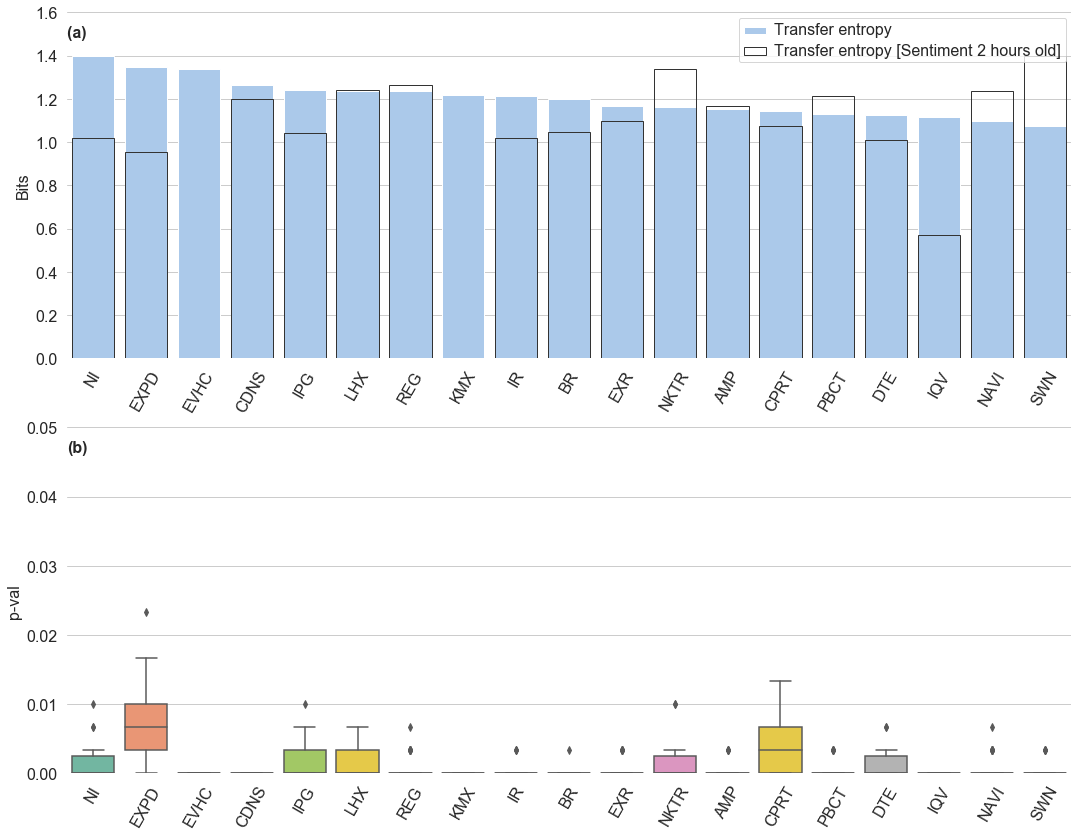

In [28]:
# vertical with lag+1
my_font_size = 16    
my_fig_width = 18
my_fig_heigh = 14
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

fig, ax =plt.subplots(2,1, figsize=(my_fig_width, my_fig_heigh))
sns.boxplot(data=df_TE_bootstrap_tickers_columns_lag, orient="v", palette="Set2",  ax=ax[1])
ax[1].set(ylim=(0,0.05), ylabel="p-val")
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=60)

ax[1].set_xlabel("",fontsize=my_font_size)
ax[1].set_ylabel("p-val",fontsize=my_font_size)
ax[1].tick_params(labelsize=my_font_size)
ax[1].set_title('(b)',fontsize=my_font_size, loc = 'left',fontweight="bold", pad = -25)


sns.set_color_codes("pastel")
sns.barplot(y="TE", x="ticker", data=df_TE_sort,
            label="Transfer entropy", color="b",  orient="v", ax=ax[0])

idx_filter_direction = df_TE_lag['direction'] == "sentiment->return"




sns.set_color_codes("muted")
sns.barplot(y="TE", x="ticker", data=df_TE_lag_sort,
            label="Transfer entropy [Sentiment 2 hours old]", color="b",  orient="v", ax=ax[0],\
            facecolor=(1, 1, 1, 0),edgecolor=".2")


ax[0].legend(ncol=1, loc="upper right", frameon=True)
ax[0].set(ylim=(0,1.6), ylabel="Bits")
sns.despine(left=True, bottom=True)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[0].set_title('(a) ',fontsize=my_font_size, loc = 'left',fontweight="bold", pad = -25)

ax[0].set_xlabel("",fontsize=my_font_size)
ax[0].set_ylabel("Bits",fontsize=my_font_size)
ax[0].tick_params(labelsize=my_font_size)


plt.setp(ax[0].get_legend().get_texts(), fontsize=my_font_size)


fig.show()
fig.savefig("TransEntropyStatVerticalLagPlusOneHourIntraDay_2018_2020_quantiles_5_25_50_75_95_sent_diff_adf_BY_corr.pdf",bbox_inches = 'tight', pad_inches = 0) 